Connected to .venv (Python 3.10.16)

In [ ]:
import argparse
import hashlib
from pathlib import Path

import matplotlib.pyplot as plt
import mlflow
import mlflow.pytorch
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.utils.data
import data_insight
from data_insight import setup_duckdb
from duckdb import DuckDBPyConnection as DuckDB
from duckdb import DuckDBPyRelation as Relation
from pathlib import Path
import hashlib
from duckdb import DuckDBPyConnection as DuckDB
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna 
from optuna.visualization import plot_optimization_history


from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset,DataLoader, Dataset
from tqdm.auto import tqdm

import sensor_imputation_thesis.shared.load_data as load


def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# set tracking_uri:
mlflow.set_tracking_uri("http://localhost:5000")
# So I don't know if above commands are sufficient server setup, but it did work for me. And I might need your help if they aren't
# mlflow relevant info:
# I overall faced problem that says "HTTPConnectionPool(host='0.0.0.0', port=5000): Max retries exceeded with url". And the solutions were:
# 1. Try running this line in terminal to see if mlflow logs exist
# if logs exist, port can be directed
# " mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlruns "
# 2. Another possible solution for mlflow errors is to rename the experiment name and the run-name involved below

# Load data

pd.set_option("display.max_columns", None)


def load_engine_data(
    con: DuckDB, product_id: str, start: pd.Timestamp, stop: pd.Timestamp, tags: list[str]
) -> Relation:
    return con.sql(f"""
    SELECT {','.join(tags)}
    FROM timeseries
    WHERE
        time BETWEEN '{start}' AND '{stop}'
        AND pid = '{product_id}'
    """)

def get_tags_hash(tags):
    return hashlib.md5(",".join(tags).encode()).hexdigest()


# edit timestamp as needed
start, stop = pd.Timestamp("2023-10-01"), pd.Timestamp("2024-10-01")

# these are the tags that include 9 missing cols, feel free to edit
tags = [
    "time",
    "fr_eng",
    "te_exh_cyl_out__0",
    "pd_air_ic__0",
    "pr_exh_turb_out__0",
    "te_air_ic_out__0",
    "te_seawater",
    "te_air_comp_in_a__0",
    "te_air_comp_in_b__0",
    "fr_tc__0",
    "pr_baro",
    #most common "bad"/ "out of bound" sensors
    "pd_air_ic__0",  #overlapped with below
    "pr_exh_rec",
    "te_exh_turb_in__0",
    "te_exh_turb_out__0",
    #Feature Importance Result
    #for te_exh_cyl_out__0
    "bo_aux_blower_running",
    "re_eng_load",
    "pr_air_scav_ecs", #overlap
    #pd_air_ic__0
    "pr_air_scav",
    #for te_air_ic_out__0
    #for te_seawater
    "te_air_scav_rec",
    "te_air_ic_out__0",
    "pr_cyl_comp__0",
    "pr_cyl_max__0",
    "se_mip__0",
    "te_exh_cyl_out__0",
    "fr_eng_setpoint",
    "te_air_scav_rec_iso",
    #for pr_baro
    "pr_cyl_max_mv_iso",
    "pr_cyl_comp_mv_iso",
    "fr_eng_ecs",
    "pr_air_scav_iso",


]

# edit point as needed
product_id = "89ccb7a888d53f8792f0580801cede9a"

#product_id 
#add more product id with same engine type (fine the most popular ones)


# Construct the cache file path using the Path class
DATA = Path.home() / "SageMaker/data_cache"
DATA.mkdir(exist_ok=True)
cache = DATA / f"data_{get_tags_hash(tags)}_{product_id}_{start:%Y-%m-%d}_{stop:%Y-%m-%d}.parquet"

# Ensure the directory exists
cache.parent.mkdir(parents=True, exist_ok=True)

if cache.exists():
    df = pd.read_parquet(cache)
else:
    con = setup_duckdb()
    df = load_engine_data(con, product_id, start, stop, tags).df()
    df.to_parquet(cache)

print(df.head(10))


## Adding engine types and assign onehot encoder, and merge df  
con = data_insight.setup_duckdb()
con.sql("SET enable_progress_bar=true")
engine_type = con.sql(f"SELECT engine_type FROM shipinfo WHERE productId == '{product_id}'").df().engine_type.item()
df['engine_type']=engine_type

#Apply onehotencoder 
encoder = OneHotEncoder(sparse_output=False)
encoded_engine_type = encoder.fit_transform(df[['engine_type']])
# Create a DataFrame with the encoded columns
encoded_df = pd.DataFrame(encoded_engine_type, columns=encoder.get_feature_names_out(['engine_type']))
# Concatenate the original DataFrame with the encoded DataFrame
df = pd.concat([df, encoded_df], axis=1)
#drop? not sure yet. 
df.drop('engine_type', axis=1,inplace=True)



# Preprocessing steps not needed for this col
# filter df with engine running (changed into 10/60 revolutions)
df1 = df[df["fr_eng"] > (10/60)]

# Check nan values in each column
for col in df1.columns:
    print(f"Column {col} has {df1[col].isna().sum()} NaN values")


## Newly Suggested Approach to drop nan columns (drop cols with all nan values, and then drop rows that have any nan value )
df1=df.dropna(axis=1,how='all')
# drop any null vals in rows 
df1=df1.dropna(axis=0,how='any')

#check the length of the df1 and the length of df to check how many cols rows are dropped 
print("shape of original df:")
print("Datasize:",len(df))
print("Colnumber:",len(df.columns))

print("shape of filtered df:")
print("Datasize:",len(df1))
print("Colnumber:",len(df1.columns))

# Select numeric columns
numeric_df = df1.select_dtypes(include="number")
print(numeric_df)

data=numeric_df  #data here is before scaling 


#define inverse scale
def inverse_scale(scaled_data, data_min, scale):
    return scaled_data*scale + data_min


# VAE Model
class VAE(nn.Module):
    def __init__(self, input_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.tanh(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


##XGBoost 


# Reconstruction + KL divergence losses summed over target column and batch
def loss_function(recon_x, x, mu, logvar, targetcol_idx, lambda_val):
    # Specify the target column
    recon_x_col = recon_x[:, targetcol_idx]
    x_col = x[:, targetcol_idx]

    # MSE & KLD for target column
    MSE_col = F.mse_loss(recon_x_col, x_col, reduction="sum")
    KLD_col = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # MSE & KLD for entire dataset
    MSE_all = F.mse_loss(recon_x, x, reduction="sum")
    KLD_all = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Combine losses using lambda
    loss = lambda_val * (MSE_col + KLD_col) + (1 - lambda_val) * (MSE_all + KLD_all)
    return loss


###add mse(&mae) comparison within training loop for target column
#test if this works 


def train(epoch, model, train_loader, data_min, scale, lambda_val, targetcol_idx, optimizer, device, args):
    model.train()
    train_loss = 0
    mae_loss_target_train = 0
    average_train_loss = 0  # Initialize average_train_loss
    pbar = tqdm(total=len(train_loader), desc="Training")
    for batch_idx, (data,) in enumerate(train_loader): #trian loader is after scaling
        data_unmasked = data.to(device).float() #this data is before scaling
        # Mask the target column
        data_masked = data_unmasked.clone() #before scaling
        data_masked[:, targetcol_idx] = -2
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data_masked)  # Masked target col
        if torch.isnan(recon_batch).any():
            print("NaN or in recon_batch!")
            break
        loss = loss_function(recon_batch, data_unmasked, mu, logvar, targetcol_idx, lambda_val)
        if torch.isnan(loss) or torch.isinf(loss):
            raise ValueError(f"NaN or Inf detected in loss at batch {batch_idx}. Check scaling or model outputs!")
            break
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            pbar.set_description(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item() / len(data),
                )
            )

        pbar.update(1)
        #revised 
        data_unscaled=inverse_scale(data_unmasked,data_min.to(device),scale.to(device))
        target_column=data_unscaled[:,targetcol_idx]
        recon_unscaled=inverse_scale(recon_batch,data_min.to(device),scale.to(device))
        recon_column=recon_unscaled[:,targetcol_idx]

                                                                                                
        #mae metric calculation
        mae_loss_target_train+=torch.mean(torch.abs(target_column-recon_column)).item()
        #mae_loss_target_train += mean_absolute_error(target_column, recon_column)  # Ground truth

    average_train_loss = train_loss / len(train_loader.dataset)  # Update after loop
    print("====> Epoch: {} Average train loss: {:.4f}".format(epoch, average_train_loss))
    print("===> Epoch: {} Average mae test loss for targetcol :{:.4f}".format(epoch,mae_loss_target_train/len(train_loader)))
    return average_train_loss, mae_loss_target_train / len(train_loader)


#Added mse in the test
#In the test loop, masked column should be the input. 
#Redefine data for the test loop(should I inlcude this in the test loop or leave it here?)
#dataset changed into validation set for testing loop
    
def test(epoch, model, val_loader, scale, data_min, targetcol_idx, device):
    model.eval()
    test_loss = 0
    mae_loss_target_test = 0
    with torch.no_grad():
        for batch_idx, (data,) in enumerate(val_loader):
            data_unmasked = data.to(device).float()  #data used here is before scaling 
            # Mask the target column
            data_masked = data_unmasked.clone()
            data_masked[:, targetcol_idx] = -2
            recon_batch, mu, logvar = model(data_masked)  # Masked target col
            # Define new lambda val for testing
            lambda_val = 1.0
            test_loss += loss_function(recon_batch, data_unmasked, mu, logvar, targetcol_idx, lambda_val).item()
            # Scale back target column and reconstructed column
            data_unscaled=inverse_scale(data_unmasked,data_min.to(device),scale.to(device))
            target_column=data_unscaled[:,targetcol_idx]
            recon_unscaled=inverse_scale(recon_batch,data_min.to(device),scale.to(device))
            recon_column=recon_unscaled[:,targetcol_idx]
                                                           
            #mae metric calculation
            mae_loss_target_test+=torch.mean(torch.abs(target_column-recon_column)).item()
           # mae_loss_target_test += mean_absolute_error(target_column, recon_column)
        
        print("===> Epoch: {} Average mae test loss for targetcol: {:.4f}".format(epoch, mae_loss_target_test / len(val_loader)))
        print("====> Test set loss: {:.4f}".format(test_loss))
        average_test_loss = test_loss / len(val_loader.dataset)
        print("====> Epoch: {} Average test loss: {:.4f}".format(epoch, average_test_loss))
    
    return average_test_loss, mae_loss_target_test / len(val_loader)




def main():
    # Configuration parameters
    class Config:
        batch_size = 64
        epochs = 150
        no_cuda = False
        no_mps = False
        seed = 1
        log_interval = 10
        lr = 1e-4

    dl_kwargs = dict(
        batch_size=Config.batch_size,
        shuffle=True,
        # num_workers=4, # This may or may not be faster, depending on system
        pin_memory=torch.cuda.is_available(),
    )

    args = Config()
    args.cuda = not args.no_cuda and torch.cuda.is_available()
    use_mps = not args.no_mps and torch.backends.mps.is_available()

    torch.manual_seed(args.seed)

    if args.cuda:
        device = torch.device("cuda")
    elif use_mps:
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    
   # Specify the target column, here should be changed while training other target columns
    # (edit point as needed)
    targetcolumn = "te_air_scav_rec"
    targetcol_idx = data.columns.get_loc(targetcolumn)

    #split dataset
    train_size = int(0.6 * len(data))
    val_size=int(0.2 * len(data))

    train_df = data.iloc[:train_size]
    val_df = data.iloc[train_size:train_size + val_size]
    test_df= data.iloc[train_size + val_size:]

    # Standardize the numeric data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    #only apply scaler to the train set 
    scaled_train=scaler.fit_transform(train_df.values)
    print("scaled_data", scaled_train)
    print("unscaled_data",data)

    # Transform val and test using the same scaler
    scaled_val=scaler.transform(val_df.values)
    scaled_test=scaler.transform(test_df.values)

        
    data_min=torch.tensor(scaler.data_min_,dtype=torch.float32)
    data_max=torch.tensor(scaler.data_max_,dtype=torch.float32)
    scale=data_max-data_min
    scale[scale==0]=1e-8


    #Convert DataFrame to Tensor
    scaled_train_tensor=torch.tensor(scaled_train,dtype=torch.float32)
    scaled_val_tensor=torch.tensor(scaled_val,dtype=torch.float32)
    scaled_test_tensor=torch.tensor(scaled_test,dtype=torch.float32)

    #create datasets on CPU
    train_dataset=TensorDataset(scaled_train_tensor)
    val_dataset=TensorDataset(scaled_val_tensor)
    test_dataset=TensorDataset(scaled_test_tensor)


     # Initialize Mlflow
    mlflow.set_experiment("VAE_adjustedtestwizcorrect_optuna")


    def plot_loss_trends(run_id):
        client = mlflow.tracking.MlflowClient()
        
        # Retrieve metric history
        history_train = client.get_metric_history(run_id, "average_train_loss")
        history_test = client.get_metric_history(run_id, "average_test_loss")

        if not history_train or not history_test:
            print("No metric history found for the given run_id.")
            return

        # Sort by step to ensure correct order
        history_train.sort(key=lambda x: x.step)
        history_test.sort(key=lambda x: x.step)

        epochs = [point.step for point in history_train]
        train_losses = [point.value for point in history_train]
        test_losses = [point.value for point in history_test]

        # Plotting
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, train_losses, label="Train Loss")
        plt.plot(epochs, test_losses, label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss Trend from Best Trial")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()



    #Adding Optuna
    def objective(trial,device, data_min, scale):
        with mlflow.start_run(nested=True) as run:
            input_dim = scaled_train.shape[1]
            batch_size =trial.suggest_int("batch_size", 32, 128, step=32)
            lr = trial.suggest_float("learning_rate", 1e-6, 1e-1, log=True)
            lambda_val = trial.suggest_float("lambda", 0.5, 1.0)
            
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
            
            mlflow.log_params({
                    "batch_size":batch_size,
                    "learning_rate":lr,
                    "lambda":lambda_val
                })

            model = VAE(input_dim=input_dim).to(device)

            optimizer = optim.Adam(model.parameters(), lr=lr)


            for epoch in range(args.epochs):
                
                average_train_loss, mae_loss_target_train = train(
                    epoch,
                    model,
                    train_loader,
                    lambda_val=lambda_val,
                    targetcol_idx=targetcol_idx,
                    optimizer=optimizer,
                    device=device,
                    data_min=data_min, 
                    scale=scale, #this is used for inverse scaling
                    args=args
                )

                average_test_loss, mae_loss_target_test=test(
                    epoch,
                    model,
                    val_loader,
                    targetcol_idx=targetcol_idx,
                    device=device,
                    data_min=data_min,
                    scale=scale #same, used for inverse scaling 
                
                )
                

                
                mlflow.log_metrics(
                    {
                        "epoch": epoch,
                        "average_train_loss": average_train_loss,
                        "average_test_loss": average_test_loss,
                        "mae_loss_target_train": mae_loss_target_train,
                        "mae_loss_target_test": mae_loss_target_test,
                    },
                    step=epoch,
)


            trial.set_user_attr("model_state_dict", model.state_dict())
            trial.set_user_attr("mlflow_run_id", run.info.run_id)
            
            return average_test_loss # Ensure only one value is returned

   
    # Define run name(edit)
    vae_run_name = "optuna_vae_adjusted_for_te_air_scav_rec"
    
    with mlflow.start_run(run_name=vae_run_name) as parent_run:
        study = optuna.create_study(direction="minimize")
        study.optimize(lambda trial:objective (trial,device,data_min,scale),n_trials=100, timeout=3600)
        #plot_optimization_history(study)  #visualization 
        best_trial = study.best_trial
        best_run_id = best_trial.user_attrs["mlflow_run_id"] #log run id to see the loss trend later
        best_batch_size=best_trial.params["batch_size"]

      
        mlflow.log_params(best_trial.params)
        mlflow.log_param("best_run_id", best_run_id)
        mlflow.log_metric("Best Validation Loss:", best_trial.value)
        print("Best Trial:")
        print(f"Validation loss: {best_trial.value}")
        print("Params:")

        # Check the loss trend of the best trial using corresponding run_id 
        best_trial_run_id = best_run_id
        plot_loss_trends(best_trial_run_id)


        for key, value in best_trial.params.items():
            print(f"{key}: {value}")
       
    #Test on the test set with best parameters
    with mlflow.start_run(run_name="Final_test_val_for_te_air_scav_rec", nested=True):
            # Model Reloading
            best_model=VAE(input_dim=scaled_train.shape[1]).to(device)
            best_model.load_state_dict(study.best_trial.user_attrs["model_state_dict"])
              
            
            #Evaluate on the test data 
            test_loader=DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)
            epoch=50
            average_test_loss, mae_loss_target_test=test(
                        val_loader=test_loader,
                        epoch=epoch,
                        model=best_model,
                        targetcol_idx=targetcol_idx,
                        device=device,
                        data_min=data_min,
                        scale=scale
                        )
                
                
            mlflow.log_metrics(
                    {
                    "epoch": epoch,
                    "Final_test_loss": average_test_loss,
                    "Final_loss_target_test": mae_loss_target_test,
                    },
                 step=epoch,
)
            print(f"Final Test Loss:{average_test_loss:.4f}, MAE:{mae_loss_target_test:.4f}")
            
            ##Registration may not needed yet.. 
             #log the model with scaling params
            #input_dim = scaled_train.shape[1]
            #input_example = torch.randn(1, input_dim).float().cpu().numpy()  # Convert to NumPy
            #mlflow.pytorch.log_model(
              #  pytorch_model=best_model,
               # artifact_path="model",
               # registered_model_name="VAE for te_air_scav_rec",
               # input_example=input_example,
               # extra_pip_requirements=["torch","optuna","mlflow"],
                                                             
               # metadata={
                  #  "train_min": data_min.cpu().numpy().tolist(),
                  #  "scale": scale.cpu().numpy().tolist()
                 #   }
                #)
            

if __name__ == '__main__':
    main()







    # CSOM: This should be done ONCE after training, and not inside the training loop.

/home/ec2-user/SageMaker/sensor-imputation-thesis/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


>>> con.sql("SHOW TABLES;")
┌────────────┐
│    name    │
│  varchar   │
├────────────┤
│ shipinfo   │
│ site_infos │
│ timeseries │
└────────────┘


>>> con.sql("DESCRIBE shipinfo;")
┌──────────────────────┬───────────────────────────────────────────────────────┬─────────┬─────────┬─────────┬─────────┐
│     column_name      │                      column_type                      │  null   │   key   │ default │  extra  │
│       varchar        │                        varchar                        │ varchar │ varchar │ varchar │ varchar │
├──────────────────────┼───────────────────────────────────────────────────────┼─────────┼─────────┼─────────┼─────────┤
│ information_validity │ VARCHAR                                               │ YES     │ NULL    │ NULL    │ NULL    │
│ imo_no               │ VARCHAR                                               │ YES     │ NULL    │ NULL    │ NULL    │
│ ship_name            │ VARCHAR                                               │ YES     │

MlflowException: API request to http://localhost:5000/api/2.0/mlflow/experiments/get-by-name failed with exception HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api/2.0/mlflow/experiments/get-by-name?experiment_name=VAE_adjustedtestwizcorrect_optuna (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f40c0a02f20>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [ ]:
import argparse
import hashlib
from pathlib import Path

import matplotlib.pyplot as plt
import mlflow
import mlflow.pytorch
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.utils.data
import data_insight
from data_insight import setup_duckdb
from duckdb import DuckDBPyConnection as DuckDB
from duckdb import DuckDBPyRelation as Relation
from pathlib import Path
import hashlib
from duckdb import DuckDBPyConnection as DuckDB
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna 
from optuna.visualization import plot_optimization_history


from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset,DataLoader, Dataset
from tqdm.auto import tqdm

import sensor_imputation_thesis.shared.load_data as load


def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# set tracking_uri:
mlflow.set_tracking_uri("http://localhost:5000")
# So I don't know if above commands are sufficient server setup, but it did work for me. And I might need your help if they aren't
# mlflow relevant info:
# I overall faced problem that says "HTTPConnectionPool(host='0.0.0.0', port=5000): Max retries exceeded with url". And the solutions were:
# 1. Try running this line in terminal to see if mlflow logs exist
# if logs exist, port can be directed
# " mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlruns "
# 2. Another possible solution for mlflow errors is to rename the experiment name and the run-name involved below

# Load data

pd.set_option("display.max_columns", None)


def load_engine_data(
    con: DuckDB, product_id: str, start: pd.Timestamp, stop: pd.Timestamp, tags: list[str]
) -> Relation:
    return con.sql(f"""
    SELECT {','.join(tags)}
    FROM timeseries
    WHERE
        time BETWEEN '{start}' AND '{stop}'
        AND pid = '{product_id}'
    """)

def get_tags_hash(tags):
    return hashlib.md5(",".join(tags).encode()).hexdigest()


# edit timestamp as needed
start, stop = pd.Timestamp("2023-10-01"), pd.Timestamp("2024-10-01")

# these are the tags that include 9 missing cols, feel free to edit
tags = [
    "time",
    "fr_eng",
    "te_exh_cyl_out__0",
    "pd_air_ic__0",
    "pr_exh_turb_out__0",
    "te_air_ic_out__0",
    "te_seawater",
    "te_air_comp_in_a__0",
    "te_air_comp_in_b__0",
    "fr_tc__0",
    "pr_baro",
    #most common "bad"/ "out of bound" sensors
    "pd_air_ic__0",  #overlapped with below
    "pr_exh_rec",
    "te_exh_turb_in__0",
    "te_exh_turb_out__0",
    #Feature Importance Result
    #for te_exh_cyl_out__0
    "bo_aux_blower_running",
    "re_eng_load",
    "pr_air_scav_ecs", #overlap
    #pd_air_ic__0
    "pr_air_scav",
    #for te_air_ic_out__0
    #for te_seawater
    "te_air_scav_rec",
    "te_air_ic_out__0",
    "pr_cyl_comp__0",
    "pr_cyl_max__0",
    "se_mip__0",
    "te_exh_cyl_out__0",
    "fr_eng_setpoint",
    "te_air_scav_rec_iso",
    #for pr_baro
    "pr_cyl_max_mv_iso",
    "pr_cyl_comp_mv_iso",
    "fr_eng_ecs",
    "pr_air_scav_iso",


]

# edit point as needed
product_id = "89ccb7a888d53f8792f0580801cede9a"

#product_id 
#add more product id with same engine type (fine the most popular ones)


# Construct the cache file path using the Path class
DATA = Path.home() / "SageMaker/data_cache"
DATA.mkdir(exist_ok=True)
cache = DATA / f"data_{get_tags_hash(tags)}_{product_id}_{start:%Y-%m-%d}_{stop:%Y-%m-%d}.parquet"

# Ensure the directory exists
cache.parent.mkdir(parents=True, exist_ok=True)

if cache.exists():
    df = pd.read_parquet(cache)
else:
    con = setup_duckdb()
    df = load_engine_data(con, product_id, start, stop, tags).df()
    df.to_parquet(cache)

print(df.head(10))


## Adding engine types and assign onehot encoder, and merge df  
con = data_insight.setup_duckdb()
con.sql("SET enable_progress_bar=true")
engine_type = con.sql(f"SELECT engine_type FROM shipinfo WHERE productId == '{product_id}'").df().engine_type.item()
df['engine_type']=engine_type

#Apply onehotencoder 
encoder = OneHotEncoder(sparse_output=False)
encoded_engine_type = encoder.fit_transform(df[['engine_type']])
# Create a DataFrame with the encoded columns
encoded_df = pd.DataFrame(encoded_engine_type, columns=encoder.get_feature_names_out(['engine_type']))
# Concatenate the original DataFrame with the encoded DataFrame
df = pd.concat([df, encoded_df], axis=1)
#drop? not sure yet. 
df.drop('engine_type', axis=1,inplace=True)



# Preprocessing steps not needed for this col
# filter df with engine running (changed into 10/60 revolutions)
df1 = df[df["fr_eng"] > (10/60)]

# Check nan values in each column
for col in df1.columns:
    print(f"Column {col} has {df1[col].isna().sum()} NaN values")


## Newly Suggested Approach to drop nan columns (drop cols with all nan values, and then drop rows that have any nan value )
df1=df.dropna(axis=1,how='all')
# drop any null vals in rows 
df1=df1.dropna(axis=0,how='any')

#check the length of the df1 and the length of df to check how many cols rows are dropped 
print("shape of original df:")
print("Datasize:",len(df))
print("Colnumber:",len(df.columns))

print("shape of filtered df:")
print("Datasize:",len(df1))
print("Colnumber:",len(df1.columns))

# Select numeric columns
numeric_df = df1.select_dtypes(include="number")
print(numeric_df)

data=numeric_df  #data here is before scaling 


#define inverse scale
def inverse_scale(scaled_data, data_min, scale):
    return scaled_data*scale + data_min


# VAE Model
class VAE(nn.Module):
    def __init__(self, input_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.tanh(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


##XGBoost 


# Reconstruction + KL divergence losses summed over target column and batch
def loss_function(recon_x, x, mu, logvar, targetcol_idx, lambda_val):
    # Specify the target column
    recon_x_col = recon_x[:, targetcol_idx]
    x_col = x[:, targetcol_idx]

    # MSE & KLD for target column
    MSE_col = F.mse_loss(recon_x_col, x_col, reduction="sum")
    KLD_col = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # MSE & KLD for entire dataset
    MSE_all = F.mse_loss(recon_x, x, reduction="sum")
    KLD_all = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Combine losses using lambda
    loss = lambda_val * (MSE_col + KLD_col) + (1 - lambda_val) * (MSE_all + KLD_all)
    return loss


###add mse(&mae) comparison within training loop for target column
#test if this works 


def train(epoch, model, train_loader, data_min, scale, lambda_val, targetcol_idx, optimizer, device, args):
    model.train()
    train_loss = 0
    mae_loss_target_train = 0
    average_train_loss = 0  # Initialize average_train_loss
    pbar = tqdm(total=len(train_loader), desc="Training")
    for batch_idx, (data,) in enumerate(train_loader): #trian loader is after scaling
        data_unmasked = data.to(device).float() #this data is before scaling
        # Mask the target column
        data_masked = data_unmasked.clone() #before scaling
        data_masked[:, targetcol_idx] = -2
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data_masked)  # Masked target col
        if torch.isnan(recon_batch).any():
            print("NaN or in recon_batch!")
            break
        loss = loss_function(recon_batch, data_unmasked, mu, logvar, targetcol_idx, lambda_val)
        if torch.isnan(loss) or torch.isinf(loss):
            raise ValueError(f"NaN or Inf detected in loss at batch {batch_idx}. Check scaling or model outputs!")
            break
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            pbar.set_description(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item() / len(data),
                )
            )

        pbar.update(1)
        #revised 
        data_unscaled=inverse_scale(data_unmasked,data_min.to(device),scale.to(device))
        target_column=data_unscaled[:,targetcol_idx]
        recon_unscaled=inverse_scale(recon_batch,data_min.to(device),scale.to(device))
        recon_column=recon_unscaled[:,targetcol_idx]

                                                                                                
        #mae metric calculation
        mae_loss_target_train+=torch.mean(torch.abs(target_column-recon_column)).item()
        #mae_loss_target_train += mean_absolute_error(target_column, recon_column)  # Ground truth

    average_train_loss = train_loss / len(train_loader.dataset)  # Update after loop
    print("====> Epoch: {} Average train loss: {:.4f}".format(epoch, average_train_loss))
    print("===> Epoch: {} Average mae test loss for targetcol :{:.4f}".format(epoch,mae_loss_target_train/len(train_loader)))
    return average_train_loss, mae_loss_target_train / len(train_loader)


#Added mse in the test
#In the test loop, masked column should be the input. 
#Redefine data for the test loop(should I inlcude this in the test loop or leave it here?)
#dataset changed into validation set for testing loop
    
def test(epoch, model, val_loader, scale, data_min, targetcol_idx, device):
    model.eval()
    test_loss = 0
    mae_loss_target_test = 0
    with torch.no_grad():
        for batch_idx, (data,) in enumerate(val_loader):
            data_unmasked = data.to(device).float()  #data used here is before scaling 
            # Mask the target column
            data_masked = data_unmasked.clone()
            data_masked[:, targetcol_idx] = -2
            recon_batch, mu, logvar = model(data_masked)  # Masked target col
            # Define new lambda val for testing
            lambda_val = 1.0
            test_loss += loss_function(recon_batch, data_unmasked, mu, logvar, targetcol_idx, lambda_val).item()
            # Scale back target column and reconstructed column
            data_unscaled=inverse_scale(data_unmasked,data_min.to(device),scale.to(device))
            target_column=data_unscaled[:,targetcol_idx]
            recon_unscaled=inverse_scale(recon_batch,data_min.to(device),scale.to(device))
            recon_column=recon_unscaled[:,targetcol_idx]
                                                           
            #mae metric calculation
            mae_loss_target_test+=torch.mean(torch.abs(target_column-recon_column)).item()
           # mae_loss_target_test += mean_absolute_error(target_column, recon_column)
        
        print("===> Epoch: {} Average mae test loss for targetcol: {:.4f}".format(epoch, mae_loss_target_test / len(val_loader)))
        print("====> Test set loss: {:.4f}".format(test_loss))
        average_test_loss = test_loss / len(val_loader.dataset)
        print("====> Epoch: {} Average test loss: {:.4f}".format(epoch, average_test_loss))
    
    return average_test_loss, mae_loss_target_test / len(val_loader)




def main():
    # Configuration parameters
    class Config:
        batch_size = 64
        epochs = 150
        no_cuda = False
        no_mps = False
        seed = 1
        log_interval = 10
        lr = 1e-4

    dl_kwargs = dict(
        batch_size=Config.batch_size,
        shuffle=True,
        # num_workers=4, # This may or may not be faster, depending on system
        pin_memory=torch.cuda.is_available(),
    )

    args = Config()
    args.cuda = not args.no_cuda and torch.cuda.is_available()
    use_mps = not args.no_mps and torch.backends.mps.is_available()

    torch.manual_seed(args.seed)

    if args.cuda:
        device = torch.device("cuda")
    elif use_mps:
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    
   # Specify the target column, here should be changed while training other target columns
    # (edit point as needed)
    targetcolumn = "te_air_scav_rec"
    targetcol_idx = data.columns.get_loc(targetcolumn)

    #split dataset
    train_size = int(0.6 * len(data))
    val_size=int(0.2 * len(data))

    train_df = data.iloc[:train_size]
    val_df = data.iloc[train_size:train_size + val_size]
    test_df= data.iloc[train_size + val_size:]

    # Standardize the numeric data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    #only apply scaler to the train set 
    scaled_train=scaler.fit_transform(train_df.values)
    print("scaled_data", scaled_train)
    print("unscaled_data",data)

    # Transform val and test using the same scaler
    scaled_val=scaler.transform(val_df.values)
    scaled_test=scaler.transform(test_df.values)

        
    data_min=torch.tensor(scaler.data_min_,dtype=torch.float32)
    data_max=torch.tensor(scaler.data_max_,dtype=torch.float32)
    scale=data_max-data_min
    scale[scale==0]=1e-8


    #Convert DataFrame to Tensor
    scaled_train_tensor=torch.tensor(scaled_train,dtype=torch.float32)
    scaled_val_tensor=torch.tensor(scaled_val,dtype=torch.float32)
    scaled_test_tensor=torch.tensor(scaled_test,dtype=torch.float32)

    #create datasets on CPU
    train_dataset=TensorDataset(scaled_train_tensor)
    val_dataset=TensorDataset(scaled_val_tensor)
    test_dataset=TensorDataset(scaled_test_tensor)


     # Initialize Mlflow
    mlflow.set_experiment("VAE_adjustedtestwizcorrect_optuna")


    def plot_loss_trends(run_id):
        client = mlflow.tracking.MlflowClient()
        
        # Retrieve metric history
        history_train = client.get_metric_history(run_id, "average_train_loss")
        history_test = client.get_metric_history(run_id, "average_test_loss")

        if not history_train or not history_test:
            print("No metric history found for the given run_id.")
            return

        # Sort by step to ensure correct order
        history_train.sort(key=lambda x: x.step)
        history_test.sort(key=lambda x: x.step)

        epochs = [point.step for point in history_train]
        train_losses = [point.value for point in history_train]
        test_losses = [point.value for point in history_test]

        # Plotting
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, train_losses, label="Train Loss")
        plt.plot(epochs, test_losses, label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss Trend from Best Trial")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()



    #Adding Optuna
    def objective(trial,device, data_min, scale):
        with mlflow.start_run(nested=True) as run:
            input_dim = scaled_train.shape[1]
            batch_size =trial.suggest_int("batch_size", 32, 128, step=32)
            lr = trial.suggest_float("learning_rate", 1e-6, 1e-1, log=True)
            lambda_val = trial.suggest_float("lambda", 0.5, 1.0)
            
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
            
            mlflow.log_params({
                    "batch_size":batch_size,
                    "learning_rate":lr,
                    "lambda":lambda_val
                })

            model = VAE(input_dim=input_dim).to(device)

            optimizer = optim.Adam(model.parameters(), lr=lr)


            for epoch in range(args.epochs):
                
                average_train_loss, mae_loss_target_train = train(
                    epoch,
                    model,
                    train_loader,
                    lambda_val=lambda_val,
                    targetcol_idx=targetcol_idx,
                    optimizer=optimizer,
                    device=device,
                    data_min=data_min, 
                    scale=scale, #this is used for inverse scaling
                    args=args
                )

                average_test_loss, mae_loss_target_test=test(
                    epoch,
                    model,
                    val_loader,
                    targetcol_idx=targetcol_idx,
                    device=device,
                    data_min=data_min,
                    scale=scale #same, used for inverse scaling 
                
                )
                

                
                mlflow.log_metrics(
                    {
                        "epoch": epoch,
                        "average_train_loss": average_train_loss,
                        "average_test_loss": average_test_loss,
                        "mae_loss_target_train": mae_loss_target_train,
                        "mae_loss_target_test": mae_loss_target_test,
                    },
                    step=epoch,
)


            trial.set_user_attr("model_state_dict", model.state_dict())
            trial.set_user_attr("mlflow_run_id", run.info.run_id)
            
            return average_test_loss # Ensure only one value is returned

   
    # Define run name(edit)
    vae_run_name = "optuna_vae_adjusted_for_te_air_scav_rec"
    
    with mlflow.start_run(run_name=vae_run_name) as parent_run:
        study = optuna.create_study(direction="minimize")
        study.optimize(lambda trial:objective (trial,device,data_min,scale),n_trials=100, timeout=3600)
        #plot_optimization_history(study)  #visualization 
        best_trial = study.best_trial
        best_run_id = best_trial.user_attrs["mlflow_run_id"] #log run id to see the loss trend later
        best_batch_size=best_trial.params["batch_size"]

      
        mlflow.log_params(best_trial.params)
        mlflow.log_param("best_run_id", best_run_id)
        mlflow.log_metric("Best Validation Loss:", best_trial.value)
        print("Best Trial:")
        print(f"Validation loss: {best_trial.value}")
        print("Params:")

        # Check the loss trend of the best trial using corresponding run_id 
        best_trial_run_id = best_run_id
        plot_loss_trends(best_trial_run_id)


        for key, value in best_trial.params.items():
            print(f"{key}: {value}")
       
    #Test on the test set with best parameters
    with mlflow.start_run(run_name="Final_test_val_for_te_air_scav_rec", nested=True):
            # Model Reloading
            best_model=VAE(input_dim=scaled_train.shape[1]).to(device)
            best_model.load_state_dict(study.best_trial.user_attrs["model_state_dict"])
              
            
            #Evaluate on the test data 
            test_loader=DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)
            epoch=50
            average_test_loss, mae_loss_target_test=test(
                        val_loader=test_loader,
                        epoch=epoch,
                        model=best_model,
                        targetcol_idx=targetcol_idx,
                        device=device,
                        data_min=data_min,
                        scale=scale
                        )
                
                
            mlflow.log_metrics(
                    {
                    "epoch": epoch,
                    "Final_test_loss": average_test_loss,
                    "Final_loss_target_test": mae_loss_target_test,
                    },
                 step=epoch,
)
            print(f"Final Test Loss:{average_test_loss:.4f}, MAE:{mae_loss_target_test:.4f}")
            
            ##Registration may not needed yet.. 
             #log the model with scaling params
            #input_dim = scaled_train.shape[1]
            #input_example = torch.randn(1, input_dim).float().cpu().numpy()  # Convert to NumPy
            #mlflow.pytorch.log_model(
              #  pytorch_model=best_model,
               # artifact_path="model",
               # registered_model_name="VAE for te_air_scav_rec",
               # input_example=input_example,
               # extra_pip_requirements=["torch","optuna","mlflow"],
                                                             
               # metadata={
                  #  "train_min": data_min.cpu().numpy().tolist(),
                  #  "scale": scale.cpu().numpy().tolist()
                 #   }
                #)
            

if __name__ == '__main__':
    main()







    # CSOM: This should be done ONCE after training, and not inside the training loop.

                 time  fr_eng  te_exh_cyl_out__0  pd_air_ic__0  \
0 2023-10-01 00:00:00     0.0             400.15         -70.0   
1 2023-10-01 00:01:00     0.0             399.15         -70.0   
2 2023-10-01 00:02:00     0.0             399.15         -70.0   
3 2023-10-01 00:03:00     0.0             399.15         -80.0   
4 2023-10-01 00:04:00     0.0             399.15         -80.0   
5 2023-10-01 00:05:00     0.0             399.15         -70.0   
6 2023-10-01 00:06:00     0.0             399.15         -70.0   
7 2023-10-01 00:07:00     0.0             399.15         -70.0   
8 2023-10-01 00:08:00     0.0             399.15         -80.0   
9 2023-10-01 00:09:00     0.0             399.15         -80.0   

   pr_exh_turb_out__0  te_air_ic_out__0  te_seawater  te_air_comp_in_a__0  \
0                 NaN            308.95       291.25                  NaN   
1                 NaN            308.85       291.25                  NaN   
2                 NaN            308.85   

2025/05/15 11:26:56 INFO mlflow.tracking.fluent: Experiment with name 'VAE_adjustedtestwizcorrect_optuna' does not exist. Creating a new experiment.
[I 2025-05-15 11:26:56,815] A new study created in memory with name: no-name-e1c13a80-55ab-4001-852d-a1eaf52147b5
Train Epoch: 0 [104960/105870 (99%)]	Loss: 0.309351: 100%|██████████| 828/828 [00:17<00:00, 46.79it/s] 


====> Epoch: 0 Average train loss: 0.3423
===> Epoch: 0 Average mae test loss for targetcol :3.2983
===> Epoch: 0 Average mae test loss for targetcol: 3.2935
====> Test set loss: 959.5579
====> Epoch: 0 Average test loss: 0.0272


Train Epoch: 1 [104960/105870 (99%)]	Loss: 0.308465: 100%|██████████| 828/828 [00:03<00:00, 254.43it/s]


====> Epoch: 1 Average train loss: 0.3336
===> Epoch: 1 Average mae test loss for targetcol :3.2131
===> Epoch: 1 Average mae test loss for targetcol: 3.0600
====> Test set loss: 929.6882
====> Epoch: 1 Average test loss: 0.0263


Train Epoch: 2 [104960/105870 (99%)]	Loss: 0.323427: 100%|██████████| 828/828 [00:03<00:00, 249.38it/s]


====> Epoch: 2 Average train loss: 0.3317
===> Epoch: 2 Average mae test loss for targetcol :3.1909
===> Epoch: 2 Average mae test loss for targetcol: 3.1138
====> Test set loss: 911.9753
====> Epoch: 2 Average test loss: 0.0258


Train Epoch: 3 [104960/105870 (99%)]	Loss: 0.351573: 100%|██████████| 828/828 [00:03<00:00, 253.62it/s]


====> Epoch: 3 Average train loss: 0.3306
===> Epoch: 3 Average mae test loss for targetcol :3.1772
===> Epoch: 3 Average mae test loss for targetcol: 2.9861
====> Test set loss: 903.6847
====> Epoch: 3 Average test loss: 0.0256


Train Epoch: 4 [104960/105870 (99%)]	Loss: 0.353070: 100%|██████████| 828/828 [00:03<00:00, 253.81it/s]


====> Epoch: 4 Average train loss: 0.3299
===> Epoch: 4 Average mae test loss for targetcol :3.1740
===> Epoch: 4 Average mae test loss for targetcol: 3.0338
====> Test set loss: 892.6413
====> Epoch: 4 Average test loss: 0.0253


Train Epoch: 5 [104960/105870 (99%)]	Loss: 0.343433: 100%|██████████| 828/828 [00:03<00:00, 253.70it/s]


====> Epoch: 5 Average train loss: 0.3295
===> Epoch: 5 Average mae test loss for targetcol :3.1708
===> Epoch: 5 Average mae test loss for targetcol: 2.9895
====> Test set loss: 891.7349
====> Epoch: 5 Average test loss: 0.0253


Train Epoch: 6 [104960/105870 (99%)]	Loss: 0.263472: 100%|██████████| 828/828 [00:03<00:00, 252.45it/s]


====> Epoch: 6 Average train loss: 0.3295
===> Epoch: 6 Average mae test loss for targetcol :3.1673
===> Epoch: 6 Average mae test loss for targetcol: 3.0034
====> Test set loss: 890.9425
====> Epoch: 6 Average test loss: 0.0252


Train Epoch: 7 [104960/105870 (99%)]	Loss: 0.312489: 100%|██████████| 828/828 [00:03<00:00, 252.43it/s]


====> Epoch: 7 Average train loss: 0.3293
===> Epoch: 7 Average mae test loss for targetcol :3.1670
===> Epoch: 7 Average mae test loss for targetcol: 3.0970
====> Test set loss: 885.5160
====> Epoch: 7 Average test loss: 0.0251


Train Epoch: 8 [104960/105870 (99%)]	Loss: 0.415055: 100%|██████████| 828/828 [00:03<00:00, 252.56it/s]


====> Epoch: 8 Average train loss: 0.3292
===> Epoch: 8 Average mae test loss for targetcol :3.1660
===> Epoch: 8 Average mae test loss for targetcol: 2.9614
====> Test set loss: 896.6700
====> Epoch: 8 Average test loss: 0.0254


Train Epoch: 9 [104960/105870 (99%)]	Loss: 0.399641: 100%|██████████| 828/828 [00:03<00:00, 255.53it/s]


====> Epoch: 9 Average train loss: 0.3292
===> Epoch: 9 Average mae test loss for targetcol :3.1661
===> Epoch: 9 Average mae test loss for targetcol: 3.0418
====> Test set loss: 886.7733
====> Epoch: 9 Average test loss: 0.0251


Train Epoch: 10 [104960/105870 (99%)]	Loss: 0.314120: 100%|██████████| 828/828 [00:03<00:00, 254.02it/s]


====> Epoch: 10 Average train loss: 0.3292
===> Epoch: 10 Average mae test loss for targetcol :3.1639
===> Epoch: 10 Average mae test loss for targetcol: 3.0852
====> Test set loss: 884.4355
====> Epoch: 10 Average test loss: 0.0251


Train Epoch: 11 [104960/105870 (99%)]	Loss: 0.338566: 100%|██████████| 828/828 [00:03<00:00, 254.27it/s]


====> Epoch: 11 Average train loss: 0.3291
===> Epoch: 11 Average mae test loss for targetcol :3.1658
===> Epoch: 11 Average mae test loss for targetcol: 3.0874
====> Test set loss: 884.9423
====> Epoch: 11 Average test loss: 0.0251


Train Epoch: 12 [104960/105870 (99%)]	Loss: 0.307613: 100%|██████████| 828/828 [00:03<00:00, 256.30it/s]


====> Epoch: 12 Average train loss: 0.3291
===> Epoch: 12 Average mae test loss for targetcol :3.1646
===> Epoch: 12 Average mae test loss for targetcol: 3.1509
====> Test set loss: 884.6625
====> Epoch: 12 Average test loss: 0.0251


Train Epoch: 13 [104960/105870 (99%)]	Loss: 0.341555: 100%|██████████| 828/828 [00:03<00:00, 259.83it/s]


====> Epoch: 13 Average train loss: 0.3290
===> Epoch: 13 Average mae test loss for targetcol :3.1628
===> Epoch: 13 Average mae test loss for targetcol: 3.0172
====> Test set loss: 886.8125
====> Epoch: 13 Average test loss: 0.0251


Train Epoch: 14 [104960/105870 (99%)]	Loss: 0.298305: 100%|██████████| 828/828 [00:03<00:00, 261.17it/s]


====> Epoch: 14 Average train loss: 0.3290
===> Epoch: 14 Average mae test loss for targetcol :3.1642
===> Epoch: 14 Average mae test loss for targetcol: 3.0447
====> Test set loss: 887.7102
====> Epoch: 14 Average test loss: 0.0252


Train Epoch: 15 [104960/105870 (99%)]	Loss: 0.353912: 100%|██████████| 828/828 [00:03<00:00, 260.44it/s]


====> Epoch: 15 Average train loss: 0.3290
===> Epoch: 15 Average mae test loss for targetcol :3.1631
===> Epoch: 15 Average mae test loss for targetcol: 3.0274
====> Test set loss: 885.8591
====> Epoch: 15 Average test loss: 0.0251


Train Epoch: 16 [104960/105870 (99%)]	Loss: 0.283559: 100%|██████████| 828/828 [00:03<00:00, 261.40it/s]


====> Epoch: 16 Average train loss: 0.3290
===> Epoch: 16 Average mae test loss for targetcol :3.1646
===> Epoch: 16 Average mae test loss for targetcol: 3.0795
====> Test set loss: 883.9458
====> Epoch: 16 Average test loss: 0.0250


Train Epoch: 17 [104960/105870 (99%)]	Loss: 0.348734: 100%|██████████| 828/828 [00:03<00:00, 262.10it/s]


====> Epoch: 17 Average train loss: 0.3290
===> Epoch: 17 Average mae test loss for targetcol :3.1642
===> Epoch: 17 Average mae test loss for targetcol: 3.0093
====> Test set loss: 887.2978
====> Epoch: 17 Average test loss: 0.0251


Train Epoch: 18 [104960/105870 (99%)]	Loss: 0.302140: 100%|██████████| 828/828 [00:03<00:00, 248.69it/s]


====> Epoch: 18 Average train loss: 0.3290
===> Epoch: 18 Average mae test loss for targetcol :3.1623
===> Epoch: 18 Average mae test loss for targetcol: 3.0111
====> Test set loss: 886.8593
====> Epoch: 18 Average test loss: 0.0251


Train Epoch: 19 [104960/105870 (99%)]	Loss: 0.281235: 100%|██████████| 828/828 [00:03<00:00, 240.46it/s]


====> Epoch: 19 Average train loss: 0.3289
===> Epoch: 19 Average mae test loss for targetcol :3.1618
===> Epoch: 19 Average mae test loss for targetcol: 3.0093
====> Test set loss: 887.7155
====> Epoch: 19 Average test loss: 0.0252


Train Epoch: 20 [104960/105870 (99%)]	Loss: 0.307979: 100%|██████████| 828/828 [00:03<00:00, 233.97it/s]


====> Epoch: 20 Average train loss: 0.3289
===> Epoch: 20 Average mae test loss for targetcol :3.1630
===> Epoch: 20 Average mae test loss for targetcol: 3.0380
====> Test set loss: 885.8614
====> Epoch: 20 Average test loss: 0.0251


Train Epoch: 21 [104960/105870 (99%)]	Loss: 0.372279: 100%|██████████| 828/828 [00:03<00:00, 256.80it/s]


====> Epoch: 21 Average train loss: 0.3289
===> Epoch: 21 Average mae test loss for targetcol :3.1626
===> Epoch: 21 Average mae test loss for targetcol: 3.0310
====> Test set loss: 886.0373
====> Epoch: 21 Average test loss: 0.0251


Train Epoch: 22 [104960/105870 (99%)]	Loss: 0.319063: 100%|██████████| 828/828 [00:03<00:00, 258.95it/s]


====> Epoch: 22 Average train loss: 0.3290
===> Epoch: 22 Average mae test loss for targetcol :3.1612
===> Epoch: 22 Average mae test loss for targetcol: 3.0033
====> Test set loss: 887.7013
====> Epoch: 22 Average test loss: 0.0252


Train Epoch: 23 [104960/105870 (99%)]	Loss: 0.268634: 100%|██████████| 828/828 [00:03<00:00, 261.55it/s]


====> Epoch: 23 Average train loss: 0.3289
===> Epoch: 23 Average mae test loss for targetcol :3.1622
===> Epoch: 23 Average mae test loss for targetcol: 3.0578
====> Test set loss: 884.1155
====> Epoch: 23 Average test loss: 0.0251


Train Epoch: 24 [104960/105870 (99%)]	Loss: 0.321154: 100%|██████████| 828/828 [00:03<00:00, 261.70it/s]


====> Epoch: 24 Average train loss: 0.3289
===> Epoch: 24 Average mae test loss for targetcol :3.1607
===> Epoch: 24 Average mae test loss for targetcol: 3.0764
====> Test set loss: 883.0232
====> Epoch: 24 Average test loss: 0.0250


Train Epoch: 25 [104960/105870 (99%)]	Loss: 0.342730: 100%|██████████| 828/828 [00:03<00:00, 260.77it/s]


====> Epoch: 25 Average train loss: 0.3289
===> Epoch: 25 Average mae test loss for targetcol :3.1616
===> Epoch: 25 Average mae test loss for targetcol: 3.0638
====> Test set loss: 884.2818
====> Epoch: 25 Average test loss: 0.0251


Train Epoch: 26 [104960/105870 (99%)]	Loss: 0.324090: 100%|██████████| 828/828 [00:03<00:00, 262.24it/s]


====> Epoch: 26 Average train loss: 0.3289
===> Epoch: 26 Average mae test loss for targetcol :3.1629
===> Epoch: 26 Average mae test loss for targetcol: 3.0489
====> Test set loss: 884.2214
====> Epoch: 26 Average test loss: 0.0251


Train Epoch: 27 [104960/105870 (99%)]	Loss: 0.314859: 100%|██████████| 828/828 [00:03<00:00, 259.79it/s]


====> Epoch: 27 Average train loss: 0.3289
===> Epoch: 27 Average mae test loss for targetcol :3.1621
===> Epoch: 27 Average mae test loss for targetcol: 3.0493
====> Test set loss: 884.4604
====> Epoch: 27 Average test loss: 0.0251


Train Epoch: 28 [104960/105870 (99%)]	Loss: 0.356493: 100%|██████████| 828/828 [00:03<00:00, 262.63it/s]


====> Epoch: 28 Average train loss: 0.3289
===> Epoch: 28 Average mae test loss for targetcol :3.1603
===> Epoch: 28 Average mae test loss for targetcol: 3.0075
====> Test set loss: 887.0311
====> Epoch: 28 Average test loss: 0.0251


Train Epoch: 29 [104960/105870 (99%)]	Loss: 0.280638: 100%|██████████| 828/828 [00:03<00:00, 263.46it/s]


====> Epoch: 29 Average train loss: 0.3289
===> Epoch: 29 Average mae test loss for targetcol :3.1623
===> Epoch: 29 Average mae test loss for targetcol: 3.0553
====> Test set loss: 884.8725
====> Epoch: 29 Average test loss: 0.0251


Train Epoch: 30 [104960/105870 (99%)]	Loss: 0.352207: 100%|██████████| 828/828 [00:03<00:00, 261.98it/s]


====> Epoch: 30 Average train loss: 0.3289
===> Epoch: 30 Average mae test loss for targetcol :3.1607
===> Epoch: 30 Average mae test loss for targetcol: 3.0025
====> Test set loss: 887.6361
====> Epoch: 30 Average test loss: 0.0252


Train Epoch: 31 [104960/105870 (99%)]	Loss: 0.388439: 100%|██████████| 828/828 [00:03<00:00, 261.61it/s]


====> Epoch: 31 Average train loss: 0.3289
===> Epoch: 31 Average mae test loss for targetcol :3.1621
===> Epoch: 31 Average mae test loss for targetcol: 3.0042
====> Test set loss: 887.4696
====> Epoch: 31 Average test loss: 0.0251


Train Epoch: 32 [104960/105870 (99%)]	Loss: 0.304368: 100%|██████████| 828/828 [00:03<00:00, 262.86it/s]


====> Epoch: 32 Average train loss: 0.3289
===> Epoch: 32 Average mae test loss for targetcol :3.1622
===> Epoch: 32 Average mae test loss for targetcol: 3.0519
====> Test set loss: 884.5359
====> Epoch: 32 Average test loss: 0.0251


Train Epoch: 33 [104960/105870 (99%)]	Loss: 0.310418: 100%|██████████| 828/828 [00:03<00:00, 261.82it/s]


====> Epoch: 33 Average train loss: 0.3288
===> Epoch: 33 Average mae test loss for targetcol :3.1615
===> Epoch: 33 Average mae test loss for targetcol: 3.0445
====> Test set loss: 884.1880
====> Epoch: 33 Average test loss: 0.0251


Train Epoch: 34 [104960/105870 (99%)]	Loss: 0.294932: 100%|██████████| 828/828 [00:03<00:00, 262.65it/s]


====> Epoch: 34 Average train loss: 0.3289
===> Epoch: 34 Average mae test loss for targetcol :3.1610
===> Epoch: 34 Average mae test loss for targetcol: 3.0518
====> Test set loss: 884.2905
====> Epoch: 34 Average test loss: 0.0251


Train Epoch: 35 [104960/105870 (99%)]	Loss: 0.370020: 100%|██████████| 828/828 [00:03<00:00, 261.85it/s]


====> Epoch: 35 Average train loss: 0.3288
===> Epoch: 35 Average mae test loss for targetcol :3.1610
===> Epoch: 35 Average mae test loss for targetcol: 2.9898
====> Test set loss: 888.7681
====> Epoch: 35 Average test loss: 0.0252


Train Epoch: 36 [104960/105870 (99%)]	Loss: 0.319320: 100%|██████████| 828/828 [00:03<00:00, 261.77it/s]


====> Epoch: 36 Average train loss: 0.3288
===> Epoch: 36 Average mae test loss for targetcol :3.1603
===> Epoch: 36 Average mae test loss for targetcol: 3.0186
====> Test set loss: 885.6417
====> Epoch: 36 Average test loss: 0.0251


Train Epoch: 37 [104960/105870 (99%)]	Loss: 0.329780: 100%|██████████| 828/828 [00:03<00:00, 263.65it/s]


====> Epoch: 37 Average train loss: 0.3288
===> Epoch: 37 Average mae test loss for targetcol :3.1605
===> Epoch: 37 Average mae test loss for targetcol: 3.0117
====> Test set loss: 887.7240
====> Epoch: 37 Average test loss: 0.0252


Train Epoch: 38 [104960/105870 (99%)]	Loss: 0.333202: 100%|██████████| 828/828 [00:03<00:00, 262.43it/s]


====> Epoch: 38 Average train loss: 0.3289
===> Epoch: 38 Average mae test loss for targetcol :3.1616
===> Epoch: 38 Average mae test loss for targetcol: 3.0163
====> Test set loss: 885.7834
====> Epoch: 38 Average test loss: 0.0251


Train Epoch: 39 [104960/105870 (99%)]	Loss: 0.407805: 100%|██████████| 828/828 [00:03<00:00, 260.54it/s]


====> Epoch: 39 Average train loss: 0.3288
===> Epoch: 39 Average mae test loss for targetcol :3.1607
===> Epoch: 39 Average mae test loss for targetcol: 3.0112
====> Test set loss: 886.3197
====> Epoch: 39 Average test loss: 0.0251


Train Epoch: 40 [104960/105870 (99%)]	Loss: 0.340194: 100%|██████████| 828/828 [00:03<00:00, 262.79it/s]


====> Epoch: 40 Average train loss: 0.3288
===> Epoch: 40 Average mae test loss for targetcol :3.1624
===> Epoch: 40 Average mae test loss for targetcol: 3.0142
====> Test set loss: 886.8842
====> Epoch: 40 Average test loss: 0.0251


Train Epoch: 41 [104960/105870 (99%)]	Loss: 0.304412: 100%|██████████| 828/828 [00:03<00:00, 261.53it/s]


====> Epoch: 41 Average train loss: 0.3288
===> Epoch: 41 Average mae test loss for targetcol :3.1617
===> Epoch: 41 Average mae test loss for targetcol: 3.0236
====> Test set loss: 885.6270
====> Epoch: 41 Average test loss: 0.0251


Train Epoch: 42 [104960/105870 (99%)]	Loss: 0.292540: 100%|██████████| 828/828 [00:03<00:00, 261.30it/s]


====> Epoch: 42 Average train loss: 0.3288
===> Epoch: 42 Average mae test loss for targetcol :3.1608
===> Epoch: 42 Average mae test loss for targetcol: 3.0186
====> Test set loss: 885.5649
====> Epoch: 42 Average test loss: 0.0251


Train Epoch: 43 [104960/105870 (99%)]	Loss: 0.328744: 100%|██████████| 828/828 [00:03<00:00, 262.97it/s]


====> Epoch: 43 Average train loss: 0.3288
===> Epoch: 43 Average mae test loss for targetcol :3.1611
===> Epoch: 43 Average mae test loss for targetcol: 3.0029
====> Test set loss: 886.9124
====> Epoch: 43 Average test loss: 0.0251


Train Epoch: 44 [104960/105870 (99%)]	Loss: 0.298076: 100%|██████████| 828/828 [00:03<00:00, 248.96it/s]


====> Epoch: 44 Average train loss: 0.3288
===> Epoch: 44 Average mae test loss for targetcol :3.1597
===> Epoch: 44 Average mae test loss for targetcol: 3.0205
====> Test set loss: 885.0176
====> Epoch: 44 Average test loss: 0.0251


Train Epoch: 45 [104960/105870 (99%)]	Loss: 0.287358: 100%|██████████| 828/828 [00:03<00:00, 261.95it/s]


====> Epoch: 45 Average train loss: 0.3288
===> Epoch: 45 Average mae test loss for targetcol :3.1607
===> Epoch: 45 Average mae test loss for targetcol: 3.0318
====> Test set loss: 885.2043
====> Epoch: 45 Average test loss: 0.0251


Train Epoch: 46 [104960/105870 (99%)]	Loss: 0.340543: 100%|██████████| 828/828 [00:03<00:00, 260.94it/s]


====> Epoch: 46 Average train loss: 0.3288
===> Epoch: 46 Average mae test loss for targetcol :3.1617
===> Epoch: 46 Average mae test loss for targetcol: 3.0527
====> Test set loss: 884.3483
====> Epoch: 46 Average test loss: 0.0251


Train Epoch: 47 [104960/105870 (99%)]	Loss: 0.241438: 100%|██████████| 828/828 [00:03<00:00, 260.86it/s]


====> Epoch: 47 Average train loss: 0.3288
===> Epoch: 47 Average mae test loss for targetcol :3.1606
===> Epoch: 47 Average mae test loss for targetcol: 3.0067
====> Test set loss: 886.4895
====> Epoch: 47 Average test loss: 0.0251


Train Epoch: 48 [104960/105870 (99%)]	Loss: 0.298088: 100%|██████████| 828/828 [00:03<00:00, 263.00it/s]


====> Epoch: 48 Average train loss: 0.3288
===> Epoch: 48 Average mae test loss for targetcol :3.1603
===> Epoch: 48 Average mae test loss for targetcol: 3.0137
====> Test set loss: 886.0815
====> Epoch: 48 Average test loss: 0.0251


Train Epoch: 49 [104960/105870 (99%)]	Loss: 0.368514: 100%|██████████| 828/828 [00:03<00:00, 262.32it/s]


====> Epoch: 49 Average train loss: 0.3288
===> Epoch: 49 Average mae test loss for targetcol :3.1610
===> Epoch: 49 Average mae test loss for targetcol: 3.0584
====> Test set loss: 883.3953
====> Epoch: 49 Average test loss: 0.0250


Train Epoch: 50 [104960/105870 (99%)]	Loss: 0.328218: 100%|██████████| 828/828 [00:03<00:00, 262.64it/s]


====> Epoch: 50 Average train loss: 0.3288
===> Epoch: 50 Average mae test loss for targetcol :3.1626
===> Epoch: 50 Average mae test loss for targetcol: 3.0603
====> Test set loss: 883.5926
====> Epoch: 50 Average test loss: 0.0250


Train Epoch: 51 [104960/105870 (99%)]	Loss: 0.327643: 100%|██████████| 828/828 [00:03<00:00, 262.25it/s]


====> Epoch: 51 Average train loss: 0.3288
===> Epoch: 51 Average mae test loss for targetcol :3.1609
===> Epoch: 51 Average mae test loss for targetcol: 3.0017
====> Test set loss: 886.6070
====> Epoch: 51 Average test loss: 0.0251


Train Epoch: 52 [104960/105870 (99%)]	Loss: 0.304376: 100%|██████████| 828/828 [00:03<00:00, 260.26it/s]


====> Epoch: 52 Average train loss: 0.3288
===> Epoch: 52 Average mae test loss for targetcol :3.1605
===> Epoch: 52 Average mae test loss for targetcol: 3.0365
====> Test set loss: 884.3945
====> Epoch: 52 Average test loss: 0.0251


Train Epoch: 53 [104960/105870 (99%)]	Loss: 0.328273: 100%|██████████| 828/828 [00:03<00:00, 261.83it/s]


====> Epoch: 53 Average train loss: 0.3288
===> Epoch: 53 Average mae test loss for targetcol :3.1616
===> Epoch: 53 Average mae test loss for targetcol: 3.0276
====> Test set loss: 884.8220
====> Epoch: 53 Average test loss: 0.0251


Train Epoch: 54 [104960/105870 (99%)]	Loss: 0.322210: 100%|██████████| 828/828 [00:03<00:00, 258.21it/s]


====> Epoch: 54 Average train loss: 0.3288
===> Epoch: 54 Average mae test loss for targetcol :3.1612
===> Epoch: 54 Average mae test loss for targetcol: 3.0162
====> Test set loss: 885.7761
====> Epoch: 54 Average test loss: 0.0251


Train Epoch: 55 [104960/105870 (99%)]	Loss: 0.285634: 100%|██████████| 828/828 [00:03<00:00, 259.83it/s]


====> Epoch: 55 Average train loss: 0.3288
===> Epoch: 55 Average mae test loss for targetcol :3.1608
===> Epoch: 55 Average mae test loss for targetcol: 3.0362
====> Test set loss: 885.2952
====> Epoch: 55 Average test loss: 0.0251


Train Epoch: 56 [104960/105870 (99%)]	Loss: 0.340286: 100%|██████████| 828/828 [00:03<00:00, 258.66it/s]


====> Epoch: 56 Average train loss: 0.3288
===> Epoch: 56 Average mae test loss for targetcol :3.1607
===> Epoch: 56 Average mae test loss for targetcol: 3.0146
====> Test set loss: 885.9708
====> Epoch: 56 Average test loss: 0.0251


Train Epoch: 57 [104960/105870 (99%)]	Loss: 0.293340: 100%|██████████| 828/828 [00:03<00:00, 254.30it/s]


====> Epoch: 57 Average train loss: 0.3288
===> Epoch: 57 Average mae test loss for targetcol :3.1609
===> Epoch: 57 Average mae test loss for targetcol: 3.0272
====> Test set loss: 885.2062
====> Epoch: 57 Average test loss: 0.0251


Train Epoch: 58 [104960/105870 (99%)]	Loss: 0.356834: 100%|██████████| 828/828 [00:03<00:00, 253.32it/s]


====> Epoch: 58 Average train loss: 0.3288
===> Epoch: 58 Average mae test loss for targetcol :3.1597
===> Epoch: 58 Average mae test loss for targetcol: 3.0252
====> Test set loss: 885.0426
====> Epoch: 58 Average test loss: 0.0251


Train Epoch: 59 [104960/105870 (99%)]	Loss: 0.354299: 100%|██████████| 828/828 [00:03<00:00, 251.56it/s]


====> Epoch: 59 Average train loss: 0.3288
===> Epoch: 59 Average mae test loss for targetcol :3.1607
===> Epoch: 59 Average mae test loss for targetcol: 3.0335
====> Test set loss: 884.8290
====> Epoch: 59 Average test loss: 0.0251


Train Epoch: 60 [104960/105870 (99%)]	Loss: 0.324529: 100%|██████████| 828/828 [00:03<00:00, 250.66it/s]


====> Epoch: 60 Average train loss: 0.3288
===> Epoch: 60 Average mae test loss for targetcol :3.1614
===> Epoch: 60 Average mae test loss for targetcol: 3.0375
====> Test set loss: 884.2947
====> Epoch: 60 Average test loss: 0.0251


Train Epoch: 61 [104960/105870 (99%)]	Loss: 0.329034: 100%|██████████| 828/828 [00:03<00:00, 250.37it/s]


====> Epoch: 61 Average train loss: 0.3288
===> Epoch: 61 Average mae test loss for targetcol :3.1611
===> Epoch: 61 Average mae test loss for targetcol: 3.0126
====> Test set loss: 886.1048
====> Epoch: 61 Average test loss: 0.0251


Train Epoch: 62 [104960/105870 (99%)]	Loss: 0.342981: 100%|██████████| 828/828 [00:03<00:00, 241.58it/s]


====> Epoch: 62 Average train loss: 0.3288
===> Epoch: 62 Average mae test loss for targetcol :3.1604
===> Epoch: 62 Average mae test loss for targetcol: 3.0279
====> Test set loss: 885.5952
====> Epoch: 62 Average test loss: 0.0251


Train Epoch: 63 [104960/105870 (99%)]	Loss: 0.352778: 100%|██████████| 828/828 [00:03<00:00, 247.53it/s]


====> Epoch: 63 Average train loss: 0.3288
===> Epoch: 63 Average mae test loss for targetcol :3.1614
===> Epoch: 63 Average mae test loss for targetcol: 3.0811
====> Test set loss: 883.1749
====> Epoch: 63 Average test loss: 0.0250


Train Epoch: 64 [104960/105870 (99%)]	Loss: 0.297871: 100%|██████████| 828/828 [00:03<00:00, 249.30it/s]


====> Epoch: 64 Average train loss: 0.3288
===> Epoch: 64 Average mae test loss for targetcol :3.1617
===> Epoch: 64 Average mae test loss for targetcol: 3.0341
====> Test set loss: 885.2081
====> Epoch: 64 Average test loss: 0.0251


Train Epoch: 65 [104960/105870 (99%)]	Loss: 0.356443: 100%|██████████| 828/828 [00:03<00:00, 248.82it/s]


====> Epoch: 65 Average train loss: 0.3288
===> Epoch: 65 Average mae test loss for targetcol :3.1612
===> Epoch: 65 Average mae test loss for targetcol: 3.0615
====> Test set loss: 883.5047
====> Epoch: 65 Average test loss: 0.0250


Train Epoch: 66 [104960/105870 (99%)]	Loss: 0.261597: 100%|██████████| 828/828 [00:03<00:00, 247.07it/s]


====> Epoch: 66 Average train loss: 0.3288
===> Epoch: 66 Average mae test loss for targetcol :3.1619
===> Epoch: 66 Average mae test loss for targetcol: 3.0622
====> Test set loss: 883.2123
====> Epoch: 66 Average test loss: 0.0250


Train Epoch: 67 [104960/105870 (99%)]	Loss: 0.305029: 100%|██████████| 828/828 [00:03<00:00, 244.26it/s]


====> Epoch: 67 Average train loss: 0.3288
===> Epoch: 67 Average mae test loss for targetcol :3.1612
===> Epoch: 67 Average mae test loss for targetcol: 3.0738
====> Test set loss: 883.0213
====> Epoch: 67 Average test loss: 0.0250


Train Epoch: 68 [104960/105870 (99%)]	Loss: 0.292294: 100%|██████████| 828/828 [00:03<00:00, 215.23it/s]


====> Epoch: 68 Average train loss: 0.3288
===> Epoch: 68 Average mae test loss for targetcol :3.1606
===> Epoch: 68 Average mae test loss for targetcol: 3.0338
====> Test set loss: 884.6756
====> Epoch: 68 Average test loss: 0.0251


Train Epoch: 69 [104960/105870 (99%)]	Loss: 0.289184: 100%|██████████| 828/828 [00:03<00:00, 242.59it/s]


====> Epoch: 69 Average train loss: 0.3288
===> Epoch: 69 Average mae test loss for targetcol :3.1620
===> Epoch: 69 Average mae test loss for targetcol: 3.0131
====> Test set loss: 888.2772
====> Epoch: 69 Average test loss: 0.0252


Train Epoch: 70 [104960/105870 (99%)]	Loss: 0.362530: 100%|██████████| 828/828 [00:03<00:00, 238.10it/s]


====> Epoch: 70 Average train loss: 0.3288
===> Epoch: 70 Average mae test loss for targetcol :3.1609
===> Epoch: 70 Average mae test loss for targetcol: 3.0069
====> Test set loss: 886.4895
====> Epoch: 70 Average test loss: 0.0251


Train Epoch: 71 [104960/105870 (99%)]	Loss: 0.325390: 100%|██████████| 828/828 [00:03<00:00, 223.27it/s]


====> Epoch: 71 Average train loss: 0.3288
===> Epoch: 71 Average mae test loss for targetcol :3.1600
===> Epoch: 71 Average mae test loss for targetcol: 3.0428
====> Test set loss: 884.1493
====> Epoch: 71 Average test loss: 0.0251


Train Epoch: 72 [104960/105870 (99%)]	Loss: 0.286137: 100%|██████████| 828/828 [00:03<00:00, 231.75it/s]


====> Epoch: 72 Average train loss: 0.3288
===> Epoch: 72 Average mae test loss for targetcol :3.1607
===> Epoch: 72 Average mae test loss for targetcol: 3.0375
====> Test set loss: 884.5103
====> Epoch: 72 Average test loss: 0.0251


Train Epoch: 73 [104960/105870 (99%)]	Loss: 0.360981: 100%|██████████| 828/828 [00:03<00:00, 233.02it/s]


====> Epoch: 73 Average train loss: 0.3288
===> Epoch: 73 Average mae test loss for targetcol :3.1620
===> Epoch: 73 Average mae test loss for targetcol: 3.0254
====> Test set loss: 885.0606
====> Epoch: 73 Average test loss: 0.0251


Train Epoch: 74 [104960/105870 (99%)]	Loss: 0.375581: 100%|██████████| 828/828 [00:03<00:00, 234.36it/s]


====> Epoch: 74 Average train loss: 0.3288
===> Epoch: 74 Average mae test loss for targetcol :3.1611
===> Epoch: 74 Average mae test loss for targetcol: 3.0654
====> Test set loss: 883.3788
====> Epoch: 74 Average test loss: 0.0250


Train Epoch: 75 [104960/105870 (99%)]	Loss: 0.339565: 100%|██████████| 828/828 [00:03<00:00, 243.29it/s]


====> Epoch: 75 Average train loss: 0.3288
===> Epoch: 75 Average mae test loss for targetcol :3.1609
===> Epoch: 75 Average mae test loss for targetcol: 3.0127
====> Test set loss: 885.9249
====> Epoch: 75 Average test loss: 0.0251


Train Epoch: 76 [104960/105870 (99%)]	Loss: 0.374995: 100%|██████████| 828/828 [00:03<00:00, 247.13it/s]


====> Epoch: 76 Average train loss: 0.3288
===> Epoch: 76 Average mae test loss for targetcol :3.1606
===> Epoch: 76 Average mae test loss for targetcol: 2.9904
====> Test set loss: 888.8127
====> Epoch: 76 Average test loss: 0.0252


Train Epoch: 77 [104960/105870 (99%)]	Loss: 0.291084: 100%|██████████| 828/828 [00:03<00:00, 249.27it/s]


====> Epoch: 77 Average train loss: 0.3288
===> Epoch: 77 Average mae test loss for targetcol :3.1613
===> Epoch: 77 Average mae test loss for targetcol: 3.0635
====> Test set loss: 883.5805
====> Epoch: 77 Average test loss: 0.0250


Train Epoch: 78 [104960/105870 (99%)]	Loss: 0.393453: 100%|██████████| 828/828 [00:03<00:00, 251.60it/s]


====> Epoch: 78 Average train loss: 0.3288
===> Epoch: 78 Average mae test loss for targetcol :3.1615
===> Epoch: 78 Average mae test loss for targetcol: 3.0104
====> Test set loss: 886.3702
====> Epoch: 78 Average test loss: 0.0251


Train Epoch: 79 [104960/105870 (99%)]	Loss: 0.433145: 100%|██████████| 828/828 [00:03<00:00, 252.36it/s]


====> Epoch: 79 Average train loss: 0.3288
===> Epoch: 79 Average mae test loss for targetcol :3.1606
===> Epoch: 79 Average mae test loss for targetcol: 3.0360
====> Test set loss: 884.6532
====> Epoch: 79 Average test loss: 0.0251


Train Epoch: 80 [104960/105870 (99%)]	Loss: 0.319370: 100%|██████████| 828/828 [00:03<00:00, 252.32it/s]


====> Epoch: 80 Average train loss: 0.3288
===> Epoch: 80 Average mae test loss for targetcol :3.1603
===> Epoch: 80 Average mae test loss for targetcol: 2.9677
====> Test set loss: 890.8095
====> Epoch: 80 Average test loss: 0.0252


Train Epoch: 81 [104960/105870 (99%)]	Loss: 0.309826: 100%|██████████| 828/828 [00:03<00:00, 252.26it/s]


====> Epoch: 81 Average train loss: 0.3288
===> Epoch: 81 Average mae test loss for targetcol :3.1619
===> Epoch: 81 Average mae test loss for targetcol: 3.0240
====> Test set loss: 885.1483
====> Epoch: 81 Average test loss: 0.0251


Train Epoch: 82 [104960/105870 (99%)]	Loss: 0.319008: 100%|██████████| 828/828 [00:03<00:00, 251.73it/s]


====> Epoch: 82 Average train loss: 0.3288
===> Epoch: 82 Average mae test loss for targetcol :3.1606
===> Epoch: 82 Average mae test loss for targetcol: 3.0216
====> Test set loss: 885.2693
====> Epoch: 82 Average test loss: 0.0251


Train Epoch: 83 [104960/105870 (99%)]	Loss: 0.374645: 100%|██████████| 828/828 [00:03<00:00, 249.67it/s]


====> Epoch: 83 Average train loss: 0.3288
===> Epoch: 83 Average mae test loss for targetcol :3.1607
===> Epoch: 83 Average mae test loss for targetcol: 2.9973
====> Test set loss: 887.0545
====> Epoch: 83 Average test loss: 0.0251


Train Epoch: 84 [104960/105870 (99%)]	Loss: 0.288452: 100%|██████████| 828/828 [00:03<00:00, 252.60it/s]


====> Epoch: 84 Average train loss: 0.3288
===> Epoch: 84 Average mae test loss for targetcol :3.1600
===> Epoch: 84 Average mae test loss for targetcol: 2.9769
====> Test set loss: 889.8775
====> Epoch: 84 Average test loss: 0.0252


Train Epoch: 85 [104960/105870 (99%)]	Loss: 0.271025: 100%|██████████| 828/828 [00:03<00:00, 237.13it/s]


====> Epoch: 85 Average train loss: 0.3288
===> Epoch: 85 Average mae test loss for targetcol :3.1608
===> Epoch: 85 Average mae test loss for targetcol: 3.0069
====> Test set loss: 886.5821
====> Epoch: 85 Average test loss: 0.0251


Train Epoch: 86 [104960/105870 (99%)]	Loss: 0.291439: 100%|██████████| 828/828 [00:03<00:00, 249.66it/s]


====> Epoch: 86 Average train loss: 0.3288
===> Epoch: 86 Average mae test loss for targetcol :3.1609
===> Epoch: 86 Average mae test loss for targetcol: 3.0067
====> Test set loss: 886.2645
====> Epoch: 86 Average test loss: 0.0251


Train Epoch: 87 [104960/105870 (99%)]	Loss: 0.283890: 100%|██████████| 828/828 [00:03<00:00, 245.80it/s]


====> Epoch: 87 Average train loss: 0.3288
===> Epoch: 87 Average mae test loss for targetcol :3.1600
===> Epoch: 87 Average mae test loss for targetcol: 2.9945
====> Test set loss: 887.4397
====> Epoch: 87 Average test loss: 0.0251


Train Epoch: 88 [104960/105870 (99%)]	Loss: 0.358259: 100%|██████████| 828/828 [00:03<00:00, 245.15it/s]


====> Epoch: 88 Average train loss: 0.3288
===> Epoch: 88 Average mae test loss for targetcol :3.1600
===> Epoch: 88 Average mae test loss for targetcol: 3.0545
====> Test set loss: 883.6688
====> Epoch: 88 Average test loss: 0.0250


Train Epoch: 89 [104960/105870 (99%)]	Loss: 0.351110: 100%|██████████| 828/828 [00:03<00:00, 249.22it/s]


====> Epoch: 89 Average train loss: 0.3288
===> Epoch: 89 Average mae test loss for targetcol :3.1622
===> Epoch: 89 Average mae test loss for targetcol: 3.0094
====> Test set loss: 886.3818
====> Epoch: 89 Average test loss: 0.0251


Train Epoch: 90 [104960/105870 (99%)]	Loss: 0.307846: 100%|██████████| 828/828 [00:03<00:00, 248.67it/s]


====> Epoch: 90 Average train loss: 0.3288
===> Epoch: 90 Average mae test loss for targetcol :3.1609
===> Epoch: 90 Average mae test loss for targetcol: 3.0031
====> Test set loss: 886.5822
====> Epoch: 90 Average test loss: 0.0251


Train Epoch: 91 [104960/105870 (99%)]	Loss: 0.372578: 100%|██████████| 828/828 [00:03<00:00, 246.42it/s]


====> Epoch: 91 Average train loss: 0.3288
===> Epoch: 91 Average mae test loss for targetcol :3.1608
===> Epoch: 91 Average mae test loss for targetcol: 3.0636
====> Test set loss: 883.3537
====> Epoch: 91 Average test loss: 0.0250


Train Epoch: 92 [104960/105870 (99%)]	Loss: 0.365618: 100%|██████████| 828/828 [00:03<00:00, 241.74it/s]


====> Epoch: 92 Average train loss: 0.3288
===> Epoch: 92 Average mae test loss for targetcol :3.1598
===> Epoch: 92 Average mae test loss for targetcol: 3.0233
====> Test set loss: 885.2049
====> Epoch: 92 Average test loss: 0.0251


Train Epoch: 93 [104960/105870 (99%)]	Loss: 0.306785: 100%|██████████| 828/828 [00:03<00:00, 247.25it/s]


====> Epoch: 93 Average train loss: 0.3288
===> Epoch: 93 Average mae test loss for targetcol :3.1606
===> Epoch: 93 Average mae test loss for targetcol: 3.0738
====> Test set loss: 882.9013
====> Epoch: 93 Average test loss: 0.0250


Train Epoch: 94 [104960/105870 (99%)]	Loss: 0.287897: 100%|██████████| 828/828 [00:03<00:00, 249.24it/s]


====> Epoch: 94 Average train loss: 0.3288
===> Epoch: 94 Average mae test loss for targetcol :3.1608
===> Epoch: 94 Average mae test loss for targetcol: 3.0346
====> Test set loss: 884.3561
====> Epoch: 94 Average test loss: 0.0251


Train Epoch: 95 [104960/105870 (99%)]	Loss: 0.340603: 100%|██████████| 828/828 [00:03<00:00, 251.29it/s]


====> Epoch: 95 Average train loss: 0.3288
===> Epoch: 95 Average mae test loss for targetcol :3.1612
===> Epoch: 95 Average mae test loss for targetcol: 3.0406
====> Test set loss: 884.0753
====> Epoch: 95 Average test loss: 0.0251


Train Epoch: 96 [104960/105870 (99%)]	Loss: 0.276253: 100%|██████████| 828/828 [00:03<00:00, 244.10it/s]


====> Epoch: 96 Average train loss: 0.3288
===> Epoch: 96 Average mae test loss for targetcol :3.1609
===> Epoch: 96 Average mae test loss for targetcol: 3.0078
====> Test set loss: 886.3525
====> Epoch: 96 Average test loss: 0.0251


Train Epoch: 97 [104960/105870 (99%)]	Loss: 0.293711: 100%|██████████| 828/828 [00:03<00:00, 246.22it/s]


====> Epoch: 97 Average train loss: 0.3288
===> Epoch: 97 Average mae test loss for targetcol :3.1615
===> Epoch: 97 Average mae test loss for targetcol: 3.0478
====> Test set loss: 883.9341
====> Epoch: 97 Average test loss: 0.0250


Train Epoch: 98 [104960/105870 (99%)]	Loss: 0.331094: 100%|██████████| 828/828 [00:03<00:00, 245.18it/s]


====> Epoch: 98 Average train loss: 0.3288
===> Epoch: 98 Average mae test loss for targetcol :3.1620
===> Epoch: 98 Average mae test loss for targetcol: 3.0365
====> Test set loss: 884.6313
====> Epoch: 98 Average test loss: 0.0251


Train Epoch: 99 [104960/105870 (99%)]	Loss: 0.343749: 100%|██████████| 828/828 [00:03<00:00, 244.05it/s]


====> Epoch: 99 Average train loss: 0.3288
===> Epoch: 99 Average mae test loss for targetcol :3.1621
===> Epoch: 99 Average mae test loss for targetcol: 3.0047
====> Test set loss: 886.9837
====> Epoch: 99 Average test loss: 0.0251


Train Epoch: 100 [104960/105870 (99%)]	Loss: 0.294374: 100%|██████████| 828/828 [00:03<00:00, 242.95it/s]


====> Epoch: 100 Average train loss: 0.3287
===> Epoch: 100 Average mae test loss for targetcol :3.1614
===> Epoch: 100 Average mae test loss for targetcol: 3.0691
====> Test set loss: 883.4936
====> Epoch: 100 Average test loss: 0.0250


Train Epoch: 101 [104960/105870 (99%)]	Loss: 0.331981: 100%|██████████| 828/828 [00:03<00:00, 245.48it/s]


====> Epoch: 101 Average train loss: 0.3288
===> Epoch: 101 Average mae test loss for targetcol :3.1611
===> Epoch: 101 Average mae test loss for targetcol: 3.0431
====> Test set loss: 883.9341
====> Epoch: 101 Average test loss: 0.0250


Train Epoch: 102 [104960/105870 (99%)]	Loss: 0.282341: 100%|██████████| 828/828 [00:03<00:00, 245.80it/s]


====> Epoch: 102 Average train loss: 0.3288
===> Epoch: 102 Average mae test loss for targetcol :3.1595
===> Epoch: 102 Average mae test loss for targetcol: 3.0234
====> Test set loss: 885.7406
====> Epoch: 102 Average test loss: 0.0251


Train Epoch: 103 [104960/105870 (99%)]	Loss: 0.320255: 100%|██████████| 828/828 [00:03<00:00, 246.92it/s]


====> Epoch: 103 Average train loss: 0.3288
===> Epoch: 103 Average mae test loss for targetcol :3.1622
===> Epoch: 103 Average mae test loss for targetcol: 3.0194
====> Test set loss: 885.5957
====> Epoch: 103 Average test loss: 0.0251


Train Epoch: 104 [104960/105870 (99%)]	Loss: 0.316757: 100%|██████████| 828/828 [00:03<00:00, 249.25it/s]


====> Epoch: 104 Average train loss: 0.3288
===> Epoch: 104 Average mae test loss for targetcol :3.1615
===> Epoch: 104 Average mae test loss for targetcol: 3.0308
====> Test set loss: 884.6644
====> Epoch: 104 Average test loss: 0.0251


Train Epoch: 105 [104960/105870 (99%)]	Loss: 0.397599: 100%|██████████| 828/828 [00:03<00:00, 242.30it/s]


====> Epoch: 105 Average train loss: 0.3288
===> Epoch: 105 Average mae test loss for targetcol :3.1598
===> Epoch: 105 Average mae test loss for targetcol: 3.0329
====> Test set loss: 884.7699
====> Epoch: 105 Average test loss: 0.0251


Train Epoch: 106 [104960/105870 (99%)]	Loss: 0.299688: 100%|██████████| 828/828 [00:03<00:00, 249.38it/s]


====> Epoch: 106 Average train loss: 0.3288
===> Epoch: 106 Average mae test loss for targetcol :3.1605
===> Epoch: 106 Average mae test loss for targetcol: 3.0200
====> Test set loss: 885.5627
====> Epoch: 106 Average test loss: 0.0251


Train Epoch: 107 [104960/105870 (99%)]	Loss: 0.291632: 100%|██████████| 828/828 [00:03<00:00, 249.37it/s]


====> Epoch: 107 Average train loss: 0.3288
===> Epoch: 107 Average mae test loss for targetcol :3.1593
===> Epoch: 107 Average mae test loss for targetcol: 3.0440
====> Test set loss: 884.5634
====> Epoch: 107 Average test loss: 0.0251


Train Epoch: 108 [104960/105870 (99%)]	Loss: 0.343989: 100%|██████████| 828/828 [00:03<00:00, 252.02it/s]


====> Epoch: 108 Average train loss: 0.3288
===> Epoch: 108 Average mae test loss for targetcol :3.1601
===> Epoch: 108 Average mae test loss for targetcol: 3.0446
====> Test set loss: 883.9273
====> Epoch: 108 Average test loss: 0.0250


Train Epoch: 109 [104960/105870 (99%)]	Loss: 0.337116: 100%|██████████| 828/828 [00:03<00:00, 250.54it/s]


====> Epoch: 109 Average train loss: 0.3288
===> Epoch: 109 Average mae test loss for targetcol :3.1601
===> Epoch: 109 Average mae test loss for targetcol: 3.0587
====> Test set loss: 883.8969
====> Epoch: 109 Average test loss: 0.0250


Train Epoch: 110 [104960/105870 (99%)]	Loss: 0.310217: 100%|██████████| 828/828 [00:03<00:00, 249.40it/s]


====> Epoch: 110 Average train loss: 0.3288
===> Epoch: 110 Average mae test loss for targetcol :3.1617
===> Epoch: 110 Average mae test loss for targetcol: 3.0335
====> Test set loss: 884.6573
====> Epoch: 110 Average test loss: 0.0251


Train Epoch: 111 [104960/105870 (99%)]	Loss: 0.326734: 100%|██████████| 828/828 [00:03<00:00, 252.10it/s]


====> Epoch: 111 Average train loss: 0.3288
===> Epoch: 111 Average mae test loss for targetcol :3.1606
===> Epoch: 111 Average mae test loss for targetcol: 2.9861
====> Test set loss: 888.2121
====> Epoch: 111 Average test loss: 0.0252


Train Epoch: 112 [104960/105870 (99%)]	Loss: 0.324423: 100%|██████████| 828/828 [00:03<00:00, 251.25it/s]


====> Epoch: 112 Average train loss: 0.3288
===> Epoch: 112 Average mae test loss for targetcol :3.1624
===> Epoch: 112 Average mae test loss for targetcol: 3.0050
====> Test set loss: 886.4200
====> Epoch: 112 Average test loss: 0.0251


Train Epoch: 113 [104960/105870 (99%)]	Loss: 0.310400: 100%|██████████| 828/828 [00:03<00:00, 248.06it/s]


====> Epoch: 113 Average train loss: 0.3288
===> Epoch: 113 Average mae test loss for targetcol :3.1616
===> Epoch: 113 Average mae test loss for targetcol: 3.0173
====> Test set loss: 885.5739
====> Epoch: 113 Average test loss: 0.0251


Train Epoch: 114 [104960/105870 (99%)]	Loss: 0.332073: 100%|██████████| 828/828 [00:03<00:00, 253.77it/s]


====> Epoch: 114 Average train loss: 0.3288
===> Epoch: 114 Average mae test loss for targetcol :3.1619
===> Epoch: 114 Average mae test loss for targetcol: 3.0526
====> Test set loss: 883.8149
====> Epoch: 114 Average test loss: 0.0250


Train Epoch: 115 [104960/105870 (99%)]	Loss: 0.309130: 100%|██████████| 828/828 [00:03<00:00, 229.00it/s]


====> Epoch: 115 Average train loss: 0.3288
===> Epoch: 115 Average mae test loss for targetcol :3.1597
===> Epoch: 115 Average mae test loss for targetcol: 3.0543
====> Test set loss: 883.5963
====> Epoch: 115 Average test loss: 0.0250


Train Epoch: 116 [104960/105870 (99%)]	Loss: 0.342199: 100%|██████████| 828/828 [00:03<00:00, 258.28it/s]


====> Epoch: 116 Average train loss: 0.3288
===> Epoch: 116 Average mae test loss for targetcol :3.1615
===> Epoch: 116 Average mae test loss for targetcol: 2.9905
====> Test set loss: 887.6574
====> Epoch: 116 Average test loss: 0.0252


Train Epoch: 117 [104960/105870 (99%)]	Loss: 0.330815: 100%|██████████| 828/828 [00:03<00:00, 258.27it/s]


====> Epoch: 117 Average train loss: 0.3288
===> Epoch: 117 Average mae test loss for targetcol :3.1618
===> Epoch: 117 Average mae test loss for targetcol: 3.0517
====> Test set loss: 883.5562
====> Epoch: 117 Average test loss: 0.0250


Train Epoch: 118 [104960/105870 (99%)]	Loss: 0.402669: 100%|██████████| 828/828 [00:03<00:00, 255.45it/s]


====> Epoch: 118 Average train loss: 0.3288
===> Epoch: 118 Average mae test loss for targetcol :3.1611
===> Epoch: 118 Average mae test loss for targetcol: 3.0236
====> Test set loss: 885.2509
====> Epoch: 118 Average test loss: 0.0251


Train Epoch: 119 [104960/105870 (99%)]	Loss: 0.400742: 100%|██████████| 828/828 [00:03<00:00, 257.36it/s]


====> Epoch: 119 Average train loss: 0.3288
===> Epoch: 119 Average mae test loss for targetcol :3.1601
===> Epoch: 119 Average mae test loss for targetcol: 3.0263
====> Test set loss: 885.0524
====> Epoch: 119 Average test loss: 0.0251


Train Epoch: 120 [104960/105870 (99%)]	Loss: 0.291046: 100%|██████████| 828/828 [00:03<00:00, 253.57it/s]


====> Epoch: 120 Average train loss: 0.3288
===> Epoch: 120 Average mae test loss for targetcol :3.1605
===> Epoch: 120 Average mae test loss for targetcol: 3.0243
====> Test set loss: 885.4543
====> Epoch: 120 Average test loss: 0.0251


Train Epoch: 121 [104960/105870 (99%)]	Loss: 0.338805: 100%|██████████| 828/828 [00:03<00:00, 254.76it/s]


====> Epoch: 121 Average train loss: 0.3288
===> Epoch: 121 Average mae test loss for targetcol :3.1617
===> Epoch: 121 Average mae test loss for targetcol: 3.0306
====> Test set loss: 884.7908
====> Epoch: 121 Average test loss: 0.0251


Train Epoch: 122 [104960/105870 (99%)]	Loss: 0.319035: 100%|██████████| 828/828 [00:03<00:00, 255.99it/s]


====> Epoch: 122 Average train loss: 0.3288
===> Epoch: 122 Average mae test loss for targetcol :3.1610
===> Epoch: 122 Average mae test loss for targetcol: 3.0411
====> Test set loss: 884.3800
====> Epoch: 122 Average test loss: 0.0251


Train Epoch: 123 [104960/105870 (99%)]	Loss: 0.353375: 100%|██████████| 828/828 [00:03<00:00, 258.79it/s]


====> Epoch: 123 Average train loss: 0.3288
===> Epoch: 123 Average mae test loss for targetcol :3.1606
===> Epoch: 123 Average mae test loss for targetcol: 2.9920
====> Test set loss: 887.5336
====> Epoch: 123 Average test loss: 0.0251


Train Epoch: 124 [104960/105870 (99%)]	Loss: 0.308966: 100%|██████████| 828/828 [00:03<00:00, 253.32it/s]


====> Epoch: 124 Average train loss: 0.3288
===> Epoch: 124 Average mae test loss for targetcol :3.1619
===> Epoch: 124 Average mae test loss for targetcol: 3.0050
====> Test set loss: 886.5313
====> Epoch: 124 Average test loss: 0.0251


Train Epoch: 125 [104960/105870 (99%)]	Loss: 0.264970: 100%|██████████| 828/828 [00:03<00:00, 256.31it/s]


====> Epoch: 125 Average train loss: 0.3288
===> Epoch: 125 Average mae test loss for targetcol :3.1600
===> Epoch: 125 Average mae test loss for targetcol: 3.0245
====> Test set loss: 885.1918
====> Epoch: 125 Average test loss: 0.0251


Train Epoch: 126 [104960/105870 (99%)]	Loss: 0.289565: 100%|██████████| 828/828 [00:03<00:00, 254.43it/s]


====> Epoch: 126 Average train loss: 0.3288
===> Epoch: 126 Average mae test loss for targetcol :3.1610
===> Epoch: 126 Average mae test loss for targetcol: 3.0481
====> Test set loss: 883.6264
====> Epoch: 126 Average test loss: 0.0250


Train Epoch: 127 [104960/105870 (99%)]	Loss: 0.340206: 100%|██████████| 828/828 [00:03<00:00, 251.11it/s]


====> Epoch: 127 Average train loss: 0.3288
===> Epoch: 127 Average mae test loss for targetcol :3.1600
===> Epoch: 127 Average mae test loss for targetcol: 2.9964
====> Test set loss: 887.2284
====> Epoch: 127 Average test loss: 0.0251


Train Epoch: 128 [104960/105870 (99%)]	Loss: 0.330374: 100%|██████████| 828/828 [00:03<00:00, 253.76it/s]


====> Epoch: 128 Average train loss: 0.3288
===> Epoch: 128 Average mae test loss for targetcol :3.1605
===> Epoch: 128 Average mae test loss for targetcol: 2.9958
====> Test set loss: 887.2888
====> Epoch: 128 Average test loss: 0.0251


Train Epoch: 129 [104960/105870 (99%)]	Loss: 0.280695: 100%|██████████| 828/828 [00:03<00:00, 249.31it/s]


====> Epoch: 129 Average train loss: 0.3288
===> Epoch: 129 Average mae test loss for targetcol :3.1615
===> Epoch: 129 Average mae test loss for targetcol: 3.0061
====> Test set loss: 886.3644
====> Epoch: 129 Average test loss: 0.0251


Train Epoch: 130 [104960/105870 (99%)]	Loss: 0.269491: 100%|██████████| 828/828 [00:03<00:00, 252.63it/s]


====> Epoch: 130 Average train loss: 0.3288
===> Epoch: 130 Average mae test loss for targetcol :3.1620
===> Epoch: 130 Average mae test loss for targetcol: 3.0284
====> Test set loss: 884.8777
====> Epoch: 130 Average test loss: 0.0251


Train Epoch: 131 [104960/105870 (99%)]	Loss: 0.317596: 100%|██████████| 828/828 [00:03<00:00, 250.16it/s]


====> Epoch: 131 Average train loss: 0.3288
===> Epoch: 131 Average mae test loss for targetcol :3.1600
===> Epoch: 131 Average mae test loss for targetcol: 2.9781
====> Test set loss: 889.2620
====> Epoch: 131 Average test loss: 0.0252


Train Epoch: 132 [104960/105870 (99%)]	Loss: 0.342094: 100%|██████████| 828/828 [00:03<00:00, 252.16it/s]


====> Epoch: 132 Average train loss: 0.3288
===> Epoch: 132 Average mae test loss for targetcol :3.1607
===> Epoch: 132 Average mae test loss for targetcol: 3.0051
====> Test set loss: 886.4333
====> Epoch: 132 Average test loss: 0.0251


Train Epoch: 133 [104960/105870 (99%)]	Loss: 0.404251: 100%|██████████| 828/828 [00:03<00:00, 248.92it/s]


====> Epoch: 133 Average train loss: 0.3288
===> Epoch: 133 Average mae test loss for targetcol :3.1609
===> Epoch: 133 Average mae test loss for targetcol: 2.9831
====> Test set loss: 888.5456
====> Epoch: 133 Average test loss: 0.0252


Train Epoch: 134 [104960/105870 (99%)]	Loss: 0.302716: 100%|██████████| 828/828 [00:03<00:00, 250.95it/s]


====> Epoch: 134 Average train loss: 0.3288
===> Epoch: 134 Average mae test loss for targetcol :3.1606
===> Epoch: 134 Average mae test loss for targetcol: 2.9747
====> Test set loss: 889.8134
====> Epoch: 134 Average test loss: 0.0252


Train Epoch: 135 [104960/105870 (99%)]	Loss: 0.320374: 100%|██████████| 828/828 [00:03<00:00, 249.69it/s]


====> Epoch: 135 Average train loss: 0.3288
===> Epoch: 135 Average mae test loss for targetcol :3.1639
===> Epoch: 135 Average mae test loss for targetcol: 3.0032
====> Test set loss: 886.6581
====> Epoch: 135 Average test loss: 0.0251


Train Epoch: 136 [104960/105870 (99%)]	Loss: 0.309334: 100%|██████████| 828/828 [00:03<00:00, 250.93it/s]


====> Epoch: 136 Average train loss: 0.3288
===> Epoch: 136 Average mae test loss for targetcol :3.1609
===> Epoch: 136 Average mae test loss for targetcol: 2.9993
====> Test set loss: 886.9333
====> Epoch: 136 Average test loss: 0.0251


Train Epoch: 137 [104960/105870 (99%)]	Loss: 0.345152: 100%|██████████| 828/828 [00:03<00:00, 250.97it/s]


====> Epoch: 137 Average train loss: 0.3288
===> Epoch: 137 Average mae test loss for targetcol :3.1602
===> Epoch: 137 Average mae test loss for targetcol: 3.0251
====> Test set loss: 884.9751
====> Epoch: 137 Average test loss: 0.0251


Train Epoch: 138 [104960/105870 (99%)]	Loss: 0.357680: 100%|██████████| 828/828 [00:03<00:00, 247.49it/s]


====> Epoch: 138 Average train loss: 0.3287
===> Epoch: 138 Average mae test loss for targetcol :3.1603
===> Epoch: 138 Average mae test loss for targetcol: 2.9983
====> Test set loss: 886.9276
====> Epoch: 138 Average test loss: 0.0251


Train Epoch: 139 [104960/105870 (99%)]	Loss: 0.289801: 100%|██████████| 828/828 [00:03<00:00, 249.79it/s]


====> Epoch: 139 Average train loss: 0.3288
===> Epoch: 139 Average mae test loss for targetcol :3.1620
===> Epoch: 139 Average mae test loss for targetcol: 3.0478
====> Test set loss: 883.8573
====> Epoch: 139 Average test loss: 0.0250


Train Epoch: 140 [104960/105870 (99%)]	Loss: 0.327752: 100%|██████████| 828/828 [00:03<00:00, 246.92it/s]


====> Epoch: 140 Average train loss: 0.3288
===> Epoch: 140 Average mae test loss for targetcol :3.1600
===> Epoch: 140 Average mae test loss for targetcol: 2.9854
====> Test set loss: 888.8265
====> Epoch: 140 Average test loss: 0.0252


Train Epoch: 141 [104960/105870 (99%)]	Loss: 0.297422: 100%|██████████| 828/828 [00:03<00:00, 253.13it/s]


====> Epoch: 141 Average train loss: 0.3288
===> Epoch: 141 Average mae test loss for targetcol :3.1597
===> Epoch: 141 Average mae test loss for targetcol: 3.0248
====> Test set loss: 885.0757
====> Epoch: 141 Average test loss: 0.0251


Train Epoch: 142 [104960/105870 (99%)]	Loss: 0.326286: 100%|██████████| 828/828 [00:03<00:00, 253.31it/s]


====> Epoch: 142 Average train loss: 0.3288
===> Epoch: 142 Average mae test loss for targetcol :3.1601
===> Epoch: 142 Average mae test loss for targetcol: 3.0061
====> Test set loss: 886.4276
====> Epoch: 142 Average test loss: 0.0251


Train Epoch: 143 [104960/105870 (99%)]	Loss: 0.336817: 100%|██████████| 828/828 [00:03<00:00, 251.87it/s]


====> Epoch: 143 Average train loss: 0.3288
===> Epoch: 143 Average mae test loss for targetcol :3.1610
===> Epoch: 143 Average mae test loss for targetcol: 2.9822
====> Test set loss: 888.5312
====> Epoch: 143 Average test loss: 0.0252


Train Epoch: 144 [104960/105870 (99%)]	Loss: 0.394962: 100%|██████████| 828/828 [00:03<00:00, 247.42it/s]


====> Epoch: 144 Average train loss: 0.3288
===> Epoch: 144 Average mae test loss for targetcol :3.1606
===> Epoch: 144 Average mae test loss for targetcol: 3.0258
====> Test set loss: 884.9842
====> Epoch: 144 Average test loss: 0.0251


Train Epoch: 145 [104960/105870 (99%)]	Loss: 0.355438: 100%|██████████| 828/828 [00:03<00:00, 242.68it/s]


====> Epoch: 145 Average train loss: 0.3288
===> Epoch: 145 Average mae test loss for targetcol :3.1601
===> Epoch: 145 Average mae test loss for targetcol: 3.0232
====> Test set loss: 885.1855
====> Epoch: 145 Average test loss: 0.0251


Train Epoch: 146 [104960/105870 (99%)]	Loss: 0.292785: 100%|██████████| 828/828 [00:03<00:00, 241.87it/s]


====> Epoch: 146 Average train loss: 0.3288
===> Epoch: 146 Average mae test loss for targetcol :3.1608
===> Epoch: 146 Average mae test loss for targetcol: 2.9729
====> Test set loss: 889.8079
====> Epoch: 146 Average test loss: 0.0252


Train Epoch: 147 [104960/105870 (99%)]	Loss: 0.382152: 100%|██████████| 828/828 [00:03<00:00, 248.09it/s]


====> Epoch: 147 Average train loss: 0.3288
===> Epoch: 147 Average mae test loss for targetcol :3.1599
===> Epoch: 147 Average mae test loss for targetcol: 3.0151
====> Test set loss: 885.7858
====> Epoch: 147 Average test loss: 0.0251


Train Epoch: 148 [104960/105870 (99%)]	Loss: 0.267569: 100%|██████████| 828/828 [00:03<00:00, 246.50it/s]


====> Epoch: 148 Average train loss: 0.3288
===> Epoch: 148 Average mae test loss for targetcol :3.1601
===> Epoch: 148 Average mae test loss for targetcol: 3.0505
====> Test set loss: 884.0857
====> Epoch: 148 Average test loss: 0.0251


Train Epoch: 149 [104960/105870 (99%)]	Loss: 0.339049: 100%|██████████| 828/828 [00:03<00:00, 243.71it/s]


====> Epoch: 149 Average train loss: 0.3288
===> Epoch: 149 Average mae test loss for targetcol :3.1599


[I 2025-05-15 11:36:49,502] Trial 0 finished with value: 0.025029263757530798 and parameters: {'batch_size': 128, 'learning_rate': 0.0011331350266094303, 'lambda': 0.9248289079673979}. Best is trial 0 with value: 0.025029263757530798.


===> Epoch: 149 Average mae test loss for targetcol: 3.0676
====> Test set loss: 883.2827
====> Epoch: 149 Average test loss: 0.0250
🏃 View run able-lark-418 at: http://localhost:5000/#/experiments/4/runs/5ad5cbb32f9f4b3b9e0f6394c4d6a301
🧪 View experiment at: http://localhost:5000/#/experiments/4


Train Epoch: 0 [104960/105870 (99%)]	Loss: 1.022497: 100%|██████████| 828/828 [00:03<00:00, 243.03it/s]


====> Epoch: 0 Average train loss: 1.2396
===> Epoch: 0 Average mae test loss for targetcol :3.2723
===> Epoch: 0 Average mae test loss for targetcol: 2.9990
====> Test set loss: 8916.3346
====> Epoch: 0 Average test loss: 0.2527


Train Epoch: 1 [104960/105870 (99%)]	Loss: 1.202552: 100%|██████████| 828/828 [00:03<00:00, 249.16it/s]


====> Epoch: 1 Average train loss: 1.1638
===> Epoch: 1 Average mae test loss for targetcol :3.1312
===> Epoch: 1 Average mae test loss for targetcol: 2.9994
====> Test set loss: 9868.6915
====> Epoch: 1 Average test loss: 0.2796


Train Epoch: 2 [104960/105870 (99%)]	Loss: 1.061217: 100%|██████████| 828/828 [00:03<00:00, 249.55it/s]


====> Epoch: 2 Average train loss: 1.1643
===> Epoch: 2 Average mae test loss for targetcol :3.1152
===> Epoch: 2 Average mae test loss for targetcol: 2.9255
====> Test set loss: 8668.4981
====> Epoch: 2 Average test loss: 0.2456


Train Epoch: 3 [104960/105870 (99%)]	Loss: 1.234229: 100%|██████████| 828/828 [00:03<00:00, 249.05it/s]


====> Epoch: 3 Average train loss: 1.1584
===> Epoch: 3 Average mae test loss for targetcol :3.1077
===> Epoch: 3 Average mae test loss for targetcol: 3.1144
====> Test set loss: 9915.3276
====> Epoch: 3 Average test loss: 0.2810


Train Epoch: 4 [104960/105870 (99%)]	Loss: 1.088360: 100%|██████████| 828/828 [00:03<00:00, 247.55it/s]


====> Epoch: 4 Average train loss: 1.1587
===> Epoch: 4 Average mae test loss for targetcol :3.1092
===> Epoch: 4 Average mae test loss for targetcol: 2.8935
====> Test set loss: 9276.4692
====> Epoch: 4 Average test loss: 0.2629


Train Epoch: 5 [104960/105870 (99%)]	Loss: 1.038167: 100%|██████████| 828/828 [00:03<00:00, 241.04it/s]


====> Epoch: 5 Average train loss: 1.1568
===> Epoch: 5 Average mae test loss for targetcol :3.1087
===> Epoch: 5 Average mae test loss for targetcol: 3.0368
====> Test set loss: 8749.5517
====> Epoch: 5 Average test loss: 0.2479


Train Epoch: 6 [104960/105870 (99%)]	Loss: 1.252604: 100%|██████████| 828/828 [00:03<00:00, 246.96it/s]


====> Epoch: 6 Average train loss: 1.1534
===> Epoch: 6 Average mae test loss for targetcol :3.1007
===> Epoch: 6 Average mae test loss for targetcol: 3.0006
====> Test set loss: 8193.5432
====> Epoch: 6 Average test loss: 0.2322


Train Epoch: 7 [104960/105870 (99%)]	Loss: 1.112623: 100%|██████████| 828/828 [00:03<00:00, 250.92it/s]


====> Epoch: 7 Average train loss: 1.1535
===> Epoch: 7 Average mae test loss for targetcol :3.0961
===> Epoch: 7 Average mae test loss for targetcol: 3.0174
====> Test set loss: 8141.3796
====> Epoch: 7 Average test loss: 0.2307


Train Epoch: 8 [104960/105870 (99%)]	Loss: 1.195235: 100%|██████████| 828/828 [00:03<00:00, 253.23it/s]


====> Epoch: 8 Average train loss: 1.1551
===> Epoch: 8 Average mae test loss for targetcol :3.0998
===> Epoch: 8 Average mae test loss for targetcol: 2.9492
====> Test set loss: 8908.7729
====> Epoch: 8 Average test loss: 0.2524


Train Epoch: 9 [104960/105870 (99%)]	Loss: 1.362507: 100%|██████████| 828/828 [00:03<00:00, 250.86it/s]


====> Epoch: 9 Average train loss: 1.1530
===> Epoch: 9 Average mae test loss for targetcol :3.0966
===> Epoch: 9 Average mae test loss for targetcol: 3.0513
====> Test set loss: 9627.0010
====> Epoch: 9 Average test loss: 0.2728


Train Epoch: 10 [104960/105870 (99%)]	Loss: 1.125161: 100%|██████████| 828/828 [00:03<00:00, 250.73it/s]


====> Epoch: 10 Average train loss: 1.1520
===> Epoch: 10 Average mae test loss for targetcol :3.0968
===> Epoch: 10 Average mae test loss for targetcol: 2.9101
====> Test set loss: 9295.3469
====> Epoch: 10 Average test loss: 0.2634


Train Epoch: 11 [104960/105870 (99%)]	Loss: 1.160578: 100%|██████████| 828/828 [00:03<00:00, 252.20it/s]


====> Epoch: 11 Average train loss: 1.1539
===> Epoch: 11 Average mae test loss for targetcol :3.0981
===> Epoch: 11 Average mae test loss for targetcol: 2.9248
====> Test set loss: 9161.6946
====> Epoch: 11 Average test loss: 0.2596


Train Epoch: 12 [104960/105870 (99%)]	Loss: 1.040174: 100%|██████████| 828/828 [00:03<00:00, 244.29it/s]


====> Epoch: 12 Average train loss: 1.1546
===> Epoch: 12 Average mae test loss for targetcol :3.0988
===> Epoch: 12 Average mae test loss for targetcol: 2.8773
====> Test set loss: 8899.2145
====> Epoch: 12 Average test loss: 0.2522


Train Epoch: 13 [104960/105870 (99%)]	Loss: 1.219912: 100%|██████████| 828/828 [00:03<00:00, 225.59it/s]


====> Epoch: 13 Average train loss: 1.1496
===> Epoch: 13 Average mae test loss for targetcol :3.1012
===> Epoch: 13 Average mae test loss for targetcol: 3.0123
====> Test set loss: 8298.2506
====> Epoch: 13 Average test loss: 0.2351


Train Epoch: 14 [104960/105870 (99%)]	Loss: 1.141150: 100%|██████████| 828/828 [00:03<00:00, 250.61it/s]


====> Epoch: 14 Average train loss: 1.1534
===> Epoch: 14 Average mae test loss for targetcol :3.0798
===> Epoch: 14 Average mae test loss for targetcol: 2.9255
====> Test set loss: 8777.6169
====> Epoch: 14 Average test loss: 0.2487


Train Epoch: 15 [104960/105870 (99%)]	Loss: 1.042251: 100%|██████████| 828/828 [00:03<00:00, 248.35it/s]


====> Epoch: 15 Average train loss: 1.1504
===> Epoch: 15 Average mae test loss for targetcol :3.0838
===> Epoch: 15 Average mae test loss for targetcol: 3.0361
====> Test set loss: 8392.6933
====> Epoch: 15 Average test loss: 0.2378


Train Epoch: 16 [104960/105870 (99%)]	Loss: 1.257937: 100%|██████████| 828/828 [00:03<00:00, 251.19it/s]


====> Epoch: 16 Average train loss: 1.1539
===> Epoch: 16 Average mae test loss for targetcol :3.0922
===> Epoch: 16 Average mae test loss for targetcol: 3.1725
====> Test set loss: 8927.0250
====> Epoch: 16 Average test loss: 0.2530


Train Epoch: 17 [104960/105870 (99%)]	Loss: 1.039225: 100%|██████████| 828/828 [00:03<00:00, 253.33it/s]


====> Epoch: 17 Average train loss: 1.1453
===> Epoch: 17 Average mae test loss for targetcol :3.0913
===> Epoch: 17 Average mae test loss for targetcol: 2.9668
====> Test set loss: 8156.0397
====> Epoch: 17 Average test loss: 0.2311


Train Epoch: 18 [104960/105870 (99%)]	Loss: 1.359291: 100%|██████████| 828/828 [00:03<00:00, 251.55it/s]


====> Epoch: 18 Average train loss: 1.1528
===> Epoch: 18 Average mae test loss for targetcol :3.0826
===> Epoch: 18 Average mae test loss for targetcol: 2.9897
====> Test set loss: 8909.3634
====> Epoch: 18 Average test loss: 0.2525


Train Epoch: 19 [104960/105870 (99%)]	Loss: 1.282819: 100%|██████████| 828/828 [00:03<00:00, 253.45it/s]


====> Epoch: 19 Average train loss: 1.1515
===> Epoch: 19 Average mae test loss for targetcol :3.0845
===> Epoch: 19 Average mae test loss for targetcol: 2.9175
====> Test set loss: 8888.7491
====> Epoch: 19 Average test loss: 0.2519


Train Epoch: 20 [104960/105870 (99%)]	Loss: 1.078842: 100%|██████████| 828/828 [00:03<00:00, 245.44it/s]


====> Epoch: 20 Average train loss: 1.1519
===> Epoch: 20 Average mae test loss for targetcol :3.0845
===> Epoch: 20 Average mae test loss for targetcol: 2.8819
====> Test set loss: 9044.6754
====> Epoch: 20 Average test loss: 0.2563


Train Epoch: 21 [104960/105870 (99%)]	Loss: 1.163725: 100%|██████████| 828/828 [00:03<00:00, 246.80it/s]


====> Epoch: 21 Average train loss: 1.1516
===> Epoch: 21 Average mae test loss for targetcol :3.0856
===> Epoch: 21 Average mae test loss for targetcol: 2.8902
====> Test set loss: 8925.8664
====> Epoch: 21 Average test loss: 0.2529


Train Epoch: 22 [104960/105870 (99%)]	Loss: 1.021174: 100%|██████████| 828/828 [00:03<00:00, 250.05it/s]


====> Epoch: 22 Average train loss: 1.1504
===> Epoch: 22 Average mae test loss for targetcol :3.0825
===> Epoch: 22 Average mae test loss for targetcol: 2.9765
====> Test set loss: 8515.3934
====> Epoch: 22 Average test loss: 0.2413


Train Epoch: 23 [104960/105870 (99%)]	Loss: 1.220660: 100%|██████████| 828/828 [00:03<00:00, 252.61it/s]


====> Epoch: 23 Average train loss: 1.1534
===> Epoch: 23 Average mae test loss for targetcol :3.0856
===> Epoch: 23 Average mae test loss for targetcol: 3.1446
====> Test set loss: 7744.2449
====> Epoch: 23 Average test loss: 0.2194


Train Epoch: 24 [104960/105870 (99%)]	Loss: 0.926409: 100%|██████████| 828/828 [00:03<00:00, 257.69it/s]


====> Epoch: 24 Average train loss: 1.1524
===> Epoch: 24 Average mae test loss for targetcol :3.0880
===> Epoch: 24 Average mae test loss for targetcol: 3.0596
====> Test set loss: 7895.5679
====> Epoch: 24 Average test loss: 0.2237


Train Epoch: 25 [104960/105870 (99%)]	Loss: 1.278429: 100%|██████████| 828/828 [00:03<00:00, 261.66it/s]


====> Epoch: 25 Average train loss: 1.1528
===> Epoch: 25 Average mae test loss for targetcol :3.0838
===> Epoch: 25 Average mae test loss for targetcol: 2.9219
====> Test set loss: 8358.4946
====> Epoch: 25 Average test loss: 0.2369


Train Epoch: 26 [104960/105870 (99%)]	Loss: 1.206659: 100%|██████████| 828/828 [00:03<00:00, 259.51it/s]


====> Epoch: 26 Average train loss: 1.1531
===> Epoch: 26 Average mae test loss for targetcol :3.0796
===> Epoch: 26 Average mae test loss for targetcol: 2.8952
====> Test set loss: 8587.6509
====> Epoch: 26 Average test loss: 0.2433


Train Epoch: 27 [104960/105870 (99%)]	Loss: 1.194299: 100%|██████████| 828/828 [00:03<00:00, 261.14it/s]


====> Epoch: 27 Average train loss: 1.1507
===> Epoch: 27 Average mae test loss for targetcol :3.0814
===> Epoch: 27 Average mae test loss for targetcol: 3.0342
====> Test set loss: 10189.8612
====> Epoch: 27 Average test loss: 0.2887


Train Epoch: 28 [104960/105870 (99%)]	Loss: 1.091398: 100%|██████████| 828/828 [00:03<00:00, 255.29it/s]


====> Epoch: 28 Average train loss: 1.1520
===> Epoch: 28 Average mae test loss for targetcol :3.0874
===> Epoch: 28 Average mae test loss for targetcol: 2.9079
====> Test set loss: 8789.4575
====> Epoch: 28 Average test loss: 0.2491


Train Epoch: 29 [104960/105870 (99%)]	Loss: 1.049895: 100%|██████████| 828/828 [00:03<00:00, 258.34it/s]


====> Epoch: 29 Average train loss: 1.1545
===> Epoch: 29 Average mae test loss for targetcol :3.0776
===> Epoch: 29 Average mae test loss for targetcol: 2.9070
====> Test set loss: 8516.8033
====> Epoch: 29 Average test loss: 0.2413


Train Epoch: 30 [104960/105870 (99%)]	Loss: 1.310821: 100%|██████████| 828/828 [00:03<00:00, 250.64it/s]


====> Epoch: 30 Average train loss: 1.1520
===> Epoch: 30 Average mae test loss for targetcol :3.0889
===> Epoch: 30 Average mae test loss for targetcol: 2.9888
====> Test set loss: 8115.8873
====> Epoch: 30 Average test loss: 0.2300


Train Epoch: 31 [104960/105870 (99%)]	Loss: 1.168351: 100%|██████████| 828/828 [00:03<00:00, 259.02it/s]


====> Epoch: 31 Average train loss: 1.1505
===> Epoch: 31 Average mae test loss for targetcol :3.0902
===> Epoch: 31 Average mae test loss for targetcol: 3.0717
====> Test set loss: 8742.5560
====> Epoch: 31 Average test loss: 0.2477


Train Epoch: 32 [104960/105870 (99%)]	Loss: 1.054382: 100%|██████████| 828/828 [00:03<00:00, 260.57it/s]


====> Epoch: 32 Average train loss: 1.1505
===> Epoch: 32 Average mae test loss for targetcol :3.0849
===> Epoch: 32 Average mae test loss for targetcol: 2.9583
====> Test set loss: 8184.3245
====> Epoch: 32 Average test loss: 0.2319


Train Epoch: 33 [104960/105870 (99%)]	Loss: 1.075082: 100%|██████████| 828/828 [00:03<00:00, 260.07it/s]


====> Epoch: 33 Average train loss: 1.1502
===> Epoch: 33 Average mae test loss for targetcol :3.0768
===> Epoch: 33 Average mae test loss for targetcol: 3.0109
====> Test set loss: 8796.4058
====> Epoch: 33 Average test loss: 0.2493


Train Epoch: 34 [104960/105870 (99%)]	Loss: 1.245513: 100%|██████████| 828/828 [00:03<00:00, 261.61it/s]


====> Epoch: 34 Average train loss: 1.1510
===> Epoch: 34 Average mae test loss for targetcol :3.0854
===> Epoch: 34 Average mae test loss for targetcol: 3.0004
====> Test set loss: 8729.6526
====> Epoch: 34 Average test loss: 0.2474


Train Epoch: 35 [104960/105870 (99%)]	Loss: 1.197865: 100%|██████████| 828/828 [00:03<00:00, 259.93it/s]


====> Epoch: 35 Average train loss: 1.1521
===> Epoch: 35 Average mae test loss for targetcol :3.0876
===> Epoch: 35 Average mae test loss for targetcol: 2.9280
====> Test set loss: 8292.0610
====> Epoch: 35 Average test loss: 0.2350


Train Epoch: 36 [104960/105870 (99%)]	Loss: 1.105209: 100%|██████████| 828/828 [00:03<00:00, 254.66it/s]


====> Epoch: 36 Average train loss: 1.1510
===> Epoch: 36 Average mae test loss for targetcol :3.0842
===> Epoch: 36 Average mae test loss for targetcol: 3.0517
====> Test set loss: 8230.2307
====> Epoch: 36 Average test loss: 0.2332


Train Epoch: 37 [104960/105870 (99%)]	Loss: 1.209392: 100%|██████████| 828/828 [00:03<00:00, 254.02it/s]


====> Epoch: 37 Average train loss: 1.1481
===> Epoch: 37 Average mae test loss for targetcol :3.0861
===> Epoch: 37 Average mae test loss for targetcol: 2.8776
====> Test set loss: 9040.5909
====> Epoch: 37 Average test loss: 0.2562


Train Epoch: 38 [104960/105870 (99%)]	Loss: 1.099342: 100%|██████████| 828/828 [00:03<00:00, 252.12it/s]


====> Epoch: 38 Average train loss: 1.1497
===> Epoch: 38 Average mae test loss for targetcol :3.0845
===> Epoch: 38 Average mae test loss for targetcol: 2.9703
====> Test set loss: 7743.7234
====> Epoch: 38 Average test loss: 0.2194


Train Epoch: 39 [104960/105870 (99%)]	Loss: 1.287467: 100%|██████████| 828/828 [00:03<00:00, 254.79it/s]


====> Epoch: 39 Average train loss: 1.1522
===> Epoch: 39 Average mae test loss for targetcol :3.0860
===> Epoch: 39 Average mae test loss for targetcol: 2.9352
====> Test set loss: 9548.1141
====> Epoch: 39 Average test loss: 0.2706


Train Epoch: 40 [104960/105870 (99%)]	Loss: 1.106753: 100%|██████████| 828/828 [00:03<00:00, 252.93it/s]


====> Epoch: 40 Average train loss: 1.1511
===> Epoch: 40 Average mae test loss for targetcol :3.0832
===> Epoch: 40 Average mae test loss for targetcol: 3.0612
====> Test set loss: 8737.1590
====> Epoch: 40 Average test loss: 0.2476


Train Epoch: 41 [104960/105870 (99%)]	Loss: 1.264301: 100%|██████████| 828/828 [00:03<00:00, 256.00it/s]


====> Epoch: 41 Average train loss: 1.1533
===> Epoch: 41 Average mae test loss for targetcol :3.0828
===> Epoch: 41 Average mae test loss for targetcol: 2.8901
====> Test set loss: 9577.7205
====> Epoch: 41 Average test loss: 0.2714


Train Epoch: 42 [104960/105870 (99%)]	Loss: 1.092912: 100%|██████████| 828/828 [00:03<00:00, 252.66it/s]


====> Epoch: 42 Average train loss: 1.1537
===> Epoch: 42 Average mae test loss for targetcol :3.0822
===> Epoch: 42 Average mae test loss for targetcol: 2.9749
====> Test set loss: 9426.0198
====> Epoch: 42 Average test loss: 0.2671


Train Epoch: 43 [104960/105870 (99%)]	Loss: 1.172492: 100%|██████████| 828/828 [00:03<00:00, 256.07it/s]


====> Epoch: 43 Average train loss: 1.1471
===> Epoch: 43 Average mae test loss for targetcol :3.0847
===> Epoch: 43 Average mae test loss for targetcol: 3.1792
====> Test set loss: 9356.5758
====> Epoch: 43 Average test loss: 0.2651


Train Epoch: 44 [104960/105870 (99%)]	Loss: 1.296919: 100%|██████████| 828/828 [00:03<00:00, 255.93it/s]


====> Epoch: 44 Average train loss: 1.1509
===> Epoch: 44 Average mae test loss for targetcol :3.0814
===> Epoch: 44 Average mae test loss for targetcol: 2.9248
====> Test set loss: 9644.4002
====> Epoch: 44 Average test loss: 0.2733


Train Epoch: 45 [104960/105870 (99%)]	Loss: 1.041879: 100%|██████████| 828/828 [00:03<00:00, 257.68it/s]


====> Epoch: 45 Average train loss: 1.1531
===> Epoch: 45 Average mae test loss for targetcol :3.0814
===> Epoch: 45 Average mae test loss for targetcol: 2.9119
====> Test set loss: 9253.1353
====> Epoch: 45 Average test loss: 0.2622


Train Epoch: 46 [104960/105870 (99%)]	Loss: 1.123789: 100%|██████████| 828/828 [00:03<00:00, 253.63it/s]


====> Epoch: 46 Average train loss: 1.1490
===> Epoch: 46 Average mae test loss for targetcol :3.0810
===> Epoch: 46 Average mae test loss for targetcol: 3.0350
====> Test set loss: 8692.1121
====> Epoch: 46 Average test loss: 0.2463


Train Epoch: 47 [104960/105870 (99%)]	Loss: 1.112373: 100%|██████████| 828/828 [00:03<00:00, 259.30it/s]


====> Epoch: 47 Average train loss: 1.1488
===> Epoch: 47 Average mae test loss for targetcol :3.0805
===> Epoch: 47 Average mae test loss for targetcol: 3.0380
====> Test set loss: 8932.1044
====> Epoch: 47 Average test loss: 0.2531


Train Epoch: 48 [104960/105870 (99%)]	Loss: 1.263049: 100%|██████████| 828/828 [00:03<00:00, 254.50it/s]


====> Epoch: 48 Average train loss: 1.1495
===> Epoch: 48 Average mae test loss for targetcol :3.0774
===> Epoch: 48 Average mae test loss for targetcol: 2.9271
====> Test set loss: 9118.7621
====> Epoch: 48 Average test loss: 0.2584


Train Epoch: 49 [104960/105870 (99%)]	Loss: 1.308858: 100%|██████████| 828/828 [00:03<00:00, 255.15it/s]


====> Epoch: 49 Average train loss: 1.1518
===> Epoch: 49 Average mae test loss for targetcol :3.0781
===> Epoch: 49 Average mae test loss for targetcol: 2.9219
====> Test set loss: 9343.5650
====> Epoch: 49 Average test loss: 0.2648


Train Epoch: 50 [104960/105870 (99%)]	Loss: 1.029837: 100%|██████████| 828/828 [00:03<00:00, 256.48it/s]


====> Epoch: 50 Average train loss: 1.1512
===> Epoch: 50 Average mae test loss for targetcol :3.0846
===> Epoch: 50 Average mae test loss for targetcol: 3.0065
====> Test set loss: 8512.4449
====> Epoch: 50 Average test loss: 0.2412


Train Epoch: 51 [104960/105870 (99%)]	Loss: 1.156250: 100%|██████████| 828/828 [00:03<00:00, 254.92it/s]


====> Epoch: 51 Average train loss: 1.1486
===> Epoch: 51 Average mae test loss for targetcol :3.0778
===> Epoch: 51 Average mae test loss for targetcol: 2.9328
====> Test set loss: 8204.0761
====> Epoch: 51 Average test loss: 0.2325


Train Epoch: 52 [104960/105870 (99%)]	Loss: 1.202498: 100%|██████████| 828/828 [00:03<00:00, 256.83it/s]


====> Epoch: 52 Average train loss: 1.1525
===> Epoch: 52 Average mae test loss for targetcol :3.0842
===> Epoch: 52 Average mae test loss for targetcol: 2.9502
====> Test set loss: 8002.9440
====> Epoch: 52 Average test loss: 0.2268


Train Epoch: 53 [104960/105870 (99%)]	Loss: 1.155233: 100%|██████████| 828/828 [00:03<00:00, 255.61it/s]


====> Epoch: 53 Average train loss: 1.1519
===> Epoch: 53 Average mae test loss for targetcol :3.0768
===> Epoch: 53 Average mae test loss for targetcol: 2.9179
====> Test set loss: 8462.4889
====> Epoch: 53 Average test loss: 0.2398


Train Epoch: 54 [104960/105870 (99%)]	Loss: 1.072117: 100%|██████████| 828/828 [00:03<00:00, 253.66it/s]


====> Epoch: 54 Average train loss: 1.1528
===> Epoch: 54 Average mae test loss for targetcol :3.0810
===> Epoch: 54 Average mae test loss for targetcol: 2.9241
====> Test set loss: 8790.0032
====> Epoch: 54 Average test loss: 0.2491


Train Epoch: 55 [104960/105870 (99%)]	Loss: 1.101185: 100%|██████████| 828/828 [00:03<00:00, 255.33it/s]


====> Epoch: 55 Average train loss: 1.1488
===> Epoch: 55 Average mae test loss for targetcol :3.0808
===> Epoch: 55 Average mae test loss for targetcol: 3.0276
====> Test set loss: 8632.2204
====> Epoch: 55 Average test loss: 0.2446


Train Epoch: 56 [104960/105870 (99%)]	Loss: 1.201589: 100%|██████████| 828/828 [00:03<00:00, 257.67it/s]


====> Epoch: 56 Average train loss: 1.1525
===> Epoch: 56 Average mae test loss for targetcol :3.0883
===> Epoch: 56 Average mae test loss for targetcol: 3.0938
====> Test set loss: 8438.8112
====> Epoch: 56 Average test loss: 0.2391


Train Epoch: 57 [104960/105870 (99%)]	Loss: 1.172687: 100%|██████████| 828/828 [00:03<00:00, 255.76it/s]


====> Epoch: 57 Average train loss: 1.1476
===> Epoch: 57 Average mae test loss for targetcol :3.0814
===> Epoch: 57 Average mae test loss for targetcol: 2.9585
====> Test set loss: 9329.2343
====> Epoch: 57 Average test loss: 0.2644


Train Epoch: 58 [104960/105870 (99%)]	Loss: 1.150250: 100%|██████████| 828/828 [00:03<00:00, 256.08it/s]


====> Epoch: 58 Average train loss: 1.1487
===> Epoch: 58 Average mae test loss for targetcol :3.0820
===> Epoch: 58 Average mae test loss for targetcol: 2.9039
====> Test set loss: 8828.7097
====> Epoch: 58 Average test loss: 0.2502


Train Epoch: 59 [104960/105870 (99%)]	Loss: 1.235621: 100%|██████████| 828/828 [00:03<00:00, 256.63it/s]


====> Epoch: 59 Average train loss: 1.1502
===> Epoch: 59 Average mae test loss for targetcol :3.0833
===> Epoch: 59 Average mae test loss for targetcol: 3.0508
====> Test set loss: 8783.2668
====> Epoch: 59 Average test loss: 0.2489


Train Epoch: 60 [104960/105870 (99%)]	Loss: 1.113966: 100%|██████████| 828/828 [00:03<00:00, 256.34it/s]


====> Epoch: 60 Average train loss: 1.1486
===> Epoch: 60 Average mae test loss for targetcol :3.0752
===> Epoch: 60 Average mae test loss for targetcol: 2.9943
====> Test set loss: 7727.3137
====> Epoch: 60 Average test loss: 0.2190


Train Epoch: 61 [104960/105870 (99%)]	Loss: 1.347234: 100%|██████████| 828/828 [00:03<00:00, 240.45it/s]


====> Epoch: 61 Average train loss: 1.1469
===> Epoch: 61 Average mae test loss for targetcol :3.0878
===> Epoch: 61 Average mae test loss for targetcol: 2.9404
====> Test set loss: 9066.0104
====> Epoch: 61 Average test loss: 0.2569


Train Epoch: 62 [104960/105870 (99%)]	Loss: 1.178355: 100%|██████████| 828/828 [00:03<00:00, 237.13it/s]


====> Epoch: 62 Average train loss: 1.1526
===> Epoch: 62 Average mae test loss for targetcol :3.0811
===> Epoch: 62 Average mae test loss for targetcol: 2.8791
====> Test set loss: 9036.2844
====> Epoch: 62 Average test loss: 0.2561


Train Epoch: 63 [104960/105870 (99%)]	Loss: 1.138939: 100%|██████████| 828/828 [00:03<00:00, 256.40it/s]


====> Epoch: 63 Average train loss: 1.1518
===> Epoch: 63 Average mae test loss for targetcol :3.0813
===> Epoch: 63 Average mae test loss for targetcol: 3.0921
====> Test set loss: 8227.3343
====> Epoch: 63 Average test loss: 0.2331


Train Epoch: 64 [104960/105870 (99%)]	Loss: 1.121375: 100%|██████████| 828/828 [00:03<00:00, 256.03it/s]


====> Epoch: 64 Average train loss: 1.1503
===> Epoch: 64 Average mae test loss for targetcol :3.0875
===> Epoch: 64 Average mae test loss for targetcol: 2.9945
====> Test set loss: 8942.4763
====> Epoch: 64 Average test loss: 0.2534


Train Epoch: 65 [104960/105870 (99%)]	Loss: 1.221960: 100%|██████████| 828/828 [00:03<00:00, 249.60it/s]


====> Epoch: 65 Average train loss: 1.1534
===> Epoch: 65 Average mae test loss for targetcol :3.0835
===> Epoch: 65 Average mae test loss for targetcol: 2.8945
====> Test set loss: 9652.7685
====> Epoch: 65 Average test loss: 0.2735


Train Epoch: 66 [104960/105870 (99%)]	Loss: 1.280332: 100%|██████████| 828/828 [00:03<00:00, 252.81it/s]


====> Epoch: 66 Average train loss: 1.1511
===> Epoch: 66 Average mae test loss for targetcol :3.0813
===> Epoch: 66 Average mae test loss for targetcol: 3.0005
====> Test set loss: 8964.5729
====> Epoch: 66 Average test loss: 0.2540


Train Epoch: 67 [104960/105870 (99%)]	Loss: 1.161363: 100%|██████████| 828/828 [00:03<00:00, 247.70it/s]


====> Epoch: 67 Average train loss: 1.1498
===> Epoch: 67 Average mae test loss for targetcol :3.0776
===> Epoch: 67 Average mae test loss for targetcol: 2.9338
====> Test set loss: 8796.1503
====> Epoch: 67 Average test loss: 0.2493


Train Epoch: 68 [104960/105870 (99%)]	Loss: 1.075787: 100%|██████████| 828/828 [00:03<00:00, 246.16it/s]


====> Epoch: 68 Average train loss: 1.1513
===> Epoch: 68 Average mae test loss for targetcol :3.0821
===> Epoch: 68 Average mae test loss for targetcol: 2.9496
====> Test set loss: 9712.5227
====> Epoch: 68 Average test loss: 0.2752


Train Epoch: 69 [104960/105870 (99%)]	Loss: 1.066490: 100%|██████████| 828/828 [00:03<00:00, 240.85it/s]


====> Epoch: 69 Average train loss: 1.1538
===> Epoch: 69 Average mae test loss for targetcol :3.0790
===> Epoch: 69 Average mae test loss for targetcol: 2.9511
====> Test set loss: 8554.8790
====> Epoch: 69 Average test loss: 0.2424


Train Epoch: 70 [104960/105870 (99%)]	Loss: 1.224440: 100%|██████████| 828/828 [00:03<00:00, 240.16it/s]


====> Epoch: 70 Average train loss: 1.1525
===> Epoch: 70 Average mae test loss for targetcol :3.0837
===> Epoch: 70 Average mae test loss for targetcol: 3.1146
====> Test set loss: 9119.3751
====> Epoch: 70 Average test loss: 0.2584


Train Epoch: 71 [104960/105870 (99%)]	Loss: 1.256249: 100%|██████████| 828/828 [00:03<00:00, 239.33it/s]


====> Epoch: 71 Average train loss: 1.1540
===> Epoch: 71 Average mae test loss for targetcol :3.0803
===> Epoch: 71 Average mae test loss for targetcol: 2.8946
====> Test set loss: 9774.4885
====> Epoch: 71 Average test loss: 0.2770


Train Epoch: 72 [104960/105870 (99%)]	Loss: 1.095301: 100%|██████████| 828/828 [00:03<00:00, 238.26it/s]


====> Epoch: 72 Average train loss: 1.1488
===> Epoch: 72 Average mae test loss for targetcol :3.0809
===> Epoch: 72 Average mae test loss for targetcol: 3.1328
====> Test set loss: 8319.2632
====> Epoch: 72 Average test loss: 0.2357


Train Epoch: 73 [104960/105870 (99%)]	Loss: 1.068398: 100%|██████████| 828/828 [00:03<00:00, 240.06it/s]


====> Epoch: 73 Average train loss: 1.1491
===> Epoch: 73 Average mae test loss for targetcol :3.0818
===> Epoch: 73 Average mae test loss for targetcol: 2.8743
====> Test set loss: 9199.5003
====> Epoch: 73 Average test loss: 0.2607


Train Epoch: 74 [104960/105870 (99%)]	Loss: 1.414794: 100%|██████████| 828/828 [00:03<00:00, 235.80it/s]


====> Epoch: 74 Average train loss: 1.1529
===> Epoch: 74 Average mae test loss for targetcol :3.0828
===> Epoch: 74 Average mae test loss for targetcol: 2.9819
====> Test set loss: 8432.8368
====> Epoch: 74 Average test loss: 0.2390


Train Epoch: 75 [104960/105870 (99%)]	Loss: 1.188722: 100%|██████████| 828/828 [00:03<00:00, 235.45it/s]


====> Epoch: 75 Average train loss: 1.1489
===> Epoch: 75 Average mae test loss for targetcol :3.0769
===> Epoch: 75 Average mae test loss for targetcol: 2.9383
====> Test set loss: 8771.8161
====> Epoch: 75 Average test loss: 0.2486


Train Epoch: 76 [104960/105870 (99%)]	Loss: 1.134459: 100%|██████████| 828/828 [00:03<00:00, 237.09it/s]


====> Epoch: 76 Average train loss: 1.1516
===> Epoch: 76 Average mae test loss for targetcol :3.0816
===> Epoch: 76 Average mae test loss for targetcol: 3.0483
====> Test set loss: 8386.7855
====> Epoch: 76 Average test loss: 0.2377


Train Epoch: 77 [104960/105870 (99%)]	Loss: 1.060433: 100%|██████████| 828/828 [00:03<00:00, 240.34it/s]


====> Epoch: 77 Average train loss: 1.1487
===> Epoch: 77 Average mae test loss for targetcol :3.0847
===> Epoch: 77 Average mae test loss for targetcol: 2.9463
====> Test set loss: 9333.6721
====> Epoch: 77 Average test loss: 0.2645


Train Epoch: 78 [104960/105870 (99%)]	Loss: 1.069237: 100%|██████████| 828/828 [00:03<00:00, 239.51it/s]


====> Epoch: 78 Average train loss: 1.1572
===> Epoch: 78 Average mae test loss for targetcol :3.0910
===> Epoch: 78 Average mae test loss for targetcol: 2.9847
====> Test set loss: 9126.5558
====> Epoch: 78 Average test loss: 0.2586


Train Epoch: 79 [104960/105870 (99%)]	Loss: 0.844567: 100%|██████████| 828/828 [00:03<00:00, 235.68it/s]


====> Epoch: 79 Average train loss: 1.1496
===> Epoch: 79 Average mae test loss for targetcol :3.0839
===> Epoch: 79 Average mae test loss for targetcol: 2.8936
====> Test set loss: 8519.8276
====> Epoch: 79 Average test loss: 0.2414


Train Epoch: 80 [104960/105870 (99%)]	Loss: 1.002177: 100%|██████████| 828/828 [00:04<00:00, 204.81it/s]


====> Epoch: 80 Average train loss: 1.1518
===> Epoch: 80 Average mae test loss for targetcol :3.0798
===> Epoch: 80 Average mae test loss for targetcol: 2.9879
====> Test set loss: 7496.8944
====> Epoch: 80 Average test loss: 0.2124


Train Epoch: 81 [104960/105870 (99%)]	Loss: 1.256235: 100%|██████████| 828/828 [00:03<00:00, 231.13it/s]


====> Epoch: 81 Average train loss: 1.1495
===> Epoch: 81 Average mae test loss for targetcol :3.0856
===> Epoch: 81 Average mae test loss for targetcol: 2.9701
====> Test set loss: 8195.4954
====> Epoch: 81 Average test loss: 0.2322


Train Epoch: 82 [104960/105870 (99%)]	Loss: 0.975761: 100%|██████████| 828/828 [00:03<00:00, 233.91it/s]


====> Epoch: 82 Average train loss: 1.1529
===> Epoch: 82 Average mae test loss for targetcol :3.0843
===> Epoch: 82 Average mae test loss for targetcol: 3.0158
====> Test set loss: 8998.2626
====> Epoch: 82 Average test loss: 0.2550


Train Epoch: 83 [104960/105870 (99%)]	Loss: 1.036041: 100%|██████████| 828/828 [00:03<00:00, 240.59it/s]


====> Epoch: 83 Average train loss: 1.1485
===> Epoch: 83 Average mae test loss for targetcol :3.0783
===> Epoch: 83 Average mae test loss for targetcol: 2.9752
====> Test set loss: 8481.7365
====> Epoch: 83 Average test loss: 0.2403


Train Epoch: 84 [104960/105870 (99%)]	Loss: 1.102355: 100%|██████████| 828/828 [00:03<00:00, 246.10it/s]


====> Epoch: 84 Average train loss: 1.1516
===> Epoch: 84 Average mae test loss for targetcol :3.0860
===> Epoch: 84 Average mae test loss for targetcol: 3.0266
====> Test set loss: 8222.7828
====> Epoch: 84 Average test loss: 0.2330


Train Epoch: 85 [104960/105870 (99%)]	Loss: 1.128958: 100%|██████████| 828/828 [00:03<00:00, 244.46it/s]


====> Epoch: 85 Average train loss: 1.1503
===> Epoch: 85 Average mae test loss for targetcol :3.0800
===> Epoch: 85 Average mae test loss for targetcol: 3.1653
====> Test set loss: 8701.4860
====> Epoch: 85 Average test loss: 0.2466


Train Epoch: 86 [104960/105870 (99%)]	Loss: 1.192272: 100%|██████████| 828/828 [00:03<00:00, 248.95it/s]


====> Epoch: 86 Average train loss: 1.1539
===> Epoch: 86 Average mae test loss for targetcol :3.0906
===> Epoch: 86 Average mae test loss for targetcol: 3.0136
====> Test set loss: 8972.4790
====> Epoch: 86 Average test loss: 0.2542


Train Epoch: 87 [104960/105870 (99%)]	Loss: 1.020873: 100%|██████████| 828/828 [00:03<00:00, 250.98it/s]


====> Epoch: 87 Average train loss: 1.1544
===> Epoch: 87 Average mae test loss for targetcol :3.0855
===> Epoch: 87 Average mae test loss for targetcol: 2.9096
====> Test set loss: 8660.3525
====> Epoch: 87 Average test loss: 0.2454


Train Epoch: 88 [104960/105870 (99%)]	Loss: 1.092120: 100%|██████████| 828/828 [00:03<00:00, 248.89it/s]


====> Epoch: 88 Average train loss: 1.1472
===> Epoch: 88 Average mae test loss for targetcol :3.0879
===> Epoch: 88 Average mae test loss for targetcol: 3.0433
====> Test set loss: 8767.5896
====> Epoch: 88 Average test loss: 0.2484


Train Epoch: 89 [104960/105870 (99%)]	Loss: 0.943551: 100%|██████████| 828/828 [00:03<00:00, 250.35it/s]


====> Epoch: 89 Average train loss: 1.1508
===> Epoch: 89 Average mae test loss for targetcol :3.0875
===> Epoch: 89 Average mae test loss for targetcol: 3.0959
====> Test set loss: 8742.4874
====> Epoch: 89 Average test loss: 0.2477


Train Epoch: 90 [104960/105870 (99%)]	Loss: 1.219943: 100%|██████████| 828/828 [00:03<00:00, 251.04it/s]


====> Epoch: 90 Average train loss: 1.1522
===> Epoch: 90 Average mae test loss for targetcol :3.0867
===> Epoch: 90 Average mae test loss for targetcol: 2.9317
====> Test set loss: 8483.5761
====> Epoch: 90 Average test loss: 0.2404


Train Epoch: 91 [104960/105870 (99%)]	Loss: 1.133412: 100%|██████████| 828/828 [00:03<00:00, 249.60it/s]


====> Epoch: 91 Average train loss: 1.1503
===> Epoch: 91 Average mae test loss for targetcol :3.0849
===> Epoch: 91 Average mae test loss for targetcol: 2.9699
====> Test set loss: 8934.2314
====> Epoch: 91 Average test loss: 0.2532


Train Epoch: 92 [104960/105870 (99%)]	Loss: 1.367839: 100%|██████████| 828/828 [00:03<00:00, 250.93it/s]


====> Epoch: 92 Average train loss: 1.1477
===> Epoch: 92 Average mae test loss for targetcol :3.0759
===> Epoch: 92 Average mae test loss for targetcol: 2.9335
====> Test set loss: 9519.8095
====> Epoch: 92 Average test loss: 0.2698


Train Epoch: 93 [104960/105870 (99%)]	Loss: 1.271251: 100%|██████████| 828/828 [00:03<00:00, 250.23it/s]


====> Epoch: 93 Average train loss: 1.1523
===> Epoch: 93 Average mae test loss for targetcol :3.0854
===> Epoch: 93 Average mae test loss for targetcol: 2.9687
====> Test set loss: 9175.8873
====> Epoch: 93 Average test loss: 0.2600


Train Epoch: 94 [104960/105870 (99%)]	Loss: 1.048393: 100%|██████████| 828/828 [00:03<00:00, 251.13it/s]


====> Epoch: 94 Average train loss: 1.1519
===> Epoch: 94 Average mae test loss for targetcol :3.0825
===> Epoch: 94 Average mae test loss for targetcol: 2.9597
====> Test set loss: 8826.2841
====> Epoch: 94 Average test loss: 0.2501


Train Epoch: 95 [104960/105870 (99%)]	Loss: 1.078122: 100%|██████████| 828/828 [00:03<00:00, 248.00it/s]


====> Epoch: 95 Average train loss: 1.1520
===> Epoch: 95 Average mae test loss for targetcol :3.0830
===> Epoch: 95 Average mae test loss for targetcol: 3.0378
====> Test set loss: 7780.2510
====> Epoch: 95 Average test loss: 0.2205


Train Epoch: 96 [104960/105870 (99%)]	Loss: 1.225958: 100%|██████████| 828/828 [00:03<00:00, 242.75it/s]


====> Epoch: 96 Average train loss: 1.1511
===> Epoch: 96 Average mae test loss for targetcol :3.0902
===> Epoch: 96 Average mae test loss for targetcol: 2.9648
====> Test set loss: 9443.6376
====> Epoch: 96 Average test loss: 0.2676


Train Epoch: 97 [104960/105870 (99%)]	Loss: 1.100429: 100%|██████████| 828/828 [00:03<00:00, 251.42it/s]


====> Epoch: 97 Average train loss: 1.1481
===> Epoch: 97 Average mae test loss for targetcol :3.0798
===> Epoch: 97 Average mae test loss for targetcol: 3.0079
====> Test set loss: 8122.3031
====> Epoch: 97 Average test loss: 0.2302


Train Epoch: 98 [104960/105870 (99%)]	Loss: 1.240412: 100%|██████████| 828/828 [00:03<00:00, 238.45it/s]


====> Epoch: 98 Average train loss: 1.1476
===> Epoch: 98 Average mae test loss for targetcol :3.0819
===> Epoch: 98 Average mae test loss for targetcol: 2.8881
====> Test set loss: 8353.6724
====> Epoch: 98 Average test loss: 0.2367


Train Epoch: 99 [104960/105870 (99%)]	Loss: 1.215538: 100%|██████████| 828/828 [00:03<00:00, 250.00it/s]


====> Epoch: 99 Average train loss: 1.1525
===> Epoch: 99 Average mae test loss for targetcol :3.0864
===> Epoch: 99 Average mae test loss for targetcol: 2.9027
====> Test set loss: 8632.9505
====> Epoch: 99 Average test loss: 0.2446


Train Epoch: 100 [104960/105870 (99%)]	Loss: 1.163595: 100%|██████████| 828/828 [00:03<00:00, 250.33it/s]


====> Epoch: 100 Average train loss: 1.1506
===> Epoch: 100 Average mae test loss for targetcol :3.0847
===> Epoch: 100 Average mae test loss for targetcol: 2.9218
====> Test set loss: 10674.3004
====> Epoch: 100 Average test loss: 0.3025


Train Epoch: 101 [104960/105870 (99%)]	Loss: 1.216876: 100%|██████████| 828/828 [00:03<00:00, 246.90it/s]


====> Epoch: 101 Average train loss: 1.1526
===> Epoch: 101 Average mae test loss for targetcol :3.0804
===> Epoch: 101 Average mae test loss for targetcol: 2.9599
====> Test set loss: 8357.4862
====> Epoch: 101 Average test loss: 0.2368


Train Epoch: 102 [104960/105870 (99%)]	Loss: 1.054275: 100%|██████████| 828/828 [00:03<00:00, 249.92it/s]


====> Epoch: 102 Average train loss: 1.1476
===> Epoch: 102 Average mae test loss for targetcol :3.0834
===> Epoch: 102 Average mae test loss for targetcol: 2.9131
====> Test set loss: 7711.1106
====> Epoch: 102 Average test loss: 0.2185


Train Epoch: 103 [104960/105870 (99%)]	Loss: 1.276421: 100%|██████████| 828/828 [00:03<00:00, 248.38it/s]


====> Epoch: 103 Average train loss: 1.1507
===> Epoch: 103 Average mae test loss for targetcol :3.0800
===> Epoch: 103 Average mae test loss for targetcol: 2.9351
====> Test set loss: 9453.0276
====> Epoch: 103 Average test loss: 0.2679


Train Epoch: 104 [104960/105870 (99%)]	Loss: 1.065188: 100%|██████████| 828/828 [00:03<00:00, 250.12it/s]


====> Epoch: 104 Average train loss: 1.1520
===> Epoch: 104 Average mae test loss for targetcol :3.0780
===> Epoch: 104 Average mae test loss for targetcol: 2.9504
====> Test set loss: 8122.2435
====> Epoch: 104 Average test loss: 0.2302


Train Epoch: 105 [104960/105870 (99%)]	Loss: 1.232930: 100%|██████████| 828/828 [00:03<00:00, 249.97it/s]


====> Epoch: 105 Average train loss: 1.1505
===> Epoch: 105 Average mae test loss for targetcol :3.0905
===> Epoch: 105 Average mae test loss for targetcol: 2.9510
====> Test set loss: 8331.6824
====> Epoch: 105 Average test loss: 0.2361


Train Epoch: 106 [104960/105870 (99%)]	Loss: 1.187421: 100%|██████████| 828/828 [00:03<00:00, 250.06it/s]


====> Epoch: 106 Average train loss: 1.1542
===> Epoch: 106 Average mae test loss for targetcol :3.0835
===> Epoch: 106 Average mae test loss for targetcol: 3.0001
====> Test set loss: 9341.6813
====> Epoch: 106 Average test loss: 0.2647


Train Epoch: 107 [104960/105870 (99%)]	Loss: 1.032245: 100%|██████████| 828/828 [00:03<00:00, 249.68it/s]


====> Epoch: 107 Average train loss: 1.1539
===> Epoch: 107 Average mae test loss for targetcol :3.0810
===> Epoch: 107 Average mae test loss for targetcol: 2.8761
====> Test set loss: 8577.5362
====> Epoch: 107 Average test loss: 0.2431


Train Epoch: 108 [104960/105870 (99%)]	Loss: 1.060523: 100%|██████████| 828/828 [00:03<00:00, 229.07it/s]


====> Epoch: 108 Average train loss: 1.1532
===> Epoch: 108 Average mae test loss for targetcol :3.0866
===> Epoch: 108 Average mae test loss for targetcol: 2.8876
====> Test set loss: 9117.9184
====> Epoch: 108 Average test loss: 0.2584


Train Epoch: 109 [104960/105870 (99%)]	Loss: 1.164129: 100%|██████████| 828/828 [00:03<00:00, 239.54it/s]


====> Epoch: 109 Average train loss: 1.1503
===> Epoch: 109 Average mae test loss for targetcol :3.0814
===> Epoch: 109 Average mae test loss for targetcol: 2.9350
====> Test set loss: 8626.7433
====> Epoch: 109 Average test loss: 0.2445


Train Epoch: 110 [104960/105870 (99%)]	Loss: 1.035915: 100%|██████████| 828/828 [00:03<00:00, 245.65it/s]


====> Epoch: 110 Average train loss: 1.1447
===> Epoch: 110 Average mae test loss for targetcol :3.0862
===> Epoch: 110 Average mae test loss for targetcol: 2.9066
====> Test set loss: 8947.9239
====> Epoch: 110 Average test loss: 0.2536


Train Epoch: 111 [104960/105870 (99%)]	Loss: 0.988165: 100%|██████████| 828/828 [00:03<00:00, 224.28it/s]


====> Epoch: 111 Average train loss: 1.1500
===> Epoch: 111 Average mae test loss for targetcol :3.0844
===> Epoch: 111 Average mae test loss for targetcol: 3.0375
====> Test set loss: 7724.2061
====> Epoch: 111 Average test loss: 0.2189


Train Epoch: 112 [104960/105870 (99%)]	Loss: 1.270028: 100%|██████████| 828/828 [00:03<00:00, 248.97it/s]


====> Epoch: 112 Average train loss: 1.1492
===> Epoch: 112 Average mae test loss for targetcol :3.0809
===> Epoch: 112 Average mae test loss for targetcol: 2.9092
====> Test set loss: 9019.5196
====> Epoch: 112 Average test loss: 0.2556


Train Epoch: 113 [104960/105870 (99%)]	Loss: 1.255177: 100%|██████████| 828/828 [00:03<00:00, 249.24it/s]


====> Epoch: 113 Average train loss: 1.1521
===> Epoch: 113 Average mae test loss for targetcol :3.0850
===> Epoch: 113 Average mae test loss for targetcol: 2.9373
====> Test set loss: 8981.7246
====> Epoch: 113 Average test loss: 0.2545


Train Epoch: 114 [104960/105870 (99%)]	Loss: 1.118178: 100%|██████████| 828/828 [00:03<00:00, 248.26it/s]


====> Epoch: 114 Average train loss: 1.1525
===> Epoch: 114 Average mae test loss for targetcol :3.0841
===> Epoch: 114 Average mae test loss for targetcol: 2.9551
====> Test set loss: 7821.2868
====> Epoch: 114 Average test loss: 0.2216


Train Epoch: 115 [104960/105870 (99%)]	Loss: 1.161284: 100%|██████████| 828/828 [00:03<00:00, 249.53it/s]


====> Epoch: 115 Average train loss: 1.1535
===> Epoch: 115 Average mae test loss for targetcol :3.0882
===> Epoch: 115 Average mae test loss for targetcol: 2.9087
====> Test set loss: 9115.8668
====> Epoch: 115 Average test loss: 0.2583


Train Epoch: 116 [104960/105870 (99%)]	Loss: 1.080245: 100%|██████████| 828/828 [00:03<00:00, 249.35it/s]


====> Epoch: 116 Average train loss: 1.1453
===> Epoch: 116 Average mae test loss for targetcol :3.0886
===> Epoch: 116 Average mae test loss for targetcol: 2.9219
====> Test set loss: 8363.2784
====> Epoch: 116 Average test loss: 0.2370


Train Epoch: 117 [104960/105870 (99%)]	Loss: 1.148028: 100%|██████████| 828/828 [00:03<00:00, 245.21it/s]


====> Epoch: 117 Average train loss: 1.1512
===> Epoch: 117 Average mae test loss for targetcol :3.0795
===> Epoch: 117 Average mae test loss for targetcol: 2.9534
====> Test set loss: 8918.5332
====> Epoch: 117 Average test loss: 0.2527


Train Epoch: 118 [104960/105870 (99%)]	Loss: 1.224723: 100%|██████████| 828/828 [00:03<00:00, 249.46it/s]


====> Epoch: 118 Average train loss: 1.1505
===> Epoch: 118 Average mae test loss for targetcol :3.0851
===> Epoch: 118 Average mae test loss for targetcol: 2.9594
====> Test set loss: 8320.9310
====> Epoch: 118 Average test loss: 0.2358


Train Epoch: 119 [104960/105870 (99%)]	Loss: 1.150346: 100%|██████████| 828/828 [00:03<00:00, 250.60it/s]


====> Epoch: 119 Average train loss: 1.1549
===> Epoch: 119 Average mae test loss for targetcol :3.0852
===> Epoch: 119 Average mae test loss for targetcol: 2.9840
====> Test set loss: 8960.5164
====> Epoch: 119 Average test loss: 0.2539


Train Epoch: 120 [104960/105870 (99%)]	Loss: 1.004765: 100%|██████████| 828/828 [00:03<00:00, 250.96it/s]


====> Epoch: 120 Average train loss: 1.1525
===> Epoch: 120 Average mae test loss for targetcol :3.0851
===> Epoch: 120 Average mae test loss for targetcol: 2.9817
====> Test set loss: 8079.3479
====> Epoch: 120 Average test loss: 0.2289


Train Epoch: 121 [104960/105870 (99%)]	Loss: 1.070575: 100%|██████████| 828/828 [00:03<00:00, 250.51it/s]


====> Epoch: 121 Average train loss: 1.1517
===> Epoch: 121 Average mae test loss for targetcol :3.0843
===> Epoch: 121 Average mae test loss for targetcol: 2.9593
====> Test set loss: 8517.2623
====> Epoch: 121 Average test loss: 0.2414


Train Epoch: 122 [104960/105870 (99%)]	Loss: 1.282500: 100%|██████████| 828/828 [00:03<00:00, 249.64it/s]


====> Epoch: 122 Average train loss: 1.1531
===> Epoch: 122 Average mae test loss for targetcol :3.0867
===> Epoch: 122 Average mae test loss for targetcol: 2.9747
====> Test set loss: 8393.5671
====> Epoch: 122 Average test loss: 0.2378


Train Epoch: 123 [104960/105870 (99%)]	Loss: 1.213680: 100%|██████████| 828/828 [00:03<00:00, 251.30it/s]


====> Epoch: 123 Average train loss: 1.1491
===> Epoch: 123 Average mae test loss for targetcol :3.0902
===> Epoch: 123 Average mae test loss for targetcol: 2.8788
====> Test set loss: 9966.9431
====> Epoch: 123 Average test loss: 0.2824


Train Epoch: 124 [104960/105870 (99%)]	Loss: 1.327255: 100%|██████████| 828/828 [00:03<00:00, 249.97it/s]


====> Epoch: 124 Average train loss: 1.1493
===> Epoch: 124 Average mae test loss for targetcol :3.0821
===> Epoch: 124 Average mae test loss for targetcol: 2.9396
====> Test set loss: 8138.5955
====> Epoch: 124 Average test loss: 0.2306


Train Epoch: 125 [104960/105870 (99%)]	Loss: 1.262928: 100%|██████████| 828/828 [00:03<00:00, 250.11it/s]


====> Epoch: 125 Average train loss: 1.1512
===> Epoch: 125 Average mae test loss for targetcol :3.0784
===> Epoch: 125 Average mae test loss for targetcol: 2.9204
====> Test set loss: 9405.1111
====> Epoch: 125 Average test loss: 0.2665


Train Epoch: 126 [104960/105870 (99%)]	Loss: 1.289568: 100%|██████████| 828/828 [00:03<00:00, 247.60it/s]


====> Epoch: 126 Average train loss: 1.1526
===> Epoch: 126 Average mae test loss for targetcol :3.0771
===> Epoch: 126 Average mae test loss for targetcol: 2.9570
====> Test set loss: 8692.3371
====> Epoch: 126 Average test loss: 0.2463


Train Epoch: 127 [104960/105870 (99%)]	Loss: 1.186595: 100%|██████████| 828/828 [00:03<00:00, 249.02it/s]


====> Epoch: 127 Average train loss: 1.1522
===> Epoch: 127 Average mae test loss for targetcol :3.0861
===> Epoch: 127 Average mae test loss for targetcol: 2.8952
====> Test set loss: 9015.4768
====> Epoch: 127 Average test loss: 0.2555


Train Epoch: 128 [104960/105870 (99%)]	Loss: 1.236982: 100%|██████████| 828/828 [00:03<00:00, 248.07it/s]


====> Epoch: 128 Average train loss: 1.1499
===> Epoch: 128 Average mae test loss for targetcol :3.0869
===> Epoch: 128 Average mae test loss for targetcol: 2.9588
====> Test set loss: 8188.2838
====> Epoch: 128 Average test loss: 0.2320


Train Epoch: 129 [104960/105870 (99%)]	Loss: 1.263811: 100%|██████████| 828/828 [00:03<00:00, 250.16it/s]


====> Epoch: 129 Average train loss: 1.1598
===> Epoch: 129 Average mae test loss for targetcol :3.0871
===> Epoch: 129 Average mae test loss for targetcol: 3.0045
====> Test set loss: 9048.0945
====> Epoch: 129 Average test loss: 0.2564


Train Epoch: 130 [104960/105870 (99%)]	Loss: 1.066256: 100%|██████████| 828/828 [00:03<00:00, 249.85it/s]


====> Epoch: 130 Average train loss: 1.1520
===> Epoch: 130 Average mae test loss for targetcol :3.0898
===> Epoch: 130 Average mae test loss for targetcol: 2.9822
====> Test set loss: 8937.9232
====> Epoch: 130 Average test loss: 0.2533


Train Epoch: 131 [104960/105870 (99%)]	Loss: 1.213022: 100%|██████████| 828/828 [00:03<00:00, 248.61it/s]


====> Epoch: 131 Average train loss: 1.1500
===> Epoch: 131 Average mae test loss for targetcol :3.0923
===> Epoch: 131 Average mae test loss for targetcol: 2.9292
====> Test set loss: 8414.9354
====> Epoch: 131 Average test loss: 0.2385


Train Epoch: 132 [104960/105870 (99%)]	Loss: 0.916555: 100%|██████████| 828/828 [00:03<00:00, 244.08it/s]


====> Epoch: 132 Average train loss: 1.1476
===> Epoch: 132 Average mae test loss for targetcol :3.0851
===> Epoch: 132 Average mae test loss for targetcol: 2.9269
====> Test set loss: 9304.2705
====> Epoch: 132 Average test loss: 0.2637


Train Epoch: 133 [104960/105870 (99%)]	Loss: 1.196996: 100%|██████████| 828/828 [00:03<00:00, 246.77it/s]


====> Epoch: 133 Average train loss: 1.1485
===> Epoch: 133 Average mae test loss for targetcol :3.0785
===> Epoch: 133 Average mae test loss for targetcol: 2.8751
====> Test set loss: 8747.6057
====> Epoch: 133 Average test loss: 0.2479


Train Epoch: 134 [104960/105870 (99%)]	Loss: 1.166638: 100%|██████████| 828/828 [00:03<00:00, 248.53it/s]


====> Epoch: 134 Average train loss: 1.1506
===> Epoch: 134 Average mae test loss for targetcol :3.0810
===> Epoch: 134 Average mae test loss for targetcol: 2.9169
====> Test set loss: 8523.9693
====> Epoch: 134 Average test loss: 0.2415


Train Epoch: 135 [104960/105870 (99%)]	Loss: 1.106359: 100%|██████████| 828/828 [00:03<00:00, 250.53it/s]


====> Epoch: 135 Average train loss: 1.1505
===> Epoch: 135 Average mae test loss for targetcol :3.0860
===> Epoch: 135 Average mae test loss for targetcol: 2.9062
====> Test set loss: 7769.2839
====> Epoch: 135 Average test loss: 0.2202


Train Epoch: 136 [104960/105870 (99%)]	Loss: 1.170941: 100%|██████████| 828/828 [00:03<00:00, 249.24it/s]


====> Epoch: 136 Average train loss: 1.1541
===> Epoch: 136 Average mae test loss for targetcol :3.0853
===> Epoch: 136 Average mae test loss for targetcol: 2.8665
====> Test set loss: 8352.9566
====> Epoch: 136 Average test loss: 0.2367


Train Epoch: 137 [104960/105870 (99%)]	Loss: 1.121566: 100%|██████████| 828/828 [00:03<00:00, 243.64it/s]


====> Epoch: 137 Average train loss: 1.1538
===> Epoch: 137 Average mae test loss for targetcol :3.0803
===> Epoch: 137 Average mae test loss for targetcol: 2.8961
====> Test set loss: 8680.0786
====> Epoch: 137 Average test loss: 0.2460


Train Epoch: 138 [104960/105870 (99%)]	Loss: 1.231302: 100%|██████████| 828/828 [00:03<00:00, 249.67it/s]


====> Epoch: 138 Average train loss: 1.1508
===> Epoch: 138 Average mae test loss for targetcol :3.0856
===> Epoch: 138 Average mae test loss for targetcol: 2.9596
====> Test set loss: 7628.9855
====> Epoch: 138 Average test loss: 0.2162


Train Epoch: 139 [104960/105870 (99%)]	Loss: 1.059895: 100%|██████████| 828/828 [00:03<00:00, 247.48it/s]


====> Epoch: 139 Average train loss: 1.1482
===> Epoch: 139 Average mae test loss for targetcol :3.0822
===> Epoch: 139 Average mae test loss for targetcol: 2.9418
====> Test set loss: 8672.0861
====> Epoch: 139 Average test loss: 0.2457


Train Epoch: 140 [104960/105870 (99%)]	Loss: 0.969746: 100%|██████████| 828/828 [00:03<00:00, 248.09it/s]


====> Epoch: 140 Average train loss: 1.1554
===> Epoch: 140 Average mae test loss for targetcol :3.0860
===> Epoch: 140 Average mae test loss for targetcol: 3.0900
====> Test set loss: 8407.6116
====> Epoch: 140 Average test loss: 0.2382


Train Epoch: 141 [104960/105870 (99%)]	Loss: 1.035887: 100%|██████████| 828/828 [00:03<00:00, 244.32it/s]


====> Epoch: 141 Average train loss: 1.1530
===> Epoch: 141 Average mae test loss for targetcol :3.0882
===> Epoch: 141 Average mae test loss for targetcol: 2.9887
====> Test set loss: 8052.4468
====> Epoch: 141 Average test loss: 0.2282


Train Epoch: 142 [104960/105870 (99%)]	Loss: 1.232837: 100%|██████████| 828/828 [00:03<00:00, 241.96it/s]


====> Epoch: 142 Average train loss: 1.1501
===> Epoch: 142 Average mae test loss for targetcol :3.0764
===> Epoch: 142 Average mae test loss for targetcol: 2.8555
====> Test set loss: 9631.9534
====> Epoch: 142 Average test loss: 0.2729


Train Epoch: 143 [104960/105870 (99%)]	Loss: 1.031357: 100%|██████████| 828/828 [00:03<00:00, 229.28it/s]


====> Epoch: 143 Average train loss: 1.1495
===> Epoch: 143 Average mae test loss for targetcol :3.0901
===> Epoch: 143 Average mae test loss for targetcol: 2.8602
====> Test set loss: 8858.7631
====> Epoch: 143 Average test loss: 0.2510


Train Epoch: 144 [104960/105870 (99%)]	Loss: 1.126713: 100%|██████████| 828/828 [00:03<00:00, 245.93it/s]


====> Epoch: 144 Average train loss: 1.1508
===> Epoch: 144 Average mae test loss for targetcol :3.0820
===> Epoch: 144 Average mae test loss for targetcol: 3.0720
====> Test set loss: 8948.4783
====> Epoch: 144 Average test loss: 0.2536


Train Epoch: 145 [104960/105870 (99%)]	Loss: 1.045544: 100%|██████████| 828/828 [00:03<00:00, 242.17it/s]


====> Epoch: 145 Average train loss: 1.1501
===> Epoch: 145 Average mae test loss for targetcol :3.0853
===> Epoch: 145 Average mae test loss for targetcol: 3.0433
====> Test set loss: 8762.5882
====> Epoch: 145 Average test loss: 0.2483


Train Epoch: 146 [104960/105870 (99%)]	Loss: 0.992790: 100%|██████████| 828/828 [00:03<00:00, 243.17it/s]


====> Epoch: 146 Average train loss: 1.1508
===> Epoch: 146 Average mae test loss for targetcol :3.0851
===> Epoch: 146 Average mae test loss for targetcol: 3.1070
====> Test set loss: 8257.7413
====> Epoch: 146 Average test loss: 0.2340


Train Epoch: 147 [104960/105870 (99%)]	Loss: 1.302022: 100%|██████████| 828/828 [00:03<00:00, 239.32it/s]


====> Epoch: 147 Average train loss: 1.1510
===> Epoch: 147 Average mae test loss for targetcol :3.0783
===> Epoch: 147 Average mae test loss for targetcol: 3.0019
====> Test set loss: 9336.8823
====> Epoch: 147 Average test loss: 0.2646


Train Epoch: 148 [104960/105870 (99%)]	Loss: 1.119601: 100%|██████████| 828/828 [00:03<00:00, 234.21it/s]


====> Epoch: 148 Average train loss: 1.1530
===> Epoch: 148 Average mae test loss for targetcol :3.0872
===> Epoch: 148 Average mae test loss for targetcol: 3.1174
====> Test set loss: 9008.5392
====> Epoch: 148 Average test loss: 0.2553


Train Epoch: 149 [104960/105870 (99%)]	Loss: 1.008185: 100%|██████████| 828/828 [00:03<00:00, 243.03it/s]


====> Epoch: 149 Average train loss: 1.1516
===> Epoch: 149 Average mae test loss for targetcol :3.0796


[I 2025-05-15 11:46:18,269] Trial 1 finished with value: 0.22309496156147163 and parameters: {'batch_size': 128, 'learning_rate': 0.00829928426871613, 'lambda': 0.6484062353926707}. Best is trial 0 with value: 0.025029263757530798.


===> Epoch: 149 Average mae test loss for targetcol: 2.8914
====> Test set loss: 7873.0212
====> Epoch: 149 Average test loss: 0.2231
🏃 View run nervous-tern-135 at: http://localhost:5000/#/experiments/4/runs/0ac8c86bb4124d28b1887ffcc92cd146
🧪 View experiment at: http://localhost:5000/#/experiments/4


Train Epoch: 0 [105600/105870 (100%)]	Loss: 0.378664: 100%|██████████| 3309/3309 [00:12<00:00, 263.43it/s]


====> Epoch: 0 Average train loss: 0.5562
===> Epoch: 0 Average mae test loss for targetcol :5.4353
===> Epoch: 0 Average mae test loss for targetcol: 3.7825
====> Test set loss: 1522.9617
====> Epoch: 0 Average test loss: 0.0432


Train Epoch: 1 [105600/105870 (100%)]	Loss: 0.338988: 100%|██████████| 3309/3309 [00:13<00:00, 246.99it/s]


====> Epoch: 1 Average train loss: 0.3255
===> Epoch: 1 Average mae test loss for targetcol :3.6660
===> Epoch: 1 Average mae test loss for targetcol: 3.5835
====> Test set loss: 1279.5768
====> Epoch: 1 Average test loss: 0.0363


Train Epoch: 2 [105600/105870 (100%)]	Loss: 0.339604: 100%|██████████| 3309/3309 [00:12<00:00, 263.49it/s]


====> Epoch: 2 Average train loss: 0.3120
===> Epoch: 2 Average mae test loss for targetcol :3.5818
===> Epoch: 2 Average mae test loss for targetcol: 3.4983
====> Test set loss: 1192.3697
====> Epoch: 2 Average test loss: 0.0338


Train Epoch: 3 [105600/105870 (100%)]	Loss: 0.440566: 100%|██████████| 3309/3309 [00:12<00:00, 266.45it/s]


====> Epoch: 3 Average train loss: 0.3076
===> Epoch: 3 Average mae test loss for targetcol :3.5242
===> Epoch: 3 Average mae test loss for targetcol: 3.4575
====> Test set loss: 1140.0583
====> Epoch: 3 Average test loss: 0.0323


Train Epoch: 4 [105600/105870 (100%)]	Loss: 0.314601: 100%|██████████| 3309/3309 [00:12<00:00, 269.23it/s]


====> Epoch: 4 Average train loss: 0.3050
===> Epoch: 4 Average mae test loss for targetcol :3.4771
===> Epoch: 4 Average mae test loss for targetcol: 3.4172
====> Test set loss: 1109.2806
====> Epoch: 4 Average test loss: 0.0314


Train Epoch: 5 [105600/105870 (100%)]	Loss: 0.334019: 100%|██████████| 3309/3309 [00:12<00:00, 271.85it/s]


====> Epoch: 5 Average train loss: 0.3032
===> Epoch: 5 Average mae test loss for targetcol :3.4399
===> Epoch: 5 Average mae test loss for targetcol: 3.3616
====> Test set loss: 1068.3065
====> Epoch: 5 Average test loss: 0.0303


Train Epoch: 6 [105600/105870 (100%)]	Loss: 0.269448: 100%|██████████| 3309/3309 [00:12<00:00, 266.09it/s]


====> Epoch: 6 Average train loss: 0.3021
===> Epoch: 6 Average mae test loss for targetcol :3.4056
===> Epoch: 6 Average mae test loss for targetcol: 3.3372
====> Test set loss: 1049.9177
====> Epoch: 6 Average test loss: 0.0298


Train Epoch: 7 [105600/105870 (100%)]	Loss: 0.308499: 100%|██████████| 3309/3309 [00:12<00:00, 274.42it/s]


====> Epoch: 7 Average train loss: 0.3012
===> Epoch: 7 Average mae test loss for targetcol :3.3824
===> Epoch: 7 Average mae test loss for targetcol: 3.3172
====> Test set loss: 1033.9935
====> Epoch: 7 Average test loss: 0.0293


Train Epoch: 8 [105600/105870 (100%)]	Loss: 0.340359: 100%|██████████| 3309/3309 [00:12<00:00, 274.21it/s]


====> Epoch: 8 Average train loss: 0.3004
===> Epoch: 8 Average mae test loss for targetcol :3.3558
===> Epoch: 8 Average mae test loss for targetcol: 3.2765
====> Test set loss: 1012.8044
====> Epoch: 8 Average test loss: 0.0287


Train Epoch: 9 [105600/105870 (100%)]	Loss: 0.282824: 100%|██████████| 3309/3309 [00:12<00:00, 273.88it/s]


====> Epoch: 9 Average train loss: 0.2998
===> Epoch: 9 Average mae test loss for targetcol :3.3406
===> Epoch: 9 Average mae test loss for targetcol: 3.2616
====> Test set loss: 1005.4521
====> Epoch: 9 Average test loss: 0.0285


Train Epoch: 10 [105600/105870 (100%)]	Loss: 0.338180: 100%|██████████| 3309/3309 [00:12<00:00, 275.69it/s]


====> Epoch: 10 Average train loss: 0.2990
===> Epoch: 10 Average mae test loss for targetcol :3.3291
===> Epoch: 10 Average mae test loss for targetcol: 3.2394
====> Test set loss: 993.0726
====> Epoch: 10 Average test loss: 0.0281


Train Epoch: 11 [105600/105870 (100%)]	Loss: 0.237505: 100%|██████████| 3309/3309 [00:11<00:00, 278.66it/s]


====> Epoch: 11 Average train loss: 0.2988
===> Epoch: 11 Average mae test loss for targetcol :3.3126
===> Epoch: 11 Average mae test loss for targetcol: 3.2323
====> Test set loss: 990.2052
====> Epoch: 11 Average test loss: 0.0281


Train Epoch: 12 [105600/105870 (100%)]	Loss: 0.304843: 100%|██████████| 3309/3309 [00:12<00:00, 275.21it/s]


====> Epoch: 12 Average train loss: 0.2981
===> Epoch: 12 Average mae test loss for targetcol :3.2991
===> Epoch: 12 Average mae test loss for targetcol: 3.2039
====> Test set loss: 979.9172
====> Epoch: 12 Average test loss: 0.0278


Train Epoch: 13 [105600/105870 (100%)]	Loss: 0.283834: 100%|██████████| 3309/3309 [00:11<00:00, 281.55it/s]


====> Epoch: 13 Average train loss: 0.2979
===> Epoch: 13 Average mae test loss for targetcol :3.2877
===> Epoch: 13 Average mae test loss for targetcol: 3.1788
====> Test set loss: 974.7327
====> Epoch: 13 Average test loss: 0.0276


Train Epoch: 14 [105600/105870 (100%)]	Loss: 0.217331: 100%|██████████| 3309/3309 [00:12<00:00, 272.45it/s]


====> Epoch: 14 Average train loss: 0.2974
===> Epoch: 14 Average mae test loss for targetcol :3.2725
===> Epoch: 14 Average mae test loss for targetcol: 3.1838
====> Test set loss: 970.0112
====> Epoch: 14 Average test loss: 0.0275


Train Epoch: 15 [105600/105870 (100%)]	Loss: 0.172236: 100%|██████████| 3309/3309 [00:11<00:00, 275.76it/s]


====> Epoch: 15 Average train loss: 0.2972
===> Epoch: 15 Average mae test loss for targetcol :3.2746
===> Epoch: 15 Average mae test loss for targetcol: 3.1757
====> Test set loss: 960.4759
====> Epoch: 15 Average test loss: 0.0272


Train Epoch: 16 [105600/105870 (100%)]	Loss: 0.337658: 100%|██████████| 3309/3309 [00:11<00:00, 285.72it/s]


====> Epoch: 16 Average train loss: 0.2967
===> Epoch: 16 Average mae test loss for targetcol :3.2634
===> Epoch: 16 Average mae test loss for targetcol: 3.1721
====> Test set loss: 956.7893
====> Epoch: 16 Average test loss: 0.0271


Train Epoch: 17 [105600/105870 (100%)]	Loss: 0.267124: 100%|██████████| 3309/3309 [00:11<00:00, 282.90it/s]


====> Epoch: 17 Average train loss: 0.2963
===> Epoch: 17 Average mae test loss for targetcol :3.2574
===> Epoch: 17 Average mae test loss for targetcol: 3.1648
====> Test set loss: 952.0885
====> Epoch: 17 Average test loss: 0.0270


Train Epoch: 18 [105600/105870 (100%)]	Loss: 0.268009: 100%|██████████| 3309/3309 [00:11<00:00, 286.71it/s]


====> Epoch: 18 Average train loss: 0.2961
===> Epoch: 18 Average mae test loss for targetcol :3.2482
===> Epoch: 18 Average mae test loss for targetcol: 3.1509
====> Test set loss: 949.0947
====> Epoch: 18 Average test loss: 0.0269


Train Epoch: 19 [105600/105870 (100%)]	Loss: 0.339835: 100%|██████████| 3309/3309 [00:11<00:00, 286.79it/s]


====> Epoch: 19 Average train loss: 0.2957
===> Epoch: 19 Average mae test loss for targetcol :3.2470
===> Epoch: 19 Average mae test loss for targetcol: 3.1421
====> Test set loss: 948.5934
====> Epoch: 19 Average test loss: 0.0269


Train Epoch: 20 [105600/105870 (100%)]	Loss: 0.311206: 100%|██████████| 3309/3309 [00:11<00:00, 286.84it/s]


====> Epoch: 20 Average train loss: 0.2958
===> Epoch: 20 Average mae test loss for targetcol :3.2420
===> Epoch: 20 Average mae test loss for targetcol: 3.1225
====> Test set loss: 946.5885
====> Epoch: 20 Average test loss: 0.0268


Train Epoch: 21 [105600/105870 (100%)]	Loss: 0.300636: 100%|██████████| 3309/3309 [00:11<00:00, 283.16it/s]


====> Epoch: 21 Average train loss: 0.2954
===> Epoch: 21 Average mae test loss for targetcol :3.2430
===> Epoch: 21 Average mae test loss for targetcol: 3.1316
====> Test set loss: 943.4345
====> Epoch: 21 Average test loss: 0.0267


Train Epoch: 22 [105600/105870 (100%)]	Loss: 0.241662: 100%|██████████| 3309/3309 [00:11<00:00, 280.61it/s]


====> Epoch: 22 Average train loss: 0.2951
===> Epoch: 22 Average mae test loss for targetcol :3.2381
===> Epoch: 22 Average mae test loss for targetcol: 3.1402
====> Test set loss: 945.3371
====> Epoch: 22 Average test loss: 0.0268


Train Epoch: 23 [105600/105870 (100%)]	Loss: 0.382718: 100%|██████████| 3309/3309 [00:11<00:00, 277.56it/s]


====> Epoch: 23 Average train loss: 0.2950
===> Epoch: 23 Average mae test loss for targetcol :3.2371
===> Epoch: 23 Average mae test loss for targetcol: 3.1143
====> Test set loss: 946.7730
====> Epoch: 23 Average test loss: 0.0268


Train Epoch: 24 [105600/105870 (100%)]	Loss: 0.228680: 100%|██████████| 3309/3309 [00:12<00:00, 262.95it/s]


====> Epoch: 24 Average train loss: 0.2948
===> Epoch: 24 Average mae test loss for targetcol :3.2358
===> Epoch: 24 Average mae test loss for targetcol: 3.1389
====> Test set loss: 943.0431
====> Epoch: 24 Average test loss: 0.0267


Train Epoch: 25 [105600/105870 (100%)]	Loss: 0.247807: 100%|██████████| 3309/3309 [00:12<00:00, 271.73it/s]


====> Epoch: 25 Average train loss: 0.2945
===> Epoch: 25 Average mae test loss for targetcol :3.2278
===> Epoch: 25 Average mae test loss for targetcol: 3.1222
====> Test set loss: 937.6736
====> Epoch: 25 Average test loss: 0.0266


Train Epoch: 26 [105600/105870 (100%)]	Loss: 0.270897: 100%|██████████| 3309/3309 [00:12<00:00, 265.03it/s]


====> Epoch: 26 Average train loss: 0.2943
===> Epoch: 26 Average mae test loss for targetcol :3.2283
===> Epoch: 26 Average mae test loss for targetcol: 3.1294
====> Test set loss: 934.3670
====> Epoch: 26 Average test loss: 0.0265


Train Epoch: 27 [105600/105870 (100%)]	Loss: 0.256710: 100%|██████████| 3309/3309 [00:12<00:00, 271.78it/s]


====> Epoch: 27 Average train loss: 0.2942
===> Epoch: 27 Average mae test loss for targetcol :3.2231
===> Epoch: 27 Average mae test loss for targetcol: 3.1165
====> Test set loss: 934.9613
====> Epoch: 27 Average test loss: 0.0265


Train Epoch: 28 [105600/105870 (100%)]	Loss: 0.250462: 100%|██████████| 3309/3309 [00:12<00:00, 262.85it/s]


====> Epoch: 28 Average train loss: 0.2941
===> Epoch: 28 Average mae test loss for targetcol :3.2215
===> Epoch: 28 Average mae test loss for targetcol: 3.1031
====> Test set loss: 936.8388
====> Epoch: 28 Average test loss: 0.0265


Train Epoch: 29 [105600/105870 (100%)]	Loss: 0.326738: 100%|██████████| 3309/3309 [00:12<00:00, 255.25it/s]


====> Epoch: 29 Average train loss: 0.2939
===> Epoch: 29 Average mae test loss for targetcol :3.2193
===> Epoch: 29 Average mae test loss for targetcol: 3.1223
====> Test set loss: 933.0966
====> Epoch: 29 Average test loss: 0.0264


Train Epoch: 30 [105600/105870 (100%)]	Loss: 0.279724: 100%|██████████| 3309/3309 [00:12<00:00, 265.47it/s]


====> Epoch: 30 Average train loss: 0.2937
===> Epoch: 30 Average mae test loss for targetcol :3.2226
===> Epoch: 30 Average mae test loss for targetcol: 3.0927
====> Test set loss: 931.6508
====> Epoch: 30 Average test loss: 0.0264


Train Epoch: 31 [105600/105870 (100%)]	Loss: 0.282543: 100%|██████████| 3309/3309 [00:11<00:00, 281.93it/s]


====> Epoch: 31 Average train loss: 0.2936
===> Epoch: 31 Average mae test loss for targetcol :3.2162
===> Epoch: 31 Average mae test loss for targetcol: 3.1129
====> Test set loss: 930.9862
====> Epoch: 31 Average test loss: 0.0264


Train Epoch: 32 [105600/105870 (100%)]	Loss: 0.253949: 100%|██████████| 3309/3309 [00:11<00:00, 281.44it/s]


====> Epoch: 32 Average train loss: 0.2934
===> Epoch: 32 Average mae test loss for targetcol :3.2166
===> Epoch: 32 Average mae test loss for targetcol: 3.1084
====> Test set loss: 928.4162
====> Epoch: 32 Average test loss: 0.0263


Train Epoch: 33 [105600/105870 (100%)]	Loss: 0.455124: 100%|██████████| 3309/3309 [00:11<00:00, 278.73it/s]


====> Epoch: 33 Average train loss: 0.2935
===> Epoch: 33 Average mae test loss for targetcol :3.2186
===> Epoch: 33 Average mae test loss for targetcol: 3.1196
====> Test set loss: 927.9092
====> Epoch: 33 Average test loss: 0.0263


Train Epoch: 34 [105600/105870 (100%)]	Loss: 0.281716: 100%|██████████| 3309/3309 [00:12<00:00, 268.78it/s]


====> Epoch: 34 Average train loss: 0.2934
===> Epoch: 34 Average mae test loss for targetcol :3.2181
===> Epoch: 34 Average mae test loss for targetcol: 3.1195
====> Test set loss: 929.2311
====> Epoch: 34 Average test loss: 0.0263


Train Epoch: 35 [105600/105870 (100%)]	Loss: 0.287664: 100%|██████████| 3309/3309 [00:11<00:00, 278.85it/s]


====> Epoch: 35 Average train loss: 0.2931
===> Epoch: 35 Average mae test loss for targetcol :3.2131
===> Epoch: 35 Average mae test loss for targetcol: 3.1097
====> Test set loss: 928.7038
====> Epoch: 35 Average test loss: 0.0263


Train Epoch: 36 [105600/105870 (100%)]	Loss: 0.358001: 100%|██████████| 3309/3309 [00:11<00:00, 282.06it/s]


====> Epoch: 36 Average train loss: 0.2932
===> Epoch: 36 Average mae test loss for targetcol :3.2135
===> Epoch: 36 Average mae test loss for targetcol: 3.1003
====> Test set loss: 924.5547
====> Epoch: 36 Average test loss: 0.0262


Train Epoch: 37 [105600/105870 (100%)]	Loss: 0.291153: 100%|██████████| 3309/3309 [00:11<00:00, 281.43it/s]


====> Epoch: 37 Average train loss: 0.2931
===> Epoch: 37 Average mae test loss for targetcol :3.2166
===> Epoch: 37 Average mae test loss for targetcol: 3.1100
====> Test set loss: 931.2224
====> Epoch: 37 Average test loss: 0.0264


Train Epoch: 38 [105600/105870 (100%)]	Loss: 0.334519: 100%|██████████| 3309/3309 [00:11<00:00, 284.71it/s]


====> Epoch: 38 Average train loss: 0.2929
===> Epoch: 38 Average mae test loss for targetcol :3.2124
===> Epoch: 38 Average mae test loss for targetcol: 3.0966
====> Test set loss: 926.3999
====> Epoch: 38 Average test loss: 0.0263


Train Epoch: 39 [105600/105870 (100%)]	Loss: 0.385111: 100%|██████████| 3309/3309 [00:11<00:00, 286.11it/s]


====> Epoch: 39 Average train loss: 0.2930
===> Epoch: 39 Average mae test loss for targetcol :3.2131
===> Epoch: 39 Average mae test loss for targetcol: 3.0937
====> Test set loss: 922.8617
====> Epoch: 39 Average test loss: 0.0262


Train Epoch: 40 [105600/105870 (100%)]	Loss: 0.283196: 100%|██████████| 3309/3309 [00:11<00:00, 284.92it/s]


====> Epoch: 40 Average train loss: 0.2928
===> Epoch: 40 Average mae test loss for targetcol :3.2106
===> Epoch: 40 Average mae test loss for targetcol: 3.1097
====> Test set loss: 923.6468
====> Epoch: 40 Average test loss: 0.0262


Train Epoch: 41 [105600/105870 (100%)]	Loss: 0.330982: 100%|██████████| 3309/3309 [00:12<00:00, 264.82it/s]


====> Epoch: 41 Average train loss: 0.2926
===> Epoch: 41 Average mae test loss for targetcol :3.2090
===> Epoch: 41 Average mae test loss for targetcol: 3.0840
====> Test set loss: 924.0800
====> Epoch: 41 Average test loss: 0.0262


Train Epoch: 42 [105600/105870 (100%)]	Loss: 0.382293: 100%|██████████| 3309/3309 [00:11<00:00, 282.40it/s]


====> Epoch: 42 Average train loss: 0.2925
===> Epoch: 42 Average mae test loss for targetcol :3.2110
===> Epoch: 42 Average mae test loss for targetcol: 3.0951
====> Test set loss: 922.2412
====> Epoch: 42 Average test loss: 0.0261


Train Epoch: 43 [105600/105870 (100%)]	Loss: 0.287717: 100%|██████████| 3309/3309 [00:11<00:00, 281.40it/s]


====> Epoch: 43 Average train loss: 0.2924
===> Epoch: 43 Average mae test loss for targetcol :3.2080
===> Epoch: 43 Average mae test loss for targetcol: 3.0884
====> Test set loss: 924.9859
====> Epoch: 43 Average test loss: 0.0262


Train Epoch: 44 [105600/105870 (100%)]	Loss: 0.249684: 100%|██████████| 3309/3309 [00:11<00:00, 277.53it/s]


====> Epoch: 44 Average train loss: 0.2926
===> Epoch: 44 Average mae test loss for targetcol :3.2102
===> Epoch: 44 Average mae test loss for targetcol: 3.1024
====> Test set loss: 920.5726
====> Epoch: 44 Average test loss: 0.0261


Train Epoch: 45 [105600/105870 (100%)]	Loss: 0.392919: 100%|██████████| 3309/3309 [00:12<00:00, 271.17it/s]


====> Epoch: 45 Average train loss: 0.2924
===> Epoch: 45 Average mae test loss for targetcol :3.2079
===> Epoch: 45 Average mae test loss for targetcol: 3.0906
====> Test set loss: 920.1488
====> Epoch: 45 Average test loss: 0.0261


Train Epoch: 46 [105600/105870 (100%)]	Loss: 0.298987: 100%|██████████| 3309/3309 [00:12<00:00, 270.23it/s]


====> Epoch: 46 Average train loss: 0.2923
===> Epoch: 46 Average mae test loss for targetcol :3.2049
===> Epoch: 46 Average mae test loss for targetcol: 3.1060
====> Test set loss: 920.0975
====> Epoch: 46 Average test loss: 0.0261


Train Epoch: 47 [105600/105870 (100%)]	Loss: 0.257983: 100%|██████████| 3309/3309 [00:12<00:00, 269.63it/s]


====> Epoch: 47 Average train loss: 0.2924
===> Epoch: 47 Average mae test loss for targetcol :3.2051
===> Epoch: 47 Average mae test loss for targetcol: 3.1196
====> Test set loss: 918.4554
====> Epoch: 47 Average test loss: 0.0260


Train Epoch: 48 [105600/105870 (100%)]	Loss: 0.384226: 100%|██████████| 3309/3309 [00:12<00:00, 271.07it/s]


====> Epoch: 48 Average train loss: 0.2921
===> Epoch: 48 Average mae test loss for targetcol :3.2080
===> Epoch: 48 Average mae test loss for targetcol: 3.0880
====> Test set loss: 921.6055
====> Epoch: 48 Average test loss: 0.0261


Train Epoch: 49 [105600/105870 (100%)]	Loss: 0.318608: 100%|██████████| 3309/3309 [00:11<00:00, 282.95it/s]


====> Epoch: 49 Average train loss: 0.2922
===> Epoch: 49 Average mae test loss for targetcol :3.2082
===> Epoch: 49 Average mae test loss for targetcol: 3.0848
====> Test set loss: 917.0008
====> Epoch: 49 Average test loss: 0.0260


Train Epoch: 50 [105600/105870 (100%)]	Loss: 0.285805: 100%|██████████| 3309/3309 [00:11<00:00, 280.81it/s]


====> Epoch: 50 Average train loss: 0.2920
===> Epoch: 50 Average mae test loss for targetcol :3.2084
===> Epoch: 50 Average mae test loss for targetcol: 3.0985
====> Test set loss: 922.1268
====> Epoch: 50 Average test loss: 0.0261


Train Epoch: 51 [105600/105870 (100%)]	Loss: 0.268019: 100%|██████████| 3309/3309 [00:11<00:00, 276.25it/s]


====> Epoch: 51 Average train loss: 0.2920
===> Epoch: 51 Average mae test loss for targetcol :3.2019
===> Epoch: 51 Average mae test loss for targetcol: 3.0910
====> Test set loss: 920.3350
====> Epoch: 51 Average test loss: 0.0261


Train Epoch: 52 [105600/105870 (100%)]	Loss: 0.300414: 100%|██████████| 3309/3309 [00:11<00:00, 278.56it/s]


====> Epoch: 52 Average train loss: 0.2918
===> Epoch: 52 Average mae test loss for targetcol :3.2069
===> Epoch: 52 Average mae test loss for targetcol: 3.0967
====> Test set loss: 917.9405
====> Epoch: 52 Average test loss: 0.0260


Train Epoch: 53 [105600/105870 (100%)]	Loss: 0.243221: 100%|██████████| 3309/3309 [00:11<00:00, 280.60it/s]


====> Epoch: 53 Average train loss: 0.2919
===> Epoch: 53 Average mae test loss for targetcol :3.2062
===> Epoch: 53 Average mae test loss for targetcol: 3.0825
====> Test set loss: 916.5615
====> Epoch: 53 Average test loss: 0.0260


Train Epoch: 54 [105600/105870 (100%)]	Loss: 0.223592: 100%|██████████| 3309/3309 [00:12<00:00, 264.35it/s]


====> Epoch: 54 Average train loss: 0.2918
===> Epoch: 54 Average mae test loss for targetcol :3.2033
===> Epoch: 54 Average mae test loss for targetcol: 3.0754
====> Test set loss: 917.0072
====> Epoch: 54 Average test loss: 0.0260


Train Epoch: 55 [105600/105870 (100%)]	Loss: 0.252147: 100%|██████████| 3309/3309 [00:12<00:00, 263.78it/s]


====> Epoch: 55 Average train loss: 0.2917
===> Epoch: 55 Average mae test loss for targetcol :3.2040
===> Epoch: 55 Average mae test loss for targetcol: 3.0848
====> Test set loss: 920.1642
====> Epoch: 55 Average test loss: 0.0261


Train Epoch: 56 [105600/105870 (100%)]	Loss: 0.245771: 100%|██████████| 3309/3309 [00:12<00:00, 267.78it/s]


====> Epoch: 56 Average train loss: 0.2917
===> Epoch: 56 Average mae test loss for targetcol :3.2040
===> Epoch: 56 Average mae test loss for targetcol: 3.0797
====> Test set loss: 918.2196
====> Epoch: 56 Average test loss: 0.0260


Train Epoch: 57 [105600/105870 (100%)]	Loss: 0.350863: 100%|██████████| 3309/3309 [00:12<00:00, 256.14it/s]


====> Epoch: 57 Average train loss: 0.2917
===> Epoch: 57 Average mae test loss for targetcol :3.2014
===> Epoch: 57 Average mae test loss for targetcol: 3.0858
====> Test set loss: 917.7753
====> Epoch: 57 Average test loss: 0.0260


Train Epoch: 58 [105600/105870 (100%)]	Loss: 0.271706: 100%|██████████| 3309/3309 [00:12<00:00, 257.49it/s]


====> Epoch: 58 Average train loss: 0.2916
===> Epoch: 58 Average mae test loss for targetcol :3.1994
===> Epoch: 58 Average mae test loss for targetcol: 3.0968
====> Test set loss: 915.8787
====> Epoch: 58 Average test loss: 0.0260


Train Epoch: 59 [105600/105870 (100%)]	Loss: 0.325761: 100%|██████████| 3309/3309 [00:12<00:00, 273.76it/s]


====> Epoch: 59 Average train loss: 0.2915
===> Epoch: 59 Average mae test loss for targetcol :3.2011
===> Epoch: 59 Average mae test loss for targetcol: 3.1015
====> Test set loss: 918.3632
====> Epoch: 59 Average test loss: 0.0260


Train Epoch: 60 [105600/105870 (100%)]	Loss: 0.260740: 100%|██████████| 3309/3309 [00:12<00:00, 272.60it/s]


====> Epoch: 60 Average train loss: 0.2914
===> Epoch: 60 Average mae test loss for targetcol :3.2015
===> Epoch: 60 Average mae test loss for targetcol: 3.0932
====> Test set loss: 912.8146
====> Epoch: 60 Average test loss: 0.0259


Train Epoch: 61 [105600/105870 (100%)]	Loss: 0.324240: 100%|██████████| 3309/3309 [00:11<00:00, 278.39it/s]


====> Epoch: 61 Average train loss: 0.2915
===> Epoch: 61 Average mae test loss for targetcol :3.2007
===> Epoch: 61 Average mae test loss for targetcol: 3.0742
====> Test set loss: 918.0494
====> Epoch: 61 Average test loss: 0.0260


Train Epoch: 62 [105600/105870 (100%)]	Loss: 0.267151: 100%|██████████| 3309/3309 [00:11<00:00, 277.05it/s]


====> Epoch: 62 Average train loss: 0.2915
===> Epoch: 62 Average mae test loss for targetcol :3.1999
===> Epoch: 62 Average mae test loss for targetcol: 3.0882
====> Test set loss: 916.9551
====> Epoch: 62 Average test loss: 0.0260


Train Epoch: 63 [105600/105870 (100%)]	Loss: 0.268677: 100%|██████████| 3309/3309 [00:12<00:00, 262.94it/s]


====> Epoch: 63 Average train loss: 0.2913
===> Epoch: 63 Average mae test loss for targetcol :3.2014
===> Epoch: 63 Average mae test loss for targetcol: 3.1049
====> Test set loss: 916.8981
====> Epoch: 63 Average test loss: 0.0260


Train Epoch: 64 [105600/105870 (100%)]	Loss: 0.333726: 100%|██████████| 3309/3309 [00:12<00:00, 268.83it/s]


====> Epoch: 64 Average train loss: 0.2912
===> Epoch: 64 Average mae test loss for targetcol :3.2003
===> Epoch: 64 Average mae test loss for targetcol: 3.0892
====> Test set loss: 914.9380
====> Epoch: 64 Average test loss: 0.0259


Train Epoch: 65 [105600/105870 (100%)]	Loss: 0.182049: 100%|██████████| 3309/3309 [00:12<00:00, 266.35it/s]


====> Epoch: 65 Average train loss: 0.2912
===> Epoch: 65 Average mae test loss for targetcol :3.1988
===> Epoch: 65 Average mae test loss for targetcol: 3.0799
====> Test set loss: 915.9634
====> Epoch: 65 Average test loss: 0.0260


Train Epoch: 66 [105600/105870 (100%)]	Loss: 0.310079: 100%|██████████| 3309/3309 [00:12<00:00, 268.79it/s]


====> Epoch: 66 Average train loss: 0.2912
===> Epoch: 66 Average mae test loss for targetcol :3.1997
===> Epoch: 66 Average mae test loss for targetcol: 3.0682
====> Test set loss: 915.7940
====> Epoch: 66 Average test loss: 0.0260


Train Epoch: 67 [105600/105870 (100%)]	Loss: 0.318137: 100%|██████████| 3309/3309 [00:12<00:00, 270.64it/s]


====> Epoch: 67 Average train loss: 0.2912
===> Epoch: 67 Average mae test loss for targetcol :3.1997
===> Epoch: 67 Average mae test loss for targetcol: 3.0970
====> Test set loss: 913.9851
====> Epoch: 67 Average test loss: 0.0259


Train Epoch: 68 [105600/105870 (100%)]	Loss: 0.309432: 100%|██████████| 3309/3309 [00:12<00:00, 260.45it/s]


====> Epoch: 68 Average train loss: 0.2910
===> Epoch: 68 Average mae test loss for targetcol :3.2004
===> Epoch: 68 Average mae test loss for targetcol: 3.0910
====> Test set loss: 916.1593
====> Epoch: 68 Average test loss: 0.0260


Train Epoch: 69 [105600/105870 (100%)]	Loss: 0.195439: 100%|██████████| 3309/3309 [00:11<00:00, 280.31it/s]


====> Epoch: 69 Average train loss: 0.2911
===> Epoch: 69 Average mae test loss for targetcol :3.1972
===> Epoch: 69 Average mae test loss for targetcol: 3.0870
====> Test set loss: 915.5631
====> Epoch: 69 Average test loss: 0.0259


Train Epoch: 70 [105600/105870 (100%)]	Loss: 0.222543: 100%|██████████| 3309/3309 [00:13<00:00, 250.62it/s]


====> Epoch: 70 Average train loss: 0.2911
===> Epoch: 70 Average mae test loss for targetcol :3.1996
===> Epoch: 70 Average mae test loss for targetcol: 3.0764
====> Test set loss: 911.6565
====> Epoch: 70 Average test loss: 0.0258


Train Epoch: 71 [105600/105870 (100%)]	Loss: 0.306724: 100%|██████████| 3309/3309 [00:12<00:00, 275.09it/s]


====> Epoch: 71 Average train loss: 0.2911
===> Epoch: 71 Average mae test loss for targetcol :3.1969
===> Epoch: 71 Average mae test loss for targetcol: 3.0906
====> Test set loss: 913.4463
====> Epoch: 71 Average test loss: 0.0259


Train Epoch: 72 [105600/105870 (100%)]	Loss: 0.274913: 100%|██████████| 3309/3309 [00:11<00:00, 280.80it/s]


====> Epoch: 72 Average train loss: 0.2909
===> Epoch: 72 Average mae test loss for targetcol :3.1963
===> Epoch: 72 Average mae test loss for targetcol: 3.0858
====> Test set loss: 914.5963
====> Epoch: 72 Average test loss: 0.0259


Train Epoch: 73 [105600/105870 (100%)]	Loss: 0.333821: 100%|██████████| 3309/3309 [00:12<00:00, 273.20it/s]


====> Epoch: 73 Average train loss: 0.2910
===> Epoch: 73 Average mae test loss for targetcol :3.1965
===> Epoch: 73 Average mae test loss for targetcol: 3.0930
====> Test set loss: 910.8440
====> Epoch: 73 Average test loss: 0.0258


Train Epoch: 74 [105600/105870 (100%)]	Loss: 0.399731: 100%|██████████| 3309/3309 [00:11<00:00, 281.94it/s]


====> Epoch: 74 Average train loss: 0.2909
===> Epoch: 74 Average mae test loss for targetcol :3.1960
===> Epoch: 74 Average mae test loss for targetcol: 3.0820
====> Test set loss: 913.6778
====> Epoch: 74 Average test loss: 0.0259


Train Epoch: 75 [105600/105870 (100%)]	Loss: 0.267550: 100%|██████████| 3309/3309 [00:11<00:00, 279.30it/s]


====> Epoch: 75 Average train loss: 0.2909
===> Epoch: 75 Average mae test loss for targetcol :3.1980
===> Epoch: 75 Average mae test loss for targetcol: 3.0773
====> Test set loss: 910.4749
====> Epoch: 75 Average test loss: 0.0258


Train Epoch: 76 [105600/105870 (100%)]	Loss: 0.295746: 100%|██████████| 3309/3309 [00:11<00:00, 283.23it/s]


====> Epoch: 76 Average train loss: 0.2909
===> Epoch: 76 Average mae test loss for targetcol :3.1970
===> Epoch: 76 Average mae test loss for targetcol: 3.0819
====> Test set loss: 910.5867
====> Epoch: 76 Average test loss: 0.0258


Train Epoch: 77 [105600/105870 (100%)]	Loss: 0.306831: 100%|██████████| 3309/3309 [00:12<00:00, 265.19it/s]


====> Epoch: 77 Average train loss: 0.2909
===> Epoch: 77 Average mae test loss for targetcol :3.1998
===> Epoch: 77 Average mae test loss for targetcol: 3.0595
====> Test set loss: 916.1740
====> Epoch: 77 Average test loss: 0.0260


Train Epoch: 78 [105600/105870 (100%)]	Loss: 0.306754: 100%|██████████| 3309/3309 [00:11<00:00, 285.37it/s]


====> Epoch: 78 Average train loss: 0.2909
===> Epoch: 78 Average mae test loss for targetcol :3.1952
===> Epoch: 78 Average mae test loss for targetcol: 3.0923
====> Test set loss: 909.9154
====> Epoch: 78 Average test loss: 0.0258


Train Epoch: 79 [105600/105870 (100%)]	Loss: 0.337046: 100%|██████████| 3309/3309 [00:11<00:00, 286.46it/s]


====> Epoch: 79 Average train loss: 0.2909
===> Epoch: 79 Average mae test loss for targetcol :3.1969
===> Epoch: 79 Average mae test loss for targetcol: 3.0723
====> Test set loss: 914.1254
====> Epoch: 79 Average test loss: 0.0259


Train Epoch: 80 [105600/105870 (100%)]	Loss: 0.269214: 100%|██████████| 3309/3309 [00:11<00:00, 287.26it/s]


====> Epoch: 80 Average train loss: 0.2909
===> Epoch: 80 Average mae test loss for targetcol :3.1986
===> Epoch: 80 Average mae test loss for targetcol: 3.0823
====> Test set loss: 910.9556
====> Epoch: 80 Average test loss: 0.0258


Train Epoch: 81 [105600/105870 (100%)]	Loss: 0.281563: 100%|██████████| 3309/3309 [00:12<00:00, 270.81it/s]


====> Epoch: 81 Average train loss: 0.2907
===> Epoch: 81 Average mae test loss for targetcol :3.1958
===> Epoch: 81 Average mae test loss for targetcol: 3.1006
====> Test set loss: 914.0918
====> Epoch: 81 Average test loss: 0.0259


Train Epoch: 82 [105600/105870 (100%)]	Loss: 0.326376: 100%|██████████| 3309/3309 [00:12<00:00, 272.40it/s]


====> Epoch: 82 Average train loss: 0.2907
===> Epoch: 82 Average mae test loss for targetcol :3.1936
===> Epoch: 82 Average mae test loss for targetcol: 3.1038
====> Test set loss: 912.2383
====> Epoch: 82 Average test loss: 0.0258


Train Epoch: 83 [105600/105870 (100%)]	Loss: 0.290595: 100%|██████████| 3309/3309 [00:11<00:00, 280.05it/s]


====> Epoch: 83 Average train loss: 0.2907
===> Epoch: 83 Average mae test loss for targetcol :3.1954
===> Epoch: 83 Average mae test loss for targetcol: 3.1048
====> Test set loss: 911.7432
====> Epoch: 83 Average test loss: 0.0258


Train Epoch: 84 [105600/105870 (100%)]	Loss: 0.276718: 100%|██████████| 3309/3309 [00:12<00:00, 264.36it/s]


====> Epoch: 84 Average train loss: 0.2907
===> Epoch: 84 Average mae test loss for targetcol :3.1962
===> Epoch: 84 Average mae test loss for targetcol: 3.0849
====> Test set loss: 914.0098
====> Epoch: 84 Average test loss: 0.0259


Train Epoch: 85 [105600/105870 (100%)]	Loss: 0.301337: 100%|██████████| 3309/3309 [00:12<00:00, 268.30it/s]


====> Epoch: 85 Average train loss: 0.2907
===> Epoch: 85 Average mae test loss for targetcol :3.1951
===> Epoch: 85 Average mae test loss for targetcol: 3.0866
====> Test set loss: 911.8869
====> Epoch: 85 Average test loss: 0.0258


Train Epoch: 86 [105600/105870 (100%)]	Loss: 0.222823: 100%|██████████| 3309/3309 [00:12<00:00, 266.96it/s]


====> Epoch: 86 Average train loss: 0.2907
===> Epoch: 86 Average mae test loss for targetcol :3.1979
===> Epoch: 86 Average mae test loss for targetcol: 3.0943
====> Test set loss: 908.3811
====> Epoch: 86 Average test loss: 0.0257


Train Epoch: 87 [105600/105870 (100%)]	Loss: 0.252641: 100%|██████████| 3309/3309 [00:11<00:00, 280.81it/s]


====> Epoch: 87 Average train loss: 0.2906
===> Epoch: 87 Average mae test loss for targetcol :3.1953
===> Epoch: 87 Average mae test loss for targetcol: 3.0822
====> Test set loss: 911.3923
====> Epoch: 87 Average test loss: 0.0258


Train Epoch: 88 [105600/105870 (100%)]	Loss: 0.300331: 100%|██████████| 3309/3309 [00:12<00:00, 261.18it/s]


====> Epoch: 88 Average train loss: 0.2907
===> Epoch: 88 Average mae test loss for targetcol :3.1976
===> Epoch: 88 Average mae test loss for targetcol: 3.0642
====> Test set loss: 912.9872
====> Epoch: 88 Average test loss: 0.0259


Train Epoch: 89 [105600/105870 (100%)]	Loss: 0.211161: 100%|██████████| 3309/3309 [00:12<00:00, 269.94it/s]


====> Epoch: 89 Average train loss: 0.2906
===> Epoch: 89 Average mae test loss for targetcol :3.1917
===> Epoch: 89 Average mae test loss for targetcol: 3.0834
====> Test set loss: 911.8790
====> Epoch: 89 Average test loss: 0.0258


Train Epoch: 90 [105600/105870 (100%)]	Loss: 0.239483: 100%|██████████| 3309/3309 [00:11<00:00, 280.05it/s]


====> Epoch: 90 Average train loss: 0.2905
===> Epoch: 90 Average mae test loss for targetcol :3.1924
===> Epoch: 90 Average mae test loss for targetcol: 3.0907
====> Test set loss: 910.7908
====> Epoch: 90 Average test loss: 0.0258


Train Epoch: 91 [105600/105870 (100%)]	Loss: 0.359704: 100%|██████████| 3309/3309 [00:11<00:00, 281.19it/s]


====> Epoch: 91 Average train loss: 0.2905
===> Epoch: 91 Average mae test loss for targetcol :3.1948
===> Epoch: 91 Average mae test loss for targetcol: 3.0800
====> Test set loss: 909.2452
====> Epoch: 91 Average test loss: 0.0258


Train Epoch: 92 [105600/105870 (100%)]	Loss: 0.301351: 100%|██████████| 3309/3309 [00:16<00:00, 202.13it/s]


====> Epoch: 92 Average train loss: 0.2905
===> Epoch: 92 Average mae test loss for targetcol :3.1971
===> Epoch: 92 Average mae test loss for targetcol: 3.0816
====> Test set loss: 911.9511
====> Epoch: 92 Average test loss: 0.0258


Train Epoch: 93 [105600/105870 (100%)]	Loss: 0.287856: 100%|██████████| 3309/3309 [00:15<00:00, 220.00it/s]


====> Epoch: 93 Average train loss: 0.2903
===> Epoch: 93 Average mae test loss for targetcol :3.1909
===> Epoch: 93 Average mae test loss for targetcol: 3.0983
====> Test set loss: 910.1113
====> Epoch: 93 Average test loss: 0.0258


Train Epoch: 94 [105600/105870 (100%)]	Loss: 0.282864: 100%|██████████| 3309/3309 [00:12<00:00, 270.84it/s]


====> Epoch: 94 Average train loss: 0.2904
===> Epoch: 94 Average mae test loss for targetcol :3.1942
===> Epoch: 94 Average mae test loss for targetcol: 3.0776
====> Test set loss: 910.9966
====> Epoch: 94 Average test loss: 0.0258


Train Epoch: 95 [105600/105870 (100%)]	Loss: 0.266343: 100%|██████████| 3309/3309 [00:12<00:00, 270.15it/s]


====> Epoch: 95 Average train loss: 0.2904
===> Epoch: 95 Average mae test loss for targetcol :3.1963
===> Epoch: 95 Average mae test loss for targetcol: 3.0784
====> Test set loss: 910.9434
====> Epoch: 95 Average test loss: 0.0258


Train Epoch: 96 [105600/105870 (100%)]	Loss: 0.298580: 100%|██████████| 3309/3309 [00:13<00:00, 254.35it/s]


====> Epoch: 96 Average train loss: 0.2903
===> Epoch: 96 Average mae test loss for targetcol :3.1913
===> Epoch: 96 Average mae test loss for targetcol: 3.0776
====> Test set loss: 907.7614
====> Epoch: 96 Average test loss: 0.0257


Train Epoch: 97 [105600/105870 (100%)]	Loss: 0.287019: 100%|██████████| 3309/3309 [00:11<00:00, 289.23it/s]


====> Epoch: 97 Average train loss: 0.2905
===> Epoch: 97 Average mae test loss for targetcol :3.1956
===> Epoch: 97 Average mae test loss for targetcol: 3.0664
====> Test set loss: 912.1341
====> Epoch: 97 Average test loss: 0.0258


Train Epoch: 98 [105600/105870 (100%)]	Loss: 0.367810: 100%|██████████| 3309/3309 [00:11<00:00, 289.57it/s]


====> Epoch: 98 Average train loss: 0.2904
===> Epoch: 98 Average mae test loss for targetcol :3.1910
===> Epoch: 98 Average mae test loss for targetcol: 3.0652
====> Test set loss: 909.8382
====> Epoch: 98 Average test loss: 0.0258


Train Epoch: 99 [105600/105870 (100%)]	Loss: 0.214399: 100%|██████████| 3309/3309 [00:11<00:00, 289.95it/s]


====> Epoch: 99 Average train loss: 0.2903
===> Epoch: 99 Average mae test loss for targetcol :3.1927
===> Epoch: 99 Average mae test loss for targetcol: 3.0837
====> Test set loss: 908.1792
====> Epoch: 99 Average test loss: 0.0257


Train Epoch: 100 [105600/105870 (100%)]	Loss: 0.256245: 100%|██████████| 3309/3309 [00:11<00:00, 279.07it/s]


====> Epoch: 100 Average train loss: 0.2902
===> Epoch: 100 Average mae test loss for targetcol :3.1911
===> Epoch: 100 Average mae test loss for targetcol: 3.0722
====> Test set loss: 910.6002
====> Epoch: 100 Average test loss: 0.0258


Train Epoch: 101 [105600/105870 (100%)]	Loss: 0.375049: 100%|██████████| 3309/3309 [00:11<00:00, 279.89it/s]


====> Epoch: 101 Average train loss: 0.2903
===> Epoch: 101 Average mae test loss for targetcol :3.1944
===> Epoch: 101 Average mae test loss for targetcol: 3.0590
====> Test set loss: 910.1100
====> Epoch: 101 Average test loss: 0.0258


Train Epoch: 102 [105600/105870 (100%)]	Loss: 0.302064: 100%|██████████| 3309/3309 [00:11<00:00, 281.34it/s]


====> Epoch: 102 Average train loss: 0.2903
===> Epoch: 102 Average mae test loss for targetcol :3.1913
===> Epoch: 102 Average mae test loss for targetcol: 3.0762
====> Test set loss: 908.0239
====> Epoch: 102 Average test loss: 0.0257


Train Epoch: 103 [19520/105870 (18%)]	Loss: 0.247162:  18%|█▊        | 610/3309 [00:02<00:09, 284.60it/s]

Restarted .venv (Python 3.10.16)

In [ ]:
import argparse
import hashlib
from pathlib import Path

import matplotlib.pyplot as plt
import mlflow
import mlflow.pytorch
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.utils.data
import data_insight
from data_insight import setup_duckdb
from duckdb import DuckDBPyConnection as DuckDB
from duckdb import DuckDBPyRelation as Relation
from pathlib import Path
import hashlib
from duckdb import DuckDBPyConnection as DuckDB
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna 
from optuna.visualization import plot_optimization_history


from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset,DataLoader, Dataset
from tqdm.auto import tqdm

import sensor_imputation_thesis.shared.load_data as load


def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# set tracking_uri:
mlflow.set_tracking_uri("http://localhost:5000")
# So I don't know if above commands are sufficient server setup, but it did work for me. And I might need your help if they aren't
# mlflow relevant info:
# I overall faced problem that says "HTTPConnectionPool(host='0.0.0.0', port=5000): Max retries exceeded with url". And the solutions were:
# 1. Try running this line in terminal to see if mlflow logs exist
# if logs exist, port can be directed
# " mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlruns "
# 2. Another possible solution for mlflow errors is to rename the experiment name and the run-name involved below

# Load data

pd.set_option("display.max_columns", None)


def load_engine_data(
    con: DuckDB, product_id: str, start: pd.Timestamp, stop: pd.Timestamp, tags: list[str]
) -> Relation:
    return con.sql(f"""
    SELECT {','.join(tags)}
    FROM timeseries
    WHERE
        time BETWEEN '{start}' AND '{stop}'
        AND pid = '{product_id}'
    """)

def get_tags_hash(tags):
    return hashlib.md5(",".join(tags).encode()).hexdigest()


# edit timestamp as needed
start, stop = pd.Timestamp("2023-10-01"), pd.Timestamp("2024-10-01")

# these are the tags that include 9 missing cols, feel free to edit
tags = [
    "time",
    "fr_eng",
    "te_exh_cyl_out__0",
    "pd_air_ic__0",
    "pr_exh_turb_out__0",
    "te_air_ic_out__0",
    "te_seawater",
    "te_air_comp_in_a__0",
    "te_air_comp_in_b__0",
    "fr_tc__0",
    "pr_baro",
    #most common "bad"/ "out of bound" sensors
    "pd_air_ic__0",  #overlapped with below
    "pr_exh_rec",
    "te_exh_turb_in__0",
    "te_exh_turb_out__0",
    #Feature Importance Result
    #for te_exh_cyl_out__0
    "bo_aux_blower_running",
    "re_eng_load",
    "pr_air_scav_ecs", #overlap
    #pd_air_ic__0
    "pr_air_scav",
    #for te_air_ic_out__0
    #for te_seawater
    "te_air_scav_rec",
    "te_air_ic_out__0",
    "pr_cyl_comp__0",
    "pr_cyl_max__0",
    "se_mip__0",
    "te_exh_cyl_out__0",
    "fr_eng_setpoint",
    "te_air_scav_rec_iso",
    #for pr_baro
    "pr_cyl_max_mv_iso",
    "pr_cyl_comp_mv_iso",
    "fr_eng_ecs",
    "pr_air_scav_iso",


]

# edit point as needed
product_id = "89ccb7a888d53f8792f0580801cede9a"

#product_id 
#add more product id with same engine type (fine the most popular ones)


# Construct the cache file path using the Path class
DATA = Path.home() / "SageMaker/data_cache"
DATA.mkdir(exist_ok=True)
cache = DATA / f"data_{get_tags_hash(tags)}_{product_id}_{start:%Y-%m-%d}_{stop:%Y-%m-%d}.parquet"

# Ensure the directory exists
cache.parent.mkdir(parents=True, exist_ok=True)

if cache.exists():
    df = pd.read_parquet(cache)
else:
    con = setup_duckdb()
    df = load_engine_data(con, product_id, start, stop, tags).df()
    df.to_parquet(cache)

print(df.head(10))


## Adding engine types and assign onehot encoder, and merge df  
con = data_insight.setup_duckdb()
con.sql("SET enable_progress_bar=true")
engine_type = con.sql(f"SELECT engine_type FROM shipinfo WHERE productId == '{product_id}'").df().engine_type.item()
df['engine_type']=engine_type

#Apply onehotencoder 
encoder = OneHotEncoder(sparse_output=False)
encoded_engine_type = encoder.fit_transform(df[['engine_type']])
# Create a DataFrame with the encoded columns
encoded_df = pd.DataFrame(encoded_engine_type, columns=encoder.get_feature_names_out(['engine_type']))
# Concatenate the original DataFrame with the encoded DataFrame
df = pd.concat([df, encoded_df], axis=1)
#drop? not sure yet. 
df.drop('engine_type', axis=1,inplace=True)



# Preprocessing steps not needed for this col
# filter df with engine running (changed into 10/60 revolutions)
df1 = df[df["fr_eng"] > (10/60)]

# Check nan values in each column
for col in df1.columns:
    print(f"Column {col} has {df1[col].isna().sum()} NaN values")


## Newly Suggested Approach to drop nan columns (drop cols with all nan values, and then drop rows that have any nan value )
df1=df.dropna(axis=1,how='all')
# drop any null vals in rows 
df1=df1.dropna(axis=0,how='any')

#check the length of the df1 and the length of df to check how many cols rows are dropped 
print("shape of original df:")
print("Datasize:",len(df))
print("Colnumber:",len(df.columns))

print("shape of filtered df:")
print("Datasize:",len(df1))
print("Colnumber:",len(df1.columns))

# Select numeric columns
numeric_df = df1.select_dtypes(include="number")
print(numeric_df)

data=numeric_df  #data here is before scaling 


#define inverse scale
def inverse_scale(scaled_data, data_min, scale):
    return scaled_data*scale + data_min


# VAE Model
class VAE(nn.Module):
    def __init__(self, input_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.tanh(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


##XGBoost 


# Reconstruction + KL divergence losses summed over target column and batch
def loss_function(recon_x, x, mu, logvar, targetcol_idx, lambda_val):
    # Specify the target column
    recon_x_col = recon_x[:, targetcol_idx]
    x_col = x[:, targetcol_idx]

    # MSE & KLD for target column
    MSE_col = F.mse_loss(recon_x_col, x_col, reduction="sum")
    KLD_col = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # MSE & KLD for entire dataset
    MSE_all = F.mse_loss(recon_x, x, reduction="sum")
    KLD_all = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Combine losses using lambda
    loss = lambda_val * (MSE_col + KLD_col) + (1 - lambda_val) * (MSE_all + KLD_all)
    return loss


###add mse(&mae) comparison within training loop for target column
#test if this works 


def train(epoch, model, train_loader, data_min, scale, lambda_val, targetcol_idx, optimizer, device, args):
    model.train()
    train_loss = 0
    mae_loss_target_train = 0
    average_train_loss = 0  # Initialize average_train_loss
    pbar = tqdm(total=len(train_loader), desc="Training")
    for batch_idx, (data,) in enumerate(train_loader): #trian loader is after scaling
        data_unmasked = data.to(device).float() #this data is before scaling
        # Mask the target column
        data_masked = data_unmasked.clone() #before scaling
        data_masked[:, targetcol_idx] = -2
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data_masked)  # Masked target col
        if torch.isnan(recon_batch).any():
            print("NaN or in recon_batch!")
            break
        loss = loss_function(recon_batch, data_unmasked, mu, logvar, targetcol_idx, lambda_val)
        if torch.isnan(loss) or torch.isinf(loss):
            raise ValueError(f"NaN or Inf detected in loss at batch {batch_idx}. Check scaling or model outputs!")
            break
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            pbar.set_description(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item() / len(data),
                )
            )

        pbar.update(1)
        #revised 
        data_unscaled=inverse_scale(data_unmasked,data_min.to(device),scale.to(device))
        target_column=data_unscaled[:,targetcol_idx]
        recon_unscaled=inverse_scale(recon_batch,data_min.to(device),scale.to(device))
        recon_column=recon_unscaled[:,targetcol_idx]

                                                                                                
        #mae metric calculation
        mae_loss_target_train+=torch.mean(torch.abs(target_column-recon_column)).item()
        #mae_loss_target_train += mean_absolute_error(target_column, recon_column)  # Ground truth

    average_train_loss = train_loss / len(train_loader.dataset)  # Update after loop
    print("====> Epoch: {} Average train loss: {:.4f}".format(epoch, average_train_loss))
    print("===> Epoch: {} Average mae test loss for targetcol :{:.4f}".format(epoch,mae_loss_target_train/len(train_loader)))
    return average_train_loss, mae_loss_target_train / len(train_loader)


#Added mse in the test
#In the test loop, masked column should be the input. 
#Redefine data for the test loop(should I inlcude this in the test loop or leave it here?)
#dataset changed into validation set for testing loop
    
def test(epoch, model, val_loader, scale, data_min, targetcol_idx, device):
    model.eval()
    test_loss = 0
    mae_loss_target_test = 0
    with torch.no_grad():
        for batch_idx, (data,) in enumerate(val_loader):
            data_unmasked = data.to(device).float()  #data used here is before scaling 
            # Mask the target column
            data_masked = data_unmasked.clone()
            data_masked[:, targetcol_idx] = -2
            recon_batch, mu, logvar = model(data_masked)  # Masked target col
            # Define new lambda val for testing
            lambda_val = 1.0
            test_loss += loss_function(recon_batch, data_unmasked, mu, logvar, targetcol_idx, lambda_val).item()
            # Scale back target column and reconstructed column
            data_unscaled=inverse_scale(data_unmasked,data_min.to(device),scale.to(device))
            target_column=data_unscaled[:,targetcol_idx]
            recon_unscaled=inverse_scale(recon_batch,data_min.to(device),scale.to(device))
            recon_column=recon_unscaled[:,targetcol_idx]
                                                           
            #mae metric calculation
            mae_loss_target_test+=torch.mean(torch.abs(target_column-recon_column)).item()
           # mae_loss_target_test += mean_absolute_error(target_column, recon_column)
        
        print("===> Epoch: {} Average mae test loss for targetcol: {:.4f}".format(epoch, mae_loss_target_test / len(val_loader)))
        print("====> Test set loss: {:.4f}".format(test_loss))
        average_test_loss = test_loss / len(val_loader.dataset)
        print("====> Epoch: {} Average test loss: {:.4f}".format(epoch, average_test_loss))
    
    return average_test_loss, mae_loss_target_test / len(val_loader)




def main():
    # Configuration parameters
    class Config:
        batch_size = 64
        epochs = 150
        no_cuda = False
        no_mps = False
        seed = 1
        log_interval = 10
        lr = 1e-4

    dl_kwargs = dict(
        batch_size=Config.batch_size,
        shuffle=True,
        # num_workers=4, # This may or may not be faster, depending on system
        pin_memory=torch.cuda.is_available(),
    )

    args = Config()
    args.cuda = not args.no_cuda and torch.cuda.is_available()
    use_mps = not args.no_mps and torch.backends.mps.is_available()

    torch.manual_seed(args.seed)

    if args.cuda:
        device = torch.device("cuda")
    elif use_mps:
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    
   # Specify the target column, here should be changed while training other target columns
    # (edit point as needed)
    targetcolumn = "te_air_scav_rec"
    targetcol_idx = data.columns.get_loc(targetcolumn)

    #split dataset
    train_size = int(0.6 * len(data))
    val_size=int(0.2 * len(data))

    train_df = data.iloc[:train_size]
    val_df = data.iloc[train_size:train_size + val_size]
    test_df= data.iloc[train_size + val_size:]

    # Standardize the numeric data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    #only apply scaler to the train set 
    scaled_train=scaler.fit_transform(train_df.values)
    print("scaled_data", scaled_train)
    print("unscaled_data",data)

    # Transform val and test using the same scaler
    scaled_val=scaler.transform(val_df.values)
    scaled_test=scaler.transform(test_df.values)

        
    data_min=torch.tensor(scaler.data_min_,dtype=torch.float32)
    data_max=torch.tensor(scaler.data_max_,dtype=torch.float32)
    scale=data_max-data_min
    scale[scale==0]=1e-8


    #Convert DataFrame to Tensor
    scaled_train_tensor=torch.tensor(scaled_train,dtype=torch.float32)
    scaled_val_tensor=torch.tensor(scaled_val,dtype=torch.float32)
    scaled_test_tensor=torch.tensor(scaled_test,dtype=torch.float32)

    #create datasets on CPU
    train_dataset=TensorDataset(scaled_train_tensor)
    val_dataset=TensorDataset(scaled_val_tensor)
    test_dataset=TensorDataset(scaled_test_tensor)


     # Initialize Mlflow
    mlflow.set_experiment("VAE_adjustedtestwizcorrect_optuna")


    def plot_loss_trends(run_id):
        client = mlflow.tracking.MlflowClient()
        
        # Retrieve metric history
        history_train = client.get_metric_history(run_id, "average_train_loss")
        history_test = client.get_metric_history(run_id, "average_test_loss")

        if not history_train or not history_test:
            print("No metric history found for the given run_id.")
            return

        # Sort by step to ensure correct order
        history_train.sort(key=lambda x: x.step)
        history_test.sort(key=lambda x: x.step)

        epochs = [point.step for point in history_train]
        train_losses = [point.value for point in history_train]
        test_losses = [point.value for point in history_test]

        # Plotting
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, train_losses, label="Train Loss")
        plt.plot(epochs, test_losses, label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss Trend from Best Trial")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()



    #Adding Optuna
    def objective(trial,device, data_min, scale):
        with mlflow.start_run(nested=True) as run:
            input_dim = scaled_train.shape[1]
            batch_size =trial.suggest_int("batch_size", 32, 128, step=32)
            lr = trial.suggest_float("learning_rate", 1e-6, 1e-1, log=True)
            lambda_val = trial.suggest_float("lambda", 0.5, 1.0)
            
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
            
            mlflow.log_params({
                    "batch_size":batch_size,
                    "learning_rate":lr,
                    "lambda":lambda_val
                })

            model = VAE(input_dim=input_dim).to(device)

            optimizer = optim.Adam(model.parameters(), lr=lr)


            for epoch in range(args.epochs):
                
                average_train_loss, mae_loss_target_train = train(
                    epoch,
                    model,
                    train_loader,
                    lambda_val=lambda_val,
                    targetcol_idx=targetcol_idx,
                    optimizer=optimizer,
                    device=device,
                    data_min=data_min, 
                    scale=scale, #this is used for inverse scaling
                    args=args
                )

                average_test_loss, mae_loss_target_test=test(
                    epoch,
                    model,
                    val_loader,
                    targetcol_idx=targetcol_idx,
                    device=device,
                    data_min=data_min,
                    scale=scale #same, used for inverse scaling 
                
                )
                

                
                mlflow.log_metrics(
                    {
                        "epoch": epoch,
                        "average_train_loss": average_train_loss,
                        "average_test_loss": average_test_loss,
                        "mae_loss_target_train": mae_loss_target_train,
                        "mae_loss_target_test": mae_loss_target_test,
                    },
                    step=epoch,
)


            trial.set_user_attr("model_state_dict", model.state_dict())
            trial.set_user_attr("mlflow_run_id", run.info.run_id)
            
            return average_test_loss # Ensure only one value is returned

   
    # Define run name(edit)
    vae_run_name = "optuna_vae_adjusted_for_te_air_scav_rec"
    
    with mlflow.start_run(run_name=vae_run_name) as parent_run:
        study = optuna.create_study(direction="minimize")
        study.optimize(lambda trial:objective (trial,device,data_min,scale),n_trials=100, timeout=3600)
        #plot_optimization_history(study)  #visualization 
        best_trial = study.best_trial
        best_run_id = best_trial.user_attrs["mlflow_run_id"] #log run id to see the loss trend later
        best_batch_size=best_trial.params["batch_size"]

      
        mlflow.log_params(best_trial.params)
        mlflow.log_param("best_run_id", best_run_id)
        mlflow.log_metric("Best Validation Loss:", best_trial.value)
        print("Best Trial:")
        print(f"Validation loss: {best_trial.value}")
        print("Params:")

        # Check the loss trend of the best trial using corresponding run_id 
        best_trial_run_id = best_run_id
        plot_loss_trends(best_trial_run_id)


        for key, value in best_trial.params.items():
            print(f"{key}: {value}")
       
    #Test on the test set with best parameters
    with mlflow.start_run(run_name="Final_test_val_for_te_air_scav_rec", nested=True):
            # Model Reloading
            best_model=VAE(input_dim=scaled_train.shape[1]).to(device)
            best_model.load_state_dict(study.best_trial.user_attrs["model_state_dict"])
              
            
            #Evaluate on the test data 
            test_loader=DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)
            epoch=50
            average_test_loss, mae_loss_target_test=test(
                        val_loader=test_loader,
                        epoch=epoch,
                        model=best_model,
                        targetcol_idx=targetcol_idx,
                        device=device,
                        data_min=data_min,
                        scale=scale
                        )
                
                
            mlflow.log_metrics(
                    {
                    "epoch": epoch,
                    "Final_test_loss": average_test_loss,
                    "Final_loss_target_test": mae_loss_target_test,
                    },
                 step=epoch,
)
           
            print(f"Final Test Loss:{average_test_loss:.4f}, MAE:{mae_loss_target_test:.4f}")
            
            ##Registration may not needed yet.. 
             #log the model with scaling params
            #input_dim = scaled_train.shape[1]
            #input_example = torch.randn(1, input_dim).float().cpu().numpy()  # Convert to NumPy
            #mlflow.pytorch.log_model(
              #  pytorch_model=best_model,
               # artifact_path="model",
               # registered_model_name="VAE for te_air_scav_rec",
               # input_example=input_example,
               # extra_pip_requirements=["torch","optuna","mlflow"],
                                                             
               # metadata={
                  #  "train_min": data_min.cpu().numpy().tolist(),
                  #  "scale": scale.cpu().numpy().tolist()
                 #   }
                #)
            

if __name__ == '__main__':
    main()







    # CSOM: This should be done ONCE after training, and not inside the training loop.

/home/ec2-user/SageMaker/sensor-imputation-thesis/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


                 time  fr_eng  te_exh_cyl_out__0  pd_air_ic__0  \
0 2023-10-01 00:00:00     0.0             400.15         -70.0   
1 2023-10-01 00:01:00     0.0             399.15         -70.0   
2 2023-10-01 00:02:00     0.0             399.15         -70.0   
3 2023-10-01 00:03:00     0.0             399.15         -80.0   
4 2023-10-01 00:04:00     0.0             399.15         -80.0   
5 2023-10-01 00:05:00     0.0             399.15         -70.0   
6 2023-10-01 00:06:00     0.0             399.15         -70.0   
7 2023-10-01 00:07:00     0.0             399.15         -70.0   
8 2023-10-01 00:08:00     0.0             399.15         -80.0   
9 2023-10-01 00:09:00     0.0             399.15         -80.0   

   pr_exh_turb_out__0  te_air_ic_out__0  te_seawater  te_air_comp_in_a__0  \
0                 NaN            308.95       291.25                  NaN   
1                 NaN            308.85       291.25                  NaN   
2                 NaN            308.85   

[I 2025-05-15 12:11:52,550] A new study created in memory with name: no-name-f094c2c7-82d3-4524-94fb-8807702b5bd8


scaled_data [[ 0.71903323  0.59863946  0.42168675 ...  0.71903323 -0.13097382
  -1.        ]
 [ 0.71990419  0.59183673  0.42168675 ...  0.71990419 -0.13497727
  -1.        ]
 [ 0.72133765  0.59183673  0.3253012  ...  0.72133765 -0.13223911
  -1.        ]
 ...
 [ 0.90798351  0.74829932  0.39759036 ...  0.90798351  0.2963395
  -1.        ]
 [ 0.91036656  0.75510204  0.25301205 ...  0.91036656  0.29711637
  -1.        ]
 [ 0.89747451  0.75510204  0.30120482 ...  0.89747451  0.2937173
  -1.        ]]
unscaled_data           fr_eng  te_exh_cyl_out__0  pd_air_ic__0  te_air_ic_out__0  \
155674  0.914165             551.15         370.0            302.95   
155675  0.914865             550.15         370.0            302.95   
155676  0.916016             550.15         330.0            302.95   
155677  0.914566             550.15         320.0            302.95   
155678  0.913920             550.15         350.0            302.95   
...          ...                ...           ...         

Train Epoch: 0 [104960/105870 (99%)]	Loss: 0.333621: 100%|██████████| 828/828 [00:03<00:00, 236.98it/s]


====> Epoch: 0 Average train loss: 0.3688
===> Epoch: 0 Average mae test loss for targetcol :3.2836
===> Epoch: 0 Average mae test loss for targetcol: 3.1209
====> Test set loss: 894.6353
====> Epoch: 0 Average test loss: 0.0254


Train Epoch: 1 [92160/105870 (87%)]	Loss: 0.308448:  87%|████████▋ | 720/828 [00:02<00:00, 257.14it/s][W 2025-05-15 12:12:00,868] Trial 0 failed with parameters: {'batch_size': 128, 'learning_rate': 0.0036747434420128823, 'lambda': 0.9181311526350548} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/ec2-user/SageMaker/sensor-imputation-thesis/.venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-2-f5166c0fadb1>", line 531, in <lambda>
    study.optimize(lambda trial:objective (trial,device,data_min,scale),n_trials=100, timeout=3600)
  File "<ipython-input-2-f5166c0fadb1>", line 482, in objective
    average_train_loss, mae_loss_target_train = train(
  File "<ipython-input-2-f5166c0fadb1>", line 272, in train
    if torch.isnan(loss) or torch.isinf(loss):
KeyboardInterrupt
[W 2025-05-15 12:12:00,869] Trial 0 failed with value None.


🏃 View run enchanting-hog-660 at: http://localhost:5000/#/experiments/4/runs/18de8b479dfd4dfbb070396f8adc6312
🧪 View experiment at: http://localhost:5000/#/experiments/4
🏃 View run optuna_vae_adjusted_for_te_air_scav_rec at: http://localhost:5000/#/experiments/4/runs/5aa2249157424f5498b3230436fef16e
🧪 View experiment at: http://localhost:5000/#/experiments/4


KeyboardInterrupt: 

Train Epoch: 1 [92160/105870 (87%)]	Loss: 0.308448:  88%|████████▊ | 726/828 [00:16<00:00, 257.14it/s]

                 time  fr_eng  te_exh_cyl_out__0  pd_air_ic__0  \
0 2023-10-01 00:00:00     0.0             400.15         -70.0   
1 2023-10-01 00:01:00     0.0             399.15         -70.0   
2 2023-10-01 00:02:00     0.0             399.15         -70.0   
3 2023-10-01 00:03:00     0.0             399.15         -80.0   
4 2023-10-01 00:04:00     0.0             399.15         -80.0   
5 2023-10-01 00:05:00     0.0             399.15         -70.0   
6 2023-10-01 00:06:00     0.0             399.15         -70.0   
7 2023-10-01 00:07:00     0.0             399.15         -70.0   
8 2023-10-01 00:08:00     0.0             399.15         -80.0   
9 2023-10-01 00:09:00     0.0             399.15         -80.0   

   pr_exh_turb_out__0  te_air_ic_out__0  te_seawater  te_air_comp_in_a__0  \
0                 NaN            308.95       291.25                  NaN   
1                 NaN            308.85       291.25                  NaN   
2                 NaN            308.85   

[I 2025-05-15 12:12:24,242] A new study created in memory with name: no-name-64942b21-545a-4503-b1d8-75c1893c2429


          fr_eng  te_exh_cyl_out__0  pd_air_ic__0  te_air_ic_out__0  \
155674  0.914165             551.15         370.0            302.95   
155675  0.914865             550.15         370.0            302.95   
155676  0.916016             550.15         330.0            302.95   
155677  0.914566             550.15         320.0            302.95   
155678  0.913920             550.15         350.0            302.95   
...          ...                ...           ...               ...   
439181  1.026240             555.15         210.0            310.65   
439182  1.035701             555.15          70.0            310.75   
439183  1.028137             555.15         180.0            310.75   
439184  1.027765             555.15         230.0            310.75   
439185  1.021612             555.15         280.0            310.75   

        te_seawater       pr_baro  pd_air_ic__0_1  pr_exh_rec  \
155674       294.05  3.178145e+06           370.0     59000.0   
155675       294.

Train Epoch: 0 [105600/105870 (100%)]	Loss: 0.365162: 100%|██████████| 3309/3309 [00:12<00:00, 269.37it/s]


====> Epoch: 0 Average train loss: 0.3583
===> Epoch: 0 Average mae test loss for targetcol :3.2644
===> Epoch: 0 Average mae test loss for targetcol: 3.3568
====> Test set loss: 936.9314
====> Epoch: 0 Average test loss: 0.0265


Train Epoch: 1 [105600/105870 (100%)]	Loss: 0.358478: 100%|██████████| 3309/3309 [00:12<00:00, 265.97it/s]


====> Epoch: 1 Average train loss: 0.3504
===> Epoch: 1 Average mae test loss for targetcol :3.1860
===> Epoch: 1 Average mae test loss for targetcol: 3.0041
====> Test set loss: 906.2372
====> Epoch: 1 Average test loss: 0.0257


Train Epoch: 2 [105600/105870 (100%)]	Loss: 0.367550: 100%|██████████| 3309/3309 [00:12<00:00, 259.52it/s]


====> Epoch: 2 Average train loss: 0.3496
===> Epoch: 2 Average mae test loss for targetcol :3.1766
===> Epoch: 2 Average mae test loss for targetcol: 3.0436
====> Test set loss: 885.9630
====> Epoch: 2 Average test loss: 0.0251


Train Epoch: 3 [105600/105870 (100%)]	Loss: 0.590674: 100%|██████████| 3309/3309 [00:12<00:00, 267.01it/s]


====> Epoch: 3 Average train loss: 0.3492
===> Epoch: 3 Average mae test loss for targetcol :3.1741
===> Epoch: 3 Average mae test loss for targetcol: 2.9743
====> Test set loss: 893.2715
====> Epoch: 3 Average test loss: 0.0253


Train Epoch: 4 [105600/105870 (100%)]	Loss: 0.335427: 100%|██████████| 3309/3309 [00:12<00:00, 259.68it/s]


====> Epoch: 4 Average train loss: 0.3491
===> Epoch: 4 Average mae test loss for targetcol :3.1743
===> Epoch: 4 Average mae test loss for targetcol: 2.9484
====> Test set loss: 895.1787
====> Epoch: 4 Average test loss: 0.0254


Train Epoch: 5 [105600/105870 (100%)]	Loss: 0.275264: 100%|██████████| 3309/3309 [00:12<00:00, 255.39it/s]


====> Epoch: 5 Average train loss: 0.3491
===> Epoch: 5 Average mae test loss for targetcol :3.1732
===> Epoch: 5 Average mae test loss for targetcol: 2.8729
====> Test set loss: 939.2680
====> Epoch: 5 Average test loss: 0.0266


Train Epoch: 6 [105600/105870 (100%)]	Loss: 0.299464: 100%|██████████| 3309/3309 [00:13<00:00, 250.96it/s]


====> Epoch: 6 Average train loss: 0.3489
===> Epoch: 6 Average mae test loss for targetcol :3.1696
===> Epoch: 6 Average mae test loss for targetcol: 3.0337
====> Test set loss: 903.0897
====> Epoch: 6 Average test loss: 0.0256


Train Epoch: 7 [105600/105870 (100%)]	Loss: 0.305833: 100%|██████████| 3309/3309 [00:18<00:00, 180.15it/s]


====> Epoch: 7 Average train loss: 0.3489
===> Epoch: 7 Average mae test loss for targetcol :3.1708
===> Epoch: 7 Average mae test loss for targetcol: 2.9730
====> Test set loss: 890.8365
====> Epoch: 7 Average test loss: 0.0252


Train Epoch: 8 [105600/105870 (100%)]	Loss: 0.430836: 100%|██████████| 3309/3309 [00:21<00:00, 156.39it/s]


====> Epoch: 8 Average train loss: 0.3490
===> Epoch: 8 Average mae test loss for targetcol :3.1723
===> Epoch: 8 Average mae test loss for targetcol: 3.0853
====> Test set loss: 883.6565
====> Epoch: 8 Average test loss: 0.0250


Train Epoch: 9 [105600/105870 (100%)]	Loss: 0.393881: 100%|██████████| 3309/3309 [00:21<00:00, 156.84it/s]


====> Epoch: 9 Average train loss: 0.3489
===> Epoch: 9 Average mae test loss for targetcol :3.1706
===> Epoch: 9 Average mae test loss for targetcol: 3.0449
====> Test set loss: 886.7490
====> Epoch: 9 Average test loss: 0.0251


Train Epoch: 10 [105600/105870 (100%)]	Loss: 0.339360: 100%|██████████| 3309/3309 [00:21<00:00, 154.95it/s]


====> Epoch: 10 Average train loss: 0.3488
===> Epoch: 10 Average mae test loss for targetcol :3.1690
===> Epoch: 10 Average mae test loss for targetcol: 3.0629
====> Test set loss: 883.1558
====> Epoch: 10 Average test loss: 0.0250


Train Epoch: 11 [105600/105870 (100%)]	Loss: 0.279688: 100%|██████████| 3309/3309 [00:21<00:00, 155.02it/s]


====> Epoch: 11 Average train loss: 0.3488
===> Epoch: 11 Average mae test loss for targetcol :3.1687
===> Epoch: 11 Average mae test loss for targetcol: 3.0160
====> Test set loss: 885.9756
====> Epoch: 11 Average test loss: 0.0251


Train Epoch: 12 [105600/105870 (100%)]	Loss: 0.321998: 100%|██████████| 3309/3309 [00:21<00:00, 153.67it/s]


====> Epoch: 12 Average train loss: 0.3487
===> Epoch: 12 Average mae test loss for targetcol :3.1690
===> Epoch: 12 Average mae test loss for targetcol: 3.1381
====> Test set loss: 883.7318
====> Epoch: 12 Average test loss: 0.0250


Train Epoch: 13 [105600/105870 (100%)]	Loss: 0.477144: 100%|██████████| 3309/3309 [00:22<00:00, 145.51it/s]


====> Epoch: 13 Average train loss: 0.3487
===> Epoch: 13 Average mae test loss for targetcol :3.1697
===> Epoch: 13 Average mae test loss for targetcol: 2.8932
====> Test set loss: 913.1944
====> Epoch: 13 Average test loss: 0.0259


Train Epoch: 14 [105600/105870 (100%)]	Loss: 0.277772: 100%|██████████| 3309/3309 [00:22<00:00, 148.29it/s]


====> Epoch: 14 Average train loss: 0.3487
===> Epoch: 14 Average mae test loss for targetcol :3.1698
===> Epoch: 14 Average mae test loss for targetcol: 3.2185
====> Test set loss: 886.3053
====> Epoch: 14 Average test loss: 0.0251


Train Epoch: 15 [105600/105870 (100%)]	Loss: 0.376379: 100%|██████████| 3309/3309 [00:22<00:00, 149.12it/s]


====> Epoch: 15 Average train loss: 0.3488
===> Epoch: 15 Average mae test loss for targetcol :3.1700
===> Epoch: 15 Average mae test loss for targetcol: 2.9708
====> Test set loss: 892.0903
====> Epoch: 15 Average test loss: 0.0253


Train Epoch: 16 [105600/105870 (100%)]	Loss: 0.452483: 100%|██████████| 3309/3309 [00:21<00:00, 151.34it/s]


====> Epoch: 16 Average train loss: 0.3489
===> Epoch: 16 Average mae test loss for targetcol :3.1706
===> Epoch: 16 Average mae test loss for targetcol: 3.1006
====> Test set loss: 883.5194
====> Epoch: 16 Average test loss: 0.0250


Train Epoch: 17 [105600/105870 (100%)]	Loss: 0.374480: 100%|██████████| 3309/3309 [00:22<00:00, 147.40it/s]


====> Epoch: 17 Average train loss: 0.3487
===> Epoch: 17 Average mae test loss for targetcol :3.1680
===> Epoch: 17 Average mae test loss for targetcol: 3.0267
====> Test set loss: 884.8490
====> Epoch: 17 Average test loss: 0.0251


Train Epoch: 18 [105600/105870 (100%)]	Loss: 0.289296: 100%|██████████| 3309/3309 [00:21<00:00, 152.14it/s]


====> Epoch: 18 Average train loss: 0.3488
===> Epoch: 18 Average mae test loss for targetcol :3.1685
===> Epoch: 18 Average mae test loss for targetcol: 3.0197
====> Test set loss: 888.8641
====> Epoch: 18 Average test loss: 0.0252


Train Epoch: 19 [105600/105870 (100%)]	Loss: 0.340998: 100%|██████████| 3309/3309 [00:21<00:00, 156.33it/s]


====> Epoch: 19 Average train loss: 0.3487
===> Epoch: 19 Average mae test loss for targetcol :3.1693
===> Epoch: 19 Average mae test loss for targetcol: 2.8957
====> Test set loss: 905.8717
====> Epoch: 19 Average test loss: 0.0257


Train Epoch: 20 [105600/105870 (100%)]	Loss: 0.278556: 100%|██████████| 3309/3309 [00:21<00:00, 154.83it/s]


====> Epoch: 20 Average train loss: 0.3486
===> Epoch: 20 Average mae test loss for targetcol :3.1687
===> Epoch: 20 Average mae test loss for targetcol: 3.1392
====> Test set loss: 889.0375
====> Epoch: 20 Average test loss: 0.0252


Train Epoch: 21 [105600/105870 (100%)]	Loss: 0.276006: 100%|██████████| 3309/3309 [00:21<00:00, 156.45it/s]


====> Epoch: 21 Average train loss: 0.3488
===> Epoch: 21 Average mae test loss for targetcol :3.1701
===> Epoch: 21 Average mae test loss for targetcol: 2.9636
====> Test set loss: 897.2340
====> Epoch: 21 Average test loss: 0.0254


Train Epoch: 22 [105600/105870 (100%)]	Loss: 0.364181: 100%|██████████| 3309/3309 [00:21<00:00, 151.38it/s]


====> Epoch: 22 Average train loss: 0.3487
===> Epoch: 22 Average mae test loss for targetcol :3.1671
===> Epoch: 22 Average mae test loss for targetcol: 3.2157
====> Test set loss: 885.6935
====> Epoch: 22 Average test loss: 0.0251


Train Epoch: 23 [105600/105870 (100%)]	Loss: 0.328785: 100%|██████████| 3309/3309 [00:21<00:00, 154.19it/s]


====> Epoch: 23 Average train loss: 0.3486
===> Epoch: 23 Average mae test loss for targetcol :3.1684
===> Epoch: 23 Average mae test loss for targetcol: 3.0085
====> Test set loss: 886.0005
====> Epoch: 23 Average test loss: 0.0251


Train Epoch: 24 [105600/105870 (100%)]	Loss: 0.332468: 100%|██████████| 3309/3309 [00:21<00:00, 153.25it/s]


====> Epoch: 24 Average train loss: 0.3486
===> Epoch: 24 Average mae test loss for targetcol :3.1668
===> Epoch: 24 Average mae test loss for targetcol: 2.9605
====> Test set loss: 891.6179
====> Epoch: 24 Average test loss: 0.0253


Train Epoch: 25 [105600/105870 (100%)]	Loss: 0.471184: 100%|██████████| 3309/3309 [00:20<00:00, 158.20it/s]


====> Epoch: 25 Average train loss: 0.3487
===> Epoch: 25 Average mae test loss for targetcol :3.1691
===> Epoch: 25 Average mae test loss for targetcol: 3.0421
====> Test set loss: 883.8686
====> Epoch: 25 Average test loss: 0.0250


Train Epoch: 26 [105600/105870 (100%)]	Loss: 0.496853: 100%|██████████| 3309/3309 [00:21<00:00, 154.24it/s]


====> Epoch: 26 Average train loss: 0.3487
===> Epoch: 26 Average mae test loss for targetcol :3.1670
===> Epoch: 26 Average mae test loss for targetcol: 3.2347
====> Test set loss: 888.4510
====> Epoch: 26 Average test loss: 0.0252


Train Epoch: 27 [105600/105870 (100%)]	Loss: 0.456475: 100%|██████████| 3309/3309 [00:22<00:00, 149.20it/s]


====> Epoch: 27 Average train loss: 0.3486
===> Epoch: 27 Average mae test loss for targetcol :3.1679
===> Epoch: 27 Average mae test loss for targetcol: 2.9384
====> Test set loss: 895.7328
====> Epoch: 27 Average test loss: 0.0254


Train Epoch: 28 [105600/105870 (100%)]	Loss: 0.263181: 100%|██████████| 3309/3309 [00:22<00:00, 146.24it/s]


====> Epoch: 28 Average train loss: 0.3486
===> Epoch: 28 Average mae test loss for targetcol :3.1668
===> Epoch: 28 Average mae test loss for targetcol: 3.1393
====> Test set loss: 882.9220
====> Epoch: 28 Average test loss: 0.0250


Train Epoch: 29 [105600/105870 (100%)]	Loss: 0.368607: 100%|██████████| 3309/3309 [00:21<00:00, 152.01it/s]


====> Epoch: 29 Average train loss: 0.3486
===> Epoch: 29 Average mae test loss for targetcol :3.1685
===> Epoch: 29 Average mae test loss for targetcol: 3.0408
====> Test set loss: 883.8982
====> Epoch: 29 Average test loss: 0.0250


Train Epoch: 30 [105600/105870 (100%)]	Loss: 0.223202: 100%|██████████| 3309/3309 [00:22<00:00, 148.57it/s]


====> Epoch: 30 Average train loss: 0.3486
===> Epoch: 30 Average mae test loss for targetcol :3.1685
===> Epoch: 30 Average mae test loss for targetcol: 2.8825
====> Test set loss: 909.6643
====> Epoch: 30 Average test loss: 0.0258


Train Epoch: 31 [105600/105870 (100%)]	Loss: 0.417398: 100%|██████████| 3309/3309 [00:22<00:00, 146.48it/s]


====> Epoch: 31 Average train loss: 0.3487
===> Epoch: 31 Average mae test loss for targetcol :3.1686
===> Epoch: 31 Average mae test loss for targetcol: 3.0499
====> Test set loss: 883.5225
====> Epoch: 31 Average test loss: 0.0250


Train Epoch: 32 [105600/105870 (100%)]	Loss: 0.435005: 100%|██████████| 3309/3309 [00:21<00:00, 155.41it/s]


====> Epoch: 32 Average train loss: 0.3485
===> Epoch: 32 Average mae test loss for targetcol :3.1667
===> Epoch: 32 Average mae test loss for targetcol: 2.9546
====> Test set loss: 894.9630
====> Epoch: 32 Average test loss: 0.0254


Train Epoch: 33 [105600/105870 (100%)]	Loss: 0.389946: 100%|██████████| 3309/3309 [00:21<00:00, 154.25it/s]


====> Epoch: 33 Average train loss: 0.3487
===> Epoch: 33 Average mae test loss for targetcol :3.1693
===> Epoch: 33 Average mae test loss for targetcol: 3.1476
====> Test set loss: 883.3592
====> Epoch: 33 Average test loss: 0.0250


Train Epoch: 34 [105600/105870 (100%)]	Loss: 0.318013: 100%|██████████| 3309/3309 [00:21<00:00, 154.94it/s]


====> Epoch: 34 Average train loss: 0.3486
===> Epoch: 34 Average mae test loss for targetcol :3.1675
===> Epoch: 34 Average mae test loss for targetcol: 3.1127
====> Test set loss: 883.2561
====> Epoch: 34 Average test loss: 0.0250


Train Epoch: 35 [105600/105870 (100%)]	Loss: 0.337883: 100%|██████████| 3309/3309 [00:22<00:00, 149.27it/s]


====> Epoch: 35 Average train loss: 0.3485
===> Epoch: 35 Average mae test loss for targetcol :3.1667
===> Epoch: 35 Average mae test loss for targetcol: 2.9188
====> Test set loss: 899.8441
====> Epoch: 35 Average test loss: 0.0255


Train Epoch: 36 [105600/105870 (100%)]	Loss: 0.385987: 100%|██████████| 3309/3309 [00:21<00:00, 154.92it/s]


====> Epoch: 36 Average train loss: 0.3487
===> Epoch: 36 Average mae test loss for targetcol :3.1668
===> Epoch: 36 Average mae test loss for targetcol: 3.0091
====> Test set loss: 885.9868
====> Epoch: 36 Average test loss: 0.0251


Train Epoch: 37 [105600/105870 (100%)]	Loss: 0.280571: 100%|██████████| 3309/3309 [00:21<00:00, 151.24it/s]


====> Epoch: 37 Average train loss: 0.3485
===> Epoch: 37 Average mae test loss for targetcol :3.1665
===> Epoch: 37 Average mae test loss for targetcol: 2.9912
====> Test set loss: 887.4390
====> Epoch: 37 Average test loss: 0.0251


Train Epoch: 38 [105600/105870 (100%)]	Loss: 0.598981: 100%|██████████| 3309/3309 [00:22<00:00, 147.15it/s]


====> Epoch: 38 Average train loss: 0.3486
===> Epoch: 38 Average mae test loss for targetcol :3.1680
===> Epoch: 38 Average mae test loss for targetcol: 3.2360
====> Test set loss: 887.0073
====> Epoch: 38 Average test loss: 0.0251


Train Epoch: 39 [105600/105870 (100%)]	Loss: 0.298458: 100%|██████████| 3309/3309 [00:22<00:00, 148.49it/s]


====> Epoch: 39 Average train loss: 0.3486
===> Epoch: 39 Average mae test loss for targetcol :3.1672
===> Epoch: 39 Average mae test loss for targetcol: 3.0105
====> Test set loss: 885.8167
====> Epoch: 39 Average test loss: 0.0251


Train Epoch: 40 [105600/105870 (100%)]	Loss: 0.316534: 100%|██████████| 3309/3309 [00:21<00:00, 150.81it/s]


====> Epoch: 40 Average train loss: 0.3486
===> Epoch: 40 Average mae test loss for targetcol :3.1674
===> Epoch: 40 Average mae test loss for targetcol: 2.9993
====> Test set loss: 886.6801
====> Epoch: 40 Average test loss: 0.0251


Train Epoch: 41 [105600/105870 (100%)]	Loss: 0.292824: 100%|██████████| 3309/3309 [00:22<00:00, 149.30it/s]


====> Epoch: 41 Average train loss: 0.3485
===> Epoch: 41 Average mae test loss for targetcol :3.1687
===> Epoch: 41 Average mae test loss for targetcol: 3.0810
====> Test set loss: 907.0969
====> Epoch: 41 Average test loss: 0.0257


Train Epoch: 42 [105600/105870 (100%)]	Loss: 0.308123: 100%|██████████| 3309/3309 [00:23<00:00, 142.98it/s]


====> Epoch: 42 Average train loss: 0.3487
===> Epoch: 42 Average mae test loss for targetcol :3.1686
===> Epoch: 42 Average mae test loss for targetcol: 3.1789
====> Test set loss: 884.3717
====> Epoch: 42 Average test loss: 0.0251


Train Epoch: 43 [105600/105870 (100%)]	Loss: 0.357286: 100%|██████████| 3309/3309 [00:22<00:00, 149.54it/s]


====> Epoch: 43 Average train loss: 0.3486
===> Epoch: 43 Average mae test loss for targetcol :3.1678
===> Epoch: 43 Average mae test loss for targetcol: 2.9631
====> Test set loss: 891.1508
====> Epoch: 43 Average test loss: 0.0253


Train Epoch: 44 [105600/105870 (100%)]	Loss: 0.360818: 100%|██████████| 3309/3309 [00:22<00:00, 149.26it/s]


====> Epoch: 44 Average train loss: 0.3487
===> Epoch: 44 Average mae test loss for targetcol :3.1670
===> Epoch: 44 Average mae test loss for targetcol: 2.9661
====> Test set loss: 895.6210
====> Epoch: 44 Average test loss: 0.0254


Train Epoch: 45 [105600/105870 (100%)]	Loss: 0.362415: 100%|██████████| 3309/3309 [00:22<00:00, 146.65it/s]


====> Epoch: 45 Average train loss: 0.3486
===> Epoch: 45 Average mae test loss for targetcol :3.1668
===> Epoch: 45 Average mae test loss for targetcol: 2.9810
====> Test set loss: 891.8952
====> Epoch: 45 Average test loss: 0.0253


Train Epoch: 46 [105600/105870 (100%)]	Loss: 0.373386: 100%|██████████| 3309/3309 [00:22<00:00, 147.71it/s]


====> Epoch: 46 Average train loss: 0.3486
===> Epoch: 46 Average mae test loss for targetcol :3.1686
===> Epoch: 46 Average mae test loss for targetcol: 3.0776
====> Test set loss: 884.2016
====> Epoch: 46 Average test loss: 0.0251


Train Epoch: 47 [105600/105870 (100%)]	Loss: 0.303887: 100%|██████████| 3309/3309 [00:21<00:00, 151.10it/s]


====> Epoch: 47 Average train loss: 0.3485
===> Epoch: 47 Average mae test loss for targetcol :3.1664
===> Epoch: 47 Average mae test loss for targetcol: 3.0240
====> Test set loss: 884.9048
====> Epoch: 47 Average test loss: 0.0251


Train Epoch: 48 [105600/105870 (100%)]	Loss: 0.241507: 100%|██████████| 3309/3309 [00:22<00:00, 149.02it/s]


====> Epoch: 48 Average train loss: 0.3485
===> Epoch: 48 Average mae test loss for targetcol :3.1675
===> Epoch: 48 Average mae test loss for targetcol: 3.0229
====> Test set loss: 893.3939
====> Epoch: 48 Average test loss: 0.0253


Train Epoch: 49 [105600/105870 (100%)]	Loss: 0.227151: 100%|██████████| 3309/3309 [00:22<00:00, 145.67it/s]


====> Epoch: 49 Average train loss: 0.3486
===> Epoch: 49 Average mae test loss for targetcol :3.1689


[I 2025-05-15 12:31:49,427] Trial 0 finished with value: 0.025190040321385825 and parameters: {'batch_size': 32, 'learning_rate': 0.007047646842180442, 'lambda': 0.9200533387376801}. Best is trial 0 with value: 0.025190040321385825.


===> Epoch: 49 Average mae test loss for targetcol: 2.9774
====> Test set loss: 888.9565
====> Epoch: 49 Average test loss: 0.0252
🏃 View run nosy-boar-322 at: http://localhost:5000/#/experiments/4/runs/1b8a724fd8e947d3a6a3d64d5e00ef18
🧪 View experiment at: http://localhost:5000/#/experiments/4


Train Epoch: 0 [104960/105870 (99%)]	Loss: 0.977306: 100%|██████████| 828/828 [00:06<00:00, 136.38it/s]


====> Epoch: 0 Average train loss: 0.7995
===> Epoch: 0 Average mae test loss for targetcol :3.2976
===> Epoch: 0 Average mae test loss for targetcol: 3.1860
====> Test set loss: 1599.1424
====> Epoch: 0 Average test loss: 0.0453


Train Epoch: 1 [104960/105870 (99%)]	Loss: 0.889128: 100%|██████████| 828/828 [00:05<00:00, 138.15it/s]


====> Epoch: 1 Average train loss: 0.7780
===> Epoch: 1 Average mae test loss for targetcol :3.2172
===> Epoch: 1 Average mae test loss for targetcol: 3.2428
====> Test set loss: 1619.3741
====> Epoch: 1 Average test loss: 0.0459


Train Epoch: 2 [104960/105870 (99%)]	Loss: 0.660513: 100%|██████████| 828/828 [00:05<00:00, 144.00it/s]


====> Epoch: 2 Average train loss: 0.7761
===> Epoch: 2 Average mae test loss for targetcol :3.2054
===> Epoch: 2 Average mae test loss for targetcol: 2.9454
====> Test set loss: 1569.1646
====> Epoch: 2 Average test loss: 0.0445


Train Epoch: 3 [104960/105870 (99%)]	Loss: 0.695890: 100%|██████████| 828/828 [00:05<00:00, 138.05it/s]


====> Epoch: 3 Average train loss: 0.7762
===> Epoch: 3 Average mae test loss for targetcol :3.2003
===> Epoch: 3 Average mae test loss for targetcol: 3.0340
====> Test set loss: 2170.0962
====> Epoch: 3 Average test loss: 0.0615


Train Epoch: 4 [104960/105870 (99%)]	Loss: 0.798080: 100%|██████████| 828/828 [00:05<00:00, 138.06it/s]


====> Epoch: 4 Average train loss: 0.7742
===> Epoch: 4 Average mae test loss for targetcol :3.1942
===> Epoch: 4 Average mae test loss for targetcol: 3.0987
====> Test set loss: 1879.5891
====> Epoch: 4 Average test loss: 0.0533


Train Epoch: 5 [104960/105870 (99%)]	Loss: 0.721900: 100%|██████████| 828/828 [00:05<00:00, 138.72it/s]


====> Epoch: 5 Average train loss: 0.7708
===> Epoch: 5 Average mae test loss for targetcol :3.1925
===> Epoch: 5 Average mae test loss for targetcol: 3.1608
====> Test set loss: 1881.6250
====> Epoch: 5 Average test loss: 0.0533


Train Epoch: 6 [104960/105870 (99%)]	Loss: 0.772837: 100%|██████████| 828/828 [00:05<00:00, 140.94it/s]


====> Epoch: 6 Average train loss: 0.7710
===> Epoch: 6 Average mae test loss for targetcol :3.1884
===> Epoch: 6 Average mae test loss for targetcol: 2.9794
====> Test set loss: 2164.8225
====> Epoch: 6 Average test loss: 0.0613


Train Epoch: 7 [104960/105870 (99%)]	Loss: 0.899436: 100%|██████████| 828/828 [00:05<00:00, 147.18it/s]


====> Epoch: 7 Average train loss: 0.7715
===> Epoch: 7 Average mae test loss for targetcol :3.1885
===> Epoch: 7 Average mae test loss for targetcol: 3.1863
====> Test set loss: 2670.2208
====> Epoch: 7 Average test loss: 0.0757


Train Epoch: 8 [104960/105870 (99%)]	Loss: 0.777212: 100%|██████████| 828/828 [00:05<00:00, 144.43it/s]


====> Epoch: 8 Average train loss: 0.7667
===> Epoch: 8 Average mae test loss for targetcol :3.1882
===> Epoch: 8 Average mae test loss for targetcol: 2.9931
====> Test set loss: 2778.6424
====> Epoch: 8 Average test loss: 0.0787


Train Epoch: 9 [104960/105870 (99%)]	Loss: 0.847269: 100%|██████████| 828/828 [00:05<00:00, 143.30it/s]


====> Epoch: 9 Average train loss: 0.7643
===> Epoch: 9 Average mae test loss for targetcol :3.1839
===> Epoch: 9 Average mae test loss for targetcol: 2.9934
====> Test set loss: 3027.3867
====> Epoch: 9 Average test loss: 0.0858


Train Epoch: 10 [104960/105870 (99%)]	Loss: 0.820129: 100%|██████████| 828/828 [00:05<00:00, 145.17it/s]


====> Epoch: 10 Average train loss: 0.7612
===> Epoch: 10 Average mae test loss for targetcol :3.1836
===> Epoch: 10 Average mae test loss for targetcol: 3.1041
====> Test set loss: 2808.1591
====> Epoch: 10 Average test loss: 0.0796


Train Epoch: 11 [104960/105870 (99%)]	Loss: 0.797577: 100%|██████████| 828/828 [00:05<00:00, 145.84it/s]


====> Epoch: 11 Average train loss: 0.7604
===> Epoch: 11 Average mae test loss for targetcol :3.1811
===> Epoch: 11 Average mae test loss for targetcol: 3.0516
====> Test set loss: 3378.5559
====> Epoch: 11 Average test loss: 0.0957


Train Epoch: 12 [104960/105870 (99%)]	Loss: 0.898553: 100%|██████████| 828/828 [00:05<00:00, 141.06it/s]


====> Epoch: 12 Average train loss: 0.7644
===> Epoch: 12 Average mae test loss for targetcol :3.1798
===> Epoch: 12 Average mae test loss for targetcol: 3.0905
====> Test set loss: 2909.4995
====> Epoch: 12 Average test loss: 0.0824


Train Epoch: 13 [104960/105870 (99%)]	Loss: 0.656726: 100%|██████████| 828/828 [00:05<00:00, 144.13it/s]


====> Epoch: 13 Average train loss: 0.7621
===> Epoch: 13 Average mae test loss for targetcol :3.1780
===> Epoch: 13 Average mae test loss for targetcol: 2.9500
====> Test set loss: 2698.8625
====> Epoch: 13 Average test loss: 0.0765


Train Epoch: 14 [104960/105870 (99%)]	Loss: 0.812204: 100%|██████████| 828/828 [00:05<00:00, 143.85it/s]


====> Epoch: 14 Average train loss: 0.7610
===> Epoch: 14 Average mae test loss for targetcol :3.1762
===> Epoch: 14 Average mae test loss for targetcol: 2.9904
====> Test set loss: 3220.0324
====> Epoch: 14 Average test loss: 0.0912


Train Epoch: 15 [104960/105870 (99%)]	Loss: 0.749074: 100%|██████████| 828/828 [00:05<00:00, 144.85it/s]


====> Epoch: 15 Average train loss: 0.7594
===> Epoch: 15 Average mae test loss for targetcol :3.1758
===> Epoch: 15 Average mae test loss for targetcol: 3.1399
====> Test set loss: 3054.8452
====> Epoch: 15 Average test loss: 0.0866


Train Epoch: 16 [104960/105870 (99%)]	Loss: 0.796980: 100%|██████████| 828/828 [00:05<00:00, 145.22it/s]


====> Epoch: 16 Average train loss: 0.7619
===> Epoch: 16 Average mae test loss for targetcol :3.1753
===> Epoch: 16 Average mae test loss for targetcol: 2.9784
====> Test set loss: 3465.0569
====> Epoch: 16 Average test loss: 0.0982


Train Epoch: 17 [104960/105870 (99%)]	Loss: 0.728084: 100%|██████████| 828/828 [00:05<00:00, 143.75it/s]


====> Epoch: 17 Average train loss: 0.7586
===> Epoch: 17 Average mae test loss for targetcol :3.1721
===> Epoch: 17 Average mae test loss for targetcol: 3.0120
====> Test set loss: 3190.5237
====> Epoch: 17 Average test loss: 0.0904


Train Epoch: 18 [104960/105870 (99%)]	Loss: 0.756667: 100%|██████████| 828/828 [00:05<00:00, 143.38it/s]


====> Epoch: 18 Average train loss: 0.7607
===> Epoch: 18 Average mae test loss for targetcol :3.1759
===> Epoch: 18 Average mae test loss for targetcol: 3.1230
====> Test set loss: 3046.6304
====> Epoch: 18 Average test loss: 0.0863


Train Epoch: 19 [104960/105870 (99%)]	Loss: 0.786241: 100%|██████████| 828/828 [00:05<00:00, 143.85it/s]


====> Epoch: 19 Average train loss: 0.7621
===> Epoch: 19 Average mae test loss for targetcol :3.1727
===> Epoch: 19 Average mae test loss for targetcol: 2.9765
====> Test set loss: 3046.2363
====> Epoch: 19 Average test loss: 0.0863


Train Epoch: 20 [104960/105870 (99%)]	Loss: 0.633949: 100%|██████████| 828/828 [00:05<00:00, 150.55it/s]


====> Epoch: 20 Average train loss: 0.7635
===> Epoch: 20 Average mae test loss for targetcol :3.1730
===> Epoch: 20 Average mae test loss for targetcol: 3.1139
====> Test set loss: 3083.4292
====> Epoch: 20 Average test loss: 0.0874


Train Epoch: 21 [104960/105870 (99%)]	Loss: 0.696950: 100%|██████████| 828/828 [00:05<00:00, 141.68it/s]


====> Epoch: 21 Average train loss: 0.7594
===> Epoch: 21 Average mae test loss for targetcol :3.1720
===> Epoch: 21 Average mae test loss for targetcol: 2.9652
====> Test set loss: 3325.3480
====> Epoch: 21 Average test loss: 0.0942


Train Epoch: 22 [104960/105870 (99%)]	Loss: 0.752495: 100%|██████████| 828/828 [00:05<00:00, 141.26it/s]


====> Epoch: 22 Average train loss: 0.7610
===> Epoch: 22 Average mae test loss for targetcol :3.1707
===> Epoch: 22 Average mae test loss for targetcol: 3.0425
====> Test set loss: 3062.9249
====> Epoch: 22 Average test loss: 0.0868


Train Epoch: 23 [104960/105870 (99%)]	Loss: 0.606492: 100%|██████████| 828/828 [00:05<00:00, 141.50it/s]


====> Epoch: 23 Average train loss: 0.7566
===> Epoch: 23 Average mae test loss for targetcol :3.1717
===> Epoch: 23 Average mae test loss for targetcol: 3.0349
====> Test set loss: 2861.8939
====> Epoch: 23 Average test loss: 0.0811


Train Epoch: 24 [104960/105870 (99%)]	Loss: 0.774122: 100%|██████████| 828/828 [00:05<00:00, 140.33it/s]


====> Epoch: 24 Average train loss: 0.7594
===> Epoch: 24 Average mae test loss for targetcol :3.1700
===> Epoch: 24 Average mae test loss for targetcol: 3.0181
====> Test set loss: 2824.8782
====> Epoch: 24 Average test loss: 0.0800


Train Epoch: 25 [104960/105870 (99%)]	Loss: 0.659934: 100%|██████████| 828/828 [00:06<00:00, 126.07it/s]


====> Epoch: 25 Average train loss: 0.7600
===> Epoch: 25 Average mae test loss for targetcol :3.1732
===> Epoch: 25 Average mae test loss for targetcol: 3.0452
====> Test set loss: 3067.1414
====> Epoch: 25 Average test loss: 0.0869


Train Epoch: 26 [104960/105870 (99%)]	Loss: 0.794270: 100%|██████████| 828/828 [00:06<00:00, 136.51it/s]


====> Epoch: 26 Average train loss: 0.7603
===> Epoch: 26 Average mae test loss for targetcol :3.1704
===> Epoch: 26 Average mae test loss for targetcol: 2.9723
====> Test set loss: 3043.5248
====> Epoch: 26 Average test loss: 0.0862


Train Epoch: 27 [104960/105870 (99%)]	Loss: 0.774712: 100%|██████████| 828/828 [00:05<00:00, 140.96it/s]


====> Epoch: 27 Average train loss: 0.7608
===> Epoch: 27 Average mae test loss for targetcol :3.1709
===> Epoch: 27 Average mae test loss for targetcol: 3.0078
====> Test set loss: 2805.4828
====> Epoch: 27 Average test loss: 0.0795


Train Epoch: 28 [104960/105870 (99%)]	Loss: 0.815786: 100%|██████████| 828/828 [00:05<00:00, 139.04it/s]


====> Epoch: 28 Average train loss: 0.7624
===> Epoch: 28 Average mae test loss for targetcol :3.1706
===> Epoch: 28 Average mae test loss for targetcol: 3.0702
====> Test set loss: 2806.8725
====> Epoch: 28 Average test loss: 0.0795


Train Epoch: 29 [104960/105870 (99%)]	Loss: 0.693353: 100%|██████████| 828/828 [00:05<00:00, 139.64it/s]


====> Epoch: 29 Average train loss: 0.7611
===> Epoch: 29 Average mae test loss for targetcol :3.1706
===> Epoch: 29 Average mae test loss for targetcol: 3.0417
====> Test set loss: 2905.7514
====> Epoch: 29 Average test loss: 0.0823


Train Epoch: 30 [104960/105870 (99%)]	Loss: 0.880425: 100%|██████████| 828/828 [00:05<00:00, 142.14it/s]


====> Epoch: 30 Average train loss: 0.7618
===> Epoch: 30 Average mae test loss for targetcol :3.1720
===> Epoch: 30 Average mae test loss for targetcol: 3.1202
====> Test set loss: 2979.9355
====> Epoch: 30 Average test loss: 0.0844


Train Epoch: 31 [104960/105870 (99%)]	Loss: 0.926898: 100%|██████████| 828/828 [00:05<00:00, 141.00it/s]


====> Epoch: 31 Average train loss: 0.7601
===> Epoch: 31 Average mae test loss for targetcol :3.1689
===> Epoch: 31 Average mae test loss for targetcol: 3.0054
====> Test set loss: 3216.0027
====> Epoch: 31 Average test loss: 0.0911


Train Epoch: 32 [104960/105870 (99%)]	Loss: 0.694067: 100%|██████████| 828/828 [00:05<00:00, 142.32it/s]


====> Epoch: 32 Average train loss: 0.7624
===> Epoch: 32 Average mae test loss for targetcol :3.1704
===> Epoch: 32 Average mae test loss for targetcol: 3.0953
====> Test set loss: 2902.1420
====> Epoch: 32 Average test loss: 0.0822


Train Epoch: 33 [104960/105870 (99%)]	Loss: 0.825184: 100%|██████████| 828/828 [00:05<00:00, 140.06it/s]


====> Epoch: 33 Average train loss: 0.7609
===> Epoch: 33 Average mae test loss for targetcol :3.1685
===> Epoch: 33 Average mae test loss for targetcol: 2.9430
====> Test set loss: 2910.6218
====> Epoch: 33 Average test loss: 0.0825


Train Epoch: 34 [104960/105870 (99%)]	Loss: 0.668053: 100%|██████████| 828/828 [00:06<00:00, 130.29it/s]


====> Epoch: 34 Average train loss: 0.7600
===> Epoch: 34 Average mae test loss for targetcol :3.1702
===> Epoch: 34 Average mae test loss for targetcol: 2.9652
====> Test set loss: 2720.6731
====> Epoch: 34 Average test loss: 0.0771


Train Epoch: 35 [104960/105870 (99%)]	Loss: 0.842546: 100%|██████████| 828/828 [00:06<00:00, 134.11it/s]


====> Epoch: 35 Average train loss: 0.7615
===> Epoch: 35 Average mae test loss for targetcol :3.1696
===> Epoch: 35 Average mae test loss for targetcol: 2.9855
====> Test set loss: 2925.5885
====> Epoch: 35 Average test loss: 0.0829


Train Epoch: 36 [104960/105870 (99%)]	Loss: 0.730052: 100%|██████████| 828/828 [00:05<00:00, 141.54it/s]


====> Epoch: 36 Average train loss: 0.7579
===> Epoch: 36 Average mae test loss for targetcol :3.1677
===> Epoch: 36 Average mae test loss for targetcol: 2.9847
====> Test set loss: 3019.7095
====> Epoch: 36 Average test loss: 0.0856


Train Epoch: 37 [104960/105870 (99%)]	Loss: 0.704175: 100%|██████████| 828/828 [00:05<00:00, 145.30it/s]


====> Epoch: 37 Average train loss: 0.7600
===> Epoch: 37 Average mae test loss for targetcol :3.1686
===> Epoch: 37 Average mae test loss for targetcol: 3.0369
====> Test set loss: 3115.4590
====> Epoch: 37 Average test loss: 0.0883


Train Epoch: 38 [104960/105870 (99%)]	Loss: 0.774093: 100%|██████████| 828/828 [00:05<00:00, 139.77it/s]


====> Epoch: 38 Average train loss: 0.7606
===> Epoch: 38 Average mae test loss for targetcol :3.1692
===> Epoch: 38 Average mae test loss for targetcol: 3.0014
====> Test set loss: 2880.5910
====> Epoch: 38 Average test loss: 0.0816


Train Epoch: 39 [104960/105870 (99%)]	Loss: 0.672040: 100%|██████████| 828/828 [00:05<00:00, 139.21it/s]


====> Epoch: 39 Average train loss: 0.7602
===> Epoch: 39 Average mae test loss for targetcol :3.1700
===> Epoch: 39 Average mae test loss for targetcol: 3.0798
====> Test set loss: 3166.3663
====> Epoch: 39 Average test loss: 0.0897


Train Epoch: 40 [104960/105870 (99%)]	Loss: 0.667888: 100%|██████████| 828/828 [00:05<00:00, 138.01it/s]


====> Epoch: 40 Average train loss: 0.7601
===> Epoch: 40 Average mae test loss for targetcol :3.1693
===> Epoch: 40 Average mae test loss for targetcol: 2.9561
====> Test set loss: 3068.9972
====> Epoch: 40 Average test loss: 0.0870


Train Epoch: 41 [104960/105870 (99%)]	Loss: 0.801737: 100%|██████████| 828/828 [00:06<00:00, 137.58it/s]


====> Epoch: 41 Average train loss: 0.7595
===> Epoch: 41 Average mae test loss for targetcol :3.1696
===> Epoch: 41 Average mae test loss for targetcol: 3.0390
====> Test set loss: 3032.0908
====> Epoch: 41 Average test loss: 0.0859


Train Epoch: 42 [104960/105870 (99%)]	Loss: 0.833722: 100%|██████████| 828/828 [00:05<00:00, 138.76it/s]


====> Epoch: 42 Average train loss: 0.7594
===> Epoch: 42 Average mae test loss for targetcol :3.1695
===> Epoch: 42 Average mae test loss for targetcol: 3.1049
====> Test set loss: 2954.7444
====> Epoch: 42 Average test loss: 0.0837


Train Epoch: 43 [104960/105870 (99%)]	Loss: 0.765788: 100%|██████████| 828/828 [00:06<00:00, 136.36it/s]


====> Epoch: 43 Average train loss: 0.7618
===> Epoch: 43 Average mae test loss for targetcol :3.1685
===> Epoch: 43 Average mae test loss for targetcol: 3.0039
====> Test set loss: 3229.6305
====> Epoch: 43 Average test loss: 0.0915


Train Epoch: 44 [104960/105870 (99%)]	Loss: 0.634457: 100%|██████████| 828/828 [00:05<00:00, 139.08it/s]


====> Epoch: 44 Average train loss: 0.7598
===> Epoch: 44 Average mae test loss for targetcol :3.1693
===> Epoch: 44 Average mae test loss for targetcol: 3.0015
====> Test set loss: 3250.9566
====> Epoch: 44 Average test loss: 0.0921


Train Epoch: 45 [104960/105870 (99%)]	Loss: 0.886799: 100%|██████████| 828/828 [00:05<00:00, 138.07it/s]


====> Epoch: 45 Average train loss: 0.7603
===> Epoch: 45 Average mae test loss for targetcol :3.1684
===> Epoch: 45 Average mae test loss for targetcol: 3.0507
====> Test set loss: 3157.2165
====> Epoch: 45 Average test loss: 0.0895


Train Epoch: 46 [104960/105870 (99%)]	Loss: 0.818399: 100%|██████████| 828/828 [00:05<00:00, 140.61it/s]


====> Epoch: 46 Average train loss: 0.7620
===> Epoch: 46 Average mae test loss for targetcol :3.1686
===> Epoch: 46 Average mae test loss for targetcol: 3.0202
====> Test set loss: 3017.2717
====> Epoch: 46 Average test loss: 0.0855


Train Epoch: 47 [104960/105870 (99%)]	Loss: 0.744574: 100%|██████████| 828/828 [00:06<00:00, 137.99it/s]


====> Epoch: 47 Average train loss: 0.7600
===> Epoch: 47 Average mae test loss for targetcol :3.1693
===> Epoch: 47 Average mae test loss for targetcol: 2.9651
====> Test set loss: 2940.4233
====> Epoch: 47 Average test loss: 0.0833


Train Epoch: 48 [104960/105870 (99%)]	Loss: 0.803571: 100%|██████████| 828/828 [00:05<00:00, 138.41it/s]


====> Epoch: 48 Average train loss: 0.7595
===> Epoch: 48 Average mae test loss for targetcol :3.1679
===> Epoch: 48 Average mae test loss for targetcol: 3.0053
====> Test set loss: 3119.4954
====> Epoch: 48 Average test loss: 0.0884


Train Epoch: 49 [104960/105870 (99%)]	Loss: 0.724257: 100%|██████████| 828/828 [00:06<00:00, 135.12it/s]


====> Epoch: 49 Average train loss: 0.7592
===> Epoch: 49 Average mae test loss for targetcol :3.1694


[I 2025-05-15 12:37:29,667] Trial 1 finished with value: 0.08613426192822217 and parameters: {'batch_size': 128, 'learning_rate': 0.0005938423605228238, 'lambda': 0.814896555372868}. Best is trial 0 with value: 0.025190040321385825.


===> Epoch: 49 Average mae test loss for targetcol: 3.0521
====> Test set loss: 3039.6781
====> Epoch: 49 Average test loss: 0.0861
🏃 View run treasured-bass-930 at: http://localhost:5000/#/experiments/4/runs/dbceb5cb325a493a9698e6bcdd05233b
🧪 View experiment at: http://localhost:5000/#/experiments/4


Train Epoch: 0 [105600/105870 (100%)]	Loss: 1.306000: 100%|██████████| 1103/1103 [00:08<00:00, 136.67it/s]


====> Epoch: 0 Average train loss: 1.9348
===> Epoch: 0 Average mae test loss for targetcol :4.3785
===> Epoch: 0 Average mae test loss for targetcol: 3.9387
====> Test set loss: 2256.5760
====> Epoch: 0 Average test loss: 0.0639


Train Epoch: 1 [105600/105870 (100%)]	Loss: 1.175817: 100%|██████████| 1103/1103 [00:07<00:00, 138.06it/s]


====> Epoch: 1 Average train loss: 1.2448
===> Epoch: 1 Average mae test loss for targetcol :3.7500
===> Epoch: 1 Average mae test loss for targetcol: 3.5884
====> Test set loss: 1577.4419
====> Epoch: 1 Average test loss: 0.0447


Train Epoch: 2 [105600/105870 (100%)]	Loss: 1.141222: 100%|██████████| 1103/1103 [00:07<00:00, 141.70it/s]


====> Epoch: 2 Average train loss: 1.1124
===> Epoch: 2 Average mae test loss for targetcol :3.5816
===> Epoch: 2 Average mae test loss for targetcol: 3.5223
====> Test set loss: 1474.2800
====> Epoch: 2 Average test loss: 0.0418


Train Epoch: 3 [105600/105870 (100%)]	Loss: 1.129156: 100%|██████████| 1103/1103 [00:07<00:00, 147.81it/s]


====> Epoch: 3 Average train loss: 1.0809
===> Epoch: 3 Average mae test loss for targetcol :3.5373
===> Epoch: 3 Average mae test loss for targetcol: 3.4956
====> Test set loss: 1436.4932
====> Epoch: 3 Average test loss: 0.0407


Train Epoch: 4 [105600/105870 (100%)]	Loss: 1.194601: 100%|██████████| 1103/1103 [00:07<00:00, 148.55it/s]


====> Epoch: 4 Average train loss: 1.0680
===> Epoch: 4 Average mae test loss for targetcol :3.5025
===> Epoch: 4 Average mae test loss for targetcol: 3.4503
====> Test set loss: 1409.0720
====> Epoch: 4 Average test loss: 0.0399


Train Epoch: 5 [105600/105870 (100%)]	Loss: 1.009305: 100%|██████████| 1103/1103 [00:07<00:00, 147.25it/s]


====> Epoch: 5 Average train loss: 1.0597
===> Epoch: 5 Average mae test loss for targetcol :3.4811
===> Epoch: 5 Average mae test loss for targetcol: 3.4396
====> Test set loss: 1429.5263
====> Epoch: 5 Average test loss: 0.0405


Train Epoch: 6 [105600/105870 (100%)]	Loss: 0.922369: 100%|██████████| 1103/1103 [00:07<00:00, 148.04it/s]


====> Epoch: 6 Average train loss: 1.0549
===> Epoch: 6 Average mae test loss for targetcol :3.4564
===> Epoch: 6 Average mae test loss for targetcol: 3.4002
====> Test set loss: 1437.5665
====> Epoch: 6 Average test loss: 0.0407


Train Epoch: 7 [105600/105870 (100%)]	Loss: 1.264520: 100%|██████████| 1103/1103 [00:07<00:00, 144.12it/s]


====> Epoch: 7 Average train loss: 1.0509
===> Epoch: 7 Average mae test loss for targetcol :3.4286
===> Epoch: 7 Average mae test loss for targetcol: 3.3846
====> Test set loss: 1462.5055
====> Epoch: 7 Average test loss: 0.0414


Train Epoch: 8 [105600/105870 (100%)]	Loss: 1.097687: 100%|██████████| 1103/1103 [00:07<00:00, 146.90it/s]


====> Epoch: 8 Average train loss: 1.0490
===> Epoch: 8 Average mae test loss for targetcol :3.4187
===> Epoch: 8 Average mae test loss for targetcol: 3.3480
====> Test set loss: 1507.1495
====> Epoch: 8 Average test loss: 0.0427


Train Epoch: 9 [105600/105870 (100%)]	Loss: 1.004166: 100%|██████████| 1103/1103 [00:07<00:00, 145.15it/s]


====> Epoch: 9 Average train loss: 1.0444
===> Epoch: 9 Average mae test loss for targetcol :3.3942
===> Epoch: 9 Average mae test loss for targetcol: 3.3422
====> Test set loss: 1568.2833
====> Epoch: 9 Average test loss: 0.0444


Train Epoch: 10 [105600/105870 (100%)]	Loss: 1.033378: 100%|██████████| 1103/1103 [00:07<00:00, 148.04it/s]


====> Epoch: 10 Average train loss: 1.0412
===> Epoch: 10 Average mae test loss for targetcol :3.3729
===> Epoch: 10 Average mae test loss for targetcol: 3.3270
====> Test set loss: 1623.4235
====> Epoch: 10 Average test loss: 0.0460


Train Epoch: 11 [105600/105870 (100%)]	Loss: 1.000277: 100%|██████████| 1103/1103 [00:07<00:00, 147.63it/s]


====> Epoch: 11 Average train loss: 1.0398
===> Epoch: 11 Average mae test loss for targetcol :3.3629
===> Epoch: 11 Average mae test loss for targetcol: 3.2869
====> Test set loss: 1694.7768
====> Epoch: 11 Average test loss: 0.0480


Train Epoch: 12 [105600/105870 (100%)]	Loss: 1.009823: 100%|██████████| 1103/1103 [00:07<00:00, 149.44it/s]


====> Epoch: 12 Average train loss: 1.0351
===> Epoch: 12 Average mae test loss for targetcol :3.3605
===> Epoch: 12 Average mae test loss for targetcol: 3.2970
====> Test set loss: 1782.5908
====> Epoch: 12 Average test loss: 0.0505


Train Epoch: 13 [105600/105870 (100%)]	Loss: 1.044193: 100%|██████████| 1103/1103 [00:07<00:00, 145.93it/s]


====> Epoch: 13 Average train loss: 1.0327
===> Epoch: 13 Average mae test loss for targetcol :3.3471
===> Epoch: 13 Average mae test loss for targetcol: 3.2780
====> Test set loss: 1862.2180
====> Epoch: 13 Average test loss: 0.0528


Train Epoch: 14 [105600/105870 (100%)]	Loss: 0.877352: 100%|██████████| 1103/1103 [00:07<00:00, 144.70it/s]


====> Epoch: 14 Average train loss: 1.0306
===> Epoch: 14 Average mae test loss for targetcol :3.3292
===> Epoch: 14 Average mae test loss for targetcol: 3.2539
====> Test set loss: 1965.1952
====> Epoch: 14 Average test loss: 0.0557


Train Epoch: 15 [105600/105870 (100%)]	Loss: 1.058259: 100%|██████████| 1103/1103 [00:07<00:00, 143.95it/s]


====> Epoch: 15 Average train loss: 1.0278
===> Epoch: 15 Average mae test loss for targetcol :3.3249
===> Epoch: 15 Average mae test loss for targetcol: 3.2347
====> Test set loss: 2073.0399
====> Epoch: 15 Average test loss: 0.0587


Train Epoch: 16 [105600/105870 (100%)]	Loss: 1.114054: 100%|██████████| 1103/1103 [00:07<00:00, 143.51it/s]


====> Epoch: 16 Average train loss: 1.0250
===> Epoch: 16 Average mae test loss for targetcol :3.3155
===> Epoch: 16 Average mae test loss for targetcol: 3.2293
====> Test set loss: 2196.1095
====> Epoch: 16 Average test loss: 0.0622


Train Epoch: 17 [105600/105870 (100%)]	Loss: 1.167271: 100%|██████████| 1103/1103 [00:07<00:00, 141.99it/s]


====> Epoch: 17 Average train loss: 1.0240
===> Epoch: 17 Average mae test loss for targetcol :3.3079
===> Epoch: 17 Average mae test loss for targetcol: 3.2227
====> Test set loss: 2312.1705
====> Epoch: 17 Average test loss: 0.0655


Train Epoch: 18 [105600/105870 (100%)]	Loss: 1.174595: 100%|██████████| 1103/1103 [00:07<00:00, 142.79it/s]


====> Epoch: 18 Average train loss: 1.0219
===> Epoch: 18 Average mae test loss for targetcol :3.2933
===> Epoch: 18 Average mae test loss for targetcol: 3.2045
====> Test set loss: 2355.7008
====> Epoch: 18 Average test loss: 0.0668


Train Epoch: 19 [105600/105870 (100%)]	Loss: 1.160854: 100%|██████████| 1103/1103 [00:07<00:00, 140.90it/s]


====> Epoch: 19 Average train loss: 1.0198
===> Epoch: 19 Average mae test loss for targetcol :3.2984
===> Epoch: 19 Average mae test loss for targetcol: 3.1906
====> Test set loss: 2426.3418
====> Epoch: 19 Average test loss: 0.0688


Train Epoch: 20 [105600/105870 (100%)]	Loss: 0.963459: 100%|██████████| 1103/1103 [00:07<00:00, 140.65it/s]


====> Epoch: 20 Average train loss: 1.0162
===> Epoch: 20 Average mae test loss for targetcol :3.2895
===> Epoch: 20 Average mae test loss for targetcol: 3.2008
====> Test set loss: 2527.6530
====> Epoch: 20 Average test loss: 0.0716


Train Epoch: 21 [105600/105870 (100%)]	Loss: 0.978871: 100%|██████████| 1103/1103 [00:08<00:00, 133.93it/s]


====> Epoch: 21 Average train loss: 1.0143
===> Epoch: 21 Average mae test loss for targetcol :3.2757
===> Epoch: 21 Average mae test loss for targetcol: 3.1998
====> Test set loss: 2598.9621
====> Epoch: 21 Average test loss: 0.0736


Train Epoch: 22 [105600/105870 (100%)]	Loss: 0.945673: 100%|██████████| 1103/1103 [00:07<00:00, 150.29it/s]


====> Epoch: 22 Average train loss: 1.0137
===> Epoch: 22 Average mae test loss for targetcol :3.2764
===> Epoch: 22 Average mae test loss for targetcol: 3.1777
====> Test set loss: 2691.2175
====> Epoch: 22 Average test loss: 0.0763


Train Epoch: 23 [105600/105870 (100%)]	Loss: 0.996361: 100%|██████████| 1103/1103 [00:07<00:00, 148.94it/s]


====> Epoch: 23 Average train loss: 1.0113
===> Epoch: 23 Average mae test loss for targetcol :3.2718
===> Epoch: 23 Average mae test loss for targetcol: 3.1805
====> Test set loss: 2737.0468
====> Epoch: 23 Average test loss: 0.0776


Train Epoch: 24 [105600/105870 (100%)]	Loss: 1.058693: 100%|██████████| 1103/1103 [00:07<00:00, 150.25it/s]


====> Epoch: 24 Average train loss: 1.0118
===> Epoch: 24 Average mae test loss for targetcol :3.2658
===> Epoch: 24 Average mae test loss for targetcol: 3.1598
====> Test set loss: 2763.9767
====> Epoch: 24 Average test loss: 0.0783


Train Epoch: 25 [105600/105870 (100%)]	Loss: 1.016077: 100%|██████████| 1103/1103 [00:07<00:00, 148.23it/s]


====> Epoch: 25 Average train loss: 1.0094
===> Epoch: 25 Average mae test loss for targetcol :3.2635
===> Epoch: 25 Average mae test loss for targetcol: 3.1655
====> Test set loss: 2761.6879
====> Epoch: 25 Average test loss: 0.0783


Train Epoch: 26 [105600/105870 (100%)]	Loss: 1.057662: 100%|██████████| 1103/1103 [00:07<00:00, 145.39it/s]


====> Epoch: 26 Average train loss: 1.0074
===> Epoch: 26 Average mae test loss for targetcol :3.2587
===> Epoch: 26 Average mae test loss for targetcol: 3.1579
====> Test set loss: 2875.7939
====> Epoch: 26 Average test loss: 0.0815


Train Epoch: 27 [105600/105870 (100%)]	Loss: 1.054925: 100%|██████████| 1103/1103 [00:07<00:00, 147.94it/s]


====> Epoch: 27 Average train loss: 1.0082
===> Epoch: 27 Average mae test loss for targetcol :3.2542
===> Epoch: 27 Average mae test loss for targetcol: 3.1595
====> Test set loss: 2882.7358
====> Epoch: 27 Average test loss: 0.0817


Train Epoch: 28 [105600/105870 (100%)]	Loss: 0.946975: 100%|██████████| 1103/1103 [00:07<00:00, 144.49it/s]


====> Epoch: 28 Average train loss: 1.0057
===> Epoch: 28 Average mae test loss for targetcol :3.2570
===> Epoch: 28 Average mae test loss for targetcol: 3.1540
====> Test set loss: 2934.1298
====> Epoch: 28 Average test loss: 0.0831


Train Epoch: 29 [105600/105870 (100%)]	Loss: 1.164050: 100%|██████████| 1103/1103 [00:07<00:00, 147.29it/s]


====> Epoch: 29 Average train loss: 1.0023
===> Epoch: 29 Average mae test loss for targetcol :3.2497
===> Epoch: 29 Average mae test loss for targetcol: 3.1398
====> Test set loss: 2910.8020
====> Epoch: 29 Average test loss: 0.0825


Train Epoch: 30 [105600/105870 (100%)]	Loss: 0.992330: 100%|██████████| 1103/1103 [00:07<00:00, 139.95it/s]


====> Epoch: 30 Average train loss: 1.0015
===> Epoch: 30 Average mae test loss for targetcol :3.2484
===> Epoch: 30 Average mae test loss for targetcol: 3.1637
====> Test set loss: 2930.3786
====> Epoch: 30 Average test loss: 0.0830


Train Epoch: 31 [105600/105870 (100%)]	Loss: 0.893069: 100%|██████████| 1103/1103 [00:07<00:00, 142.74it/s]


====> Epoch: 31 Average train loss: 1.0004
===> Epoch: 31 Average mae test loss for targetcol :3.2452
===> Epoch: 31 Average mae test loss for targetcol: 3.1323
====> Test set loss: 2974.7425
====> Epoch: 31 Average test loss: 0.0843


Train Epoch: 32 [105600/105870 (100%)]	Loss: 1.114181: 100%|██████████| 1103/1103 [00:07<00:00, 145.99it/s]


====> Epoch: 32 Average train loss: 0.9992
===> Epoch: 32 Average mae test loss for targetcol :3.2474
===> Epoch: 32 Average mae test loss for targetcol: 3.1363
====> Test set loss: 3022.3178
====> Epoch: 32 Average test loss: 0.0856


Train Epoch: 33 [105600/105870 (100%)]	Loss: 1.376237: 100%|██████████| 1103/1103 [00:07<00:00, 144.29it/s]


====> Epoch: 33 Average train loss: 0.9991
===> Epoch: 33 Average mae test loss for targetcol :3.2420
===> Epoch: 33 Average mae test loss for targetcol: 3.1345
====> Test set loss: 3024.6110
====> Epoch: 33 Average test loss: 0.0857


Train Epoch: 34 [105600/105870 (100%)]	Loss: 1.029085: 100%|██████████| 1103/1103 [00:07<00:00, 145.22it/s]


====> Epoch: 34 Average train loss: 0.9971
===> Epoch: 34 Average mae test loss for targetcol :3.2383
===> Epoch: 34 Average mae test loss for targetcol: 3.1248
====> Test set loss: 3100.9451
====> Epoch: 34 Average test loss: 0.0879


Train Epoch: 35 [105600/105870 (100%)]	Loss: 1.091323: 100%|██████████| 1103/1103 [00:07<00:00, 147.67it/s]


====> Epoch: 35 Average train loss: 0.9988
===> Epoch: 35 Average mae test loss for targetcol :3.2330
===> Epoch: 35 Average mae test loss for targetcol: 3.1279
====> Test set loss: 3078.6855
====> Epoch: 35 Average test loss: 0.0872


Train Epoch: 36 [105600/105870 (100%)]	Loss: 1.134129: 100%|██████████| 1103/1103 [00:07<00:00, 141.28it/s]


====> Epoch: 36 Average train loss: 0.9967
===> Epoch: 36 Average mae test loss for targetcol :3.2322
===> Epoch: 36 Average mae test loss for targetcol: 3.1288
====> Test set loss: 3072.1882
====> Epoch: 36 Average test loss: 0.0871


Train Epoch: 37 [105600/105870 (100%)]	Loss: 1.000938: 100%|██████████| 1103/1103 [00:07<00:00, 140.97it/s]


====> Epoch: 37 Average train loss: 0.9970
===> Epoch: 37 Average mae test loss for targetcol :3.2312
===> Epoch: 37 Average mae test loss for targetcol: 3.1249
====> Test set loss: 3112.8645
====> Epoch: 37 Average test loss: 0.0882


Train Epoch: 38 [105600/105870 (100%)]	Loss: 1.019388: 100%|██████████| 1103/1103 [00:07<00:00, 149.13it/s]


====> Epoch: 38 Average train loss: 0.9973
===> Epoch: 38 Average mae test loss for targetcol :3.2313
===> Epoch: 38 Average mae test loss for targetcol: 3.1175
====> Test set loss: 3125.1273
====> Epoch: 38 Average test loss: 0.0886


Train Epoch: 39 [105600/105870 (100%)]	Loss: 0.893131: 100%|██████████| 1103/1103 [00:07<00:00, 142.04it/s]


====> Epoch: 39 Average train loss: 0.9931
===> Epoch: 39 Average mae test loss for targetcol :3.2295
===> Epoch: 39 Average mae test loss for targetcol: 3.1057
====> Test set loss: 3097.3163
====> Epoch: 39 Average test loss: 0.0878


Train Epoch: 40 [105600/105870 (100%)]	Loss: 0.802680: 100%|██████████| 1103/1103 [00:07<00:00, 142.00it/s]


====> Epoch: 40 Average train loss: 0.9951
===> Epoch: 40 Average mae test loss for targetcol :3.2261
===> Epoch: 40 Average mae test loss for targetcol: 3.1193
====> Test set loss: 3152.8035
====> Epoch: 40 Average test loss: 0.0893


Train Epoch: 41 [105600/105870 (100%)]	Loss: 0.938937: 100%|██████████| 1103/1103 [00:07<00:00, 145.58it/s]


====> Epoch: 41 Average train loss: 0.9944
===> Epoch: 41 Average mae test loss for targetcol :3.2217
===> Epoch: 41 Average mae test loss for targetcol: 3.1120
====> Test set loss: 3129.6896
====> Epoch: 41 Average test loss: 0.0887


Train Epoch: 42 [105600/105870 (100%)]	Loss: 1.145426: 100%|██████████| 1103/1103 [00:08<00:00, 136.77it/s]


====> Epoch: 42 Average train loss: 0.9931
===> Epoch: 42 Average mae test loss for targetcol :3.2237
===> Epoch: 42 Average mae test loss for targetcol: 3.1170
====> Test set loss: 3142.6827
====> Epoch: 42 Average test loss: 0.0891


Train Epoch: 43 [105600/105870 (100%)]	Loss: 0.977945: 100%|██████████| 1103/1103 [00:07<00:00, 143.71it/s]


====> Epoch: 43 Average train loss: 0.9953
===> Epoch: 43 Average mae test loss for targetcol :3.2201
===> Epoch: 43 Average mae test loss for targetcol: 3.1157
====> Test set loss: 3182.0118
====> Epoch: 43 Average test loss: 0.0902


Train Epoch: 44 [105600/105870 (100%)]	Loss: 0.987938: 100%|██████████| 1103/1103 [00:07<00:00, 146.26it/s]


====> Epoch: 44 Average train loss: 0.9916
===> Epoch: 44 Average mae test loss for targetcol :3.2217
===> Epoch: 44 Average mae test loss for targetcol: 3.1112
====> Test set loss: 3172.7887
====> Epoch: 44 Average test loss: 0.0899


Train Epoch: 45 [105600/105870 (100%)]	Loss: 0.957179: 100%|██████████| 1103/1103 [00:07<00:00, 145.24it/s]


====> Epoch: 45 Average train loss: 0.9925
===> Epoch: 45 Average mae test loss for targetcol :3.2214
===> Epoch: 45 Average mae test loss for targetcol: 3.1142
====> Test set loss: 3256.2827
====> Epoch: 45 Average test loss: 0.0923


Train Epoch: 46 [105600/105870 (100%)]	Loss: 0.876939: 100%|██████████| 1103/1103 [00:07<00:00, 146.36it/s]


====> Epoch: 46 Average train loss: 0.9936
===> Epoch: 46 Average mae test loss for targetcol :3.2194
===> Epoch: 46 Average mae test loss for targetcol: 3.1151
====> Test set loss: 3204.3033
====> Epoch: 46 Average test loss: 0.0908


Train Epoch: 47 [105600/105870 (100%)]	Loss: 1.122074: 100%|██████████| 1103/1103 [00:07<00:00, 144.71it/s]


====> Epoch: 47 Average train loss: 0.9922
===> Epoch: 47 Average mae test loss for targetcol :3.2167
===> Epoch: 47 Average mae test loss for targetcol: 3.1026
====> Test set loss: 3182.0564
====> Epoch: 47 Average test loss: 0.0902


Train Epoch: 48 [105600/105870 (100%)]	Loss: 0.990218: 100%|██████████| 1103/1103 [00:07<00:00, 146.05it/s]


====> Epoch: 48 Average train loss: 0.9903
===> Epoch: 48 Average mae test loss for targetcol :3.2195
===> Epoch: 48 Average mae test loss for targetcol: 3.0976
====> Test set loss: 3198.0449
====> Epoch: 48 Average test loss: 0.0906


Train Epoch: 49 [105600/105870 (100%)]	Loss: 0.912322: 100%|██████████| 1103/1103 [00:07<00:00, 144.95it/s]


====> Epoch: 49 Average train loss: 0.9889
===> Epoch: 49 Average mae test loss for targetcol :3.2148


[I 2025-05-15 12:44:47,283] Trial 2 finished with value: 0.09225130598684923 and parameters: {'batch_size': 96, 'learning_rate': 3.5745634921043826e-06, 'lambda': 0.7543570481857617}. Best is trial 0 with value: 0.025190040321385825.


===> Epoch: 49 Average mae test loss for targetcol: 3.1321
====> Test set loss: 3255.5486
====> Epoch: 49 Average test loss: 0.0923
🏃 View run amazing-shark-745 at: http://localhost:5000/#/experiments/4/runs/a8df042a4b734f85966cdd4472820ef6
🧪 View experiment at: http://localhost:5000/#/experiments/4


Train Epoch: 0 [105600/105870 (100%)]	Loss: 1.065083: 100%|██████████| 1103/1103 [00:07<00:00, 145.45it/s]


====> Epoch: 0 Average train loss: 1.1250
===> Epoch: 0 Average mae test loss for targetcol :3.3060
===> Epoch: 0 Average mae test loss for targetcol: 3.0168
====> Test set loss: 6348.2775
====> Epoch: 0 Average test loss: 0.1799


Train Epoch: 1 [105600/105870 (100%)]	Loss: 1.117111: 100%|██████████| 1103/1103 [00:07<00:00, 144.32it/s]


====> Epoch: 1 Average train loss: 1.0366
===> Epoch: 1 Average mae test loss for targetcol :3.2056
===> Epoch: 1 Average mae test loss for targetcol: 2.9805
====> Test set loss: 6796.8392
====> Epoch: 1 Average test loss: 0.1926


Train Epoch: 2 [105600/105870 (100%)]	Loss: 1.142038: 100%|██████████| 1103/1103 [00:07<00:00, 144.63it/s]


====> Epoch: 2 Average train loss: 1.0305
===> Epoch: 2 Average mae test loss for targetcol :3.1937
===> Epoch: 2 Average mae test loss for targetcol: 3.2154
====> Test set loss: 7229.7033
====> Epoch: 2 Average test loss: 0.2049


Train Epoch: 3 [105600/105870 (100%)]	Loss: 0.985604: 100%|██████████| 1103/1103 [00:07<00:00, 143.80it/s]


====> Epoch: 3 Average train loss: 1.0242
===> Epoch: 3 Average mae test loss for targetcol :3.1865
===> Epoch: 3 Average mae test loss for targetcol: 3.0880
====> Test set loss: 7036.9537
====> Epoch: 3 Average test loss: 0.1994


Train Epoch: 4 [105600/105870 (100%)]	Loss: 1.099821: 100%|██████████| 1103/1103 [00:07<00:00, 141.69it/s]


====> Epoch: 4 Average train loss: 1.0252
===> Epoch: 4 Average mae test loss for targetcol :3.1793
===> Epoch: 4 Average mae test loss for targetcol: 2.9741
====> Test set loss: 7288.4972
====> Epoch: 4 Average test loss: 0.2065


Train Epoch: 5 [105600/105870 (100%)]	Loss: 0.832917: 100%|██████████| 1103/1103 [00:07<00:00, 141.79it/s]


====> Epoch: 5 Average train loss: 1.0188
===> Epoch: 5 Average mae test loss for targetcol :3.1756
===> Epoch: 5 Average mae test loss for targetcol: 2.9878
====> Test set loss: 8072.3170
====> Epoch: 5 Average test loss: 0.2287


Train Epoch: 6 [105600/105870 (100%)]	Loss: 0.934936: 100%|██████████| 1103/1103 [00:07<00:00, 153.72it/s]


====> Epoch: 6 Average train loss: 1.0202
===> Epoch: 6 Average mae test loss for targetcol :3.1676
===> Epoch: 6 Average mae test loss for targetcol: 2.9462
====> Test set loss: 6934.0844
====> Epoch: 6 Average test loss: 0.1965


Train Epoch: 7 [105600/105870 (100%)]	Loss: 0.840492: 100%|██████████| 1103/1103 [00:07<00:00, 144.58it/s]


====> Epoch: 7 Average train loss: 1.0193
===> Epoch: 7 Average mae test loss for targetcol :3.1568
===> Epoch: 7 Average mae test loss for targetcol: 3.0338
====> Test set loss: 7199.5009
====> Epoch: 7 Average test loss: 0.2040


Train Epoch: 8 [105600/105870 (100%)]	Loss: 0.994816: 100%|██████████| 1103/1103 [00:07<00:00, 142.17it/s]


====> Epoch: 8 Average train loss: 1.0191
===> Epoch: 8 Average mae test loss for targetcol :3.1562
===> Epoch: 8 Average mae test loss for targetcol: 3.1136
====> Test set loss: 6860.8063
====> Epoch: 8 Average test loss: 0.1944


Train Epoch: 9 [105600/105870 (100%)]	Loss: 1.049059: 100%|██████████| 1103/1103 [00:07<00:00, 140.87it/s]


====> Epoch: 9 Average train loss: 1.0141
===> Epoch: 9 Average mae test loss for targetcol :3.1482
===> Epoch: 9 Average mae test loss for targetcol: 2.9979
====> Test set loss: 7243.7013
====> Epoch: 9 Average test loss: 0.2053


Train Epoch: 10 [105600/105870 (100%)]	Loss: 0.945125: 100%|██████████| 1103/1103 [00:07<00:00, 142.10it/s]


====> Epoch: 10 Average train loss: 1.0132
===> Epoch: 10 Average mae test loss for targetcol :3.1417
===> Epoch: 10 Average mae test loss for targetcol: 3.1211
====> Test set loss: 7561.8059
====> Epoch: 10 Average test loss: 0.2143


Train Epoch: 11 [105600/105870 (100%)]	Loss: 0.958936: 100%|██████████| 1103/1103 [00:08<00:00, 136.20it/s]


====> Epoch: 11 Average train loss: 1.0162
===> Epoch: 11 Average mae test loss for targetcol :3.1406
===> Epoch: 11 Average mae test loss for targetcol: 3.1122
====> Test set loss: 7354.9842
====> Epoch: 11 Average test loss: 0.2084


Train Epoch: 12 [105600/105870 (100%)]	Loss: 0.840782: 100%|██████████| 1103/1103 [00:08<00:00, 133.06it/s]


====> Epoch: 12 Average train loss: 1.0140
===> Epoch: 12 Average mae test loss for targetcol :3.1362
===> Epoch: 12 Average mae test loss for targetcol: 3.0085
====> Test set loss: 7281.2399
====> Epoch: 12 Average test loss: 0.2063


Train Epoch: 13 [105600/105870 (100%)]	Loss: 1.006638: 100%|██████████| 1103/1103 [00:07<00:00, 144.96it/s]


====> Epoch: 13 Average train loss: 1.0121
===> Epoch: 13 Average mae test loss for targetcol :3.1336
===> Epoch: 13 Average mae test loss for targetcol: 3.0286
====> Test set loss: 7562.1871
====> Epoch: 13 Average test loss: 0.2143


Train Epoch: 14 [105600/105870 (100%)]	Loss: 0.880773: 100%|██████████| 1103/1103 [00:07<00:00, 139.90it/s]


====> Epoch: 14 Average train loss: 1.0138
===> Epoch: 14 Average mae test loss for targetcol :3.1313
===> Epoch: 14 Average mae test loss for targetcol: 2.9776
====> Test set loss: 7976.4322
====> Epoch: 14 Average test loss: 0.2260


Train Epoch: 15 [105600/105870 (100%)]	Loss: 1.031224: 100%|██████████| 1103/1103 [00:07<00:00, 146.00it/s]


====> Epoch: 15 Average train loss: 1.0132
===> Epoch: 15 Average mae test loss for targetcol :3.1313
===> Epoch: 15 Average mae test loss for targetcol: 3.0198
====> Test set loss: 7102.7928
====> Epoch: 15 Average test loss: 0.2013


Train Epoch: 16 [105600/105870 (100%)]	Loss: 0.982699: 100%|██████████| 1103/1103 [00:07<00:00, 138.75it/s]


====> Epoch: 16 Average train loss: 1.0096
===> Epoch: 16 Average mae test loss for targetcol :3.1363
===> Epoch: 16 Average mae test loss for targetcol: 2.9484
====> Test set loss: 7166.2346
====> Epoch: 16 Average test loss: 0.2031


Train Epoch: 17 [105600/105870 (100%)]	Loss: 1.061615: 100%|██████████| 1103/1103 [00:10<00:00, 102.97it/s]


====> Epoch: 17 Average train loss: 1.0125
===> Epoch: 17 Average mae test loss for targetcol :3.1286
===> Epoch: 17 Average mae test loss for targetcol: 2.9570
====> Test set loss: 7138.7839
====> Epoch: 17 Average test loss: 0.2023


Train Epoch: 18 [105600/105870 (100%)]	Loss: 0.934460: 100%|██████████| 1103/1103 [00:10<00:00, 109.96it/s]


====> Epoch: 18 Average train loss: 1.0132
===> Epoch: 18 Average mae test loss for targetcol :3.1285
===> Epoch: 18 Average mae test loss for targetcol: 2.9709
====> Test set loss: 6950.5541
====> Epoch: 18 Average test loss: 0.1970


Train Epoch: 19 [105600/105870 (100%)]	Loss: 1.015880: 100%|██████████| 1103/1103 [00:07<00:00, 141.65it/s]


====> Epoch: 19 Average train loss: 1.0146
===> Epoch: 19 Average mae test loss for targetcol :3.1286
===> Epoch: 19 Average mae test loss for targetcol: 2.9579
====> Test set loss: 7526.3315
====> Epoch: 19 Average test loss: 0.2133


Train Epoch: 20 [105600/105870 (100%)]	Loss: 0.852625: 100%|██████████| 1103/1103 [00:07<00:00, 146.33it/s]


====> Epoch: 20 Average train loss: 1.0094
===> Epoch: 20 Average mae test loss for targetcol :3.1276
===> Epoch: 20 Average mae test loss for targetcol: 3.0786
====> Test set loss: 7334.1259
====> Epoch: 20 Average test loss: 0.2078


Train Epoch: 21 [105600/105870 (100%)]	Loss: 0.869681: 100%|██████████| 1103/1103 [00:07<00:00, 141.02it/s]


====> Epoch: 21 Average train loss: 1.0109
===> Epoch: 21 Average mae test loss for targetcol :3.1324
===> Epoch: 21 Average mae test loss for targetcol: 2.9650
====> Test set loss: 7591.9594
====> Epoch: 21 Average test loss: 0.2151


Train Epoch: 22 [105600/105870 (100%)]	Loss: 1.089955: 100%|██████████| 1103/1103 [00:08<00:00, 133.69it/s]


====> Epoch: 22 Average train loss: 1.0079
===> Epoch: 22 Average mae test loss for targetcol :3.1271
===> Epoch: 22 Average mae test loss for targetcol: 3.0379
====> Test set loss: 7217.5098
====> Epoch: 22 Average test loss: 0.2045


Train Epoch: 23 [105600/105870 (100%)]	Loss: 0.977811: 100%|██████████| 1103/1103 [00:07<00:00, 144.74it/s]


====> Epoch: 23 Average train loss: 1.0106
===> Epoch: 23 Average mae test loss for targetcol :3.1281
===> Epoch: 23 Average mae test loss for targetcol: 2.9394
====> Test set loss: 6397.4041
====> Epoch: 23 Average test loss: 0.1813


Train Epoch: 24 [105600/105870 (100%)]	Loss: 0.814480: 100%|██████████| 1103/1103 [00:08<00:00, 132.14it/s]


====> Epoch: 24 Average train loss: 1.0132
===> Epoch: 24 Average mae test loss for targetcol :3.1293
===> Epoch: 24 Average mae test loss for targetcol: 3.0608
====> Test set loss: 7439.0026
====> Epoch: 24 Average test loss: 0.2108


Train Epoch: 25 [105600/105870 (100%)]	Loss: 0.847421: 100%|██████████| 1103/1103 [00:07<00:00, 140.31it/s]


====> Epoch: 25 Average train loss: 1.0084
===> Epoch: 25 Average mae test loss for targetcol :3.1292
===> Epoch: 25 Average mae test loss for targetcol: 2.9336
====> Test set loss: 7460.0050
====> Epoch: 25 Average test loss: 0.2114


Train Epoch: 26 [105600/105870 (100%)]	Loss: 1.065951: 100%|██████████| 1103/1103 [00:07<00:00, 144.69it/s]


====> Epoch: 26 Average train loss: 1.0115
===> Epoch: 26 Average mae test loss for targetcol :3.1282
===> Epoch: 26 Average mae test loss for targetcol: 2.9896
====> Test set loss: 7152.9442
====> Epoch: 26 Average test loss: 0.2027


Train Epoch: 27 [105600/105870 (100%)]	Loss: 1.023457: 100%|██████████| 1103/1103 [00:07<00:00, 145.57it/s]


====> Epoch: 27 Average train loss: 1.0086
===> Epoch: 27 Average mae test loss for targetcol :3.1271
===> Epoch: 27 Average mae test loss for targetcol: 2.9712
====> Test set loss: 7691.1415
====> Epoch: 27 Average test loss: 0.2179


Train Epoch: 28 [105600/105870 (100%)]	Loss: 0.900880: 100%|██████████| 1103/1103 [00:07<00:00, 145.29it/s]


====> Epoch: 28 Average train loss: 1.0105
===> Epoch: 28 Average mae test loss for targetcol :3.1278
===> Epoch: 28 Average mae test loss for targetcol: 2.9430
====> Test set loss: 7200.8306
====> Epoch: 28 Average test loss: 0.2040


Train Epoch: 29 [105600/105870 (100%)]	Loss: 0.894024: 100%|██████████| 1103/1103 [00:07<00:00, 144.84it/s]


====> Epoch: 29 Average train loss: 1.0124
===> Epoch: 29 Average mae test loss for targetcol :3.1287
===> Epoch: 29 Average mae test loss for targetcol: 3.0277
====> Test set loss: 7068.3482
====> Epoch: 29 Average test loss: 0.2003


Train Epoch: 30 [105600/105870 (100%)]	Loss: 1.157344: 100%|██████████| 1103/1103 [00:07<00:00, 142.84it/s]


====> Epoch: 30 Average train loss: 1.0127
===> Epoch: 30 Average mae test loss for targetcol :3.1269
===> Epoch: 30 Average mae test loss for targetcol: 2.9456
====> Test set loss: 7470.3781
====> Epoch: 30 Average test loss: 0.2117


Train Epoch: 31 [105600/105870 (100%)]	Loss: 1.105187: 100%|██████████| 1103/1103 [00:07<00:00, 147.78it/s]


====> Epoch: 31 Average train loss: 1.0136
===> Epoch: 31 Average mae test loss for targetcol :3.1249
===> Epoch: 31 Average mae test loss for targetcol: 2.9780
====> Test set loss: 6806.2475
====> Epoch: 31 Average test loss: 0.1929


Train Epoch: 32 [105600/105870 (100%)]	Loss: 0.941862: 100%|██████████| 1103/1103 [00:07<00:00, 138.57it/s]


====> Epoch: 32 Average train loss: 1.0105
===> Epoch: 32 Average mae test loss for targetcol :3.1243
===> Epoch: 32 Average mae test loss for targetcol: 3.0166
====> Test set loss: 6478.8633
====> Epoch: 32 Average test loss: 0.1836


Train Epoch: 33 [105600/105870 (100%)]	Loss: 0.926597: 100%|██████████| 1103/1103 [00:07<00:00, 143.55it/s]


====> Epoch: 33 Average train loss: 1.0103
===> Epoch: 33 Average mae test loss for targetcol :3.1248
===> Epoch: 33 Average mae test loss for targetcol: 2.9904
====> Test set loss: 6902.9395
====> Epoch: 33 Average test loss: 0.1956


Train Epoch: 34 [105600/105870 (100%)]	Loss: 0.980400: 100%|██████████| 1103/1103 [00:07<00:00, 143.28it/s]


====> Epoch: 34 Average train loss: 1.0112
===> Epoch: 34 Average mae test loss for targetcol :3.1297
===> Epoch: 34 Average mae test loss for targetcol: 3.0109
====> Test set loss: 7403.5066
====> Epoch: 34 Average test loss: 0.2098


Train Epoch: 35 [105600/105870 (100%)]	Loss: 0.902390: 100%|██████████| 1103/1103 [00:07<00:00, 143.51it/s]


====> Epoch: 35 Average train loss: 1.0120
===> Epoch: 35 Average mae test loss for targetcol :3.1265
===> Epoch: 35 Average mae test loss for targetcol: 2.9915
====> Test set loss: 6970.0462
====> Epoch: 35 Average test loss: 0.1975


Train Epoch: 36 [105600/105870 (100%)]	Loss: 1.044469: 100%|██████████| 1103/1103 [00:07<00:00, 140.16it/s]


====> Epoch: 36 Average train loss: 1.0109
===> Epoch: 36 Average mae test loss for targetcol :3.1267
===> Epoch: 36 Average mae test loss for targetcol: 2.9628
====> Test set loss: 7246.1983
====> Epoch: 36 Average test loss: 0.2053


Train Epoch: 37 [105600/105870 (100%)]	Loss: 1.008880: 100%|██████████| 1103/1103 [00:07<00:00, 151.77it/s]


====> Epoch: 37 Average train loss: 1.0066
===> Epoch: 37 Average mae test loss for targetcol :3.1258
===> Epoch: 37 Average mae test loss for targetcol: 2.9631
====> Test set loss: 7430.6224
====> Epoch: 37 Average test loss: 0.2106


Train Epoch: 38 [105600/105870 (100%)]	Loss: 0.952229: 100%|██████████| 1103/1103 [00:07<00:00, 143.95it/s]


====> Epoch: 38 Average train loss: 1.0114
===> Epoch: 38 Average mae test loss for targetcol :3.1276
===> Epoch: 38 Average mae test loss for targetcol: 2.9193
====> Test set loss: 7646.9671
====> Epoch: 38 Average test loss: 0.2167


Train Epoch: 39 [105600/105870 (100%)]	Loss: 0.864446: 100%|██████████| 1103/1103 [00:07<00:00, 145.11it/s]


====> Epoch: 39 Average train loss: 1.0123
===> Epoch: 39 Average mae test loss for targetcol :3.1281
===> Epoch: 39 Average mae test loss for targetcol: 2.8974
====> Test set loss: 6889.8229
====> Epoch: 39 Average test loss: 0.1952


Train Epoch: 40 [105600/105870 (100%)]	Loss: 0.885570: 100%|██████████| 1103/1103 [00:07<00:00, 145.41it/s]


====> Epoch: 40 Average train loss: 1.0091
===> Epoch: 40 Average mae test loss for targetcol :3.1276
===> Epoch: 40 Average mae test loss for targetcol: 3.0872
====> Test set loss: 6999.5171
====> Epoch: 40 Average test loss: 0.1983


Train Epoch: 41 [105600/105870 (100%)]	Loss: 1.090331: 100%|██████████| 1103/1103 [00:07<00:00, 145.21it/s]


====> Epoch: 41 Average train loss: 1.0093
===> Epoch: 41 Average mae test loss for targetcol :3.1292
===> Epoch: 41 Average mae test loss for targetcol: 3.0570
====> Test set loss: 6916.9015
====> Epoch: 41 Average test loss: 0.1960


Train Epoch: 42 [105600/105870 (100%)]	Loss: 1.176450: 100%|██████████| 1103/1103 [00:07<00:00, 143.21it/s]


====> Epoch: 42 Average train loss: 1.0108
===> Epoch: 42 Average mae test loss for targetcol :3.1253
===> Epoch: 42 Average mae test loss for targetcol: 3.0385
====> Test set loss: 7333.8483
====> Epoch: 42 Average test loss: 0.2078


Train Epoch: 43 [105600/105870 (100%)]	Loss: 1.031606: 100%|██████████| 1103/1103 [00:07<00:00, 142.43it/s]


====> Epoch: 43 Average train loss: 1.0070
===> Epoch: 43 Average mae test loss for targetcol :3.1269
===> Epoch: 43 Average mae test loss for targetcol: 2.9890
====> Test set loss: 6584.1267
====> Epoch: 43 Average test loss: 0.1866


Train Epoch: 44 [105600/105870 (100%)]	Loss: 1.058828: 100%|██████████| 1103/1103 [00:07<00:00, 143.96it/s]


====> Epoch: 44 Average train loss: 1.0116
===> Epoch: 44 Average mae test loss for targetcol :3.1245
===> Epoch: 44 Average mae test loss for targetcol: 2.9339
====> Test set loss: 7018.0880
====> Epoch: 44 Average test loss: 0.1989


Train Epoch: 45 [105600/105870 (100%)]	Loss: 1.036793: 100%|██████████| 1103/1103 [00:07<00:00, 144.06it/s]


====> Epoch: 45 Average train loss: 1.0101
===> Epoch: 45 Average mae test loss for targetcol :3.1264
===> Epoch: 45 Average mae test loss for targetcol: 3.0293
====> Test set loss: 7306.2360
====> Epoch: 45 Average test loss: 0.2070


Train Epoch: 46 [105600/105870 (100%)]	Loss: 0.955148: 100%|██████████| 1103/1103 [00:07<00:00, 140.81it/s]


====> Epoch: 46 Average train loss: 1.0104
===> Epoch: 46 Average mae test loss for targetcol :3.1295
===> Epoch: 46 Average mae test loss for targetcol: 3.0280
====> Test set loss: 6934.6827
====> Epoch: 46 Average test loss: 0.1965


Train Epoch: 47 [105600/105870 (100%)]	Loss: 1.004030: 100%|██████████| 1103/1103 [00:08<00:00, 136.10it/s]


====> Epoch: 47 Average train loss: 1.0108
===> Epoch: 47 Average mae test loss for targetcol :3.1266
===> Epoch: 47 Average mae test loss for targetcol: 3.0104
====> Test set loss: 7107.2515
====> Epoch: 47 Average test loss: 0.2014


Train Epoch: 48 [105600/105870 (100%)]	Loss: 1.002884: 100%|██████████| 1103/1103 [00:08<00:00, 128.60it/s]


====> Epoch: 48 Average train loss: 1.0097
===> Epoch: 48 Average mae test loss for targetcol :3.1273
===> Epoch: 48 Average mae test loss for targetcol: 3.0229
====> Test set loss: 7375.4791
====> Epoch: 48 Average test loss: 0.2090


Train Epoch: 49 [105600/105870 (100%)]	Loss: 1.050829: 100%|██████████| 1103/1103 [00:07<00:00, 142.40it/s]


====> Epoch: 49 Average train loss: 1.0130
===> Epoch: 49 Average mae test loss for targetcol :3.1257


[I 2025-05-15 12:52:19,727] Trial 3 finished with value: 0.20265147856930965 and parameters: {'batch_size': 96, 'learning_rate': 0.0004786441890205342, 'lambda': 0.7150719515087613}. Best is trial 0 with value: 0.025190040321385825.


===> Epoch: 49 Average mae test loss for targetcol: 3.0320
====> Test set loss: 7151.5707
====> Epoch: 49 Average test loss: 0.2027
🏃 View run mysterious-ox-729 at: http://localhost:5000/#/experiments/4/runs/6d606f8a14e14c6dbacd088489073df0
🧪 View experiment at: http://localhost:5000/#/experiments/4


Train Epoch: 0 [105600/105870 (100%)]	Loss: 0.188781: 100%|██████████| 1655/1655 [00:11<00:00, 142.19it/s]


====> Epoch: 0 Average train loss: 0.1826
===> Epoch: 0 Average mae test loss for targetcol :3.2906
===> Epoch: 0 Average mae test loss for targetcol: 3.2555
====> Test set loss: 893.7579
====> Epoch: 0 Average test loss: 0.0253


Train Epoch: 1 [105600/105870 (100%)]	Loss: 0.131759: 100%|██████████| 1655/1655 [00:11<00:00, 138.72it/s]


====> Epoch: 1 Average train loss: 0.1747
===> Epoch: 1 Average mae test loss for targetcol :3.1786
===> Epoch: 1 Average mae test loss for targetcol: 3.0628
====> Test set loss: 904.0673
====> Epoch: 1 Average test loss: 0.0256


Train Epoch: 2 [105600/105870 (100%)]	Loss: 0.161567: 100%|██████████| 1655/1655 [00:11<00:00, 146.15it/s]


====> Epoch: 2 Average train loss: 0.1744
===> Epoch: 2 Average mae test loss for targetcol :3.1751
===> Epoch: 2 Average mae test loss for targetcol: 2.9533
====> Test set loss: 896.1562
====> Epoch: 2 Average test loss: 0.0254


Train Epoch: 3 [105600/105870 (100%)]	Loss: 0.180033: 100%|██████████| 1655/1655 [00:11<00:00, 144.42it/s]


====> Epoch: 3 Average train loss: 0.1743
===> Epoch: 3 Average mae test loss for targetcol :3.1719
===> Epoch: 3 Average mae test loss for targetcol: 3.2429
====> Test set loss: 888.5167
====> Epoch: 3 Average test loss: 0.0252


Train Epoch: 4 [105600/105870 (100%)]	Loss: 0.194647: 100%|██████████| 1655/1655 [00:11<00:00, 142.97it/s]


====> Epoch: 4 Average train loss: 0.1743
===> Epoch: 4 Average mae test loss for targetcol :3.1714
===> Epoch: 4 Average mae test loss for targetcol: 3.0337
====> Test set loss: 885.9270
====> Epoch: 4 Average test loss: 0.0251


Train Epoch: 5 [105600/105870 (100%)]	Loss: 0.150869: 100%|██████████| 1655/1655 [00:10<00:00, 151.44it/s]


====> Epoch: 5 Average train loss: 0.1742
===> Epoch: 5 Average mae test loss for targetcol :3.1704
===> Epoch: 5 Average mae test loss for targetcol: 2.9773
====> Test set loss: 897.8199
====> Epoch: 5 Average test loss: 0.0254


Train Epoch: 6 [105600/105870 (100%)]	Loss: 0.185494: 100%|██████████| 1655/1655 [00:11<00:00, 148.75it/s]


====> Epoch: 6 Average train loss: 0.1742
===> Epoch: 6 Average mae test loss for targetcol :3.1704
===> Epoch: 6 Average mae test loss for targetcol: 2.9846
====> Test set loss: 889.2050
====> Epoch: 6 Average test loss: 0.0252


Train Epoch: 7 [105600/105870 (100%)]	Loss: 0.149474: 100%|██████████| 1655/1655 [00:11<00:00, 146.54it/s]


====> Epoch: 7 Average train loss: 0.1742
===> Epoch: 7 Average mae test loss for targetcol :3.1692
===> Epoch: 7 Average mae test loss for targetcol: 3.1667
====> Test set loss: 887.2146
====> Epoch: 7 Average test loss: 0.0251


Train Epoch: 8 [105600/105870 (100%)]	Loss: 0.196344: 100%|██████████| 1655/1655 [00:11<00:00, 149.74it/s]


====> Epoch: 8 Average train loss: 0.1741
===> Epoch: 8 Average mae test loss for targetcol :3.1678
===> Epoch: 8 Average mae test loss for targetcol: 2.9924
====> Test set loss: 888.9858
====> Epoch: 8 Average test loss: 0.0252


Train Epoch: 9 [105600/105870 (100%)]	Loss: 0.161002: 100%|██████████| 1655/1655 [00:10<00:00, 150.87it/s]


====> Epoch: 9 Average train loss: 0.1741
===> Epoch: 9 Average mae test loss for targetcol :3.1673
===> Epoch: 9 Average mae test loss for targetcol: 3.2247
====> Test set loss: 887.0423
====> Epoch: 9 Average test loss: 0.0251


Train Epoch: 10 [105600/105870 (100%)]	Loss: 0.136386: 100%|██████████| 1655/1655 [00:11<00:00, 150.00it/s]


====> Epoch: 10 Average train loss: 0.1741
===> Epoch: 10 Average mae test loss for targetcol :3.1679
===> Epoch: 10 Average mae test loss for targetcol: 2.9607
====> Test set loss: 893.0050
====> Epoch: 10 Average test loss: 0.0253


Train Epoch: 11 [105600/105870 (100%)]	Loss: 0.136077: 100%|██████████| 1655/1655 [00:11<00:00, 146.70it/s]


====> Epoch: 11 Average train loss: 0.1741
===> Epoch: 11 Average mae test loss for targetcol :3.1692
===> Epoch: 11 Average mae test loss for targetcol: 3.0218
====> Test set loss: 893.6392
====> Epoch: 11 Average test loss: 0.0253


Train Epoch: 12 [105600/105870 (100%)]	Loss: 0.186101: 100%|██████████| 1655/1655 [00:11<00:00, 143.89it/s]


====> Epoch: 12 Average train loss: 0.1741
===> Epoch: 12 Average mae test loss for targetcol :3.1660
===> Epoch: 12 Average mae test loss for targetcol: 2.9257
====> Test set loss: 899.1714
====> Epoch: 12 Average test loss: 0.0255


Train Epoch: 13 [105600/105870 (100%)]	Loss: 0.155602: 100%|██████████| 1655/1655 [00:10<00:00, 150.47it/s]


====> Epoch: 13 Average train loss: 0.1741
===> Epoch: 13 Average mae test loss for targetcol :3.1676
===> Epoch: 13 Average mae test loss for targetcol: 2.9517
====> Test set loss: 902.4899
====> Epoch: 13 Average test loss: 0.0256


Train Epoch: 14 [105600/105870 (100%)]	Loss: 0.160044: 100%|██████████| 1655/1655 [00:11<00:00, 149.67it/s]


====> Epoch: 14 Average train loss: 0.1741
===> Epoch: 14 Average mae test loss for targetcol :3.1678
===> Epoch: 14 Average mae test loss for targetcol: 3.0591
====> Test set loss: 884.0215
====> Epoch: 14 Average test loss: 0.0251


Train Epoch: 15 [105600/105870 (100%)]	Loss: 0.140213: 100%|██████████| 1655/1655 [00:11<00:00, 143.26it/s]


====> Epoch: 15 Average train loss: 0.1741
===> Epoch: 15 Average mae test loss for targetcol :3.1685
===> Epoch: 15 Average mae test loss for targetcol: 3.0726
====> Test set loss: 887.2385
====> Epoch: 15 Average test loss: 0.0251


Train Epoch: 16 [105600/105870 (100%)]	Loss: 0.161748: 100%|██████████| 1655/1655 [00:11<00:00, 147.56it/s]


====> Epoch: 16 Average train loss: 0.1740
===> Epoch: 16 Average mae test loss for targetcol :3.1681
===> Epoch: 16 Average mae test loss for targetcol: 2.9599
====> Test set loss: 892.2521
====> Epoch: 16 Average test loss: 0.0253


Train Epoch: 17 [105600/105870 (100%)]	Loss: 0.216090: 100%|██████████| 1655/1655 [00:10<00:00, 152.63it/s]


====> Epoch: 17 Average train loss: 0.1741
===> Epoch: 17 Average mae test loss for targetcol :3.1672
===> Epoch: 17 Average mae test loss for targetcol: 3.0871
====> Test set loss: 893.3480
====> Epoch: 17 Average test loss: 0.0253


Train Epoch: 18 [105600/105870 (100%)]	Loss: 0.199037: 100%|██████████| 1655/1655 [00:11<00:00, 148.19it/s]


====> Epoch: 18 Average train loss: 0.1741
===> Epoch: 18 Average mae test loss for targetcol :3.1675
===> Epoch: 18 Average mae test loss for targetcol: 3.2601
====> Test set loss: 889.4174
====> Epoch: 18 Average test loss: 0.0252


Train Epoch: 19 [105600/105870 (100%)]	Loss: 0.203531: 100%|██████████| 1655/1655 [00:11<00:00, 143.38it/s]


====> Epoch: 19 Average train loss: 0.1741
===> Epoch: 19 Average mae test loss for targetcol :3.1675
===> Epoch: 19 Average mae test loss for targetcol: 2.9851
====> Test set loss: 888.4419
====> Epoch: 19 Average test loss: 0.0252


Train Epoch: 20 [105600/105870 (100%)]	Loss: 0.164526: 100%|██████████| 1655/1655 [00:11<00:00, 142.28it/s]


====> Epoch: 20 Average train loss: 0.1740
===> Epoch: 20 Average mae test loss for targetcol :3.1687
===> Epoch: 20 Average mae test loss for targetcol: 3.1006
====> Test set loss: 884.3506
====> Epoch: 20 Average test loss: 0.0251


Train Epoch: 21 [105600/105870 (100%)]	Loss: 0.182910: 100%|██████████| 1655/1655 [00:11<00:00, 139.81it/s]


====> Epoch: 21 Average train loss: 0.1740
===> Epoch: 21 Average mae test loss for targetcol :3.1674
===> Epoch: 21 Average mae test loss for targetcol: 2.9814
====> Test set loss: 890.0480
====> Epoch: 21 Average test loss: 0.0252


Train Epoch: 22 [105600/105870 (100%)]	Loss: 0.157310: 100%|██████████| 1655/1655 [00:10<00:00, 151.02it/s]


====> Epoch: 22 Average train loss: 0.1740
===> Epoch: 22 Average mae test loss for targetcol :3.1684
===> Epoch: 22 Average mae test loss for targetcol: 3.0770
====> Test set loss: 883.7888
====> Epoch: 22 Average test loss: 0.0250


Train Epoch: 23 [105600/105870 (100%)]	Loss: 0.157500: 100%|██████████| 1655/1655 [00:11<00:00, 148.42it/s]


====> Epoch: 23 Average train loss: 0.1741
===> Epoch: 23 Average mae test loss for targetcol :3.1661
===> Epoch: 23 Average mae test loss for targetcol: 3.0534
====> Test set loss: 885.9978
====> Epoch: 23 Average test loss: 0.0251


Train Epoch: 24 [105600/105870 (100%)]	Loss: 0.156215: 100%|██████████| 1655/1655 [00:11<00:00, 145.98it/s]


====> Epoch: 24 Average train loss: 0.1741
===> Epoch: 24 Average mae test loss for targetcol :3.1685
===> Epoch: 24 Average mae test loss for targetcol: 2.9814
====> Test set loss: 891.2532
====> Epoch: 24 Average test loss: 0.0253


Train Epoch: 25 [105600/105870 (100%)]	Loss: 0.161859: 100%|██████████| 1655/1655 [00:11<00:00, 142.69it/s]


====> Epoch: 25 Average train loss: 0.1741
===> Epoch: 25 Average mae test loss for targetcol :3.1670
===> Epoch: 25 Average mae test loss for targetcol: 3.0271
====> Test set loss: 886.0621
====> Epoch: 25 Average test loss: 0.0251


Train Epoch: 26 [105600/105870 (100%)]	Loss: 0.161874: 100%|██████████| 1655/1655 [00:11<00:00, 147.71it/s]


====> Epoch: 26 Average train loss: 0.1741
===> Epoch: 26 Average mae test loss for targetcol :3.1658
===> Epoch: 26 Average mae test loss for targetcol: 2.9927
====> Test set loss: 887.8419
====> Epoch: 26 Average test loss: 0.0252


Train Epoch: 27 [105600/105870 (100%)]	Loss: 0.148368: 100%|██████████| 1655/1655 [00:11<00:00, 149.21it/s]


====> Epoch: 27 Average train loss: 0.1741
===> Epoch: 27 Average mae test loss for targetcol :3.1671
===> Epoch: 27 Average mae test loss for targetcol: 3.0517
====> Test set loss: 883.9753
====> Epoch: 27 Average test loss: 0.0250


Train Epoch: 28 [105600/105870 (100%)]	Loss: 0.176057: 100%|██████████| 1655/1655 [00:11<00:00, 148.75it/s]


====> Epoch: 28 Average train loss: 0.1741
===> Epoch: 28 Average mae test loss for targetcol :3.1696
===> Epoch: 28 Average mae test loss for targetcol: 3.0148
====> Test set loss: 887.2004
====> Epoch: 28 Average test loss: 0.0251


Train Epoch: 29 [105600/105870 (100%)]	Loss: 0.174399: 100%|██████████| 1655/1655 [00:11<00:00, 140.20it/s]


====> Epoch: 29 Average train loss: 0.1740
===> Epoch: 29 Average mae test loss for targetcol :3.1675
===> Epoch: 29 Average mae test loss for targetcol: 3.0128
====> Test set loss: 886.2248
====> Epoch: 29 Average test loss: 0.0251


Train Epoch: 30 [105600/105870 (100%)]	Loss: 0.159333: 100%|██████████| 1655/1655 [00:11<00:00, 149.19it/s]


====> Epoch: 30 Average train loss: 0.1740
===> Epoch: 30 Average mae test loss for targetcol :3.1665
===> Epoch: 30 Average mae test loss for targetcol: 3.1127
====> Test set loss: 882.8339
====> Epoch: 30 Average test loss: 0.0250


Train Epoch: 31 [105600/105870 (100%)]	Loss: 0.163633: 100%|██████████| 1655/1655 [00:11<00:00, 143.56it/s]


====> Epoch: 31 Average train loss: 0.1741
===> Epoch: 31 Average mae test loss for targetcol :3.1679
===> Epoch: 31 Average mae test loss for targetcol: 3.0236
====> Test set loss: 887.3856
====> Epoch: 31 Average test loss: 0.0251


Train Epoch: 32 [105600/105870 (100%)]	Loss: 0.131616: 100%|██████████| 1655/1655 [00:11<00:00, 143.69it/s]


====> Epoch: 32 Average train loss: 0.1741
===> Epoch: 32 Average mae test loss for targetcol :3.1665
===> Epoch: 32 Average mae test loss for targetcol: 2.9829
====> Test set loss: 889.0263
====> Epoch: 32 Average test loss: 0.0252


Train Epoch: 33 [105600/105870 (100%)]	Loss: 0.150387: 100%|██████████| 1655/1655 [00:11<00:00, 148.85it/s]


====> Epoch: 33 Average train loss: 0.1741
===> Epoch: 33 Average mae test loss for targetcol :3.1693
===> Epoch: 33 Average mae test loss for targetcol: 3.0372
====> Test set loss: 885.4627
====> Epoch: 33 Average test loss: 0.0251


Train Epoch: 34 [105600/105870 (100%)]	Loss: 0.147707: 100%|██████████| 1655/1655 [00:11<00:00, 144.08it/s]


====> Epoch: 34 Average train loss: 0.1740
===> Epoch: 34 Average mae test loss for targetcol :3.1666
===> Epoch: 34 Average mae test loss for targetcol: 2.9268
====> Test set loss: 898.9216
====> Epoch: 34 Average test loss: 0.0255


Train Epoch: 35 [105600/105870 (100%)]	Loss: 0.145996: 100%|██████████| 1655/1655 [00:11<00:00, 147.04it/s]


====> Epoch: 35 Average train loss: 0.1741
===> Epoch: 35 Average mae test loss for targetcol :3.1671
===> Epoch: 35 Average mae test loss for targetcol: 2.9169
====> Test set loss: 905.1186
====> Epoch: 35 Average test loss: 0.0256


Train Epoch: 36 [105600/105870 (100%)]	Loss: 0.190360: 100%|██████████| 1655/1655 [00:11<00:00, 143.85it/s]


====> Epoch: 36 Average train loss: 0.1740
===> Epoch: 36 Average mae test loss for targetcol :3.1665
===> Epoch: 36 Average mae test loss for targetcol: 2.9997
====> Test set loss: 887.3646
====> Epoch: 36 Average test loss: 0.0251


Train Epoch: 37 [105600/105870 (100%)]	Loss: 0.168034: 100%|██████████| 1655/1655 [00:11<00:00, 148.89it/s]


====> Epoch: 37 Average train loss: 0.1740
===> Epoch: 37 Average mae test loss for targetcol :3.1661
===> Epoch: 37 Average mae test loss for targetcol: 2.9494
====> Test set loss: 897.3794
====> Epoch: 37 Average test loss: 0.0254


Train Epoch: 38 [105600/105870 (100%)]	Loss: 0.195126: 100%|██████████| 1655/1655 [00:11<00:00, 140.03it/s]


====> Epoch: 38 Average train loss: 0.1740
===> Epoch: 38 Average mae test loss for targetcol :3.1672
===> Epoch: 38 Average mae test loss for targetcol: 3.1902
====> Test set loss: 884.6687
====> Epoch: 38 Average test loss: 0.0251


Train Epoch: 39 [105600/105870 (100%)]	Loss: 0.170988: 100%|██████████| 1655/1655 [00:11<00:00, 141.29it/s]


====> Epoch: 39 Average train loss: 0.1741
===> Epoch: 39 Average mae test loss for targetcol :3.1672
===> Epoch: 39 Average mae test loss for targetcol: 3.0259
====> Test set loss: 885.8737
====> Epoch: 39 Average test loss: 0.0251


Train Epoch: 40 [105600/105870 (100%)]	Loss: 0.146464: 100%|██████████| 1655/1655 [00:11<00:00, 146.19it/s]


====> Epoch: 40 Average train loss: 0.1740
===> Epoch: 40 Average mae test loss for targetcol :3.1660
===> Epoch: 40 Average mae test loss for targetcol: 3.0706
====> Test set loss: 888.1134
====> Epoch: 40 Average test loss: 0.0252


Train Epoch: 41 [105600/105870 (100%)]	Loss: 0.165174: 100%|██████████| 1655/1655 [00:11<00:00, 143.15it/s]


====> Epoch: 41 Average train loss: 0.1740
===> Epoch: 41 Average mae test loss for targetcol :3.1665
===> Epoch: 41 Average mae test loss for targetcol: 3.0043
====> Test set loss: 886.9058
====> Epoch: 41 Average test loss: 0.0251


Train Epoch: 42 [105600/105870 (100%)]	Loss: 0.160388: 100%|██████████| 1655/1655 [00:11<00:00, 143.96it/s]


====> Epoch: 42 Average train loss: 0.1740
===> Epoch: 42 Average mae test loss for targetcol :3.1684
===> Epoch: 42 Average mae test loss for targetcol: 2.9994
====> Test set loss: 887.0847
====> Epoch: 42 Average test loss: 0.0251


Train Epoch: 43 [105600/105870 (100%)]	Loss: 0.176117: 100%|██████████| 1655/1655 [00:12<00:00, 137.85it/s]


====> Epoch: 43 Average train loss: 0.1741
===> Epoch: 43 Average mae test loss for targetcol :3.1666
===> Epoch: 43 Average mae test loss for targetcol: 2.9801
====> Test set loss: 891.2007
====> Epoch: 43 Average test loss: 0.0253


Train Epoch: 44 [105600/105870 (100%)]	Loss: 0.197220: 100%|██████████| 1655/1655 [00:11<00:00, 145.25it/s]


====> Epoch: 44 Average train loss: 0.1740
===> Epoch: 44 Average mae test loss for targetcol :3.1661
===> Epoch: 44 Average mae test loss for targetcol: 3.1308
====> Test set loss: 886.4497
====> Epoch: 44 Average test loss: 0.0251


Train Epoch: 45 [105600/105870 (100%)]	Loss: 0.198704: 100%|██████████| 1655/1655 [00:11<00:00, 146.66it/s]


====> Epoch: 45 Average train loss: 0.1741
===> Epoch: 45 Average mae test loss for targetcol :3.1673
===> Epoch: 45 Average mae test loss for targetcol: 2.9835
====> Test set loss: 889.9677
====> Epoch: 45 Average test loss: 0.0252


Train Epoch: 46 [105600/105870 (100%)]	Loss: 0.227260: 100%|██████████| 1655/1655 [00:11<00:00, 143.56it/s]


====> Epoch: 46 Average train loss: 0.1740
===> Epoch: 46 Average mae test loss for targetcol :3.1659
===> Epoch: 46 Average mae test loss for targetcol: 2.9476
====> Test set loss: 895.4756
====> Epoch: 46 Average test loss: 0.0254


Train Epoch: 47 [105600/105870 (100%)]	Loss: 0.177378: 100%|██████████| 1655/1655 [00:12<00:00, 137.85it/s]


====> Epoch: 47 Average train loss: 0.1740
===> Epoch: 47 Average mae test loss for targetcol :3.1676
===> Epoch: 47 Average mae test loss for targetcol: 3.0864
====> Test set loss: 883.4535
====> Epoch: 47 Average test loss: 0.0250


Train Epoch: 48 [105600/105870 (100%)]	Loss: 0.142233: 100%|██████████| 1655/1655 [00:11<00:00, 139.73it/s]


====> Epoch: 48 Average train loss: 0.1740
===> Epoch: 48 Average mae test loss for targetcol :3.1679
===> Epoch: 48 Average mae test loss for targetcol: 2.9966
====> Test set loss: 898.7526
====> Epoch: 48 Average test loss: 0.0255


Train Epoch: 49 [105600/105870 (100%)]	Loss: 0.197853: 100%|██████████| 1655/1655 [00:12<00:00, 137.64it/s]


====> Epoch: 49 Average train loss: 0.1741
===> Epoch: 49 Average mae test loss for targetcol :3.1661


[I 2025-05-15 13:03:11,891] Trial 4 finished with value: 0.02505394658210519 and parameters: {'batch_size': 64, 'learning_rate': 0.008363264443483771, 'lambda': 0.9632408065194331}. Best is trial 4 with value: 0.02505394658210519.


===> Epoch: 49 Average mae test loss for targetcol: 3.0418
====> Test set loss: 884.1538
====> Epoch: 49 Average test loss: 0.0251
🏃 View run nebulous-croc-787 at: http://localhost:5000/#/experiments/4/runs/bd28a5c3aed54ddfbaa65eb386c75fb7
🧪 View experiment at: http://localhost:5000/#/experiments/4


Train Epoch: 0 [105600/105870 (100%)]	Loss: 2.417527: 100%|██████████| 1655/1655 [00:11<00:00, 140.17it/s]


====> Epoch: 0 Average train loss: 3.0086
===> Epoch: 0 Average mae test loss for targetcol :4.3575
===> Epoch: 0 Average mae test loss for targetcol: 4.1111
====> Test set loss: 4257.7711
====> Epoch: 0 Average test loss: 0.1207


Train Epoch: 1 [105600/105870 (100%)]	Loss: 1.866972: 100%|██████████| 1655/1655 [00:11<00:00, 140.43it/s]


====> Epoch: 1 Average train loss: 2.1346
===> Epoch: 1 Average mae test loss for targetcol :4.0003
===> Epoch: 1 Average mae test loss for targetcol: 3.9175
====> Test set loss: 2220.2608
====> Epoch: 1 Average test loss: 0.0629


Train Epoch: 2 [105600/105870 (100%)]	Loss: 1.207935: 100%|██████████| 1655/1655 [00:11<00:00, 147.42it/s]


====> Epoch: 2 Average train loss: 1.7563
===> Epoch: 2 Average mae test loss for targetcol :3.8312
===> Epoch: 2 Average mae test loss for targetcol: 3.7711
====> Test set loss: 1935.8207
====> Epoch: 2 Average test loss: 0.0549


Train Epoch: 3 [105600/105870 (100%)]	Loss: 1.301482: 100%|██████████| 1655/1655 [00:11<00:00, 138.71it/s]


====> Epoch: 3 Average train loss: 1.5810
===> Epoch: 3 Average mae test loss for targetcol :3.7274
===> Epoch: 3 Average mae test loss for targetcol: 3.6963
====> Test set loss: 1855.7388
====> Epoch: 3 Average test loss: 0.0526


Train Epoch: 4 [105600/105870 (100%)]	Loss: 1.387245: 100%|██████████| 1655/1655 [00:12<00:00, 137.20it/s]


====> Epoch: 4 Average train loss: 1.4971
===> Epoch: 4 Average mae test loss for targetcol :3.6710
===> Epoch: 4 Average mae test loss for targetcol: 3.6393
====> Test set loss: 1850.0171
====> Epoch: 4 Average test loss: 0.0524


Train Epoch: 5 [105600/105870 (100%)]	Loss: 1.709230: 100%|██████████| 1655/1655 [00:11<00:00, 147.97it/s]


====> Epoch: 5 Average train loss: 1.4578
===> Epoch: 5 Average mae test loss for targetcol :3.6376
===> Epoch: 5 Average mae test loss for targetcol: 3.6160
====> Test set loss: 1895.0397
====> Epoch: 5 Average test loss: 0.0537


Train Epoch: 6 [105600/105870 (100%)]	Loss: 1.713568: 100%|██████████| 1655/1655 [00:12<00:00, 134.54it/s]


====> Epoch: 6 Average train loss: 1.4349
===> Epoch: 6 Average mae test loss for targetcol :3.6098
===> Epoch: 6 Average mae test loss for targetcol: 3.5878
====> Test set loss: 1965.8591
====> Epoch: 6 Average test loss: 0.0557


Train Epoch: 7 [105600/105870 (100%)]	Loss: 1.429213: 100%|██████████| 1655/1655 [00:11<00:00, 146.39it/s]


====> Epoch: 7 Average train loss: 1.4204
===> Epoch: 7 Average mae test loss for targetcol :3.5890
===> Epoch: 7 Average mae test loss for targetcol: 3.5534
====> Test set loss: 2063.7836
====> Epoch: 7 Average test loss: 0.0585


Train Epoch: 8 [105600/105870 (100%)]	Loss: 1.443530: 100%|██████████| 1655/1655 [00:06<00:00, 237.41it/s]


====> Epoch: 8 Average train loss: 1.4078
===> Epoch: 8 Average mae test loss for targetcol :3.5810
===> Epoch: 8 Average mae test loss for targetcol: 3.5386
====> Test set loss: 2183.7506
====> Epoch: 8 Average test loss: 0.0619


Train Epoch: 9 [105600/105870 (100%)]	Loss: 1.696944: 100%|██████████| 1655/1655 [00:06<00:00, 243.16it/s]


====> Epoch: 9 Average train loss: 1.3980
===> Epoch: 9 Average mae test loss for targetcol :3.5471
===> Epoch: 9 Average mae test loss for targetcol: 3.5248
====> Test set loss: 2329.6488
====> Epoch: 9 Average test loss: 0.0660


Train Epoch: 10 [105600/105870 (100%)]	Loss: 1.559185: 100%|██████████| 1655/1655 [00:06<00:00, 241.63it/s]


====> Epoch: 10 Average train loss: 1.3903
===> Epoch: 10 Average mae test loss for targetcol :3.5490
===> Epoch: 10 Average mae test loss for targetcol: 3.4926
====> Test set loss: 2490.8940
====> Epoch: 10 Average test loss: 0.0706


Train Epoch: 11 [105600/105870 (100%)]	Loss: 1.583125: 100%|██████████| 1655/1655 [00:06<00:00, 237.58it/s]


====> Epoch: 11 Average train loss: 1.3774
===> Epoch: 11 Average mae test loss for targetcol :3.5264
===> Epoch: 11 Average mae test loss for targetcol: 3.4847
====> Test set loss: 2678.0681
====> Epoch: 11 Average test loss: 0.0759


Train Epoch: 12 [105600/105870 (100%)]	Loss: 1.525725: 100%|██████████| 1655/1655 [00:06<00:00, 242.37it/s]


====> Epoch: 12 Average train loss: 1.3738
===> Epoch: 12 Average mae test loss for targetcol :3.5167
===> Epoch: 12 Average mae test loss for targetcol: 3.4637
====> Test set loss: 2863.3391
====> Epoch: 12 Average test loss: 0.0811


Train Epoch: 13 [105600/105870 (100%)]	Loss: 1.572181: 100%|██████████| 1655/1655 [00:06<00:00, 236.61it/s]


====> Epoch: 13 Average train loss: 1.3645
===> Epoch: 13 Average mae test loss for targetcol :3.5040
===> Epoch: 13 Average mae test loss for targetcol: 3.4384
====> Test set loss: 3035.9701
====> Epoch: 13 Average test loss: 0.0860


Train Epoch: 14 [105600/105870 (100%)]	Loss: 1.635149: 100%|██████████| 1655/1655 [00:06<00:00, 242.89it/s]


====> Epoch: 14 Average train loss: 1.3547
===> Epoch: 14 Average mae test loss for targetcol :3.4924
===> Epoch: 14 Average mae test loss for targetcol: 3.4400
====> Test set loss: 3238.0716
====> Epoch: 14 Average test loss: 0.0918


Train Epoch: 15 [105600/105870 (100%)]	Loss: 1.593830: 100%|██████████| 1655/1655 [00:07<00:00, 228.75it/s]


====> Epoch: 15 Average train loss: 1.3510
===> Epoch: 15 Average mae test loss for targetcol :3.4825
===> Epoch: 15 Average mae test loss for targetcol: 3.4288
====> Test set loss: 3437.2545
====> Epoch: 15 Average test loss: 0.0974


Train Epoch: 16 [105600/105870 (100%)]	Loss: 1.553305: 100%|██████████| 1655/1655 [00:07<00:00, 235.38it/s]


====> Epoch: 16 Average train loss: 1.3433
===> Epoch: 16 Average mae test loss for targetcol :3.4681
===> Epoch: 16 Average mae test loss for targetcol: 3.3989
====> Test set loss: 3597.2278
====> Epoch: 16 Average test loss: 0.1019


Train Epoch: 17 [105600/105870 (100%)]	Loss: 1.036077: 100%|██████████| 1655/1655 [00:07<00:00, 235.41it/s]


====> Epoch: 17 Average train loss: 1.3363
===> Epoch: 17 Average mae test loss for targetcol :3.4464
===> Epoch: 17 Average mae test loss for targetcol: 3.3918
====> Test set loss: 3747.4150
====> Epoch: 17 Average test loss: 0.1062


Train Epoch: 18 [105600/105870 (100%)]	Loss: 1.223894: 100%|██████████| 1655/1655 [00:06<00:00, 252.61it/s]


====> Epoch: 18 Average train loss: 1.3310
===> Epoch: 18 Average mae test loss for targetcol :3.4466
===> Epoch: 18 Average mae test loss for targetcol: 3.3792
====> Test set loss: 3878.6048
====> Epoch: 18 Average test loss: 0.1099


Train Epoch: 19 [105600/105870 (100%)]	Loss: 1.150526: 100%|██████████| 1655/1655 [00:06<00:00, 257.02it/s]


====> Epoch: 19 Average train loss: 1.3271
===> Epoch: 19 Average mae test loss for targetcol :3.4349
===> Epoch: 19 Average mae test loss for targetcol: 3.3848
====> Test set loss: 4037.5332
====> Epoch: 19 Average test loss: 0.1144


Train Epoch: 20 [105600/105870 (100%)]	Loss: 1.631339: 100%|██████████| 1655/1655 [00:06<00:00, 248.96it/s]


====> Epoch: 20 Average train loss: 1.3216
===> Epoch: 20 Average mae test loss for targetcol :3.4240
===> Epoch: 20 Average mae test loss for targetcol: 3.3740
====> Test set loss: 4130.6977
====> Epoch: 20 Average test loss: 0.1171


Train Epoch: 21 [105600/105870 (100%)]	Loss: 1.268110: 100%|██████████| 1655/1655 [00:06<00:00, 253.25it/s]


====> Epoch: 21 Average train loss: 1.3188
===> Epoch: 21 Average mae test loss for targetcol :3.4112
===> Epoch: 21 Average mae test loss for targetcol: 3.3632
====> Test set loss: 4255.6307
====> Epoch: 21 Average test loss: 0.1206


Train Epoch: 22 [105600/105870 (100%)]	Loss: 1.279901: 100%|██████████| 1655/1655 [00:06<00:00, 243.50it/s]


====> Epoch: 22 Average train loss: 1.3173
===> Epoch: 22 Average mae test loss for targetcol :3.4104
===> Epoch: 22 Average mae test loss for targetcol: 3.3681
====> Test set loss: 4309.6186
====> Epoch: 22 Average test loss: 0.1221


Train Epoch: 23 [105600/105870 (100%)]	Loss: 1.123993: 100%|██████████| 1655/1655 [00:06<00:00, 248.74it/s]


====> Epoch: 23 Average train loss: 1.3160
===> Epoch: 23 Average mae test loss for targetcol :3.3965
===> Epoch: 23 Average mae test loss for targetcol: 3.3467
====> Test set loss: 4388.2714
====> Epoch: 23 Average test loss: 0.1243


Train Epoch: 24 [105600/105870 (100%)]	Loss: 1.315194: 100%|██████████| 1655/1655 [00:06<00:00, 257.98it/s]


====> Epoch: 24 Average train loss: 1.3102
===> Epoch: 24 Average mae test loss for targetcol :3.3968
===> Epoch: 24 Average mae test loss for targetcol: 3.3340
====> Test set loss: 4449.1228
====> Epoch: 24 Average test loss: 0.1261


Train Epoch: 25 [105600/105870 (100%)]	Loss: 1.229811: 100%|██████████| 1655/1655 [00:06<00:00, 261.76it/s]


====> Epoch: 25 Average train loss: 1.3037
===> Epoch: 25 Average mae test loss for targetcol :3.3841
===> Epoch: 25 Average mae test loss for targetcol: 3.3286
====> Test set loss: 4490.1531
====> Epoch: 25 Average test loss: 0.1272


Train Epoch: 26 [105600/105870 (100%)]	Loss: 1.298412: 100%|██████████| 1655/1655 [00:06<00:00, 260.14it/s]


====> Epoch: 26 Average train loss: 1.3040
===> Epoch: 26 Average mae test loss for targetcol :3.3780
===> Epoch: 26 Average mae test loss for targetcol: 3.3142
====> Test set loss: 4510.2731
====> Epoch: 26 Average test loss: 0.1278


Train Epoch: 27 [105600/105870 (100%)]	Loss: 1.302728: 100%|██████████| 1655/1655 [00:06<00:00, 252.54it/s]


====> Epoch: 27 Average train loss: 1.3001
===> Epoch: 27 Average mae test loss for targetcol :3.3726
===> Epoch: 27 Average mae test loss for targetcol: 3.3023
====> Test set loss: 4552.5986
====> Epoch: 27 Average test loss: 0.1290


Train Epoch: 28 [105600/105870 (100%)]	Loss: 1.066099: 100%|██████████| 1655/1655 [00:06<00:00, 262.84it/s]


====> Epoch: 28 Average train loss: 1.2973
===> Epoch: 28 Average mae test loss for targetcol :3.3670
===> Epoch: 28 Average mae test loss for targetcol: 3.3025
====> Test set loss: 4606.1182
====> Epoch: 28 Average test loss: 0.1305


Train Epoch: 29 [105600/105870 (100%)]	Loss: 1.331268: 100%|██████████| 1655/1655 [00:06<00:00, 239.57it/s]


====> Epoch: 29 Average train loss: 1.2986
===> Epoch: 29 Average mae test loss for targetcol :3.3637
===> Epoch: 29 Average mae test loss for targetcol: 3.2856
====> Test set loss: 4629.0670
====> Epoch: 29 Average test loss: 0.1312


Train Epoch: 30 [105600/105870 (100%)]	Loss: 1.371487: 100%|██████████| 1655/1655 [00:06<00:00, 261.18it/s]


====> Epoch: 30 Average train loss: 1.2962
===> Epoch: 30 Average mae test loss for targetcol :3.3541
===> Epoch: 30 Average mae test loss for targetcol: 3.2895
====> Test set loss: 4724.9265
====> Epoch: 30 Average test loss: 0.1339


Train Epoch: 31 [105600/105870 (100%)]	Loss: 1.270897: 100%|██████████| 1655/1655 [00:06<00:00, 247.52it/s]


====> Epoch: 31 Average train loss: 1.2984
===> Epoch: 31 Average mae test loss for targetcol :3.3520
===> Epoch: 31 Average mae test loss for targetcol: 3.2640
====> Test set loss: 4739.9169
====> Epoch: 31 Average test loss: 0.1343


Train Epoch: 32 [105600/105870 (100%)]	Loss: 1.588830: 100%|██████████| 1655/1655 [00:06<00:00, 261.63it/s]


====> Epoch: 32 Average train loss: 1.2906
===> Epoch: 32 Average mae test loss for targetcol :3.3434
===> Epoch: 32 Average mae test loss for targetcol: 3.2807
====> Test set loss: 4716.6416
====> Epoch: 32 Average test loss: 0.1337


Train Epoch: 33 [105600/105870 (100%)]	Loss: 1.496055: 100%|██████████| 1655/1655 [00:06<00:00, 248.37it/s]


====> Epoch: 33 Average train loss: 1.2891
===> Epoch: 33 Average mae test loss for targetcol :3.3419
===> Epoch: 33 Average mae test loss for targetcol: 3.2646
====> Test set loss: 4744.6359
====> Epoch: 33 Average test loss: 0.1344


Train Epoch: 34 [105600/105870 (100%)]	Loss: 1.353475: 100%|██████████| 1655/1655 [00:06<00:00, 258.34it/s]


====> Epoch: 34 Average train loss: 1.2883
===> Epoch: 34 Average mae test loss for targetcol :3.3305
===> Epoch: 34 Average mae test loss for targetcol: 3.2581
====> Test set loss: 4751.3241
====> Epoch: 34 Average test loss: 0.1346


Train Epoch: 35 [105600/105870 (100%)]	Loss: 1.372034: 100%|██████████| 1655/1655 [00:06<00:00, 262.77it/s]


====> Epoch: 35 Average train loss: 1.2906
===> Epoch: 35 Average mae test loss for targetcol :3.3307
===> Epoch: 35 Average mae test loss for targetcol: 3.2613
====> Test set loss: 4775.4102
====> Epoch: 35 Average test loss: 0.1353


Train Epoch: 36 [105600/105870 (100%)]	Loss: 1.266624: 100%|██████████| 1655/1655 [00:06<00:00, 262.29it/s]


====> Epoch: 36 Average train loss: 1.2922
===> Epoch: 36 Average mae test loss for targetcol :3.3259
===> Epoch: 36 Average mae test loss for targetcol: 3.2441
====> Test set loss: 4821.3642
====> Epoch: 36 Average test loss: 0.1366


Train Epoch: 37 [105600/105870 (100%)]	Loss: 1.389605: 100%|██████████| 1655/1655 [00:06<00:00, 261.70it/s]


====> Epoch: 37 Average train loss: 1.2839
===> Epoch: 37 Average mae test loss for targetcol :3.3306
===> Epoch: 37 Average mae test loss for targetcol: 3.2397
====> Test set loss: 4798.8553
====> Epoch: 37 Average test loss: 0.1360


Train Epoch: 38 [105600/105870 (100%)]	Loss: 1.234574: 100%|██████████| 1655/1655 [00:06<00:00, 261.94it/s]


====> Epoch: 38 Average train loss: 1.2862
===> Epoch: 38 Average mae test loss for targetcol :3.3187
===> Epoch: 38 Average mae test loss for targetcol: 3.2353
====> Test set loss: 4868.5217
====> Epoch: 38 Average test loss: 0.1380


Train Epoch: 39 [105600/105870 (100%)]	Loss: 1.219430: 100%|██████████| 1655/1655 [00:06<00:00, 260.53it/s]


====> Epoch: 39 Average train loss: 1.2842
===> Epoch: 39 Average mae test loss for targetcol :3.3177
===> Epoch: 39 Average mae test loss for targetcol: 3.2359
====> Test set loss: 4848.2345
====> Epoch: 39 Average test loss: 0.1374


Train Epoch: 40 [105600/105870 (100%)]	Loss: 1.239372: 100%|██████████| 1655/1655 [00:06<00:00, 261.81it/s]


====> Epoch: 40 Average train loss: 1.2787
===> Epoch: 40 Average mae test loss for targetcol :3.3045
===> Epoch: 40 Average mae test loss for targetcol: 3.2170
====> Test set loss: 4882.6385
====> Epoch: 40 Average test loss: 0.1384


Train Epoch: 41 [105600/105870 (100%)]	Loss: 1.275406: 100%|██████████| 1655/1655 [00:06<00:00, 261.80it/s]


====> Epoch: 41 Average train loss: 1.2771
===> Epoch: 41 Average mae test loss for targetcol :3.3068
===> Epoch: 41 Average mae test loss for targetcol: 3.2169
====> Test set loss: 4860.9180
====> Epoch: 41 Average test loss: 0.1377


Train Epoch: 42 [105600/105870 (100%)]	Loss: 1.429563: 100%|██████████| 1655/1655 [00:06<00:00, 256.17it/s]


====> Epoch: 42 Average train loss: 1.2789
===> Epoch: 42 Average mae test loss for targetcol :3.3062
===> Epoch: 42 Average mae test loss for targetcol: 3.2086
====> Test set loss: 4909.8525
====> Epoch: 42 Average test loss: 0.1391


Train Epoch: 43 [105600/105870 (100%)]	Loss: 1.366779: 100%|██████████| 1655/1655 [00:06<00:00, 263.00it/s]


====> Epoch: 43 Average train loss: 1.2757
===> Epoch: 43 Average mae test loss for targetcol :3.2964
===> Epoch: 43 Average mae test loss for targetcol: 3.2259
====> Test set loss: 4881.4654
====> Epoch: 43 Average test loss: 0.1383


Train Epoch: 44 [105600/105870 (100%)]	Loss: 1.172691: 100%|██████████| 1655/1655 [00:06<00:00, 261.44it/s]


====> Epoch: 44 Average train loss: 1.2766
===> Epoch: 44 Average mae test loss for targetcol :3.2946
===> Epoch: 44 Average mae test loss for targetcol: 3.2245
====> Test set loss: 4927.4674
====> Epoch: 44 Average test loss: 0.1396


Train Epoch: 45 [105600/105870 (100%)]	Loss: 1.433033: 100%|██████████| 1655/1655 [00:06<00:00, 262.55it/s]


====> Epoch: 45 Average train loss: 1.2790
===> Epoch: 45 Average mae test loss for targetcol :3.2909
===> Epoch: 45 Average mae test loss for targetcol: 3.2085
====> Test set loss: 4980.4240
====> Epoch: 45 Average test loss: 0.1411


Train Epoch: 46 [105600/105870 (100%)]	Loss: 1.133104: 100%|██████████| 1655/1655 [00:06<00:00, 262.08it/s]


====> Epoch: 46 Average train loss: 1.2776
===> Epoch: 46 Average mae test loss for targetcol :3.2930
===> Epoch: 46 Average mae test loss for targetcol: 3.2103
====> Test set loss: 4953.2874
====> Epoch: 46 Average test loss: 0.1404


Train Epoch: 47 [105600/105870 (100%)]	Loss: 1.275536: 100%|██████████| 1655/1655 [00:06<00:00, 263.45it/s]


====> Epoch: 47 Average train loss: 1.2721
===> Epoch: 47 Average mae test loss for targetcol :3.2877
===> Epoch: 47 Average mae test loss for targetcol: 3.1902
====> Test set loss: 4982.1691
====> Epoch: 47 Average test loss: 0.1412


Train Epoch: 48 [105600/105870 (100%)]	Loss: 1.391682: 100%|██████████| 1655/1655 [00:06<00:00, 260.61it/s]


====> Epoch: 48 Average train loss: 1.2716
===> Epoch: 48 Average mae test loss for targetcol :3.2934
===> Epoch: 48 Average mae test loss for targetcol: 3.2080
====> Test set loss: 5010.8445
====> Epoch: 48 Average test loss: 0.1420


Train Epoch: 49 [105600/105870 (100%)]	Loss: 1.216901: 100%|██████████| 1655/1655 [00:06<00:00, 263.21it/s]


====> Epoch: 49 Average train loss: 1.2728
===> Epoch: 49 Average mae test loss for targetcol :3.2795


[I 2025-05-15 13:10:03,985] Trial 5 finished with value: 0.1425248709066828 and parameters: {'batch_size': 64, 'learning_rate': 1.370514263572191e-06, 'lambda': 0.6686436176333024}. Best is trial 4 with value: 0.02505394658210519.


===> Epoch: 49 Average mae test loss for targetcol: 3.1935
====> Test set loss: 5029.7027
====> Epoch: 49 Average test loss: 0.1425
🏃 View run able-ape-115 at: http://localhost:5000/#/experiments/4/runs/48b88e2847154b9898ff4917e8c4db0b
🧪 View experiment at: http://localhost:5000/#/experiments/4


Train Epoch: 0 [105600/105870 (100%)]	Loss: 1.354724: 100%|██████████| 1103/1103 [00:04<00:00, 251.76it/s]


====> Epoch: 0 Average train loss: 1.3049
===> Epoch: 0 Average mae test loss for targetcol :3.8138
===> Epoch: 0 Average mae test loss for targetcol: 3.3556
====> Test set loss: 2229.9478
====> Epoch: 0 Average test loss: 0.0632


Train Epoch: 1 [105600/105870 (100%)]	Loss: 1.024813: 100%|██████████| 1103/1103 [00:04<00:00, 251.06it/s]


====> Epoch: 1 Average train loss: 1.1051
===> Epoch: 1 Average mae test loss for targetcol :3.3436
===> Epoch: 1 Average mae test loss for targetcol: 3.2549
====> Test set loss: 3318.2065
====> Epoch: 1 Average test loss: 0.0940


Train Epoch: 2 [105600/105870 (100%)]	Loss: 1.138951: 100%|██████████| 1103/1103 [00:04<00:00, 250.84it/s]


====> Epoch: 2 Average train loss: 1.0868
===> Epoch: 2 Average mae test loss for targetcol :3.2857
===> Epoch: 2 Average mae test loss for targetcol: 3.1069
====> Test set loss: 3737.0007
====> Epoch: 2 Average test loss: 0.1059


Train Epoch: 3 [105600/105870 (100%)]	Loss: 1.154618: 100%|██████████| 1103/1103 [00:04<00:00, 249.75it/s]


====> Epoch: 3 Average train loss: 1.0739
===> Epoch: 3 Average mae test loss for targetcol :3.2495
===> Epoch: 3 Average mae test loss for targetcol: 3.1137
====> Test set loss: 3758.3719
====> Epoch: 3 Average test loss: 0.1065


Train Epoch: 4 [105600/105870 (100%)]	Loss: 1.101691: 100%|██████████| 1103/1103 [00:04<00:00, 250.47it/s]


====> Epoch: 4 Average train loss: 1.0669
===> Epoch: 4 Average mae test loss for targetcol :3.2287
===> Epoch: 4 Average mae test loss for targetcol: 3.1399
====> Test set loss: 3747.7007
====> Epoch: 4 Average test loss: 0.1062


Train Epoch: 5 [105600/105870 (100%)]	Loss: 1.112038: 100%|██████████| 1103/1103 [00:04<00:00, 249.17it/s]


====> Epoch: 5 Average train loss: 1.0594
===> Epoch: 5 Average mae test loss for targetcol :3.2192
===> Epoch: 5 Average mae test loss for targetcol: 3.0666
====> Test set loss: 3694.9375
====> Epoch: 5 Average test loss: 0.1047


Train Epoch: 6 [105600/105870 (100%)]	Loss: 1.064128: 100%|██████████| 1103/1103 [00:04<00:00, 245.90it/s]


====> Epoch: 6 Average train loss: 1.0557
===> Epoch: 6 Average mae test loss for targetcol :3.2161
===> Epoch: 6 Average mae test loss for targetcol: 3.0924
====> Test set loss: 4070.1122
====> Epoch: 6 Average test loss: 0.1153


Train Epoch: 7 [105600/105870 (100%)]	Loss: 0.956732: 100%|██████████| 1103/1103 [00:04<00:00, 231.90it/s]


====> Epoch: 7 Average train loss: 1.0462
===> Epoch: 7 Average mae test loss for targetcol :3.2089
===> Epoch: 7 Average mae test loss for targetcol: 3.1136
====> Test set loss: 4409.4263
====> Epoch: 7 Average test loss: 0.1249


Train Epoch: 8 [105600/105870 (100%)]	Loss: 0.938660: 100%|██████████| 1103/1103 [00:04<00:00, 253.48it/s]


====> Epoch: 8 Average train loss: 1.0357
===> Epoch: 8 Average mae test loss for targetcol :3.2035
===> Epoch: 8 Average mae test loss for targetcol: 3.1005
====> Test set loss: 5111.6735
====> Epoch: 8 Average test loss: 0.1448


Train Epoch: 9 [105600/105870 (100%)]	Loss: 0.936665: 100%|██████████| 1103/1103 [00:04<00:00, 249.72it/s]


====> Epoch: 9 Average train loss: 1.0269
===> Epoch: 9 Average mae test loss for targetcol :3.2009
===> Epoch: 9 Average mae test loss for targetcol: 3.0653
====> Test set loss: 5216.5290
====> Epoch: 9 Average test loss: 0.1478


Train Epoch: 10 [105600/105870 (100%)]	Loss: 0.987125: 100%|██████████| 1103/1103 [00:04<00:00, 250.28it/s]


====> Epoch: 10 Average train loss: 1.0209
===> Epoch: 10 Average mae test loss for targetcol :3.1966
===> Epoch: 10 Average mae test loss for targetcol: 3.0709
====> Test set loss: 5439.9580
====> Epoch: 10 Average test loss: 0.1542


Train Epoch: 11 [105600/105870 (100%)]	Loss: 1.219888: 100%|██████████| 1103/1103 [00:04<00:00, 252.87it/s]


====> Epoch: 11 Average train loss: 1.0170
===> Epoch: 11 Average mae test loss for targetcol :3.1914
===> Epoch: 11 Average mae test loss for targetcol: 3.1071
====> Test set loss: 5618.1874
====> Epoch: 11 Average test loss: 0.1592


Train Epoch: 12 [105600/105870 (100%)]	Loss: 0.950756: 100%|██████████| 1103/1103 [00:04<00:00, 247.43it/s]


====> Epoch: 12 Average train loss: 1.0151
===> Epoch: 12 Average mae test loss for targetcol :3.1915
===> Epoch: 12 Average mae test loss for targetcol: 3.0455
====> Test set loss: 5691.4333
====> Epoch: 12 Average test loss: 0.1613


Train Epoch: 13 [105600/105870 (100%)]	Loss: 0.874698: 100%|██████████| 1103/1103 [00:04<00:00, 248.72it/s]


====> Epoch: 13 Average train loss: 1.0061
===> Epoch: 13 Average mae test loss for targetcol :3.1890
===> Epoch: 13 Average mae test loss for targetcol: 3.0552
====> Test set loss: 6149.0520
====> Epoch: 13 Average test loss: 0.1742


Train Epoch: 14 [105600/105870 (100%)]	Loss: 1.059992: 100%|██████████| 1103/1103 [00:04<00:00, 249.89it/s]


====> Epoch: 14 Average train loss: 1.0049
===> Epoch: 14 Average mae test loss for targetcol :3.1905
===> Epoch: 14 Average mae test loss for targetcol: 3.0647
====> Test set loss: 5984.8710
====> Epoch: 14 Average test loss: 0.1696


Train Epoch: 15 [105600/105870 (100%)]	Loss: 0.855143: 100%|██████████| 1103/1103 [00:04<00:00, 248.52it/s]


====> Epoch: 15 Average train loss: 0.9978
===> Epoch: 15 Average mae test loss for targetcol :3.1846
===> Epoch: 15 Average mae test loss for targetcol: 3.0254
====> Test set loss: 6390.7427
====> Epoch: 15 Average test loss: 0.1811


Train Epoch: 16 [105600/105870 (100%)]	Loss: 0.939337: 100%|██████████| 1103/1103 [00:04<00:00, 246.01it/s]


====> Epoch: 16 Average train loss: 0.9937
===> Epoch: 16 Average mae test loss for targetcol :3.1863
===> Epoch: 16 Average mae test loss for targetcol: 3.0816
====> Test set loss: 6251.6870
====> Epoch: 16 Average test loss: 0.1772


Train Epoch: 17 [105600/105870 (100%)]	Loss: 1.024931: 100%|██████████| 1103/1103 [00:04<00:00, 249.46it/s]


====> Epoch: 17 Average train loss: 0.9938
===> Epoch: 17 Average mae test loss for targetcol :3.1844
===> Epoch: 17 Average mae test loss for targetcol: 3.0809
====> Test set loss: 6153.1956
====> Epoch: 17 Average test loss: 0.1744


Train Epoch: 18 [105600/105870 (100%)]	Loss: 1.037911: 100%|██████████| 1103/1103 [00:04<00:00, 245.70it/s]


====> Epoch: 18 Average train loss: 0.9930
===> Epoch: 18 Average mae test loss for targetcol :3.1856
===> Epoch: 18 Average mae test loss for targetcol: 3.0137
====> Test set loss: 6640.4429
====> Epoch: 18 Average test loss: 0.1882


Train Epoch: 19 [105600/105870 (100%)]	Loss: 1.097466: 100%|██████████| 1103/1103 [00:04<00:00, 247.13it/s]


====> Epoch: 19 Average train loss: 0.9923
===> Epoch: 19 Average mae test loss for targetcol :3.1846
===> Epoch: 19 Average mae test loss for targetcol: 3.0423
====> Test set loss: 6416.9150
====> Epoch: 19 Average test loss: 0.1818


Train Epoch: 20 [105600/105870 (100%)]	Loss: 0.849225: 100%|██████████| 1103/1103 [00:04<00:00, 249.39it/s]


====> Epoch: 20 Average train loss: 0.9911
===> Epoch: 20 Average mae test loss for targetcol :3.1838
===> Epoch: 20 Average mae test loss for targetcol: 3.0446
====> Test set loss: 6506.1214
====> Epoch: 20 Average test loss: 0.1844


Train Epoch: 21 [105600/105870 (100%)]	Loss: 0.871624: 100%|██████████| 1103/1103 [00:04<00:00, 253.26it/s]


====> Epoch: 21 Average train loss: 0.9891
===> Epoch: 21 Average mae test loss for targetcol :3.1850
===> Epoch: 21 Average mae test loss for targetcol: 3.0963
====> Test set loss: 6413.1789
====> Epoch: 21 Average test loss: 0.1817


Train Epoch: 22 [105600/105870 (100%)]	Loss: 0.847567: 100%|██████████| 1103/1103 [00:04<00:00, 252.69it/s]


====> Epoch: 22 Average train loss: 0.9889
===> Epoch: 22 Average mae test loss for targetcol :3.1831
===> Epoch: 22 Average mae test loss for targetcol: 3.0889
====> Test set loss: 6636.2471
====> Epoch: 22 Average test loss: 0.1880


Train Epoch: 23 [105600/105870 (100%)]	Loss: 1.028799: 100%|██████████| 1103/1103 [00:04<00:00, 251.23it/s]


====> Epoch: 23 Average train loss: 0.9880
===> Epoch: 23 Average mae test loss for targetcol :3.1829
===> Epoch: 23 Average mae test loss for targetcol: 3.0506
====> Test set loss: 6491.2435
====> Epoch: 23 Average test loss: 0.1839


Train Epoch: 24 [105600/105870 (100%)]	Loss: 1.008229: 100%|██████████| 1103/1103 [00:04<00:00, 254.36it/s]


====> Epoch: 24 Average train loss: 0.9903
===> Epoch: 24 Average mae test loss for targetcol :3.1795
===> Epoch: 24 Average mae test loss for targetcol: 3.1220
====> Test set loss: 6716.2294
====> Epoch: 24 Average test loss: 0.1903


Train Epoch: 25 [105600/105870 (100%)]	Loss: 1.056906: 100%|██████████| 1103/1103 [00:04<00:00, 253.46it/s]


====> Epoch: 25 Average train loss: 0.9891
===> Epoch: 25 Average mae test loss for targetcol :3.1858
===> Epoch: 25 Average mae test loss for targetcol: 3.0361
====> Test set loss: 6529.5567
====> Epoch: 25 Average test loss: 0.1850


Train Epoch: 26 [105600/105870 (100%)]	Loss: 1.054193: 100%|██████████| 1103/1103 [00:04<00:00, 253.15it/s]


====> Epoch: 26 Average train loss: 0.9870
===> Epoch: 26 Average mae test loss for targetcol :3.1786
===> Epoch: 26 Average mae test loss for targetcol: 3.0385
====> Test set loss: 6331.0189
====> Epoch: 26 Average test loss: 0.1794


Train Epoch: 27 [105600/105870 (100%)]	Loss: 0.962115: 100%|██████████| 1103/1103 [00:04<00:00, 252.99it/s]


====> Epoch: 27 Average train loss: 0.9870
===> Epoch: 27 Average mae test loss for targetcol :3.1789
===> Epoch: 27 Average mae test loss for targetcol: 3.0059
====> Test set loss: 6421.2955
====> Epoch: 27 Average test loss: 0.1820


Train Epoch: 28 [105600/105870 (100%)]	Loss: 0.866415: 100%|██████████| 1103/1103 [00:04<00:00, 251.85it/s]


====> Epoch: 28 Average train loss: 0.9851
===> Epoch: 28 Average mae test loss for targetcol :3.1788
===> Epoch: 28 Average mae test loss for targetcol: 3.0289
====> Test set loss: 6537.8438
====> Epoch: 28 Average test loss: 0.1853


Train Epoch: 29 [105600/105870 (100%)]	Loss: 1.105706: 100%|██████████| 1103/1103 [00:04<00:00, 253.70it/s]


====> Epoch: 29 Average train loss: 0.9864
===> Epoch: 29 Average mae test loss for targetcol :3.1813
===> Epoch: 29 Average mae test loss for targetcol: 3.0619
====> Test set loss: 6803.2877
====> Epoch: 29 Average test loss: 0.1928


Train Epoch: 30 [105600/105870 (100%)]	Loss: 1.124543: 100%|██████████| 1103/1103 [00:04<00:00, 244.30it/s]


====> Epoch: 30 Average train loss: 0.9851
===> Epoch: 30 Average mae test loss for targetcol :3.1783
===> Epoch: 30 Average mae test loss for targetcol: 3.0406
====> Test set loss: 6574.1073
====> Epoch: 30 Average test loss: 0.1863


Train Epoch: 31 [105600/105870 (100%)]	Loss: 1.201961: 100%|██████████| 1103/1103 [00:04<00:00, 250.45it/s]


====> Epoch: 31 Average train loss: 0.9846
===> Epoch: 31 Average mae test loss for targetcol :3.1771
===> Epoch: 31 Average mae test loss for targetcol: 3.0750
====> Test set loss: 6431.4761
====> Epoch: 31 Average test loss: 0.1822


Train Epoch: 32 [105600/105870 (100%)]	Loss: 0.913640: 100%|██████████| 1103/1103 [00:04<00:00, 249.87it/s]


====> Epoch: 32 Average train loss: 0.9833
===> Epoch: 32 Average mae test loss for targetcol :3.1773
===> Epoch: 32 Average mae test loss for targetcol: 3.0033
====> Test set loss: 6616.2415
====> Epoch: 32 Average test loss: 0.1875


Train Epoch: 33 [105600/105870 (100%)]	Loss: 0.857322: 100%|██████████| 1103/1103 [00:04<00:00, 253.59it/s]


====> Epoch: 33 Average train loss: 0.9862
===> Epoch: 33 Average mae test loss for targetcol :3.1772
===> Epoch: 33 Average mae test loss for targetcol: 3.0707
====> Test set loss: 6494.2083
====> Epoch: 33 Average test loss: 0.1840


Train Epoch: 34 [105600/105870 (100%)]	Loss: 0.898620: 100%|██████████| 1103/1103 [00:04<00:00, 249.21it/s]


====> Epoch: 34 Average train loss: 0.9859
===> Epoch: 34 Average mae test loss for targetcol :3.1758
===> Epoch: 34 Average mae test loss for targetcol: 3.0008
====> Test set loss: 6681.8750
====> Epoch: 34 Average test loss: 0.1893


Train Epoch: 35 [105600/105870 (100%)]	Loss: 1.007947: 100%|██████████| 1103/1103 [00:04<00:00, 248.06it/s]


====> Epoch: 35 Average train loss: 0.9846
===> Epoch: 35 Average mae test loss for targetcol :3.1747
===> Epoch: 35 Average mae test loss for targetcol: 2.9877
====> Test set loss: 6602.3073
====> Epoch: 35 Average test loss: 0.1871


Train Epoch: 36 [105600/105870 (100%)]	Loss: 0.942332: 100%|██████████| 1103/1103 [00:04<00:00, 248.76it/s]


====> Epoch: 36 Average train loss: 0.9829
===> Epoch: 36 Average mae test loss for targetcol :3.1769
===> Epoch: 36 Average mae test loss for targetcol: 3.0898
====> Test set loss: 6605.7553
====> Epoch: 36 Average test loss: 0.1872


Train Epoch: 37 [105600/105870 (100%)]	Loss: 0.922195: 100%|██████████| 1103/1103 [00:04<00:00, 247.23it/s]


====> Epoch: 37 Average train loss: 0.9798
===> Epoch: 37 Average mae test loss for targetcol :3.1765
===> Epoch: 37 Average mae test loss for targetcol: 3.1059
====> Test set loss: 6416.4309
====> Epoch: 37 Average test loss: 0.1818


Train Epoch: 38 [105600/105870 (100%)]	Loss: 0.977588: 100%|██████████| 1103/1103 [00:04<00:00, 248.47it/s]


====> Epoch: 38 Average train loss: 0.9829
===> Epoch: 38 Average mae test loss for targetcol :3.1750
===> Epoch: 38 Average mae test loss for targetcol: 3.0799
====> Test set loss: 6539.1323
====> Epoch: 38 Average test loss: 0.1853


Train Epoch: 39 [105600/105870 (100%)]	Loss: 1.177164: 100%|██████████| 1103/1103 [00:04<00:00, 249.55it/s]


====> Epoch: 39 Average train loss: 0.9825
===> Epoch: 39 Average mae test loss for targetcol :3.1747
===> Epoch: 39 Average mae test loss for targetcol: 3.0361
====> Test set loss: 6383.2895
====> Epoch: 39 Average test loss: 0.1809


Train Epoch: 40 [105600/105870 (100%)]	Loss: 1.093956: 100%|██████████| 1103/1103 [00:04<00:00, 247.83it/s]


====> Epoch: 40 Average train loss: 0.9823
===> Epoch: 40 Average mae test loss for targetcol :3.1746
===> Epoch: 40 Average mae test loss for targetcol: 3.0173
====> Test set loss: 6329.8379
====> Epoch: 40 Average test loss: 0.1794


Train Epoch: 41 [105600/105870 (100%)]	Loss: 1.037851: 100%|██████████| 1103/1103 [00:04<00:00, 247.95it/s]


====> Epoch: 41 Average train loss: 0.9842
===> Epoch: 41 Average mae test loss for targetcol :3.1709
===> Epoch: 41 Average mae test loss for targetcol: 3.0162
====> Test set loss: 6556.5361
====> Epoch: 41 Average test loss: 0.1858


Train Epoch: 42 [105600/105870 (100%)]	Loss: 1.107471: 100%|██████████| 1103/1103 [00:04<00:00, 250.43it/s]


====> Epoch: 42 Average train loss: 0.9831
===> Epoch: 42 Average mae test loss for targetcol :3.1695
===> Epoch: 42 Average mae test loss for targetcol: 3.0694
====> Test set loss: 6533.0257
====> Epoch: 42 Average test loss: 0.1851


Train Epoch: 43 [105600/105870 (100%)]	Loss: 0.928844: 100%|██████████| 1103/1103 [00:04<00:00, 220.86it/s]


====> Epoch: 43 Average train loss: 0.9824
===> Epoch: 43 Average mae test loss for targetcol :3.1722
===> Epoch: 43 Average mae test loss for targetcol: 3.0250
====> Test set loss: 6500.9798
====> Epoch: 43 Average test loss: 0.1842


Train Epoch: 44 [105600/105870 (100%)]	Loss: 0.988845: 100%|██████████| 1103/1103 [00:04<00:00, 249.24it/s]


====> Epoch: 44 Average train loss: 0.9781
===> Epoch: 44 Average mae test loss for targetcol :3.1709
===> Epoch: 44 Average mae test loss for targetcol: 3.0408
====> Test set loss: 6453.0897
====> Epoch: 44 Average test loss: 0.1829


Train Epoch: 45 [105600/105870 (100%)]	Loss: 0.825752: 100%|██████████| 1103/1103 [00:04<00:00, 244.45it/s]


====> Epoch: 45 Average train loss: 0.9820
===> Epoch: 45 Average mae test loss for targetcol :3.1695
===> Epoch: 45 Average mae test loss for targetcol: 3.0300
====> Test set loss: 6465.0508
====> Epoch: 45 Average test loss: 0.1832


Train Epoch: 46 [105600/105870 (100%)]	Loss: 0.908099: 100%|██████████| 1103/1103 [00:04<00:00, 242.87it/s]


====> Epoch: 46 Average train loss: 0.9794
===> Epoch: 46 Average mae test loss for targetcol :3.1700
===> Epoch: 46 Average mae test loss for targetcol: 3.0287
====> Test set loss: 6300.4488
====> Epoch: 46 Average test loss: 0.1785


Train Epoch: 47 [105600/105870 (100%)]	Loss: 0.962798: 100%|██████████| 1103/1103 [00:04<00:00, 242.40it/s]


====> Epoch: 47 Average train loss: 0.9809
===> Epoch: 47 Average mae test loss for targetcol :3.1677
===> Epoch: 47 Average mae test loss for targetcol: 3.0554
====> Test set loss: 6700.7141
====> Epoch: 47 Average test loss: 0.1899


Train Epoch: 48 [105600/105870 (100%)]	Loss: 1.010088: 100%|██████████| 1103/1103 [00:04<00:00, 230.26it/s]


====> Epoch: 48 Average train loss: 0.9807
===> Epoch: 48 Average mae test loss for targetcol :3.1687
===> Epoch: 48 Average mae test loss for targetcol: 3.0055
====> Test set loss: 6464.7421
====> Epoch: 48 Average test loss: 0.1832


Train Epoch: 49 [105600/105870 (100%)]	Loss: 0.907226: 100%|██████████| 1103/1103 [00:04<00:00, 225.64it/s]


====> Epoch: 49 Average train loss: 0.9817
===> Epoch: 49 Average mae test loss for targetcol :3.1678


[I 2025-05-15 13:14:13,530] Trial 6 finished with value: 0.1865509971879163 and parameters: {'batch_size': 96, 'learning_rate': 3.0540408865175605e-05, 'lambda': 0.7327555563261579}. Best is trial 4 with value: 0.02505394658210519.


===> Epoch: 49 Average mae test loss for targetcol: 3.0345
====> Test set loss: 6583.3847
====> Epoch: 49 Average test loss: 0.1866
🏃 View run vaunted-wasp-302 at: http://localhost:5000/#/experiments/4/runs/4abc27ef1fc6488cbee6e601549f4c83
🧪 View experiment at: http://localhost:5000/#/experiments/4
Best Trial:
Validation loss: 0.02505394658210519
Params:


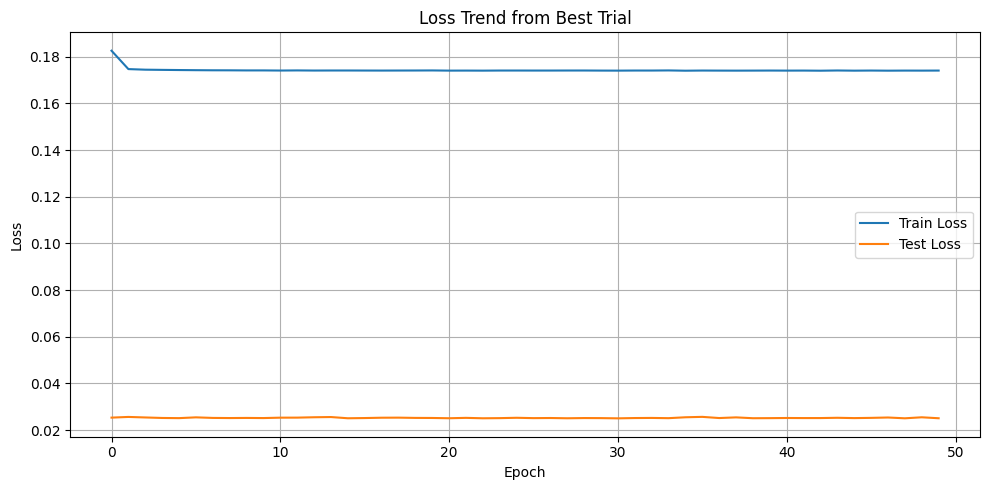

batch_size: 64
learning_rate: 0.008363264443483771
lambda: 0.9632408065194331
🏃 View run optuna_vae_adjusted_for_te_air_scav_rec at: http://localhost:5000/#/experiments/4/runs/c177e584747f42458ab1743186fceee8
🧪 View experiment at: http://localhost:5000/#/experiments/4
===> Epoch: 50 Average mae test loss for targetcol: 4.7369
====> Test set loss: 1607.0558
====> Epoch: 50 Average test loss: 0.0455
Final Test Loss:0.0455, MAE:4.7369
🏃 View run Final_test_val_for_te_air_scav_rec at: http://localhost:5000/#/experiments/4/runs/a377c0990fa34944b6010438b574a77b
🧪 View experiment at: http://localhost:5000/#/experiments/4


In [ ]:
import argparse
import hashlib
from pathlib import Path

import matplotlib.pyplot as plt
import mlflow
import mlflow.pytorch
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.utils.data
import data_insight
from data_insight import setup_duckdb
from duckdb import DuckDBPyConnection as DuckDB
from duckdb import DuckDBPyRelation as Relation
from pathlib import Path
import hashlib
from duckdb import DuckDBPyConnection as DuckDB
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna 
from optuna.visualization import plot_optimization_history


from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset,DataLoader, Dataset
from tqdm.auto import tqdm

import sensor_imputation_thesis.shared.load_data as load


def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# set tracking_uri:
mlflow.set_tracking_uri("http://localhost:5000")
# So I don't know if above commands are sufficient server setup, but it did work for me. And I might need your help if they aren't
# mlflow relevant info:
# I overall faced problem that says "HTTPConnectionPool(host='0.0.0.0', port=5000): Max retries exceeded with url". And the solutions were:
# 1. Try running this line in terminal to see if mlflow logs exist
# if logs exist, port can be directed
# " mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlruns "
# 2. Another possible solution for mlflow errors is to rename the experiment name and the run-name involved below

# Load data

pd.set_option("display.max_columns", None)


def load_engine_data(
    con: DuckDB, product_id: str, start: pd.Timestamp, stop: pd.Timestamp, tags: list[str]
) -> Relation:
    return con.sql(f"""
    SELECT {','.join(tags)}
    FROM timeseries
    WHERE
        time BETWEEN '{start}' AND '{stop}'
        AND pid = '{product_id}'
    """)

def get_tags_hash(tags):
    return hashlib.md5(",".join(tags).encode()).hexdigest()


# edit timestamp as needed
start, stop = pd.Timestamp("2023-10-01"), pd.Timestamp("2024-10-01")

# these are the tags that include 9 missing cols, feel free to edit
tags = [
    "time",
    "fr_eng",
    "te_exh_cyl_out__0",
    "pd_air_ic__0",
    "pr_exh_turb_out__0",
    "te_air_ic_out__0",
    "te_seawater",
    "te_air_comp_in_a__0",
    "te_air_comp_in_b__0",
    "fr_tc__0",
    "pr_baro",
    #most common "bad"/ "out of bound" sensors
    "pd_air_ic__0",  #overlapped with below
    "pr_exh_rec",
    "te_exh_turb_in__0",
    "te_exh_turb_out__0",
    #Feature Importance Result
    #for te_exh_cyl_out__0
    "bo_aux_blower_running",
    "re_eng_load",
    "pr_air_scav_ecs", #overlap
    #pd_air_ic__0
    "pr_air_scav",
    #for te_air_ic_out__0
    #for te_seawater
    "te_air_scav_rec",
    "te_air_ic_out__0",
    "pr_cyl_comp__0",
    "pr_cyl_max__0",
    "se_mip__0",
    "te_exh_cyl_out__0",
    "fr_eng_setpoint",
    "te_air_scav_rec_iso",
    #for pr_baro
    "pr_cyl_max_mv_iso",
    "pr_cyl_comp_mv_iso",
    "fr_eng_ecs",
    "pr_air_scav_iso",


]

# edit point as needed
product_id = "89ccb7a888d53f8792f0580801cede9a"

#product_id 
#add more product id with same engine type (fine the most popular ones)


# Construct the cache file path using the Path class
DATA = Path.home() / "SageMaker/data_cache"
DATA.mkdir(exist_ok=True)
cache = DATA / f"data_{get_tags_hash(tags)}_{product_id}_{start:%Y-%m-%d}_{stop:%Y-%m-%d}.parquet"

# Ensure the directory exists
cache.parent.mkdir(parents=True, exist_ok=True)

if cache.exists():
    df = pd.read_parquet(cache)
else:
    con = setup_duckdb()
    df = load_engine_data(con, product_id, start, stop, tags).df()
    df.to_parquet(cache)

print(df.head(10))


## Adding engine types and assign onehot encoder, and merge df  
con = data_insight.setup_duckdb()
con.sql("SET enable_progress_bar=true")
engine_type = con.sql(f"SELECT engine_type FROM shipinfo WHERE productId == '{product_id}'").df().engine_type.item()
df['engine_type']=engine_type

#Apply onehotencoder 
encoder = OneHotEncoder(sparse_output=False)
encoded_engine_type = encoder.fit_transform(df[['engine_type']])
# Create a DataFrame with the encoded columns
encoded_df = pd.DataFrame(encoded_engine_type, columns=encoder.get_feature_names_out(['engine_type']))
# Concatenate the original DataFrame with the encoded DataFrame
df = pd.concat([df, encoded_df], axis=1)
#drop? not sure yet. 
df.drop('engine_type', axis=1,inplace=True)



# Preprocessing steps not needed for this col
# filter df with engine running (changed into 10/60 revolutions)
df1 = df[df["fr_eng"] > (10/60)]

# Check nan values in each column
for col in df1.columns:
    print(f"Column {col} has {df1[col].isna().sum()} NaN values")


## Newly Suggested Approach to drop nan columns (drop cols with all nan values, and then drop rows that have any nan value )
df1=df.dropna(axis=1,how='all')
# drop any null vals in rows 
df1=df1.dropna(axis=0,how='any')

#check the length of the df1 and the length of df to check how many cols rows are dropped 
print("shape of original df:")
print("Datasize:",len(df))
print("Colnumber:",len(df.columns))

print("shape of filtered df:")
print("Datasize:",len(df1))
print("Colnumber:",len(df1.columns))

# Select numeric columns
numeric_df = df1.select_dtypes(include="number")
print(numeric_df)

data=numeric_df  #data here is before scaling 


#define inverse scale
def inverse_scale(scaled_data, data_min, scale):
    return scaled_data*scale + data_min


# VAE Model
class VAE(nn.Module):
    def __init__(self, input_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.tanh(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


##XGBoost 


# Reconstruction + KL divergence losses summed over target column and batch
def loss_function(recon_x, x, mu, logvar, targetcol_idx, lambda_val):
    # Specify the target column
    recon_x_col = recon_x[:, targetcol_idx]
    x_col = x[:, targetcol_idx]

    # MSE & KLD for target column
    MSE_col = F.mse_loss(recon_x_col, x_col, reduction="sum")
    KLD_col = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # MSE & KLD for entire dataset
    MSE_all = F.mse_loss(recon_x, x, reduction="sum")
    KLD_all = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Combine losses using lambda
    loss = lambda_val * (MSE_col + KLD_col) + (1 - lambda_val) * (MSE_all + KLD_all)
    return loss


###add mse(&mae) comparison within training loop for target column
#test if this works 


def train(epoch, model, train_loader, data_min, scale, lambda_val, targetcol_idx, optimizer, device, args):
    model.train()
    train_loss = 0
    mae_loss_target_train = 0
    average_train_loss = 0  # Initialize average_train_loss
    pbar = tqdm(total=len(train_loader), desc="Training")
    for batch_idx, (data,) in enumerate(train_loader): #trian loader is after scaling
        data_unmasked = data.to(device).float() #this data is before scaling
        # Mask the target column
        data_masked = data_unmasked.clone() #before scaling
        data_masked[:, targetcol_idx] = -2
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data_masked)  # Masked target col
        if torch.isnan(recon_batch).any():
            print("NaN or in recon_batch!")
            break
        loss = loss_function(recon_batch, data_unmasked, mu, logvar, targetcol_idx, lambda_val)
        if torch.isnan(loss) or torch.isinf(loss):
            raise ValueError(f"NaN or Inf detected in loss at batch {batch_idx}. Check scaling or model outputs!")
            break
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            pbar.set_description(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item() / len(data),
                )
            )

        pbar.update(1)
        #revised 
        data_unscaled=inverse_scale(data_unmasked,data_min.to(device),scale.to(device))
        target_column=data_unscaled[:,targetcol_idx]
        recon_unscaled=inverse_scale(recon_batch,data_min.to(device),scale.to(device))
        recon_column=recon_unscaled[:,targetcol_idx]

                                                                                                
        #mae metric calculation
        mae_loss_target_train+=torch.mean(torch.abs(target_column-recon_column)).item()
        #mae_loss_target_train += mean_absolute_error(target_column, recon_column)  # Ground truth

    average_train_loss = train_loss / len(train_loader.dataset)  # Update after loop
    print("====> Epoch: {} Average train loss: {:.4f}".format(epoch, average_train_loss))
    print("===> Epoch: {} Average mae test loss for targetcol :{:.4f}".format(epoch,mae_loss_target_train/len(train_loader)))
    return average_train_loss, mae_loss_target_train / len(train_loader)


#Added mse in the test
#In the test loop, masked column should be the input. 
#Redefine data for the test loop(should I inlcude this in the test loop or leave it here?)
#dataset changed into validation set for testing loop
    
def test(epoch, model, val_loader, scale, data_min, targetcol_idx, device):
    model.eval()
    test_loss = 0
    mae_loss_target_test = 0
    with torch.no_grad():
        for batch_idx, (data,) in enumerate(val_loader):
            data_unmasked = data.to(device).float()  #data used here is before scaling 
            # Mask the target column
            data_masked = data_unmasked.clone()
            data_masked[:, targetcol_idx] = -2
            recon_batch, mu, logvar = model(data_masked)  # Masked target col
            # Define new lambda val for testing
            lambda_val = 1.0
            test_loss += loss_function(recon_batch, data_unmasked, mu, logvar, targetcol_idx, lambda_val).item()
            # Scale back target column and reconstructed column
            data_unscaled=inverse_scale(data_unmasked,data_min.to(device),scale.to(device))
            target_column=data_unscaled[:,targetcol_idx]
            recon_unscaled=inverse_scale(recon_batch,data_min.to(device),scale.to(device))
            recon_column=recon_unscaled[:,targetcol_idx]
                                                           
            #mae metric calculation
            mae_loss_target_test+=torch.mean(torch.abs(target_column-recon_column)).item()
           # mae_loss_target_test += mean_absolute_error(target_column, recon_column)
        
        print("===> Epoch: {} Average mae test loss for targetcol: {:.4f}".format(epoch, mae_loss_target_test / len(val_loader)))
        print("====> Test set loss: {:.4f}".format(test_loss))
        average_test_loss = test_loss / len(val_loader.dataset)
        print("====> Epoch: {} Average test loss: {:.4f}".format(epoch, average_test_loss))
    
    return average_test_loss, mae_loss_target_test / len(val_loader)




def main():
    # Configuration parameters
    class Config:
        batch_size = 64
        epochs = 50
        no_cuda = False
        no_mps = False
        seed = 1
        log_interval = 10
        lr = 1e-4

    dl_kwargs = dict(
        batch_size=Config.batch_size,
        shuffle=True,
        # num_workers=4, # This may or may not be faster, depending on system
        pin_memory=torch.cuda.is_available(),
    )

    args = Config()
    args.cuda = not args.no_cuda and torch.cuda.is_available()
    use_mps = not args.no_mps and torch.backends.mps.is_available()

    torch.manual_seed(args.seed)

    if args.cuda:
        device = torch.device("cuda")
    elif use_mps:
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    
   # Specify the target column, here should be changed while training other target columns
    # (edit point as needed)
    targetcolumn = "te_air_scav_rec"
    targetcol_idx = data.columns.get_loc(targetcolumn)

    #split dataset
    train_size = int(0.6 * len(data))
    val_size=int(0.2 * len(data))

    train_df = data.iloc[:train_size]
    val_df = data.iloc[train_size:train_size + val_size]
    test_df= data.iloc[train_size + val_size:]

    # Standardize the numeric data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    #only apply scaler to the train set 
    scaled_train=scaler.fit_transform(train_df.values)
    print("scaled_data", scaled_train)
    print("unscaled_data",data)

    # Transform val and test using the same scaler
    scaled_val=scaler.transform(val_df.values)
    scaled_test=scaler.transform(test_df.values)

        
    data_min=torch.tensor(scaler.data_min_,dtype=torch.float32)
    data_max=torch.tensor(scaler.data_max_,dtype=torch.float32)
    scale=data_max-data_min
    scale[scale==0]=1e-8


    #Convert DataFrame to Tensor
    scaled_train_tensor=torch.tensor(scaled_train,dtype=torch.float32)
    scaled_val_tensor=torch.tensor(scaled_val,dtype=torch.float32)
    scaled_test_tensor=torch.tensor(scaled_test,dtype=torch.float32)

    #create datasets on CPU
    train_dataset=TensorDataset(scaled_train_tensor)
    val_dataset=TensorDataset(scaled_val_tensor)
    test_dataset=TensorDataset(scaled_test_tensor)


     # Initialize Mlflow
    mlflow.set_experiment("VAE_adjustedtestwizcorrect_optuna")


    def plot_loss_trends(run_id):
        client = mlflow.tracking.MlflowClient()
        
        # Retrieve metric history
        history_train = client.get_metric_history(run_id, "average_train_loss")
        history_test = client.get_metric_history(run_id, "average_test_loss")

        if not history_train or not history_test:
            print("No metric history found for the given run_id.")
            return

        # Sort by step to ensure correct order
        history_train.sort(key=lambda x: x.step)
        history_test.sort(key=lambda x: x.step)

        epochs = [point.step for point in history_train]
        train_losses = [point.value for point in history_train]
        test_losses = [point.value for point in history_test]

        # Plotting
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, train_losses, label="Train Loss")
        plt.plot(epochs, test_losses, label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss Trend from Best Trial")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()



    #Adding Optuna
    def objective(trial,device, data_min, scale):
        with mlflow.start_run(nested=True) as run:
            input_dim = scaled_train.shape[1]
            batch_size =trial.suggest_int("batch_size", 32, 128, step=32)
            lr = trial.suggest_float("learning_rate", 1e-6, 1e-1, log=True)
            lambda_val = trial.suggest_float("lambda", 0.5, 1.0)
            
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
            
            mlflow.log_params({
                    "batch_size":batch_size,
                    "learning_rate":lr,
                    "lambda":lambda_val
                })

            model = VAE(input_dim=input_dim).to(device)

            optimizer = optim.Adam(model.parameters(), lr=lr)


            for epoch in range(args.epochs):
                
                average_train_loss, mae_loss_target_train = train(
                    epoch,
                    model,
                    train_loader,
                    lambda_val=lambda_val,
                    targetcol_idx=targetcol_idx,
                    optimizer=optimizer,
                    device=device,
                    data_min=data_min, 
                    scale=scale, #this is used for inverse scaling
                    args=args
                )

                average_test_loss, mae_loss_target_test=test(
                    epoch,
                    model,
                    val_loader,
                    targetcol_idx=targetcol_idx,
                    device=device,
                    data_min=data_min,
                    scale=scale #same, used for inverse scaling 
                
                )
                

                
                mlflow.log_metrics(
                    {
                        "epoch": epoch,
                        "average_train_loss": average_train_loss,
                        "average_test_loss": average_test_loss,
                        "mae_loss_target_train": mae_loss_target_train,
                        "mae_loss_target_test": mae_loss_target_test,
                    },
                    step=epoch,
)


            trial.set_user_attr("model_state_dict", model.state_dict())
            trial.set_user_attr("mlflow_run_id", run.info.run_id)
            
            return average_test_loss # Ensure only one value is returned

   
    # Define run name(edit)
    vae_run_name = "optuna_vae_adjusted_for_te_air_scav_rec"
    
    with mlflow.start_run(run_name=vae_run_name) as parent_run:
        study = optuna.create_study(direction="minimize")
        study.optimize(lambda trial:objective (trial,device,data_min,scale),n_trials=100, timeout=3600)
        #plot_optimization_history(study)  #visualization 
        best_trial = study.best_trial
        best_run_id = best_trial.user_attrs["mlflow_run_id"] #log run id to see the loss trend later
        best_batch_size=best_trial.params["batch_size"]

      
        mlflow.log_params(best_trial.params)
        mlflow.log_param("best_run_id", best_run_id)
        mlflow.log_metric("Best Validation Loss:", best_trial.value)
        print("Best Trial:")
        print(f"Validation loss: {best_trial.value}")
        print("Params:")

        # Check the loss trend of the best trial using corresponding run_id 
        best_trial_run_id = best_run_id
        plot_loss_trends(best_trial_run_id)


        for key, value in best_trial.params.items():
            print(f"{key}: {value}")
       
    #Test on the test set with best parameters
    with mlflow.start_run(run_name="Final_test_val_for_te_air_scav_rec", nested=True):
            # Model Reloading
            best_model=VAE(input_dim=scaled_train.shape[1]).to(device)
            best_model.load_state_dict(study.best_trial.user_attrs["model_state_dict"])
              
            
            #Evaluate on the test data 
            test_loader=DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)
            epoch=50
            average_test_loss, mae_loss_target_test=test(
                        val_loader=test_loader,
                        epoch=epoch,
                        model=best_model,
                        targetcol_idx=targetcol_idx,
                        device=device,
                        data_min=data_min,
                        scale=scale
                        )
                
                
            mlflow.log_metrics(
                    {
                    "epoch": epoch,
                    "Final_test_loss": average_test_loss,
                    "Final_loss_target_test": mae_loss_target_test,
                    },
                 step=epoch,
)
           
            print(f"Final Test Loss:{average_test_loss:.4f}, MAE:{mae_loss_target_test:.4f}")
            
            ##Registration may not needed yet.. 
             #log the model with scaling params
            #input_dim = scaled_train.shape[1]
            #input_example = torch.randn(1, input_dim).float().cpu().numpy()  # Convert to NumPy
            #mlflow.pytorch.log_model(
              #  pytorch_model=best_model,
               # artifact_path="model",
               # registered_model_name="VAE for te_air_scav_rec",
               # input_example=input_example,
               # extra_pip_requirements=["torch","optuna","mlflow"],
                                                             
               # metadata={
                  #  "train_min": data_min.cpu().numpy().tolist(),
                  #  "scale": scale.cpu().numpy().tolist()
                 #   }
                #)
            

if __name__ == '__main__':
    main()







    # CSOM: This should be done ONCE after training, and not inside the training loop.

In [ ]:
with torch.no_grad():
                # Generate a latent sample
                sample = torch.randn(64, 20).to(device)  # Adjust latent dimensions
                # Decode the sample
                sample = model.decode(sample).cpu().numpy()  
                # Validate the shape of the decoded sample
                if sample.shape[1] != len(numeric_df.columns):
                    raise ValueError(
                        f"Shape mismatch: Generated data has {sample.shape[1]} columns, "
                        f"but expected {len(numeric_df.columns)}."
                    )

                # Reverse the scaling to map back to the original distribution
                generated_df = pd.DataFrame(scaler.inverse_transform(sample), columns=numeric_df.columns)
                print(generated_df.head())


NameError: name 'device' is not defined

In [ ]:

class Config:
    batch_size = 64
    epochs = 10
    no_cuda = False
    no_mps = False
    seed = 1
    log_interval = 10

args = Config()
args.cuda = not args.no_cuda and torch.cuda.is_available()
use_mps = not args.no_mps and torch.backends.mps.is_available()

torch.manual_seed(args.seed)

if args.cuda:
    device = torch.device("cuda")
elif use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")



In [ ]:

# %%
with torch.no_grad():
                # Generate a latent sample
                sample = torch.randn(64, 20).to(device)  # Adjust latent dimensions
                # Decode the sample
                sample = model.decode(sample).cpu().numpy()  
                # Validate the shape of the decoded sample
                if sample.shape[1] != len(numeric_df.columns):
                    raise ValueError(
                        f"Shape mismatch: Generated data has {sample.shape[1]} columns, "
                        f"but expected {len(numeric_df.columns)}."
                    )

                # Reverse the scaling to map back to the original distribution
                generated_df = pd.DataFrame(scaler.inverse_transform(sample), columns=numeric_df.columns)
                print(generated_df.head())



NameError: name 'model' is not defined

In [ ]:
best_model

NameError: name 'best_model' is not defined

In [ ]:
VAE

__main__.VAE

In [ ]:
df1["te_air_scav_rec"].std()

2.190397477015881